## Keras implementation of https://junyanz.github.io/CycleGAN/

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # can choose theano, tensorflow, cntk
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile,dnn.library_path=/usr/lib'

In [2]:
import keras.backend as K
if os.environ['KERAS_BACKEND'] =='theano':
    channel_axis=1
    K.set_image_data_format('channels_first')
    channel_first = True
else:
    K.set_image_data_format('channels_last')
    channel_axis=-1
    channel_first = False

Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate, ZeroPadding2D, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

In [4]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization


In [5]:
# HACK speed up theano
if K._BACKEND == 'theano':
    import keras.backend.theano_backend as theano_backend
    def _preprocess_conv2d_kernel(kernel, data_format):
        #return kernel
        if hasattr(kernel, "original"):
            print("use original")
            return kernel.original
        elif hasattr(kernel, '_keras_shape'):
            s = kernel._keras_shape
            print("use reshape",s)
            kernel = kernel.reshape((s[3], s[2],s[0], s[1]))
        else:
            kernel = kernel.dimshuffle((3, 2, 0, 1))
        return kernel
    theano_backend._preprocess_conv2d_kernel = _preprocess_conv2d_kernel

In [6]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, ndf, input_size = (None, None), max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a =  Input(shape=(nc_in, *input_size))
    else:
        input_a = Input(shape=(*input_size, nc_in))
    _ = input_a
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1)) (_)    
    
    _ = Flatten(name = 'flatten') (_)
    _ = Dense(1, name = 'final_dense', activation = "sigmoid" if use_sigmoid else None) (_)
    
    return Model(inputs=[input_a], outputs=_)

In [7]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2,
                            use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [8]:
def UNET_G_SM(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2,
                            use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=ngf, nf_next=ngf)
    _ = Activation('relu')(_)
    _ = Conv2DTranspose(ngf, kernel_size=(13, 4), strides=(1, 2),
                            use_bias=True,
                            kernel_initializer = conv_init,
                            name = 'convt.fin')(_)
    _ = Cropping2D((0, 1))(_)
    
    _ = Activation("relu")(_)
    _ = Conv2DTranspose(ngf//2, kernel_size=4, strides=2,
                        use_bias=True,
                        kernel_initializer = conv_init,          
                        name = 'convt.finfin')(_)        
    _ = Cropping2D(1)(_)
    _ = Activation('relu')(_)
    _ = Conv2DTranspose(nc_out, kernel_size=(3, 4), strides=(1, 2),
                        use_bias=True,
                        kernel_initializer = conv_init,          
                        name = 'convt.finfinfin')(_)        
    _ = Cropping2D(1)(_)
    _ = Activation('sigmoid')(_)
    return Model(inputs=inputs, outputs=[_])

In [9]:
def UNET_G_MS(isize, nc_in=1, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2,
                            use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, *musicSize))
    else:
        _ = inputs = Input(shape=(*musicSize, nc_in))
    _ = conv2d(ngf, kernel_size=4, strides=(1, 2), use_bias=True,
                   padding="same", name = 'conv_superfirst') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    #_ = ZeroPadding2D(padding=(0, 1), data_format=None) (_)
    _ = conv2d(ngf*2, kernel_size=4, strides=2, use_bias=True,
                   padding="same", name = 'conv_first') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    _ = ZeroPadding2D(padding=(0, 1), data_format=None) (_)
    _ = conv2d(ngf*2, kernel_size=(13, 4), strides=(1,2), use_bias=True,
               padding="valid", name = 'conv_firstfirst') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    _ = block(_, isize, ngf*2, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [10]:
nc_s = 3
nc_m = 1
ngf = 64
ndf = 128

spriteSize = (32, 32)
musicSize = (88, 256)
fs = 32
snap_to = 1 # snaps to every 1/4 of a second
snap_factor = 1 / snap_to
dur = 8.0
pitch_range = (21, 109)
binary_music = True

use_lsgan = True
λ = 10 if use_lsgan else 100
md_weight = 1
mg_weight = 1

cycleS_loss_weight = 1

continue_training = False
batchSize = 2
lrD = 1e-4
lrG = 1e-4

assert((fs // snap_factor) * snap_factor == fs)

In [11]:
netGM = UNET_G_SM(32, nc_s, nc_m, ngf) #netGA
netGM.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_32 (Conv2D)                (None, 16, 16, 64)   3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 16, 16, 64)   0           conv_32[0][0]                    
__________________________________________________________________________________________________
conv_16 (Conv2D)                (None, 8, 8, 128)    131072      leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
batch_norm

In [12]:
netGS = UNET_G_MS(32, nc_m, nc_s, ngf) #netGB
netGS.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 88, 256, 1)   0                                            
__________________________________________________________________________________________________
conv_superfirst (Conv2D)        (None, 88, 128, 64)  1088        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 88, 128, 64)  0           conv_superfirst[0][0]            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 44, 64, 128)  131200      leaky_re_lu_5[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [13]:
netDM = BASIC_D(nc_m, ndf, input_size = musicSize, use_sigmoid = not use_lsgan) # netDA
netDS = BASIC_D(nc_s, ndf, input_size = spriteSize, use_sigmoid = not use_lsgan) # netDB
netDM.summary()
netDS.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 88, 256, 1)        0         
_________________________________________________________________
First (Conv2D)               (None, 44, 128, 128)      2176      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 44, 128, 128)      0         
_________________________________________________________________
pyramid.1 (Conv2D)           (None, 22, 64, 256)       524288    
_________________________________________________________________
batch_normalization_15 (Batc (None, 22, 64, 256)       1024      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 22, 64, 256)       0         
_________________________________________________________________
pyramid.2 (Conv2D)           (None, 11, 32, 512)       2097152   
__________

In [14]:
from keras.optimizers import RMSprop, SGD, Adam

In [15]:
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

bce_loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))
    
def cycle_variables(netG1, netG2):
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    rec_input = netG2([fake_output])
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_M, fake_S, rec_M, cycleM_generate = cycle_variables(netGS, netGM)
real_S, fake_M, rec_S, cycleS_generate = cycle_variables(netGM, netGS)

In [16]:
def DM_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = K.mean(cycleS_loss_weight * K.abs(rec-real))
    return loss_D, loss_G, loss_cyc

def DS_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = K.mean(cycleS_loss_weight * K.abs(rec-real))
    return loss_D, loss_G, loss_cyc

loss_DM, loss_GM, loss_cycM = DM_loss(netDM, real_M, fake_M, rec_M)
loss_DS, loss_GS, loss_cycS = DS_loss(netDS, real_S, fake_S, rec_S)
loss_cyc = loss_cycM+loss_cycS

In [17]:
loss_G = loss_GM+loss_GS+λ*loss_cyc
loss_D = loss_DM+loss_DS

weightsD = netDM.trainable_weights + netDS.trainable_weights
weightsG = netGM.trainable_weights + netGS.trainable_weights

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD,[],loss_D)
netD_train = K.function([real_M, real_S],[md_weight * loss_DM/2, loss_DS/2], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG,[], loss_G)
netG_train = K.function([real_M, real_S], [mg_weight * loss_GM, loss_GS, loss_cyc], training_updates)

In [18]:
!pip install pretty_midi
import pretty_midi

def prepare_midi(pm, fs = 16, duration = 30.0, pitchrange = (0, 128)):
    """ 
    Takes a given midi file name and returns a PrettyMIDI object and its piano roll. 

    Extended description of function. 

    Parameters: 
    name (str): Name of midi file
    fs (int): Samples per sec
    duration (float): duration of time to keep 
    pitchrange (tuple[int]): tuple of starting pitch and ending pitch. 0 to 127 possible

    Returns: 
    (PrettyMIDI, numpyArray): prettymidi object and cropped piano roll array

    """ 

    pmroll = pm.get_piano_roll(fs)[pitchrange[0] : pitchrange[1]]
    if duration > 0:
        pmroll = pmroll[:, 0 : int(duration * fs)]
    return pmroll

def to_midi(pr, fs = 8, pitchrange = (0, 128), force_velocity = False):
    pm = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program = piano_program)
    
    pitch_start = pitchrange[0]
    for p in range(len(pr)):
        start = False
        startTime = 0.0
        v = 0
        for t in range(len(pr[p])):
            if not start and int(pr[p][t]) > 0:
                start = True
                v = int(pr[p][t])
                startTime = t / fs
            elif start and int(pr[p][t]) != v:
                endTime = t / fs
                vel = v
                if force_velocity:
                    vel = 125
                _ = pretty_midi.Note(velocity = vel, 
                                    pitch = pitch_start + p, start = startTime, end = endTime)
                piano.notes.append(_)
                if int(pr[p][t]) == 0:
                    start = False
                else:
                    startTime = endTime
                    v = int(pr[p][t])
    
    pm.instruments.append(piano)
    return pm


In [19]:
def show_pitch_occur(midis):
    pitches = [0] * 128
    for fn in midis:        
        try:
            _ = pretty_midi.PrettyMIDI(fn)
            print(fn, "\n loading... loaded")
        except:
            print(fn, "\n loading... ERROR")
        roll = prepare_midi(_, fs = 8, duration = 0.0)
        for p in range(128):
            if len(set(roll[p])) > 1:
                pitches[p] += 1

    for p in range(128):
        print(p, pitches[p], sep=': ')

In [20]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern, recursive = True)

def read_image(fn, imgSize, augment=False):
    im = Image.open(fn).convert("RGBA")
    im = im.resize(imgSize, Image.BILINEAR )
    img = np.array(im, dtype=np.float64)
    alphaLayer = img[:,:,3] / 255.0
    img[:,:,0] *= alphaLayer
    img[:,:,1] *= alphaLayer
    img[:,:,2] *= alphaLayer
    img = (img/255.0*2-1)[:,:,:3]
    if augment and randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    return img

def read_midi(fn, imgSize, fs, duration, prange, augment=False):
    try:
        _ = pretty_midi.PrettyMIDI(fn)
    except:
        return None
    roll = prepare_midi(_, fs, 0, prange)
    window = int(fs * duration)
    end = len(roll[0]) - int(5 * fs) - window
    if end < int(5 * fs):
        print(end, " not big enough (", fn, ")")
        return None
    start = np.random.randint(int(5 * fs), end)
    snap = fs // snap_factor
    start = int((start // snap) * snap)
    img = roll[:, start : start + window]
    if binary_music:
        img = np.clip(img, 0, 1)
    else:
        img = (img/128.0)
    #if augment and randint(0,1):
    #    img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    if img.shape != imgSize:
        print("[ERROR] Created an invalid shaped piece of music data! Size: ", img.shape, " instead of ", imgSize)
    return img

data = "sprites2music"
train_S = load_data('trainingSet/sprites/**/*.png')
train_M = load_data('trainingSet/music/**/*.mid')

print("[Removing songs that are too short]")
to_remove = []
for m in train_M:
    if read_midi(m, musicSize, fs, dur, pitch_range) is None:
        to_remove.append(m)
for m in to_remove:
    train_M.remove(m)

assert len(train_M) and len(train_S)

shuffle(train_M)
shuffle(train_S)

print("Num midi files: ", len(train_M))
print("Num sprites: ", len(train_S))

[Removing songs that are too short]


C:\Users\mmille95\AppData\Local\conda\conda\envs\cycleGAN\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


-263  not big enough ( trainingSet/music\vgpiano\CastleVania_-_StageClear.mid )
-197  not big enough ( trainingSet/music\vgpiano\cchitcat.mid )
-288  not big enough ( trainingSet/music\vgpiano\command_melody_lozww_piano.mid )
-7  not big enough ( trainingSet/music\vgpiano\Creation_piano_.mid )
80  not big enough ( trainingSet/music\vgpiano\DKONG.mid )
36  not big enough ( trainingSet/music\vgpiano\dk_title.mid )
-324  not big enough ( trainingSet/music\vgpiano\GameOverPiano.mid )
-160  not big enough ( trainingSet/music\vgpiano\inverted_song_time_piano.mid )
-324  not big enough ( trainingSet/music\vgpiano\Mario_Dies_Super_Mario_World.mid )
-237  not big enough ( trainingSet/music\vgpiano\mmx5bossintropianoversion.mid )
-236  not big enough ( trainingSet/music\vgpiano\MP_Artifact_-_Piano_Only_-_By_DaDude.mid )
-234  not big enough ( trainingSet/music\vgpiano\MP_Item_Acquired_-_Piano_Only_-_By_DaDude.mid )
-77  not big enough ( trainingSet/music\vgpiano\Music_Box_Clock.mid )
159  not bi

34 trainingSet/music\vgpiano\FireEmblemTheme1_1.mid


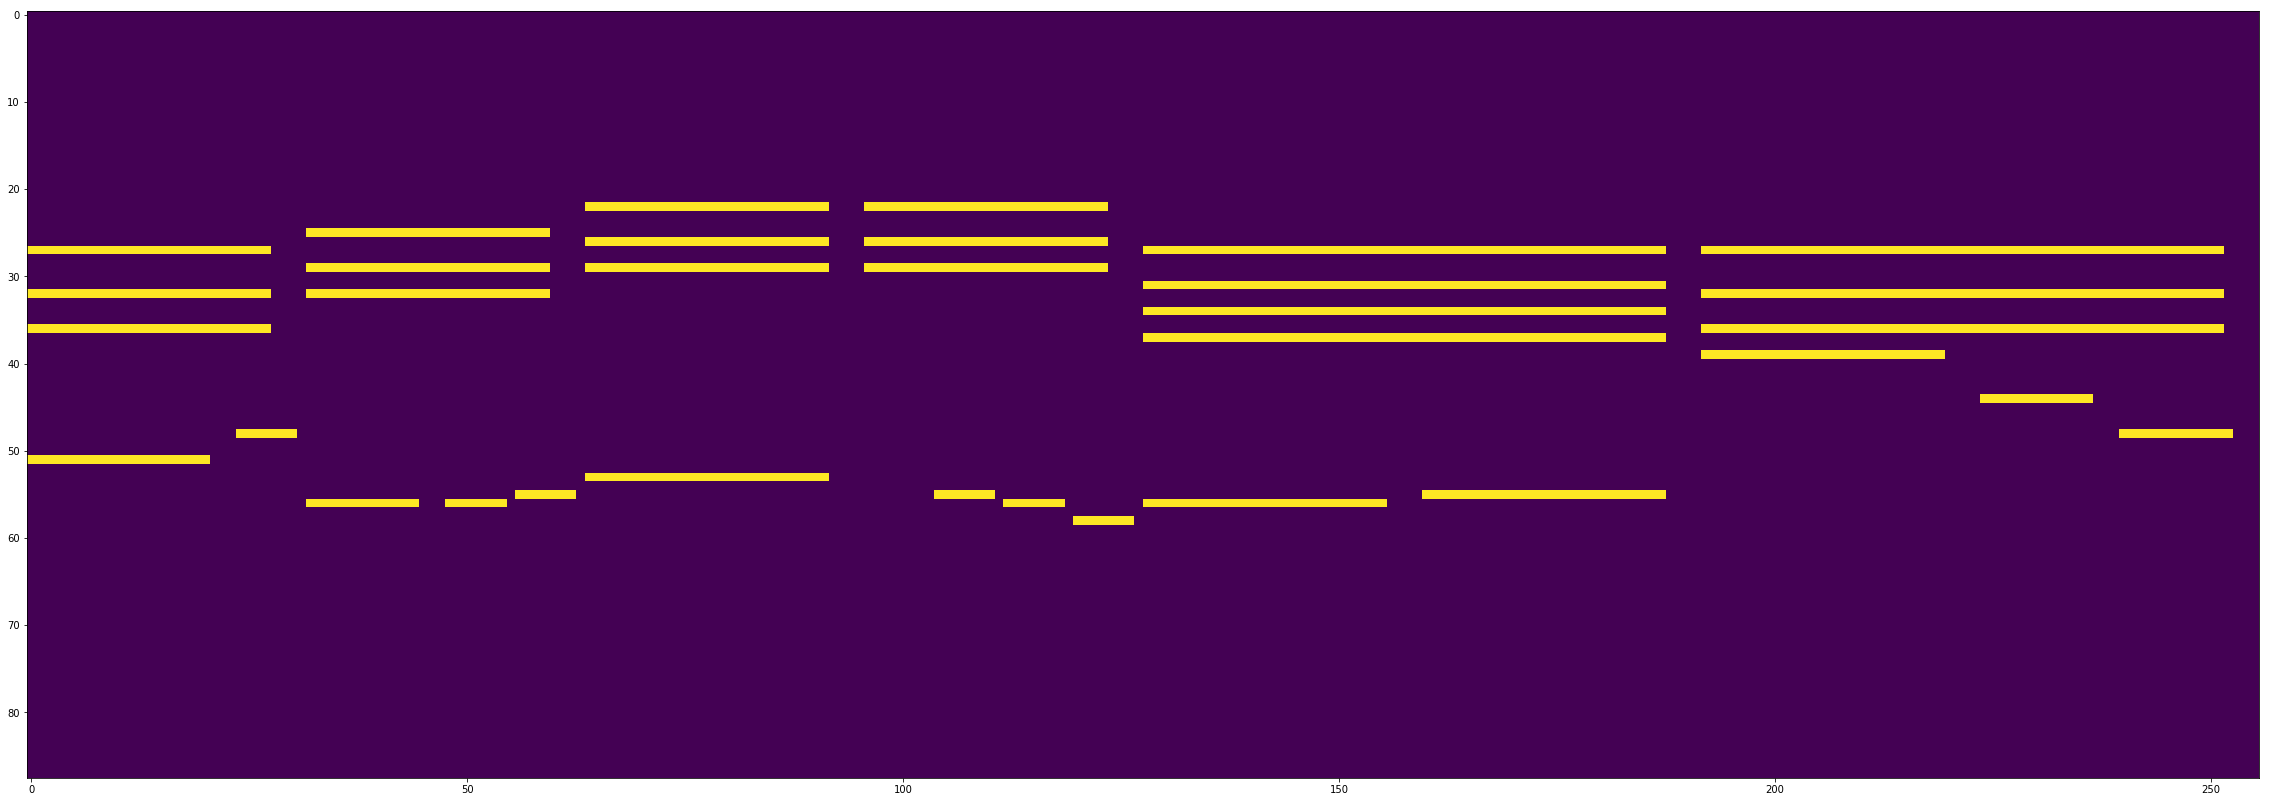

(88, 256)


In [21]:
#show_pitch_occur(train_M)
test = None
while test is None:
    n = np.random.randint(len(train_M))
    print(n, train_M[n])
    test = read_midi(train_M[n], musicSize, fs, dur, pitch_range)
plt.figure(figsize = (40, 80))
plt.imshow(test)
plt.show()

pm = to_midi(test, fs, pitch_range, force_velocity= binary_music)
pm.write('test.mid')
print(test.shape)

In [22]:
def minibatchS(data, batchsize, imgSize = spriteSize, augment = False):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j], imgSize, augment) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       
        
def minibatchM(data, batchsize, imgSize = musicSize, augment = False):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_midi(data[j], imgSize, fs, dur, pitch_range, augment) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.expand_dims(np.float32(rtn), -1)

def minibatchMS(dataM, dataS, batchsize):
    batchM=minibatchM(dataM, batchsize, augment=False)
    batchS=minibatchS(dataS, batchsize, augment=True)
    tmpsize = None
    while True:        
        ep1, M = batchM.send(tmpsize)
        ep2, S = batchS.send(tmpsize)
        tmpsize = yield max(ep1, ep2), M, S

In [23]:
def showX(X, imageWidth, imageHeight, nc, rows=1, figsize = (20, 40)):
    assert X.shape[0]%rows == 0
    cols = X.shape[0]//rows
    plt.figure(figsize=figsize)
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            int_X = X[i]
            if (imageHeight, imageWidth) == spriteSize:
                int_X = ((int_X+1)/2)
            int_X = (int_X*255).clip(0,255).astype('uint8')
            if channel_first:
                int_X = np.moveaxis(int_X.reshape(-1,nc,imageWidth, imageHeight), 1, nc)
            else:
                int_X = int_X.reshape(-1, imageWidth, imageHeight, nc)
            ax = plt.subplot(rows, cols, i+1)
            ax.imshow(np.squeeze(int_X), cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
            ax.axis('off')
    plt.show()

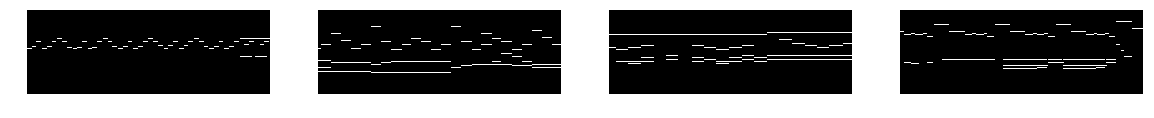

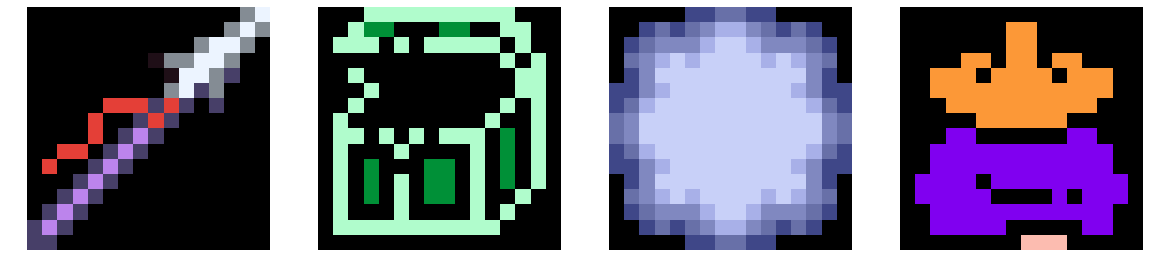

In [24]:
train_batch = minibatchMS(train_M, train_S, 4)

_, M, S = next(train_batch)
showX(M, *musicSize, nc_m)
showX(S, *spriteSize, nc_s)
del train_batch, M, S

In [25]:
def showG(M,S):
    def G(fn_generate, X):
        fakes = []
        recs = []
        for i in range(X.shape[0]):
            fake, rec = fn_generate([X[i:i+1]])
            fakes.append(fake[0])
            recs.append(rec[0])
        return [np.array(fakes), np.array(recs)]
    rM = G(cycleM_generate, M)
    rS = G(cycleS_generate, S)
    arr = [M,*rM,S,*rS]
    for elem in arr:
        print(elem.shape)
        showX(elem, elem.shape[1], elem.shape[2], elem.shape[3], 1)

[0/110][25] Loss_D: 32.506695 12.123507 Loss_G: 21.462881 18.863603 loss_cyc 1.587600 0.446
[0/110][50] Loss_D: 28.549208 21.134501 Loss_G: 2.547733 3.997385 loss_cyc 1.619613 0.570
[0/110][75] Loss_D: 22.416540 14.691199 Loss_G: 20.665803 2.999181 loss_cyc 1.604248 0.689
[0/110][100] Loss_D: 20.375187 8.589493 Loss_G: 24.364504 2.962951 loss_cyc 1.625788 0.811
[0/110][125] Loss_D: 23.795652 6.182093 Loss_G: 39.767655 2.735833 loss_cyc 1.579988 0.934
[0/110][150] Loss_D: 14.781445 4.859681 Loss_G: 8.580054 1.863102 loss_cyc 1.553865 1.049
[0/110][175] Loss_D: 20.032325 12.803088 Loss_G: 16.843801 2.196764 loss_cyc 1.493598 1.167
[0/110][200] Loss_D: 10.844142 4.490467 Loss_G: 4.534979 1.816322 loss_cyc 1.427879 1.286
[0/110][225] Loss_D: 11.073599 2.653423 Loss_G: 7.091361 1.808032 loss_cyc 1.467857 1.417
[0/110][250] Loss_D: 15.311882 3.566386 Loss_G: 44.788318 2.381561 loss_cyc 1.497216 1.536
[0/110][275] Loss_D: 14.341966 2.127131 Loss_G: 9.088190 1.859843 loss_cyc 1.571129 1.662
[0

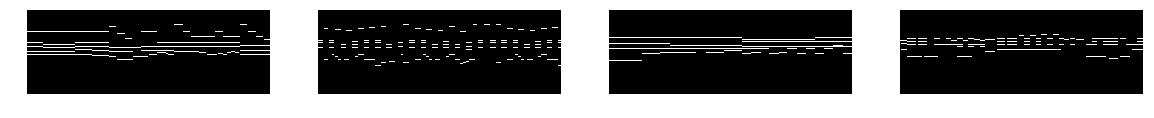

(4, 32, 32, 3)


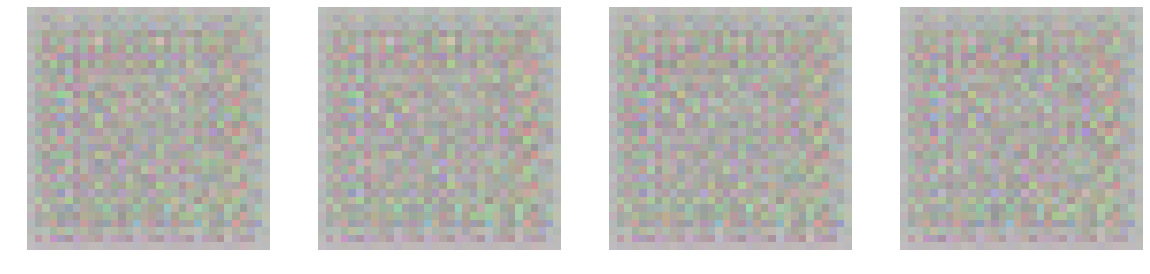

(4, 88, 256, 1)


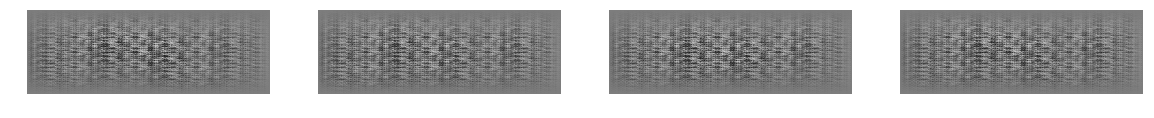

(4, 32, 32, 3)


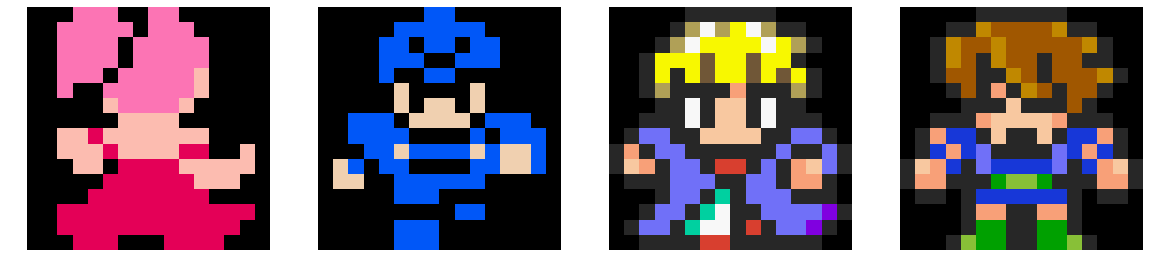

(4, 88, 256, 1)


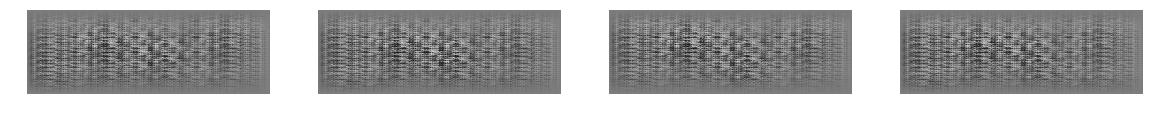

(4, 32, 32, 3)


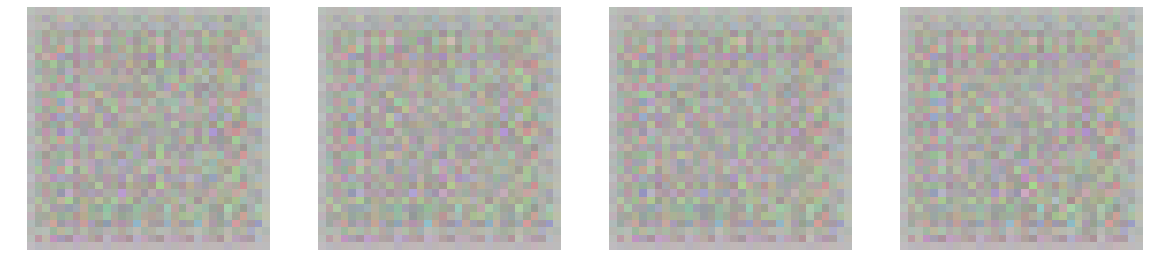

[1/110][375] Loss_D: 9.593140 3.970712 Loss_G: 11.065909 2.774698 loss_cyc 1.446004 2.259
[1/110][400] Loss_D: 5.541456 1.771510 Loss_G: 3.959900 2.773853 loss_cyc 1.408172 2.389
[1/110][425] Loss_D: 4.003713 3.054903 Loss_G: 2.378682 5.044373 loss_cyc 1.319572 2.516
[1/110][450] Loss_D: 3.663625 3.686129 Loss_G: 2.855049 5.264612 loss_cyc 1.329158 2.643
[1/110][475] Loss_D: 4.255525 1.322787 Loss_G: 4.632380 1.943414 loss_cyc 1.333376 2.761
[1/110][500] Loss_D: 4.459378 1.167324 Loss_G: 5.272136 1.895617 loss_cyc 1.280187 2.884
[1/110][525] Loss_D: 2.625612 2.139812 Loss_G: 3.280352 2.800423 loss_cyc 1.293562 3.004
[1/110][550] Loss_D: 1.933903 2.150539 Loss_G: 1.960838 2.271814 loss_cyc 1.267843 3.118
[1/110][575] Loss_D: 2.052921 1.259595 Loss_G: 1.714468 2.200410 loss_cyc 1.237501 3.242
[1/110][600] Loss_D: 2.018510 1.062500 Loss_G: 3.046476 1.933386 loss_cyc 1.223069 3.360
[1/110][625] Loss_D: 2.340733 0.991853 Loss_G: 3.381838 2.356977 loss_cyc 1.288434 3.490
[1/110][650] Loss_D:

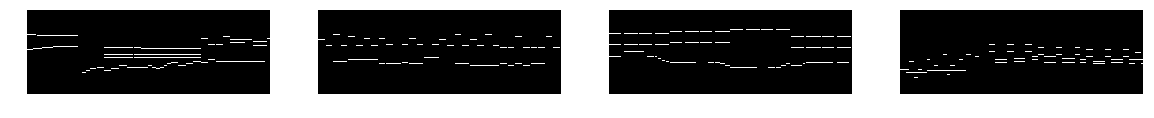

(4, 32, 32, 3)


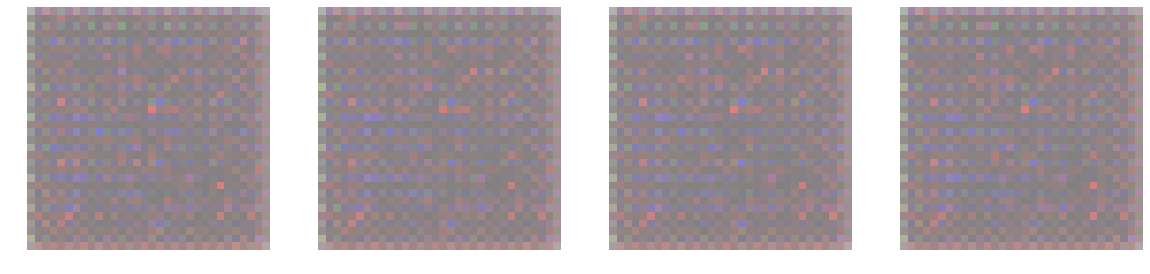

(4, 88, 256, 1)


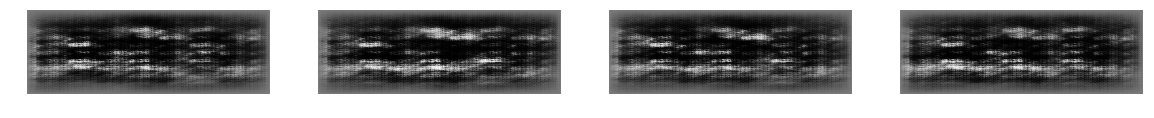

(4, 32, 32, 3)


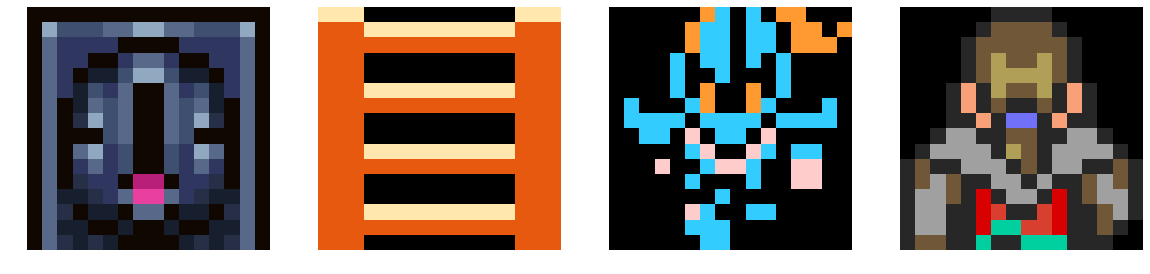

(4, 88, 256, 1)


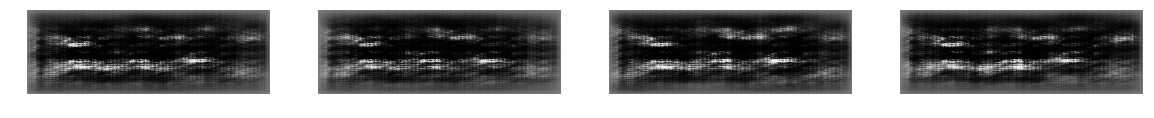

(4, 32, 32, 3)


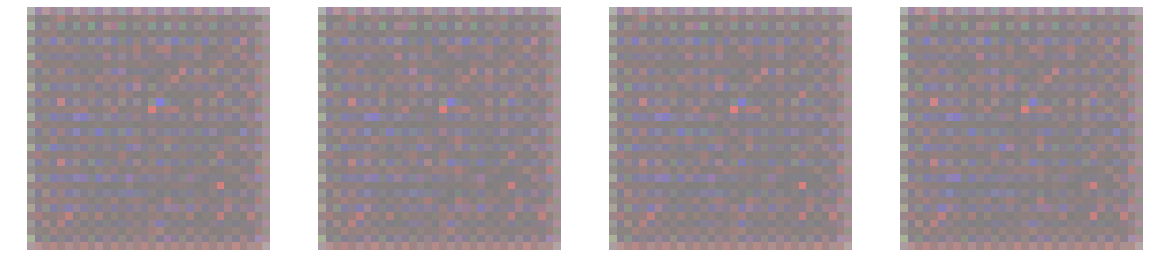

[2/110][700] Loss_D: 1.449795 2.652779 Loss_G: 2.122174 2.067244 loss_cyc 1.163273 3.918
[2/110][725] Loss_D: 0.781770 3.306755 Loss_G: 1.812525 2.547394 loss_cyc 1.127488 4.044
[2/110][750] Loss_D: 1.332526 0.963089 Loss_G: 1.368326 2.387335 loss_cyc 1.135979 4.180
[2/110][775] Loss_D: 1.775539 0.883296 Loss_G: 2.234759 1.975072 loss_cyc 1.110912 4.302
[2/110][800] Loss_D: 1.563485 1.999030 Loss_G: 1.958087 1.942726 loss_cyc 1.099366 4.428
[2/110][825] Loss_D: 0.881934 0.717444 Loss_G: 1.692795 1.491364 loss_cyc 1.102400 4.537
[2/110][850] Loss_D: 0.989985 1.456357 Loss_G: 2.270178 1.744685 loss_cyc 1.039559 4.678
[2/110][875] Loss_D: 0.740801 1.493043 Loss_G: 1.783379 2.519862 loss_cyc 0.995423 4.801
[2/110][900] Loss_D: 0.948169 0.835889 Loss_G: 1.821515 1.466932 loss_cyc 0.983809 4.923
[2/110][925] Loss_D: 0.709084 0.448478 Loss_G: 1.129991 1.376699 loss_cyc 0.981612 5.036
[2/110][950] Loss_D: 0.654123 0.716108 Loss_G: 1.684803 1.694210 loss_cyc 0.987155 5.160
[2/110][975] Loss_D: 

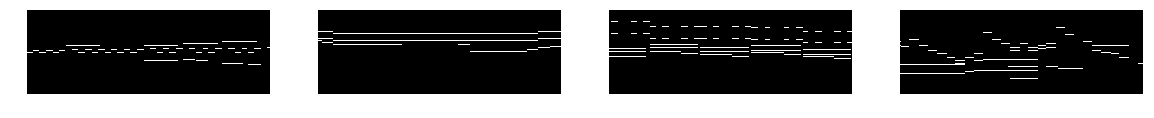

(4, 32, 32, 3)


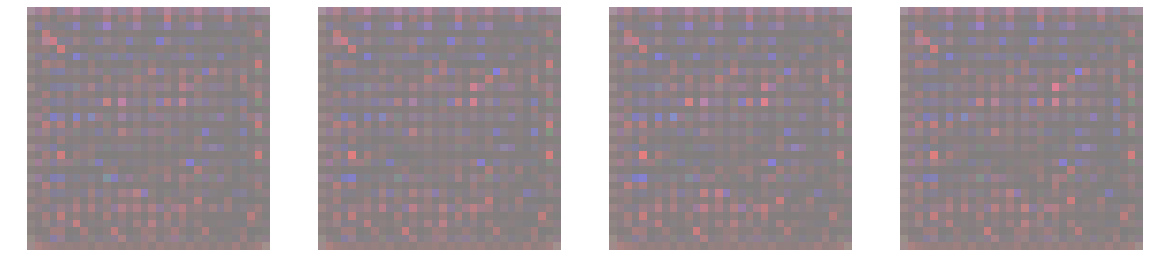

(4, 88, 256, 1)


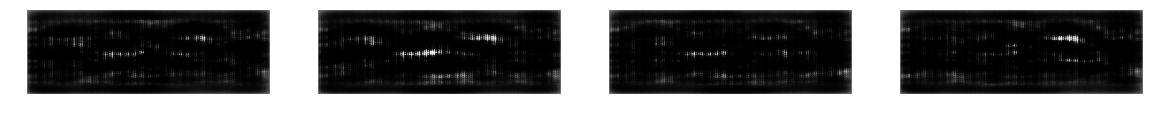

(4, 32, 32, 3)


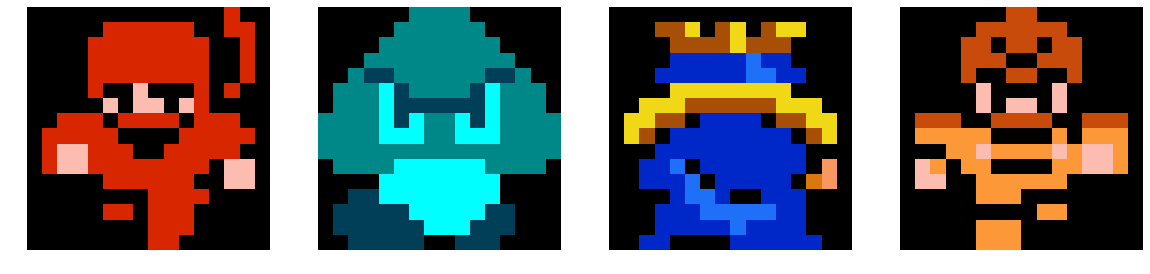

(4, 88, 256, 1)


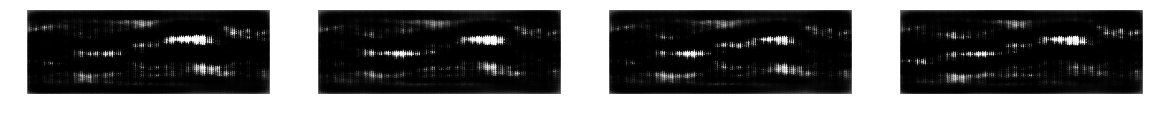

(4, 32, 32, 3)


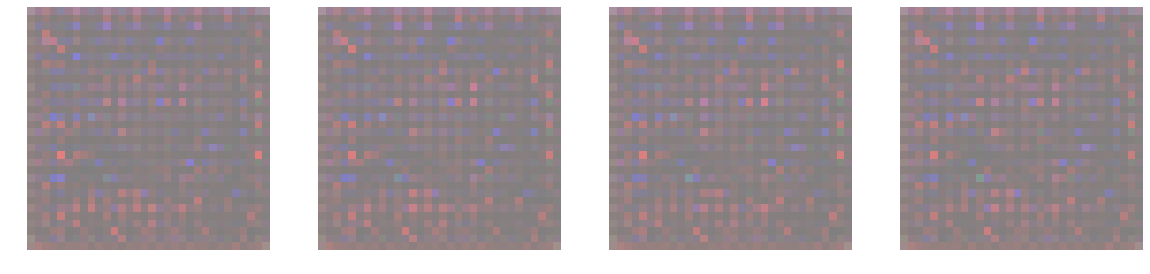

[3/110][1050] Loss_D: 0.710335 0.409041 Loss_G: 2.229224 1.381665 loss_cyc 0.933623 5.707
[3/110][1075] Loss_D: 0.748790 0.648610 Loss_G: 2.121622 1.421587 loss_cyc 0.949082 5.828
[3/110][1100] Loss_D: 0.611671 0.382866 Loss_G: 1.361539 1.588850 loss_cyc 0.983927 5.950
[3/110][1125] Loss_D: 0.898178 0.754012 Loss_G: 2.008749 1.305642 loss_cyc 0.911117 6.073
[3/110][1150] Loss_D: 0.693110 0.440888 Loss_G: 1.521176 1.212756 loss_cyc 0.898547 6.212
[3/110][1175] Loss_D: 0.711525 0.468769 Loss_G: 2.096498 1.449569 loss_cyc 0.901595 6.336
[3/110][1200] Loss_D: 0.663148 0.423300 Loss_G: 1.774815 1.394461 loss_cyc 0.886313 6.455
[3/110][1225] Loss_D: 0.602696 0.333845 Loss_G: 1.740016 1.358976 loss_cyc 0.879537 6.574
[3/110][1250] Loss_D: 1.141748 0.164319 Loss_G: 1.848268 1.193183 loss_cyc 0.895649 6.696
[3/110][1275] Loss_D: 0.609068 0.232674 Loss_G: 1.944998 1.412455 loss_cyc 0.942472 6.826
[3/110][1300] Loss_D: 0.667176 0.568203 Loss_G: 2.060376 1.243086 loss_cyc 0.918079 6.954
[3/110][13

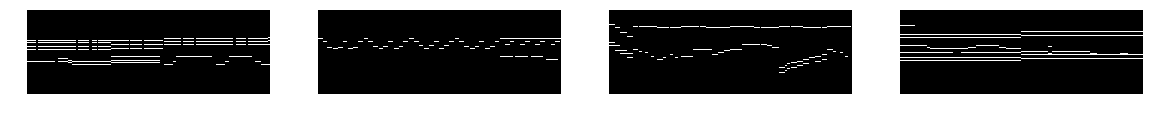

(4, 32, 32, 3)


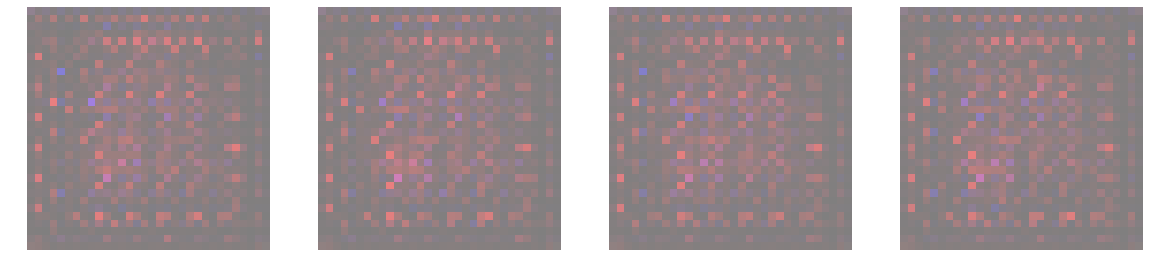

(4, 88, 256, 1)


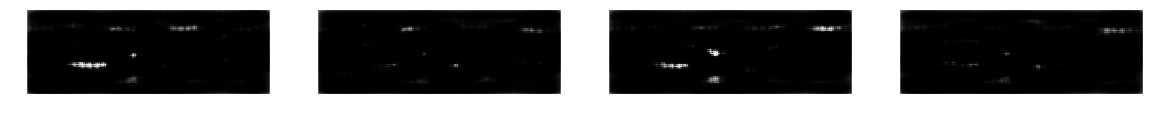

(4, 32, 32, 3)


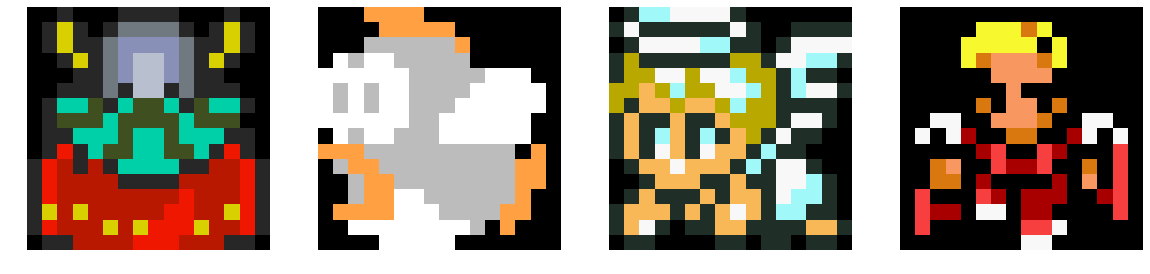

(4, 88, 256, 1)


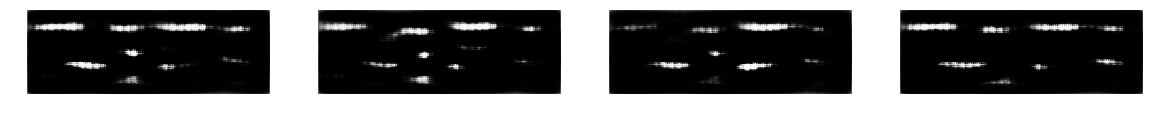

(4, 32, 32, 3)


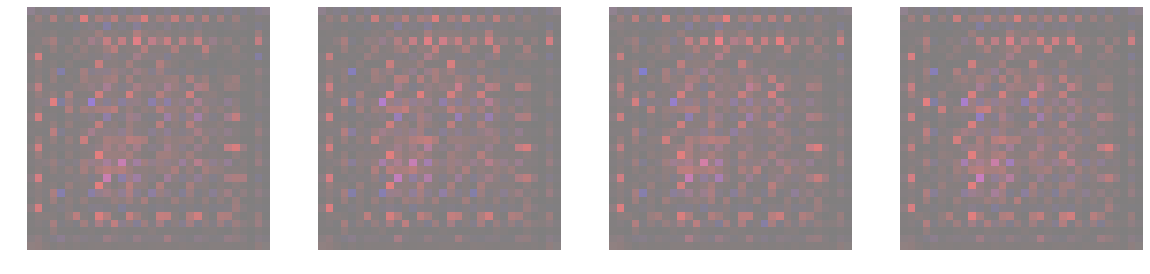

[4/110][1400] Loss_D: 0.424162 0.268560 Loss_G: 1.212797 1.152541 loss_cyc 0.869358 7.492
[4/110][1425] Loss_D: 0.348462 0.208922 Loss_G: 1.377727 1.231843 loss_cyc 0.878023 7.626
[4/110][1450] Loss_D: 0.665266 0.177678 Loss_G: 1.474932 1.130745 loss_cyc 0.864704 7.751
[4/110][1475] Loss_D: 0.448957 0.342162 Loss_G: 1.542514 1.408552 loss_cyc 0.883430 7.886
[4/110][1500] Loss_D: 0.970247 0.184949 Loss_G: 3.340495 1.200587 loss_cyc 0.896120 8.005
[4/110][1525] Loss_D: 0.507321 0.306081 Loss_G: 1.340407 1.250144 loss_cyc 0.889242 8.134
[4/110][1550] Loss_D: 0.328269 0.401500 Loss_G: 1.231058 1.302303 loss_cyc 0.885622 8.249
[4/110][1575] Loss_D: 0.503807 0.232460 Loss_G: 1.327769 1.175220 loss_cyc 0.865929 8.365
[4/110][1600] Loss_D: 0.459775 0.255484 Loss_G: 1.308037 1.122439 loss_cyc 0.875068 8.496
[4/110][1625] Loss_D: 0.474695 0.330753 Loss_G: 1.295823 1.196255 loss_cyc 0.857629 8.614
[4/110][1650] Loss_D: 0.513412 0.256466 Loss_G: 1.438959 1.226294 loss_cyc 0.867426 8.739
[4/110][16

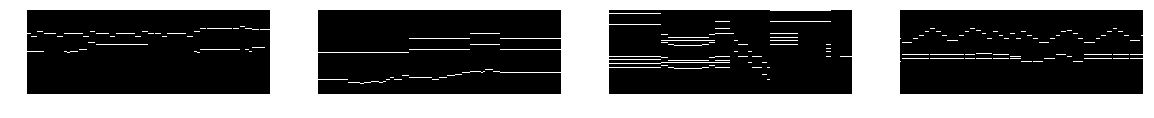

(4, 32, 32, 3)


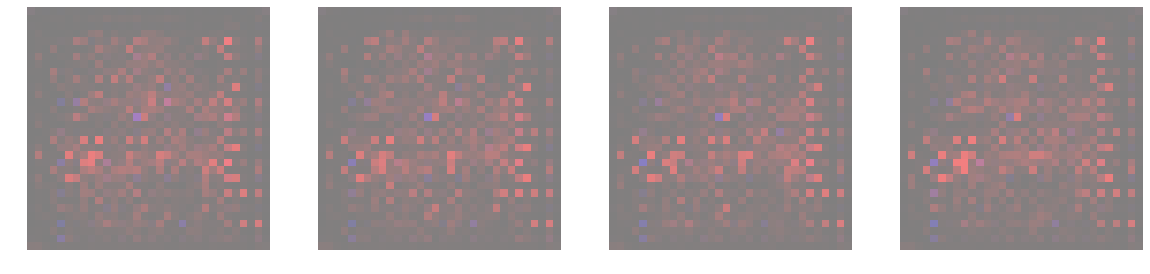

(4, 88, 256, 1)


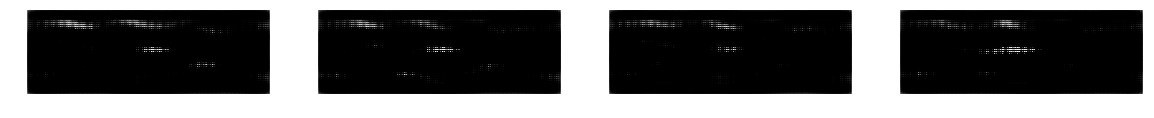

(4, 32, 32, 3)


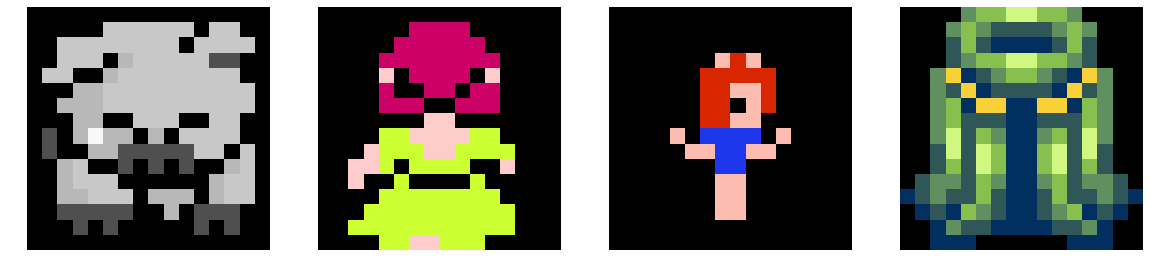

(4, 88, 256, 1)


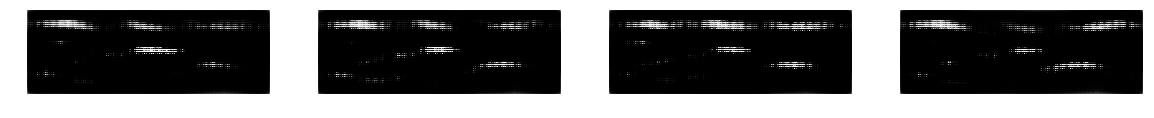

(4, 32, 32, 3)


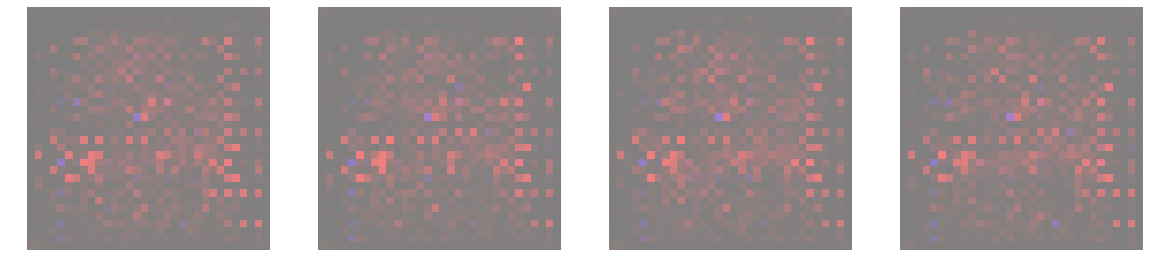

[5/110][1750] Loss_D: 0.887677 0.187088 Loss_G: 2.609849 1.123559 loss_cyc 0.877453 9.281
[5/110][1775] Loss_D: 0.616860 0.171284 Loss_G: 1.155398 1.206254 loss_cyc 0.873722 9.415
[5/110][1800] Loss_D: 0.443171 0.082043 Loss_G: 1.181851 1.163474 loss_cyc 0.873549 9.553
[5/110][1825] Loss_D: 0.469546 0.166027 Loss_G: 1.170766 1.140555 loss_cyc 0.849492 9.679
[5/110][1850] Loss_D: 0.638435 0.235869 Loss_G: 1.888314 1.404068 loss_cyc 0.890696 9.799
[5/110][1875] Loss_D: 0.504123 0.252522 Loss_G: 1.914518 1.283753 loss_cyc 0.869109 9.913
[5/110][1900] Loss_D: 0.460446 0.093284 Loss_G: 1.326270 1.230745 loss_cyc 0.852134 10.036
[5/110][1925] Loss_D: 0.501099 0.129499 Loss_G: 1.314341 1.110365 loss_cyc 0.871310 10.155
[5/110][1950] Loss_D: 0.506948 0.143911 Loss_G: 0.987944 1.203789 loss_cyc 0.862146 10.277
[5/110][1975] Loss_D: 0.380481 0.106186 Loss_G: 1.230936 1.086285 loss_cyc 0.862472 10.389
[5/110][2000] Loss_D: 0.514295 0.116412 Loss_G: 1.606005 1.036458 loss_cyc 0.895853 10.512
[5/11

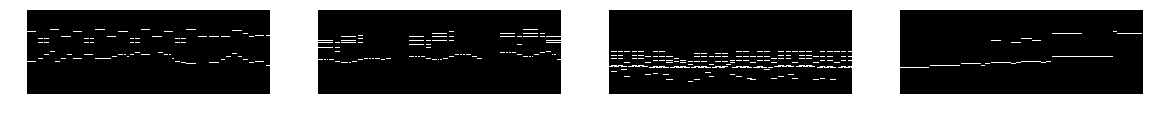

(4, 32, 32, 3)


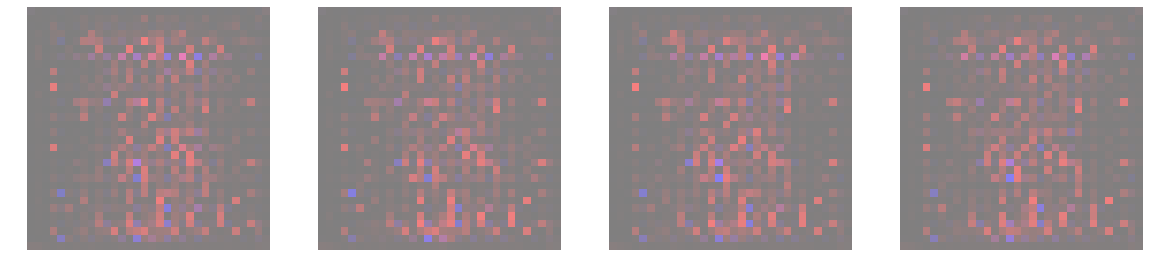

(4, 88, 256, 1)


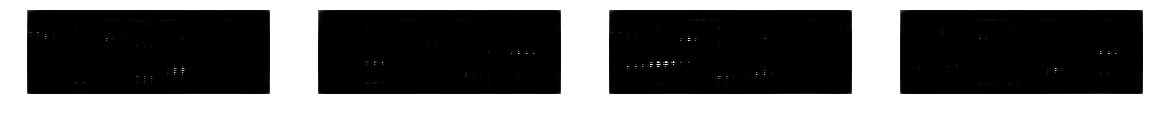

(4, 32, 32, 3)


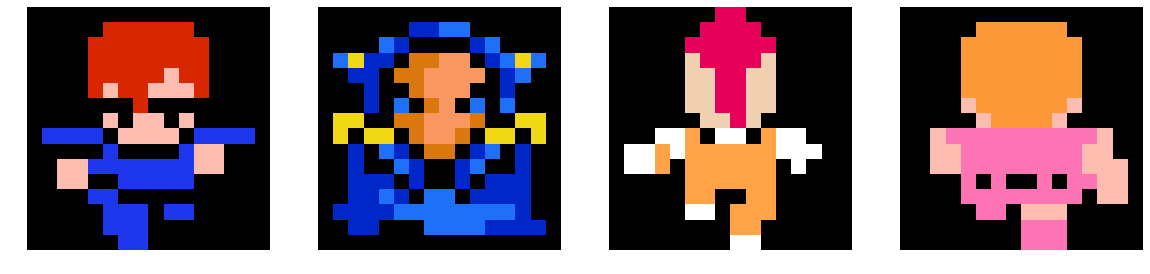

(4, 88, 256, 1)


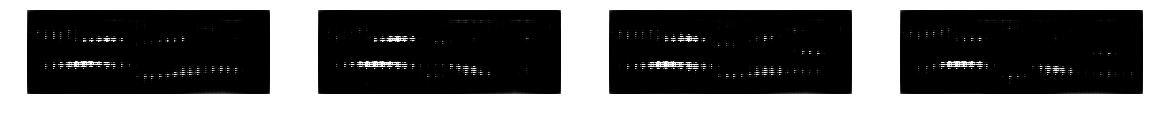

(4, 32, 32, 3)


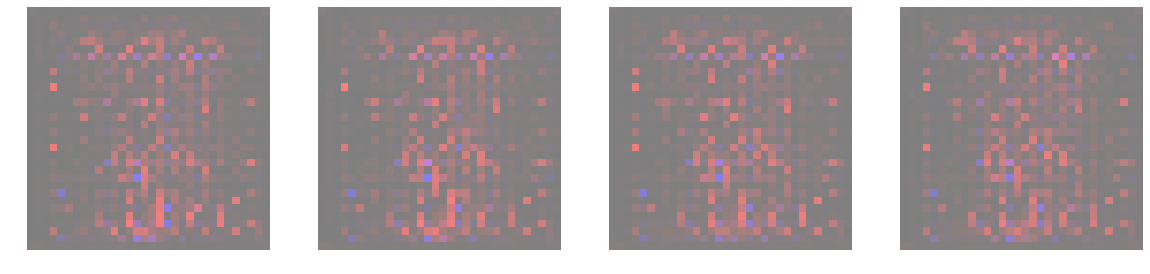

[6/110][2100] Loss_D: 0.378800 0.281932 Loss_G: 1.256754 1.159115 loss_cyc 0.847139 11.059
[6/110][2125] Loss_D: 0.382394 0.214661 Loss_G: 1.223272 1.138547 loss_cyc 0.854799 11.182
[6/110][2150] Loss_D: 0.394702 0.102437 Loss_G: 1.259905 1.104390 loss_cyc 0.851761 11.317
[6/110][2175] Loss_D: 0.456320 0.076934 Loss_G: 1.138910 1.042382 loss_cyc 0.868858 11.431
[6/110][2200] Loss_D: 0.269961 0.073368 Loss_G: 1.242578 1.059639 loss_cyc 0.894148 11.554
[6/110][2225] Loss_D: 0.293644 0.088876 Loss_G: 1.427808 1.131407 loss_cyc 0.846043 11.672
[6/110][2250] Loss_D: 0.354571 0.193105 Loss_G: 1.303676 1.073185 loss_cyc 0.836325 11.792
[6/110][2275] Loss_D: 0.291243 0.151914 Loss_G: 1.230657 1.129736 loss_cyc 0.864170 11.916
[6/110][2300] Loss_D: 0.163973 0.180879 Loss_G: 1.088919 1.103433 loss_cyc 0.865134 12.049
[6/110][2325] Loss_D: 0.303099 0.169224 Loss_G: 1.262292 1.209235 loss_cyc 0.869669 12.170
[6/110][2350] Loss_D: 0.303788 0.083017 Loss_G: 1.070338 1.090955 loss_cyc 0.863197 12.303

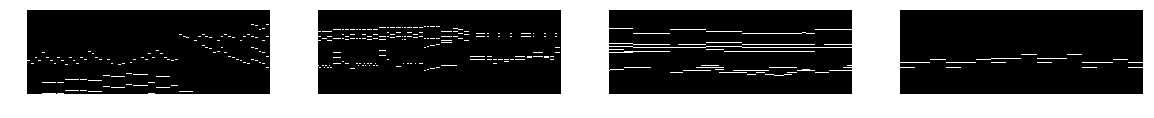

(4, 32, 32, 3)


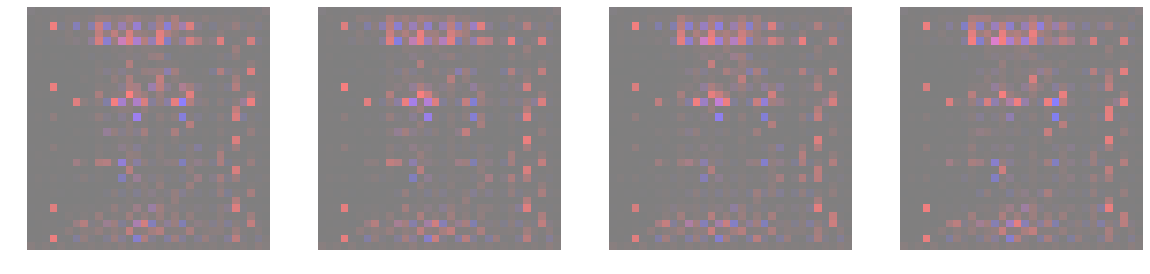

(4, 88, 256, 1)


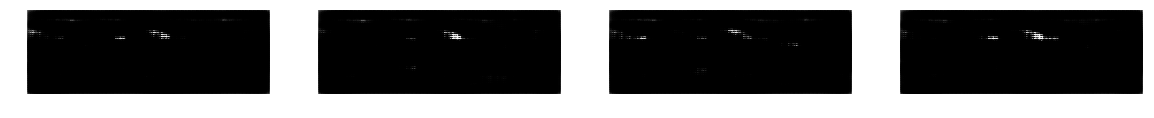

(4, 32, 32, 3)


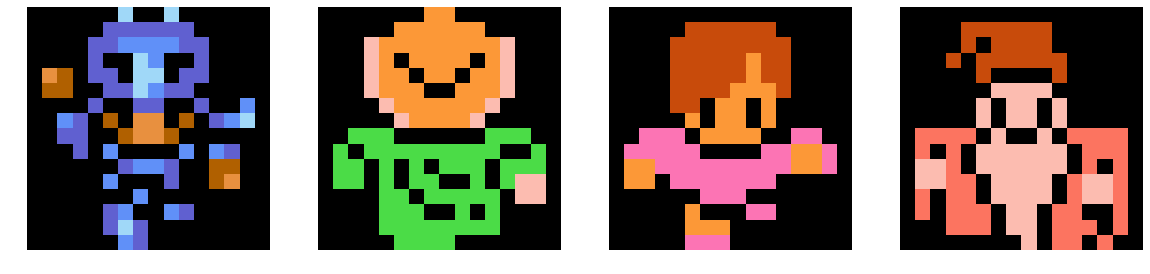

(4, 88, 256, 1)


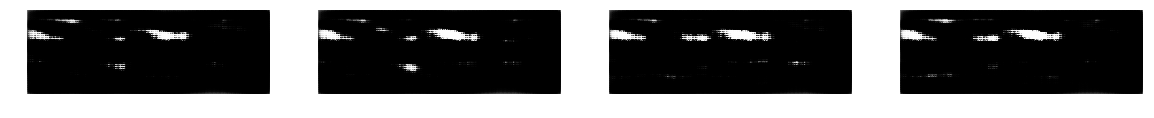

(4, 32, 32, 3)


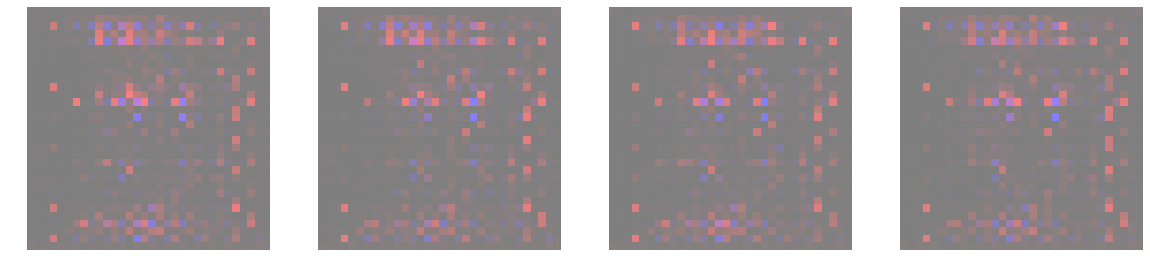

[7/110][2450] Loss_D: 0.207090 0.130558 Loss_G: 1.228828 1.208012 loss_cyc 0.871722 12.831
[7/110][2475] Loss_D: 0.323995 0.089072 Loss_G: 1.187503 1.037992 loss_cyc 0.860300 12.954
[7/110][2500] Loss_D: 0.422219 0.191315 Loss_G: 1.339137 1.097702 loss_cyc 0.839667 13.080
[7/110][2525] Loss_D: 0.432391 0.071037 Loss_G: 1.378667 1.127514 loss_cyc 0.867973 13.195
[7/110][2550] Loss_D: 0.492661 0.152081 Loss_G: 2.100842 1.167746 loss_cyc 0.870792 13.319
[7/110][2575] Loss_D: 0.425560 0.089253 Loss_G: 1.180671 1.088802 loss_cyc 0.850630 13.444
[7/110][2600] Loss_D: 0.274095 0.191330 Loss_G: 0.985667 1.192581 loss_cyc 0.867910 13.562
[7/110][2625] Loss_D: 0.345525 0.078213 Loss_G: 1.364666 1.108878 loss_cyc 0.852588 13.689
[7/110][2650] Loss_D: 0.377211 0.086335 Loss_G: 1.472329 1.159539 loss_cyc 0.864588 13.820
[7/110][2675] Loss_D: 0.336565 0.071650 Loss_G: 1.483525 1.073558 loss_cyc 0.859057 13.934
[7/110][2700] Loss_D: 0.358329 0.127370 Loss_G: 1.541897 1.185454 loss_cyc 0.854586 14.057

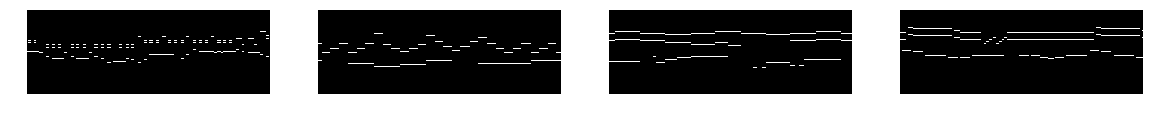

(4, 32, 32, 3)


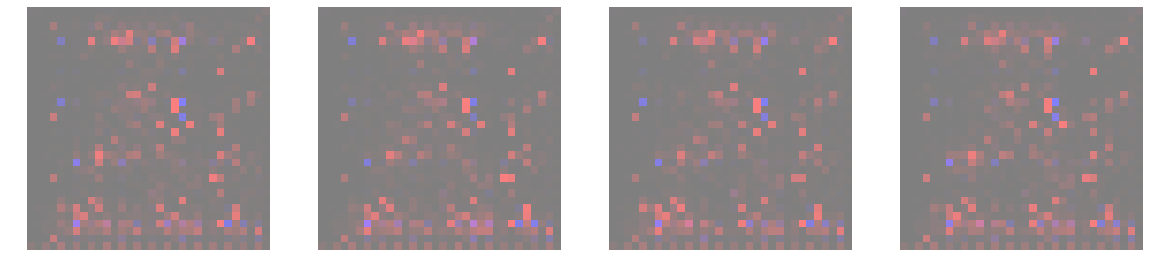

(4, 88, 256, 1)


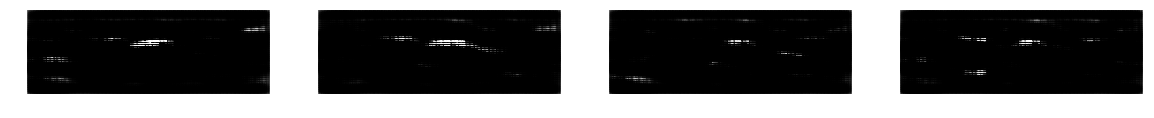

(4, 32, 32, 3)


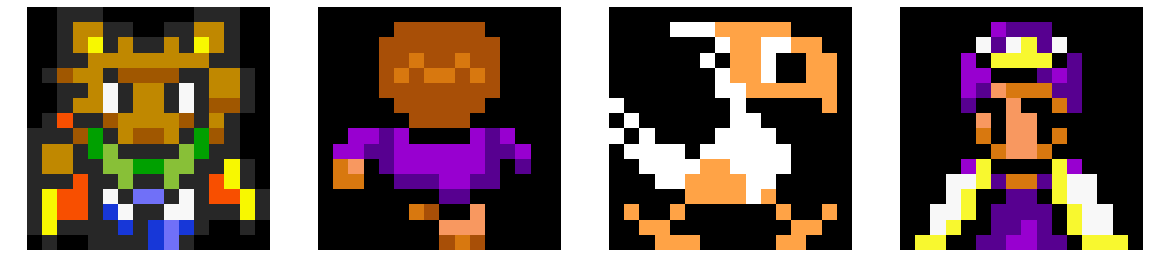

(4, 88, 256, 1)


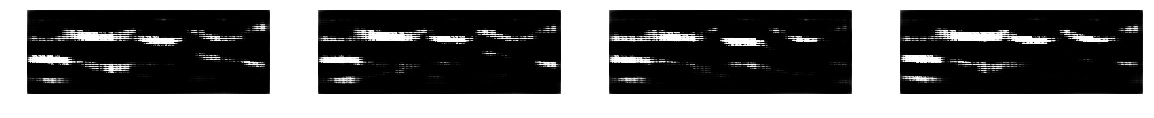

(4, 32, 32, 3)


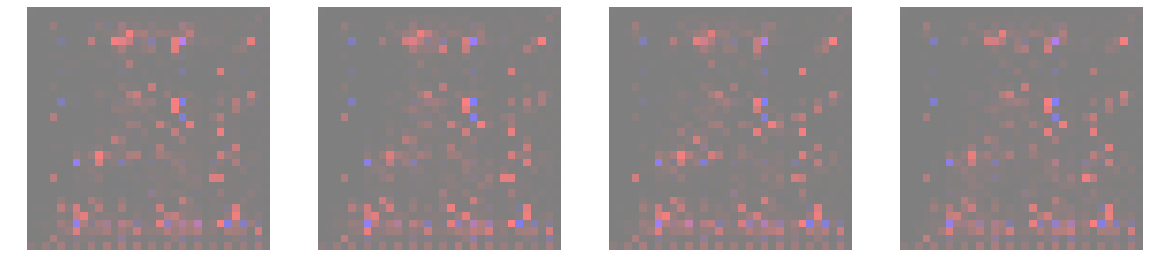

[8/110][2800] Loss_D: 0.215176 0.260045 Loss_G: 1.193993 1.242753 loss_cyc 0.880789 14.601
[8/110][2825] Loss_D: 0.287601 0.190980 Loss_G: 1.271456 1.144322 loss_cyc 0.861634 14.724
[8/110][2850] Loss_D: 0.242801 0.142873 Loss_G: 1.112182 1.154145 loss_cyc 0.854640 14.854
[8/110][2875] Loss_D: 0.257307 0.419638 Loss_G: 1.230830 1.200462 loss_cyc 0.881577 14.980
[8/110][2900] Loss_D: 0.219005 0.114800 Loss_G: 1.171477 1.113063 loss_cyc 0.856187 15.088
[8/110][2925] Loss_D: 0.215967 0.088777 Loss_G: 1.018904 1.140081 loss_cyc 0.847645 15.203
[8/110][2950] Loss_D: 0.218967 0.067631 Loss_G: 1.153065 1.248253 loss_cyc 0.870731 15.327
[8/110][2975] Loss_D: 0.359229 0.410166 Loss_G: 1.519309 1.774947 loss_cyc 0.849812 15.455
[8/110][3000] Loss_D: 0.409732 0.110564 Loss_G: 1.308839 1.178708 loss_cyc 0.850483 15.578
[8/110][3025] Loss_D: 0.315747 0.233356 Loss_G: 1.275807 1.586611 loss_cyc 0.863424 15.712
[8/110][3050] Loss_D: 0.247694 0.632958 Loss_G: 1.342859 2.259698 loss_cyc 0.856092 15.841

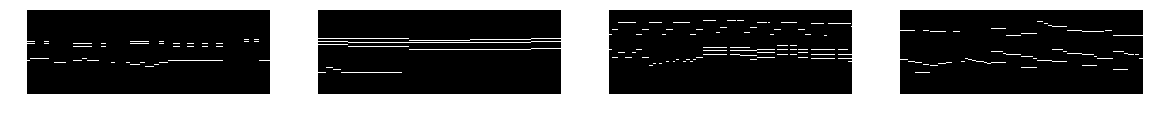

(4, 32, 32, 3)


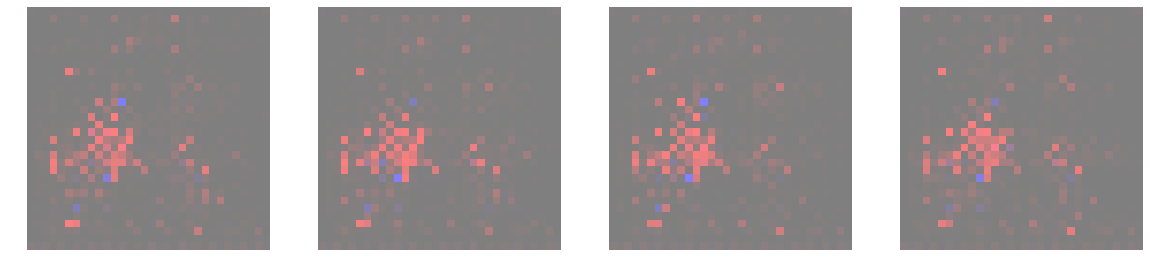

(4, 88, 256, 1)


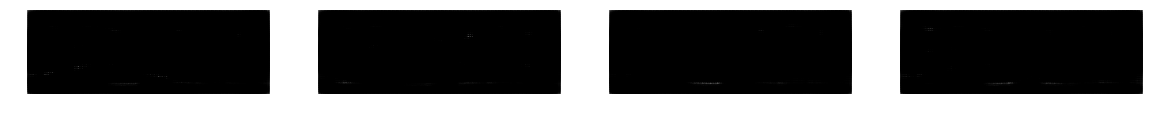

(4, 32, 32, 3)


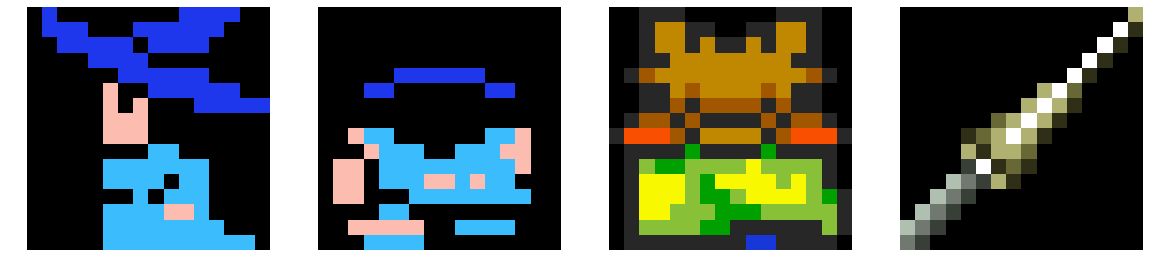

(4, 88, 256, 1)


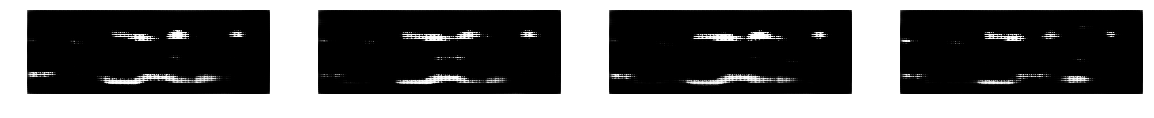

(4, 32, 32, 3)


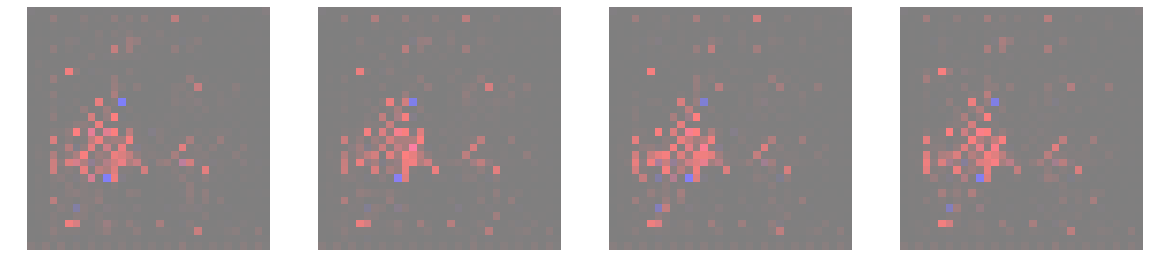

[9/110][3150] Loss_D: 0.368610 0.105388 Loss_G: 1.337461 1.063442 loss_cyc 0.849377 16.384
[9/110][3175] Loss_D: 0.262928 0.053926 Loss_G: 1.398675 1.025706 loss_cyc 0.824553 16.502
[9/110][3200] Loss_D: 0.281433 0.218210 Loss_G: 1.158987 1.264428 loss_cyc 0.845866 16.633
[9/110][3225] Loss_D: 0.160171 0.116837 Loss_G: 1.110906 1.183691 loss_cyc 0.827926 16.754
[9/110][3250] Loss_D: 0.216268 0.125772 Loss_G: 1.160763 1.236757 loss_cyc 0.839211 16.879
[9/110][3275] Loss_D: 0.151616 0.072993 Loss_G: 1.145597 1.100619 loss_cyc 0.875480 16.994
[9/110][3300] Loss_D: 0.157783 0.034643 Loss_G: 1.055819 1.095661 loss_cyc 0.840496 17.116
[9/110][3325] Loss_D: 0.141218 0.043835 Loss_G: 1.050331 1.032498 loss_cyc 0.850208 17.239
[9/110][3350] Loss_D: 0.199071 0.045481 Loss_G: 1.050535 0.999679 loss_cyc 0.860981 17.363
[9/110][3375] Loss_D: 0.190266 0.079884 Loss_G: 1.093024 1.086139 loss_cyc 0.840714 17.497
[9/110][3400] Loss_D: 0.238568 0.071825 Loss_G: 1.240636 1.036487 loss_cyc 0.856489 17.608

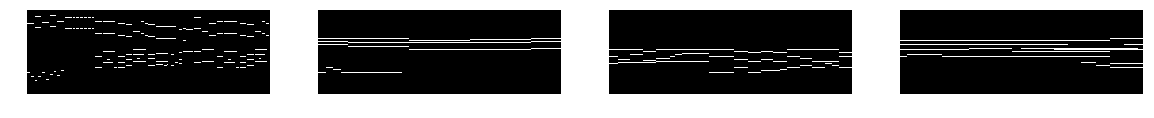

(4, 32, 32, 3)


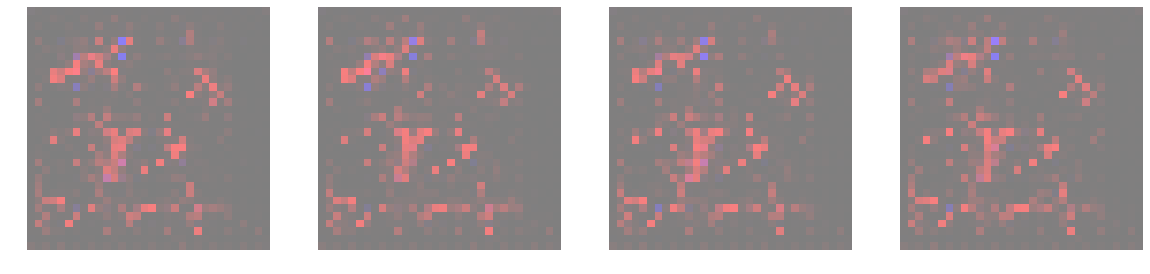

(4, 88, 256, 1)


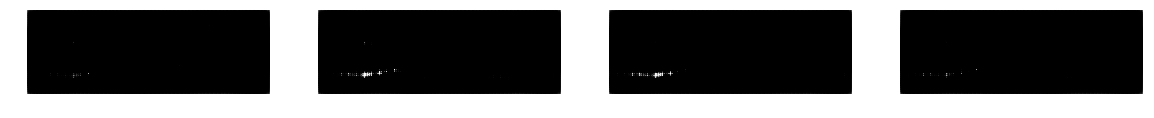

(4, 32, 32, 3)


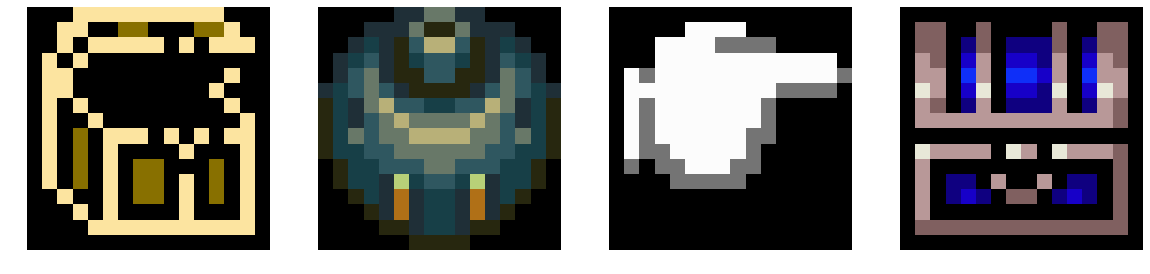

(4, 88, 256, 1)


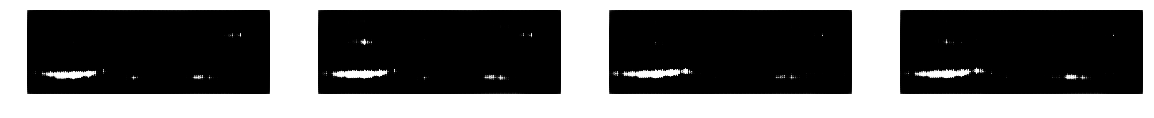

(4, 32, 32, 3)


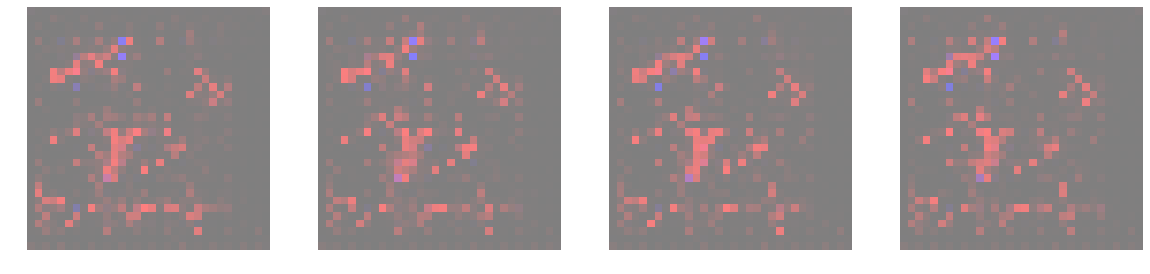

[10/110][3475] Loss_D: 0.247315 0.043929 Loss_G: 1.050760 1.034181 loss_cyc 0.854128 18.048
[10/110][3500] Loss_D: 0.152972 0.030078 Loss_G: 1.116848 1.070453 loss_cyc 0.868041 18.172
[10/110][3525] Loss_D: 0.277209 0.047382 Loss_G: 1.197408 1.039493 loss_cyc 0.868640 18.305
[10/110][3550] Loss_D: 0.241854 0.039099 Loss_G: 1.055600 1.080540 loss_cyc 0.871386 18.431
[10/110][3575] Loss_D: 0.205069 0.120295 Loss_G: 0.985507 1.120173 loss_cyc 0.878298 18.566
[10/110][3600] Loss_D: 0.177483 0.048342 Loss_G: 1.109419 1.040632 loss_cyc 0.836134 18.684
[10/110][3625] Loss_D: 0.241296 0.066605 Loss_G: 1.077438 1.067964 loss_cyc 0.890815 18.806
[10/110][3650] Loss_D: 0.235959 0.060182 Loss_G: 1.139706 1.054460 loss_cyc 0.875498 18.921
[10/110][3675] Loss_D: 0.239249 0.049775 Loss_G: 1.018619 1.020817 loss_cyc 0.840898 19.038
[10/110][3700] Loss_D: 0.288427 0.062010 Loss_G: 1.321704 1.034298 loss_cyc 0.847749 19.171
[10/110][3725] Loss_D: 0.272481 0.072135 Loss_G: 1.081494 1.071252 loss_cyc 0.85

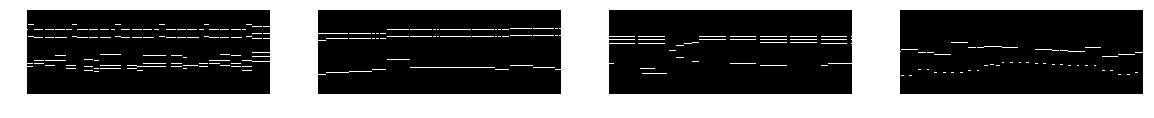

(4, 32, 32, 3)


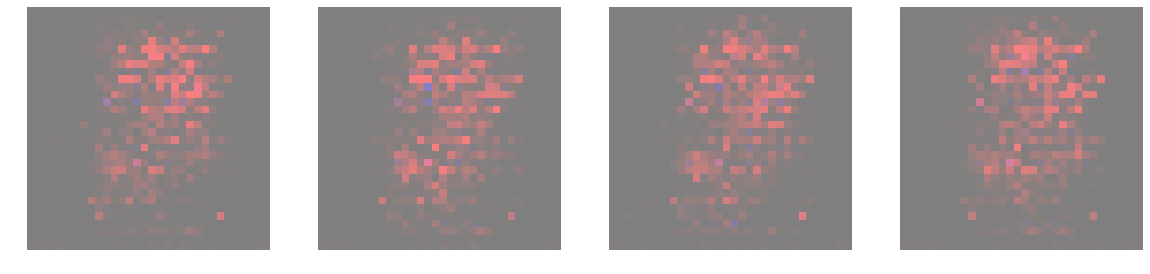

(4, 88, 256, 1)


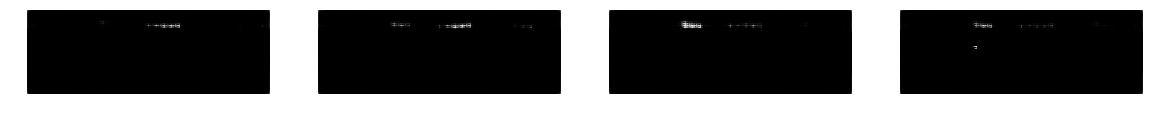

(4, 32, 32, 3)


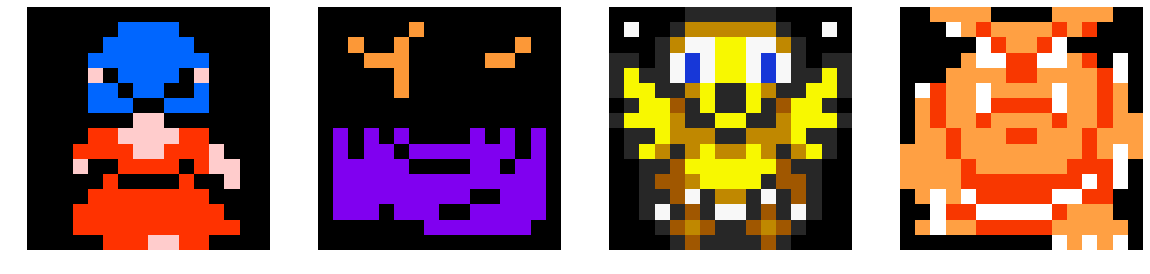

(4, 88, 256, 1)


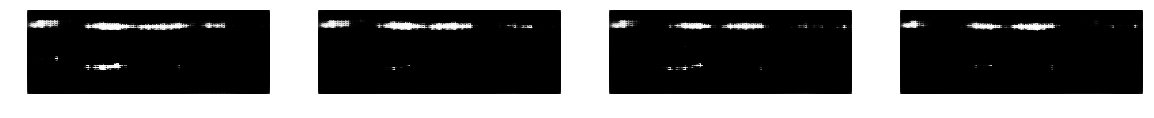

(4, 32, 32, 3)


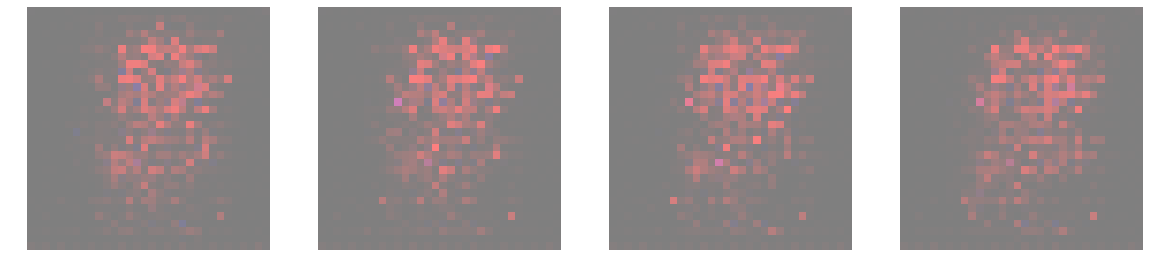

[11/110][3825] Loss_D: 0.180004 0.026187 Loss_G: 1.303933 1.026626 loss_cyc 0.833172 19.824
[11/110][3850] Loss_D: 0.262205 0.068967 Loss_G: 1.102119 1.057459 loss_cyc 0.866554 19.955
[11/110][3875] Loss_D: 0.385974 0.067394 Loss_G: 1.432902 1.017595 loss_cyc 0.845031 20.085
[11/110][3900] Loss_D: 0.234730 0.031895 Loss_G: 1.080626 1.056531 loss_cyc 0.853018 20.209
[11/110][3925] Loss_D: 0.113205 0.057032 Loss_G: 1.098168 1.038333 loss_cyc 0.832685 20.335
[11/110][3950] Loss_D: 0.127488 0.094531 Loss_G: 0.997382 1.087073 loss_cyc 0.848933 20.476
[11/110][3975] Loss_D: 0.254469 0.094833 Loss_G: 1.197782 1.078764 loss_cyc 0.856730 20.590
[11/110][4000] Loss_D: 0.224715 0.082834 Loss_G: 1.119311 1.083385 loss_cyc 0.865087 20.716
[11/110][4025] Loss_D: 0.186095 0.080035 Loss_G: 1.484592 1.117100 loss_cyc 0.867030 20.836
[11/110][4050] Loss_D: 0.214760 0.200085 Loss_G: 1.426412 1.266306 loss_cyc 0.865843 20.954
[11/110][4075] Loss_D: 0.268284 0.032835 Loss_G: 1.069309 1.039670 loss_cyc 0.83

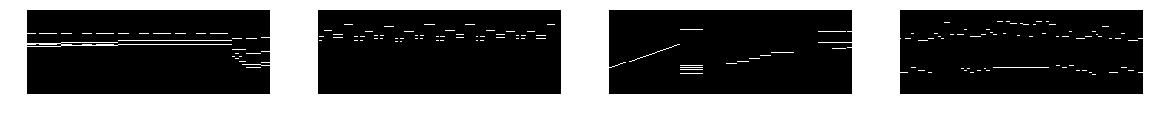

(4, 32, 32, 3)


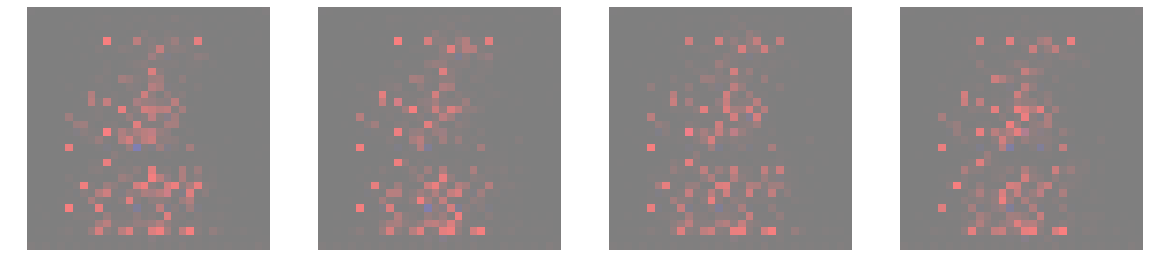

(4, 88, 256, 1)


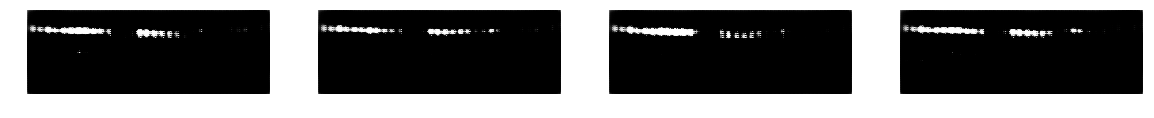

(4, 32, 32, 3)


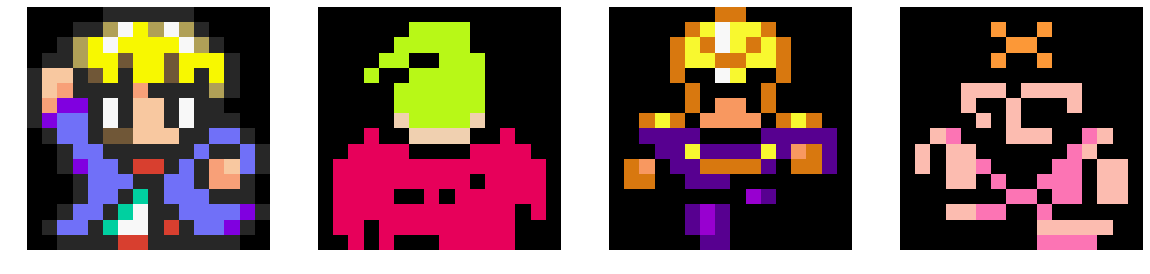

(4, 88, 256, 1)


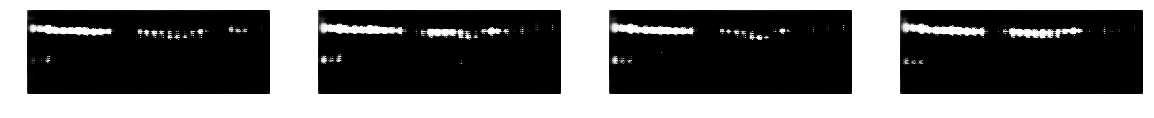

(4, 32, 32, 3)


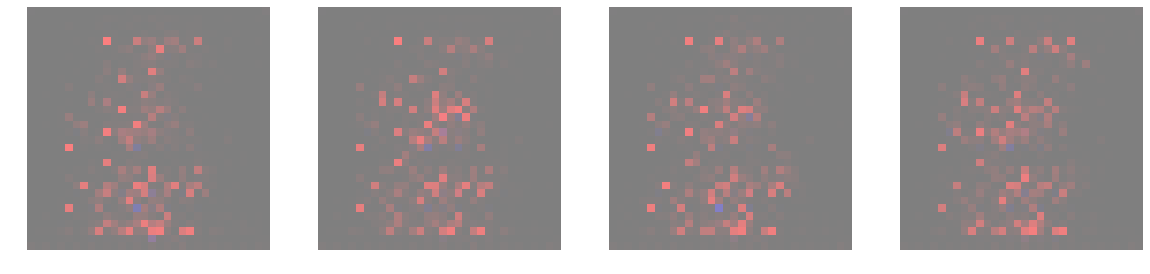

[12/110][4175] Loss_D: 0.216339 0.178927 Loss_G: 0.980025 1.164240 loss_cyc 0.868800 21.612
[12/110][4200] Loss_D: 0.128787 0.057900 Loss_G: 1.009813 1.070893 loss_cyc 0.851433 21.741
[12/110][4225] Loss_D: 0.165606 0.049861 Loss_G: 0.988263 1.029177 loss_cyc 0.897337 21.859
[12/110][4250] Loss_D: 0.096189 0.063339 Loss_G: 1.019516 1.064437 loss_cyc 0.867440 21.982
[12/110][4275] Loss_D: 0.219291 0.047362 Loss_G: 1.322233 1.049586 loss_cyc 0.842812 22.097
[12/110][4300] Loss_D: 0.214133 0.048685 Loss_G: 1.101583 1.028576 loss_cyc 0.838360 22.214
[12/110][4325] Loss_D: 0.427286 0.058286 Loss_G: 1.175326 1.043476 loss_cyc 0.865346 22.336
[12/110][4350] Loss_D: 0.233293 0.078939 Loss_G: 1.230585 1.079288 loss_cyc 0.872865 22.454
[12/110][4375] Loss_D: 0.278552 0.043135 Loss_G: 1.614524 1.040705 loss_cyc 0.841354 22.593
[12/110][4400] Loss_D: 0.217717 0.042263 Loss_G: 1.193645 1.066001 loss_cyc 0.871820 22.722
[12/110][4425] Loss_D: 0.184158 0.031200 Loss_G: 1.109744 1.026369 loss_cyc 0.85

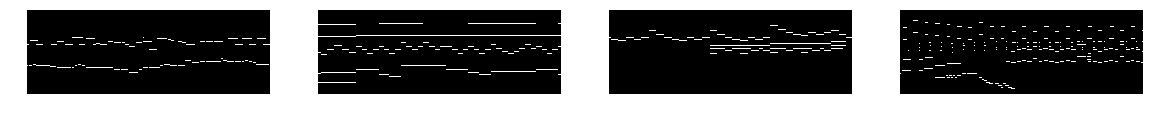

(4, 32, 32, 3)


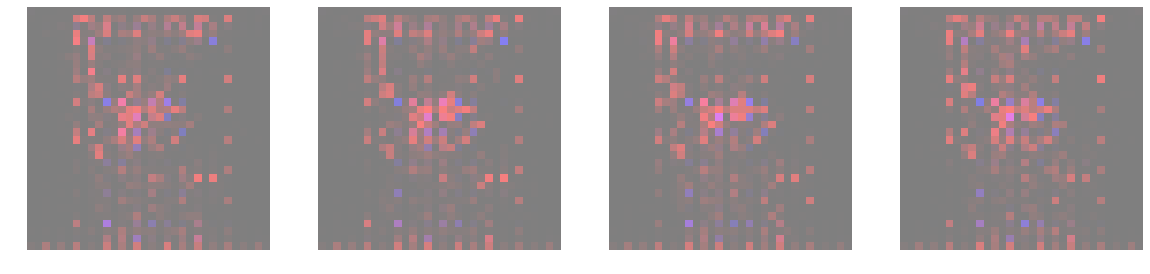

(4, 88, 256, 1)


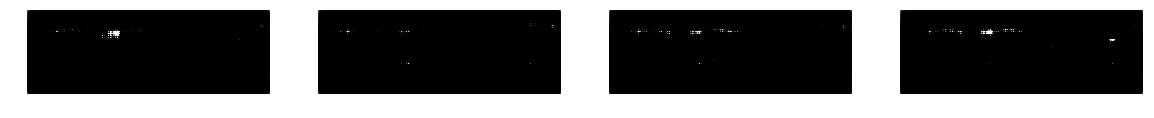

(4, 32, 32, 3)


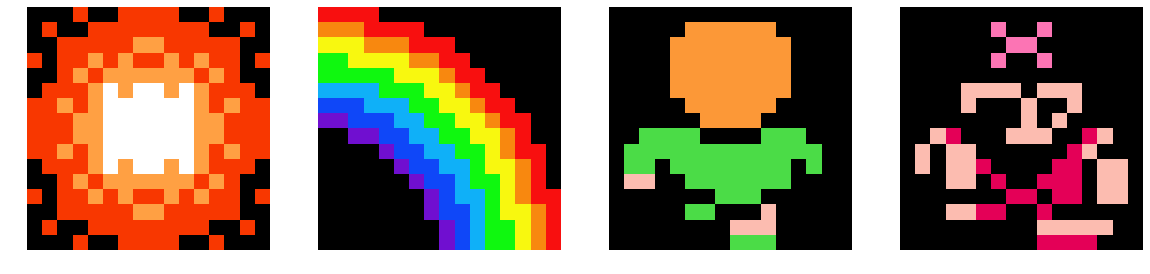

(4, 88, 256, 1)


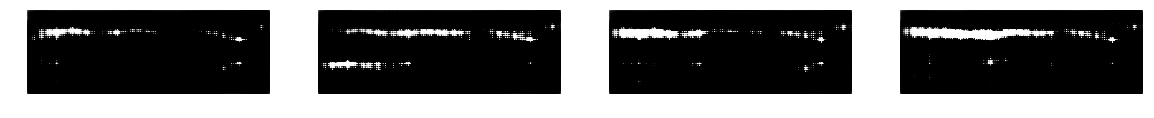

(4, 32, 32, 3)


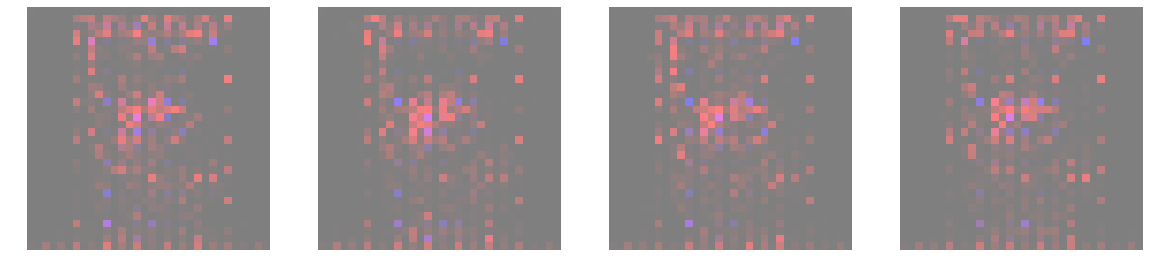

[13/110][4525] Loss_D: 0.136665 0.119519 Loss_G: 1.091794 1.104795 loss_cyc 0.886458 23.386
[13/110][4550] Loss_D: 0.147942 0.030935 Loss_G: 0.977666 1.036578 loss_cyc 0.850471 23.504
[13/110][4575] Loss_D: 0.105061 0.039450 Loss_G: 1.095416 1.030208 loss_cyc 0.867566 23.621
[13/110][4600] Loss_D: 0.177957 0.034578 Loss_G: 1.116771 1.065248 loss_cyc 0.827322 23.738
[13/110][4625] Loss_D: 0.306307 0.036556 Loss_G: 1.025214 1.032362 loss_cyc 0.873706 23.868
[13/110][4650] Loss_D: 0.291572 0.080007 Loss_G: 1.033251 1.063883 loss_cyc 0.857556 23.980
[13/110][4675] Loss_D: 0.297453 0.040681 Loss_G: 1.095334 1.061111 loss_cyc 0.867383 24.113
[13/110][4700] Loss_D: 0.473015 0.083724 Loss_G: 1.143778 1.058468 loss_cyc 0.857748 24.242
[13/110][4725] Loss_D: 0.337472 0.052481 Loss_G: 1.083125 1.096812 loss_cyc 0.863798 24.360
[13/110][4750] Loss_D: 0.206795 0.036010 Loss_G: 1.365382 1.031825 loss_cyc 0.848017 24.478
[13/110][4775] Loss_D: 0.212724 0.023599 Loss_G: 1.057438 0.999821 loss_cyc 0.87

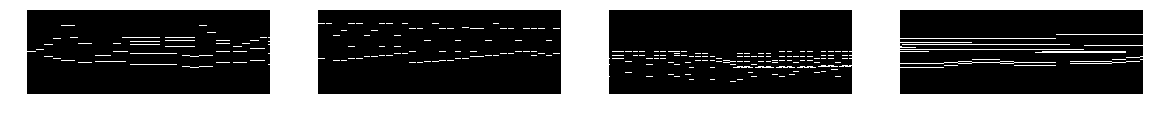

(4, 32, 32, 3)


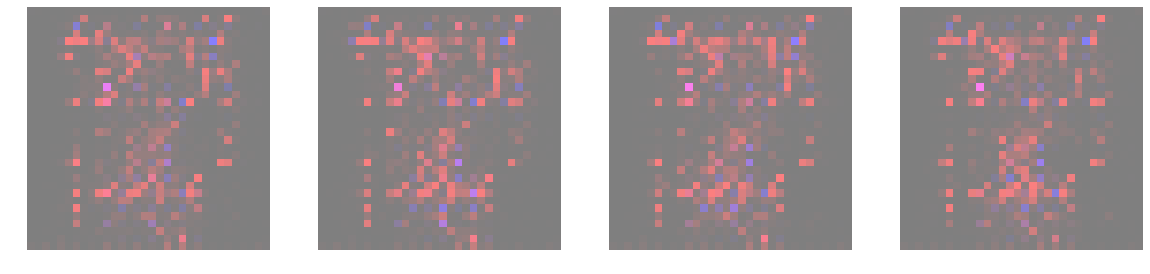

(4, 88, 256, 1)


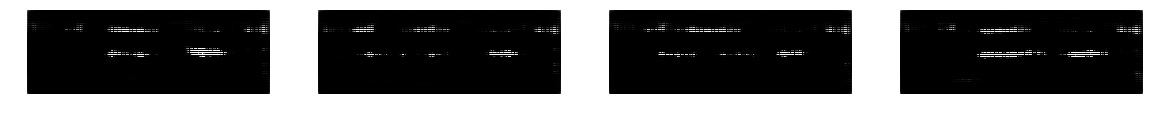

(4, 32, 32, 3)


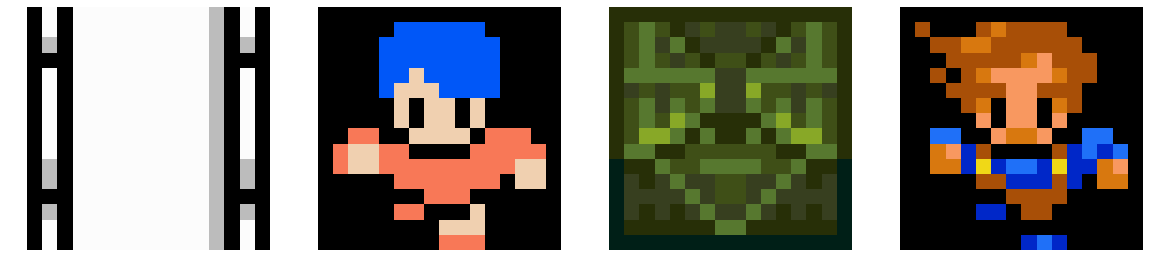

(4, 88, 256, 1)


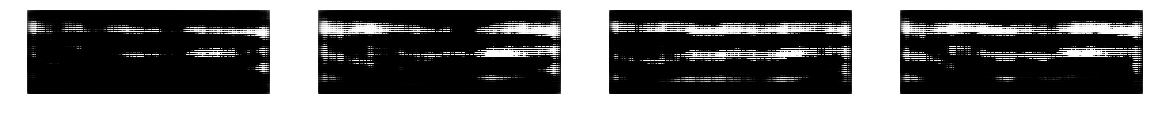

(4, 32, 32, 3)


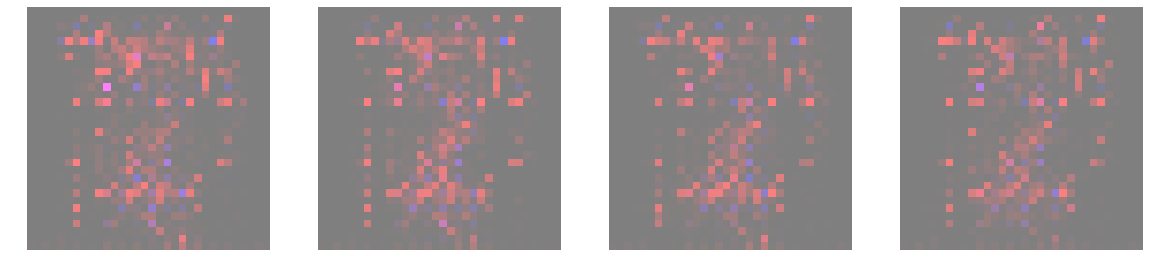

[14/110][4875] Loss_D: 0.286050 0.077643 Loss_G: 1.098615 1.033765 loss_cyc 0.856082 25.148
[14/110][4900] Loss_D: 0.206523 0.070710 Loss_G: 1.006303 1.100028 loss_cyc 0.825204 25.269
[14/110][4925] Loss_D: 0.274147 0.043608 Loss_G: 1.118456 1.025233 loss_cyc 0.845590 25.405
[14/110][4950] Loss_D: 0.242959 0.049557 Loss_G: 1.095985 1.081607 loss_cyc 0.857276 25.518
[14/110][4975] Loss_D: 0.834004 0.291618 Loss_G: 2.882934 1.187003 loss_cyc 0.831995 25.651
[14/110][5000] Loss_D: 0.457093 0.068307 Loss_G: 1.181782 1.066164 loss_cyc 0.863893 25.773
[14/110][5025] Loss_D: 0.227447 0.098414 Loss_G: 1.530847 1.091383 loss_cyc 0.855626 25.887
[14/110][5050] Loss_D: 0.249818 0.097008 Loss_G: 1.236585 1.203768 loss_cyc 0.865080 26.011
[14/110][5075] Loss_D: 0.239837 0.053826 Loss_G: 1.326451 1.019210 loss_cyc 0.854645 26.133
[14/110][5100] Loss_D: 0.387733 0.057122 Loss_G: 1.198360 1.023023 loss_cyc 0.858375 26.265
[14/110][5125] Loss_D: 0.183636 0.048158 Loss_G: 1.002879 1.074760 loss_cyc 0.85

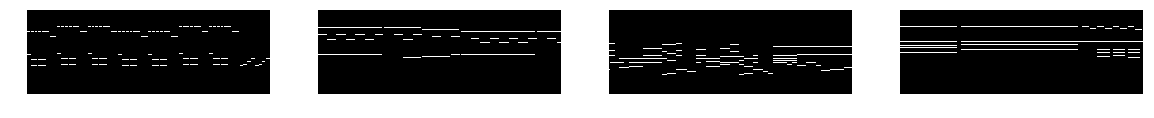

(4, 32, 32, 3)


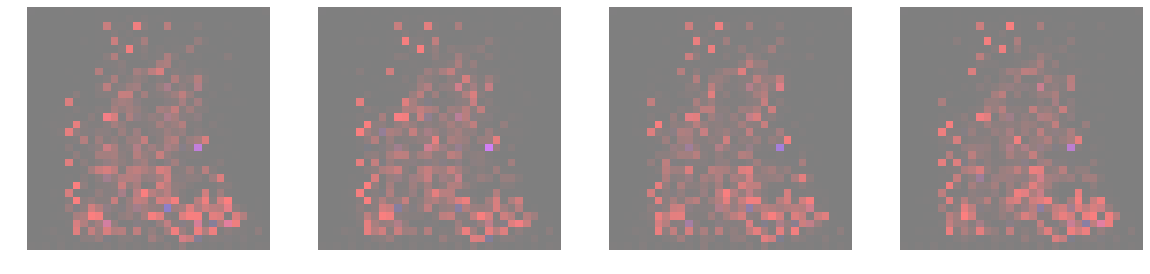

(4, 88, 256, 1)


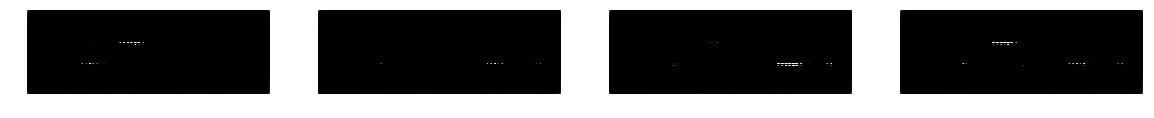

(4, 32, 32, 3)


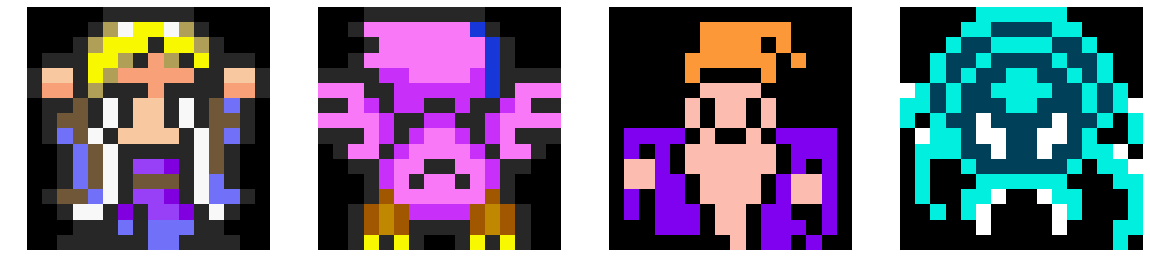

(4, 88, 256, 1)


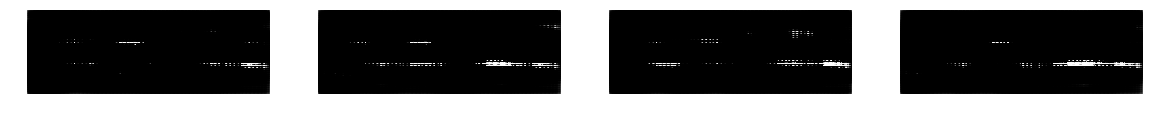

(4, 32, 32, 3)


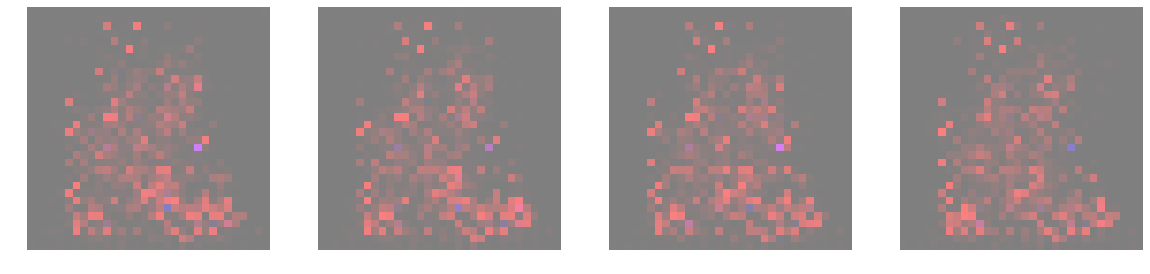

[15/110][5225] Loss_D: 0.161167 0.045533 Loss_G: 1.015311 1.037820 loss_cyc 0.863909 26.927
[15/110][5250] Loss_D: 0.170836 0.052967 Loss_G: 1.033314 1.025522 loss_cyc 0.842386 27.054
[15/110][5275] Loss_D: 0.269866 0.044645 Loss_G: 1.749134 1.020719 loss_cyc 0.862594 27.175
[15/110][5300] Loss_D: 0.163809 0.018247 Loss_G: 1.136456 1.064175 loss_cyc 0.862274 27.302
[15/110][5325] Loss_D: 0.126979 0.072280 Loss_G: 1.078591 1.038044 loss_cyc 0.864628 27.424
[15/110][5350] Loss_D: 0.119807 0.031924 Loss_G: 1.130954 1.017687 loss_cyc 0.845660 27.543
[15/110][5375] Loss_D: 0.124112 0.015204 Loss_G: 1.199189 1.026009 loss_cyc 0.860497 27.661
[15/110][5400] Loss_D: 0.115700 0.045665 Loss_G: 1.034548 1.021585 loss_cyc 0.886529 27.784
[15/110][5425] Loss_D: 0.103221 0.041126 Loss_G: 1.147536 1.036652 loss_cyc 0.866391 27.906
[15/110][5450] Loss_D: 0.101142 0.043827 Loss_G: 1.090594 1.011341 loss_cyc 0.853897 28.043
[15/110][5475] Loss_D: 0.189268 0.104931 Loss_G: 1.459487 1.093649 loss_cyc 0.84

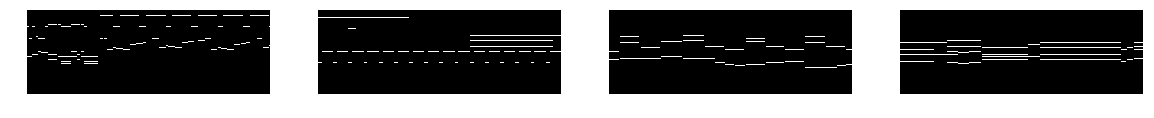

(4, 32, 32, 3)


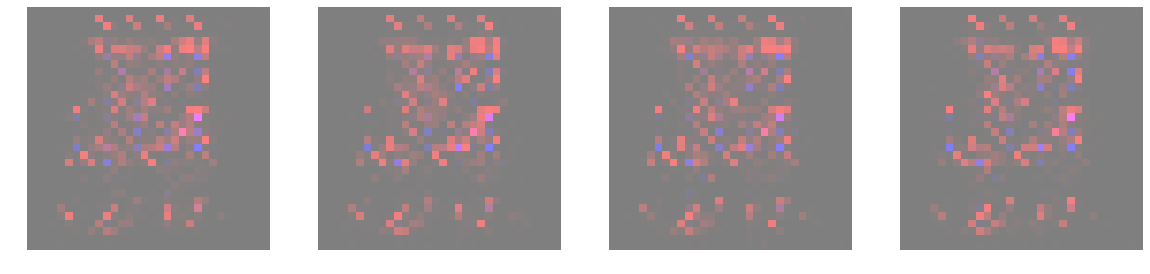

(4, 88, 256, 1)


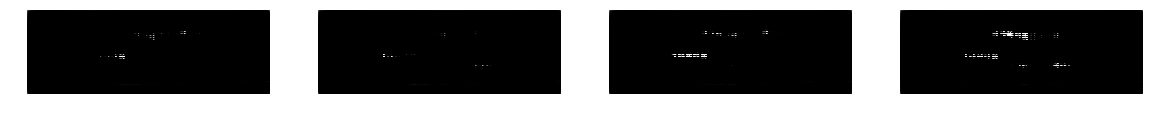

(4, 32, 32, 3)


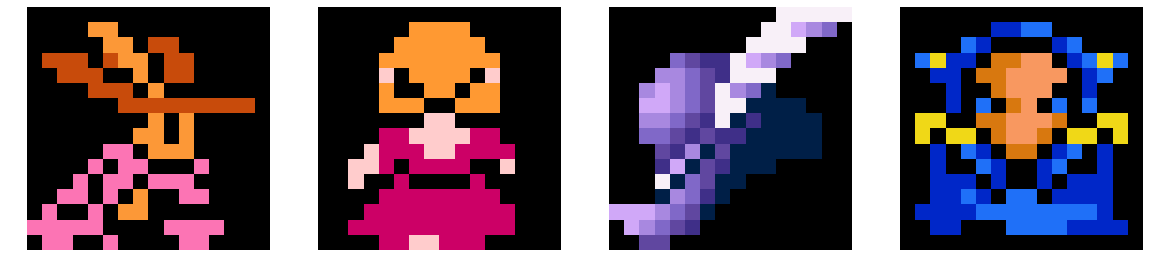

(4, 88, 256, 1)


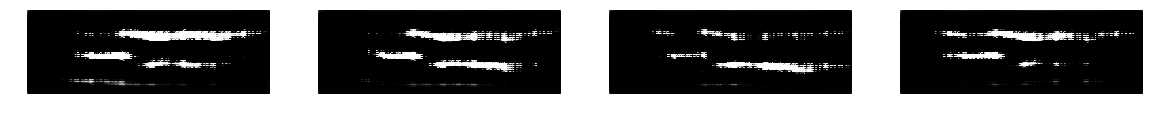

(4, 32, 32, 3)


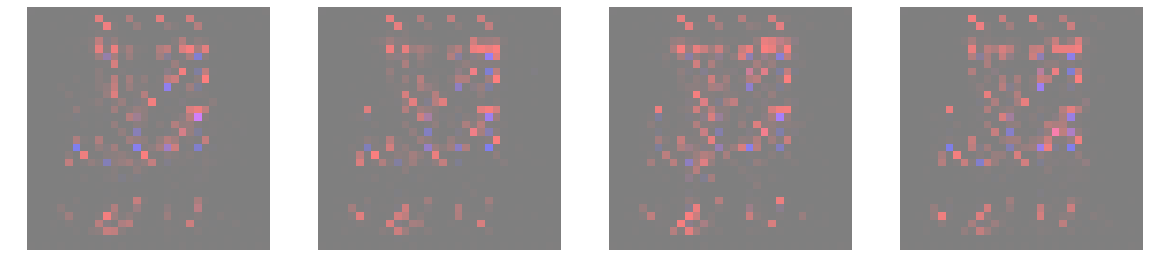

[16/110][5575] Loss_D: 0.111132 0.031619 Loss_G: 0.952239 1.045676 loss_cyc 0.865107 28.713
[16/110][5600] Loss_D: 0.056777 0.099507 Loss_G: 1.020442 1.138160 loss_cyc 0.862983 28.832
[16/110][5625] Loss_D: 0.104337 0.066048 Loss_G: 1.016355 1.150312 loss_cyc 0.851196 28.959
[16/110][5650] Loss_D: 0.216383 0.104444 Loss_G: 1.210908 1.138661 loss_cyc 0.862995 29.084
[16/110][5675] Loss_D: 0.136066 0.047526 Loss_G: 1.145021 1.129191 loss_cyc 0.847104 29.208
[16/110][5700] Loss_D: 0.183335 0.037215 Loss_G: 1.156133 1.113245 loss_cyc 0.840739 29.329
[16/110][5725] Loss_D: 0.168952 0.075135 Loss_G: 1.132065 1.093835 loss_cyc 0.852493 29.445
[16/110][5750] Loss_D: 0.190631 0.222393 Loss_G: 1.075945 1.429559 loss_cyc 0.831656 29.566
[16/110][5775] Loss_D: 0.144607 0.057284 Loss_G: 1.090481 1.199261 loss_cyc 0.874375 29.686
[16/110][5800] Loss_D: 0.129944 0.146811 Loss_G: 1.097647 1.090397 loss_cyc 0.838753 29.816
[16/110][5825] Loss_D: 0.157071 0.038376 Loss_G: 1.062678 1.066590 loss_cyc 0.83

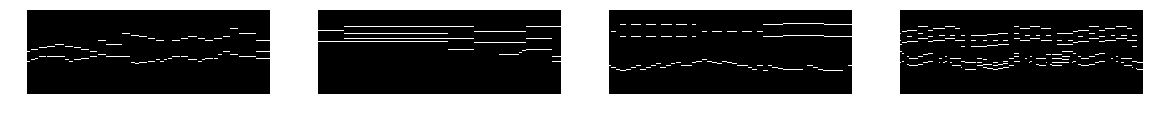

(4, 32, 32, 3)


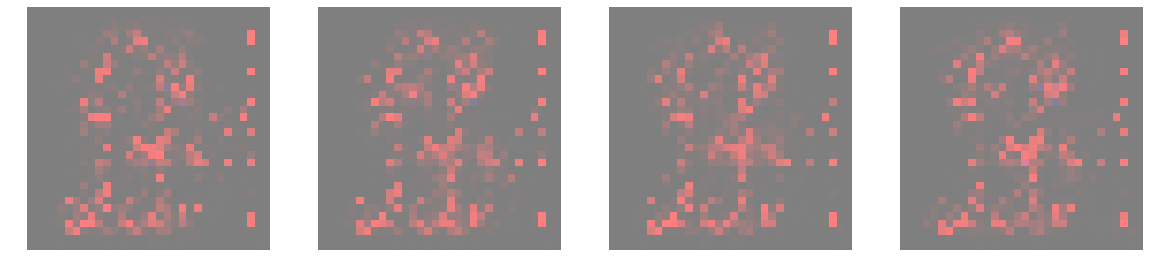

(4, 88, 256, 1)


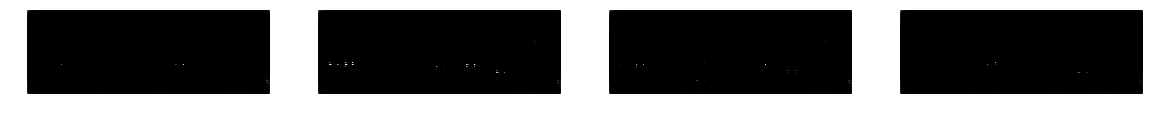

(4, 32, 32, 3)


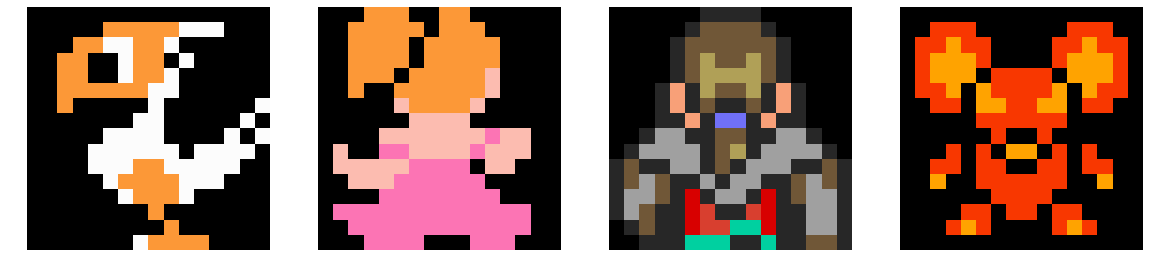

(4, 88, 256, 1)


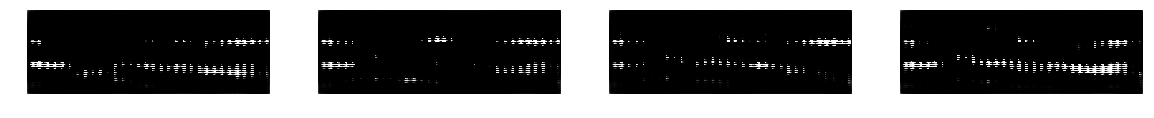

(4, 32, 32, 3)


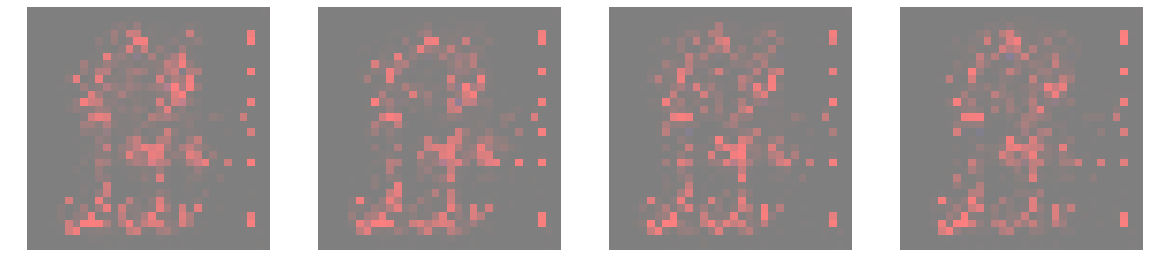

[17/110][5925] Loss_D: 0.138740 0.021034 Loss_G: 1.304075 1.021847 loss_cyc 0.857469 30.509
[17/110][5950] Loss_D: 0.163822 0.020562 Loss_G: 1.146241 1.022700 loss_cyc 0.843684 30.631
[17/110][5975] Loss_D: 0.200264 0.017344 Loss_G: 0.989859 1.021872 loss_cyc 0.847253 30.757
[17/110][6000] Loss_D: 0.156751 0.031592 Loss_G: 1.089356 1.019356 loss_cyc 0.853961 30.876
[17/110][6025] Loss_D: 0.105874 0.033317 Loss_G: 0.985673 1.037613 loss_cyc 0.847475 31.001
[17/110][6050] Loss_D: 0.091165 0.012156 Loss_G: 1.201039 1.011650 loss_cyc 0.855323 31.127
[17/110][6075] Loss_D: 0.104695 0.030029 Loss_G: 1.159144 1.008569 loss_cyc 0.865034 31.240
[17/110][6100] Loss_D: 0.176852 0.032378 Loss_G: 1.099263 1.018915 loss_cyc 0.858159 31.360
[17/110][6125] Loss_D: 0.090705 0.046386 Loss_G: 1.140290 1.009157 loss_cyc 0.850491 31.484
[17/110][6150] Loss_D: 0.113507 0.020872 Loss_G: 1.209298 1.034059 loss_cyc 0.846546 31.614
[17/110][6175] Loss_D: 0.090564 0.013854 Loss_G: 1.047677 1.008703 loss_cyc 0.83

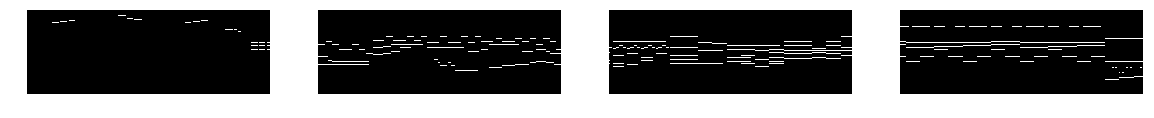

(4, 32, 32, 3)


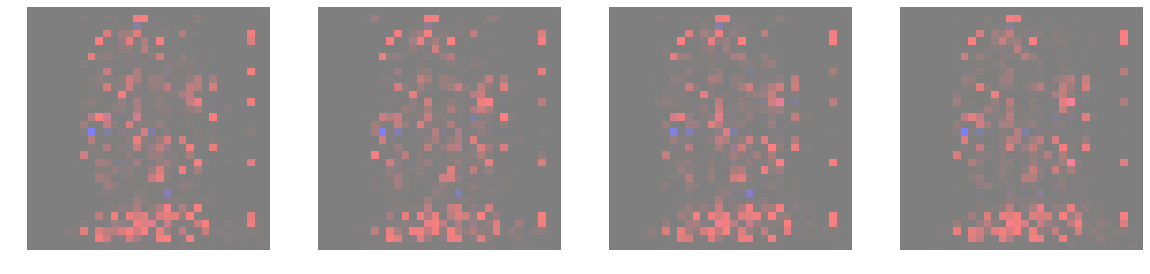

(4, 88, 256, 1)


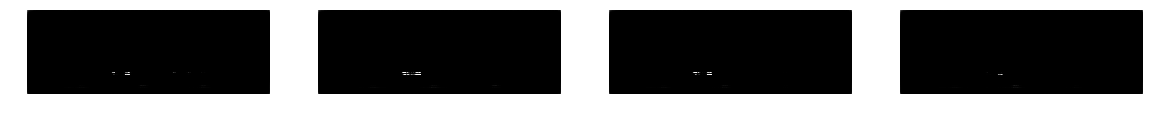

(4, 32, 32, 3)


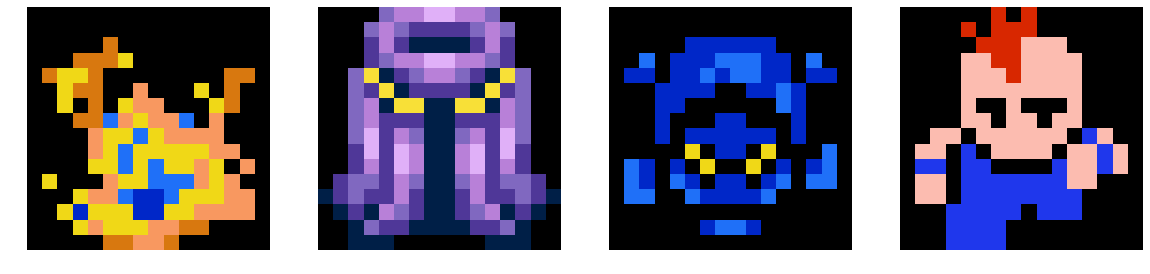

(4, 88, 256, 1)


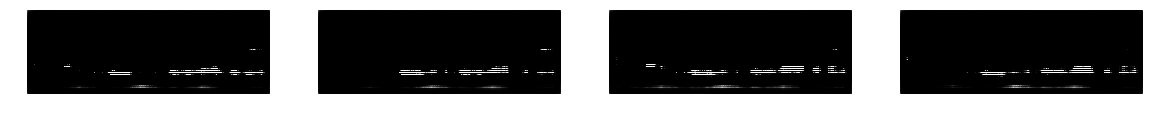

(4, 32, 32, 3)


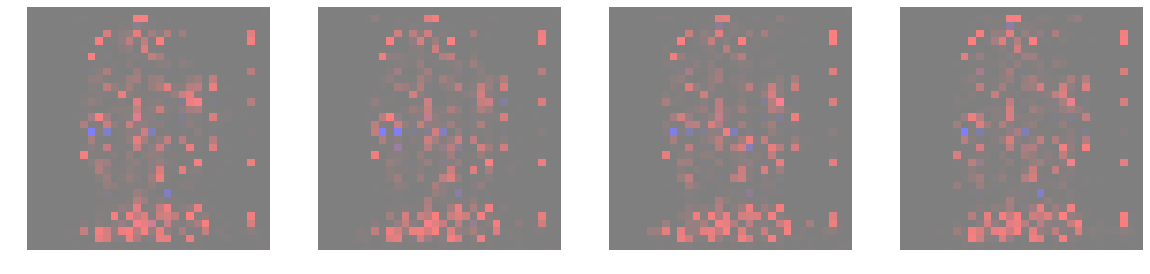

[18/110][6250] Loss_D: 0.076831 0.051159 Loss_G: 1.129698 1.049841 loss_cyc 0.843726 32.160
[18/110][6275] Loss_D: 0.059877 0.039315 Loss_G: 1.104070 1.067834 loss_cyc 0.862469 32.279
[18/110][6300] Loss_D: 0.090390 0.032106 Loss_G: 1.077643 1.015176 loss_cyc 0.887745 32.415
[18/110][6325] Loss_D: 0.058188 0.032370 Loss_G: 1.054652 1.034206 loss_cyc 0.865770 32.539
[18/110][6350] Loss_D: 0.077268 0.035604 Loss_G: 0.999478 1.022913 loss_cyc 0.844733 32.656
[18/110][6375] Loss_D: 0.101800 0.015764 Loss_G: 1.043010 1.010230 loss_cyc 0.845300 32.779
[18/110][6400] Loss_D: 0.061475 0.026303 Loss_G: 1.120757 1.020116 loss_cyc 0.879108 32.909
[18/110][6425] Loss_D: 0.068417 0.016900 Loss_G: 0.987680 1.010105 loss_cyc 0.879102 33.029
[18/110][6450] Loss_D: 0.087269 0.010993 Loss_G: 1.077091 1.008376 loss_cyc 0.839215 33.158
[18/110][6475] Loss_D: 0.145253 0.014212 Loss_G: 1.303344 1.010703 loss_cyc 0.862700 33.280
[18/110][6500] Loss_D: 0.221271 0.015945 Loss_G: 1.338798 1.031479 loss_cyc 0.85

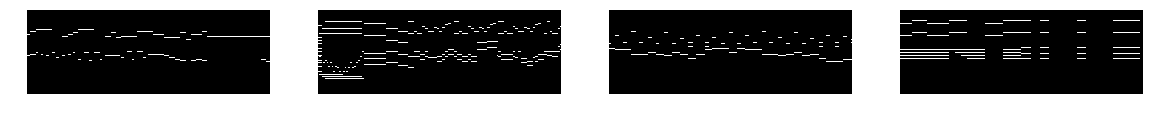

(4, 32, 32, 3)


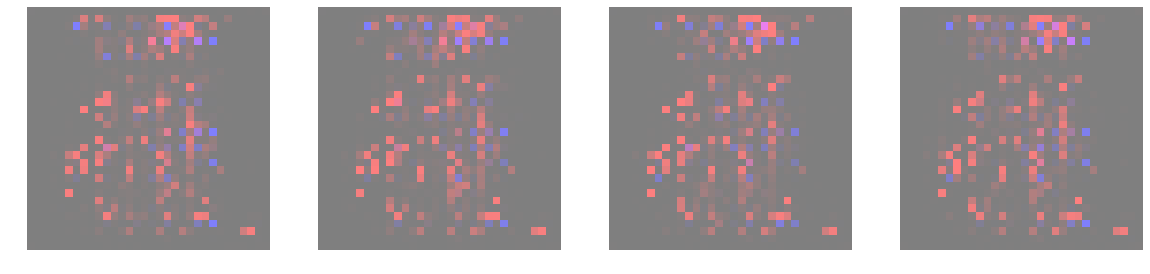

(4, 88, 256, 1)


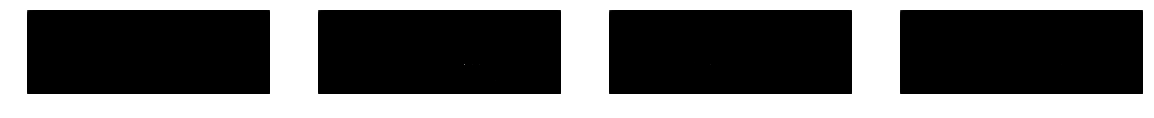

(4, 32, 32, 3)


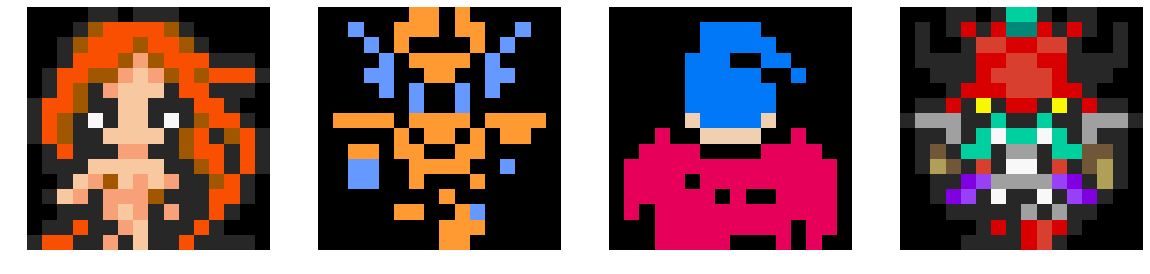

(4, 88, 256, 1)


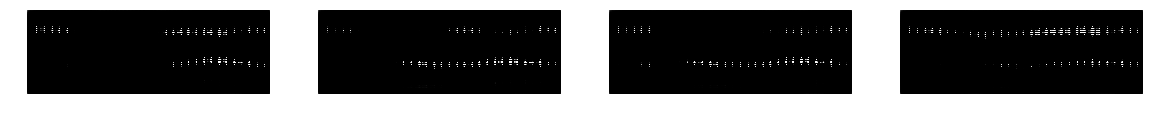

(4, 32, 32, 3)


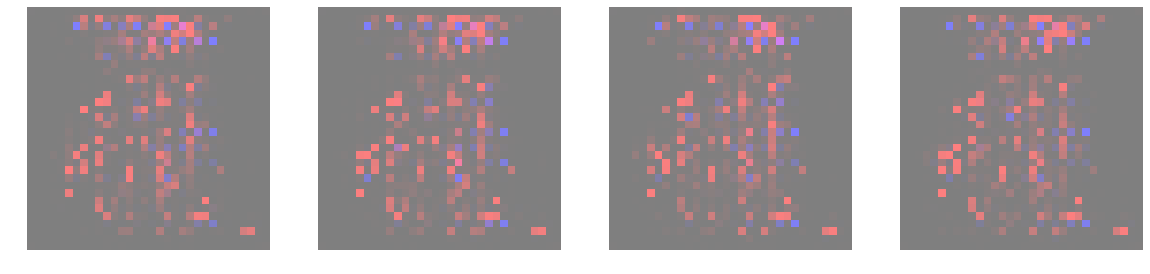

[19/110][6600] Loss_D: 0.122520 0.040812 Loss_G: 0.946434 1.038432 loss_cyc 0.816783 33.957
[19/110][6625] Loss_D: 0.131156 0.024299 Loss_G: 1.310092 1.027299 loss_cyc 0.833230 34.083
[19/110][6650] Loss_D: 0.088588 0.023007 Loss_G: 1.008824 1.052720 loss_cyc 0.850000 34.210
[19/110][6675] Loss_D: 0.105927 0.022548 Loss_G: 1.101532 1.019807 loss_cyc 0.866085 34.328
[19/110][6700] Loss_D: 0.100188 0.015139 Loss_G: 1.220686 1.014486 loss_cyc 0.857197 34.463
[19/110][6725] Loss_D: 0.152831 0.026516 Loss_G: 1.294564 1.034847 loss_cyc 0.836759 34.588
[19/110][6750] Loss_D: 0.113686 0.017243 Loss_G: 1.149573 1.028696 loss_cyc 0.856041 34.709
[19/110][6775] Loss_D: 0.099834 0.025267 Loss_G: 1.081561 1.010531 loss_cyc 0.822223 34.833
[19/110][6800] Loss_D: 0.155517 0.020390 Loss_G: 1.206859 1.022789 loss_cyc 0.853782 34.955
[19/110][6825] Loss_D: 0.177800 0.020228 Loss_G: 1.461097 1.030699 loss_cyc 0.840468 35.074
[19/110][6850] Loss_D: 0.352877 0.023969 Loss_G: 2.420521 1.022383 loss_cyc 0.86

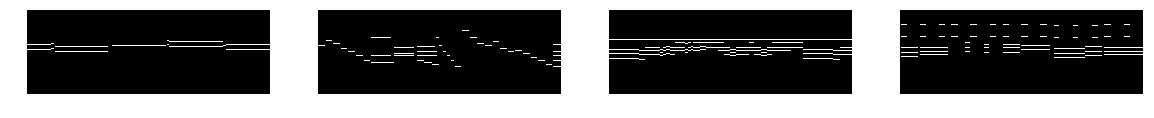

(4, 32, 32, 3)


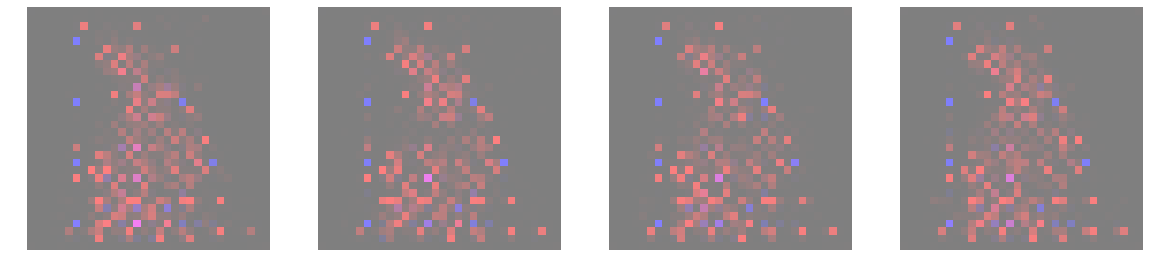

(4, 88, 256, 1)


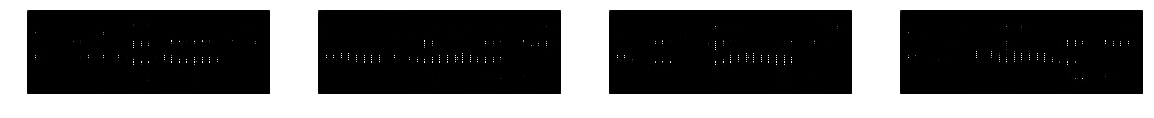

(4, 32, 32, 3)


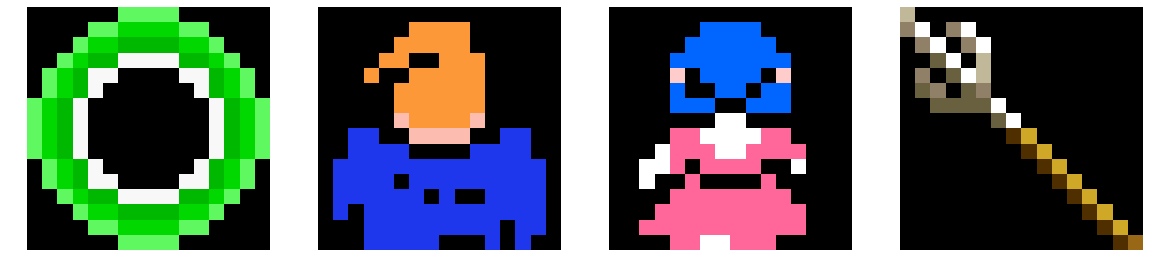

(4, 88, 256, 1)


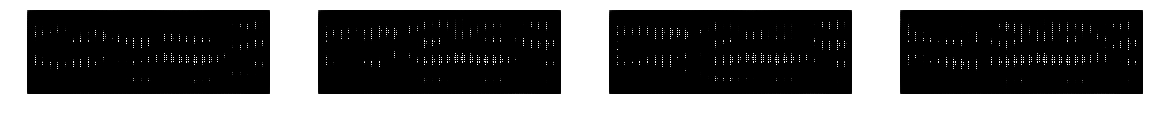

(4, 32, 32, 3)


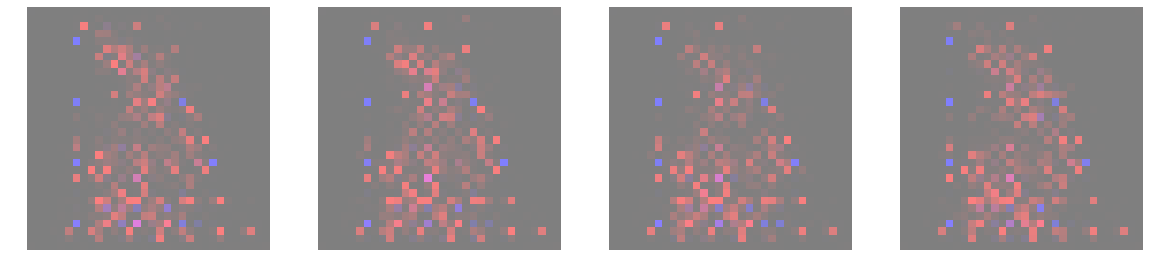

[20/110][6950] Loss_D: 0.152706 0.029740 Loss_G: 1.338545 1.022812 loss_cyc 0.855383 35.732
[20/110][6975] Loss_D: 0.169739 0.117118 Loss_G: 1.482007 1.141079 loss_cyc 0.872587 35.859
[20/110][7000] Loss_D: 0.177471 0.061409 Loss_G: 1.485389 1.056742 loss_cyc 0.869680 35.994
[20/110][7025] Loss_D: 0.090534 0.029246 Loss_G: 1.153105 1.048644 loss_cyc 0.894920 36.112
[20/110][7050] Loss_D: 0.066347 0.030821 Loss_G: 1.130224 1.027859 loss_cyc 0.901570 36.229
[20/110][7075] Loss_D: 0.081258 0.034645 Loss_G: 1.163051 1.021735 loss_cyc 0.886369 36.353
[20/110][7100] Loss_D: 0.086485 0.055596 Loss_G: 1.330968 1.086902 loss_cyc 0.895418 36.473
[20/110][7125] Loss_D: 0.144030 0.019388 Loss_G: 1.350578 1.015203 loss_cyc 0.869320 36.598
[20/110][7150] Loss_D: 0.088873 0.014386 Loss_G: 1.141103 1.038852 loss_cyc 0.871397 36.712
[20/110][7175] Loss_D: 0.091845 0.016853 Loss_G: 1.080065 1.025228 loss_cyc 0.898948 36.827
[20/110][7200] Loss_D: 0.044872 0.078865 Loss_G: 1.069515 1.050590 loss_cyc 0.88

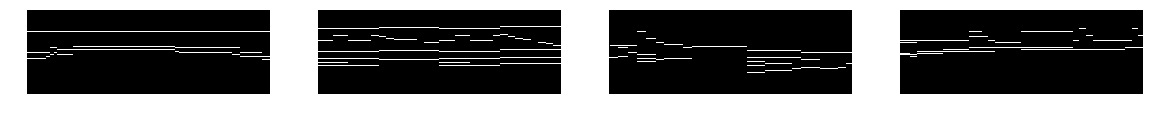

(4, 32, 32, 3)


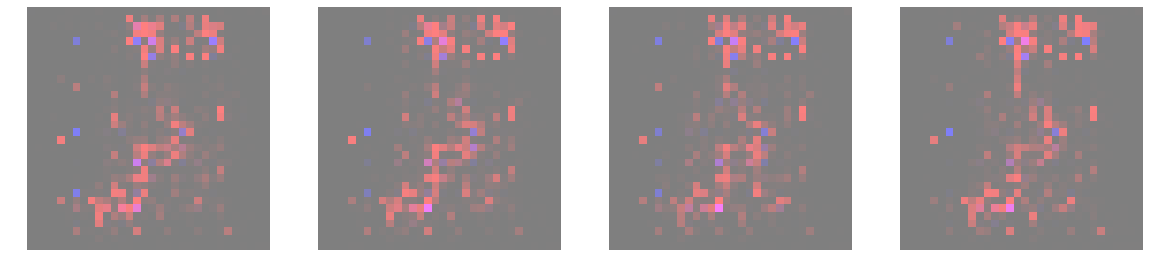

(4, 88, 256, 1)


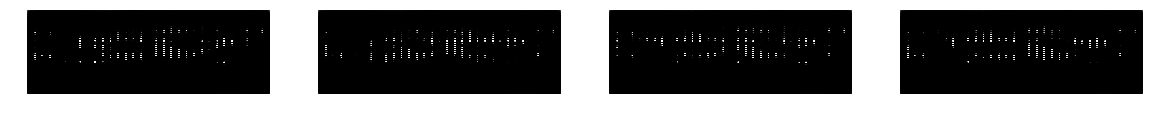

(4, 32, 32, 3)


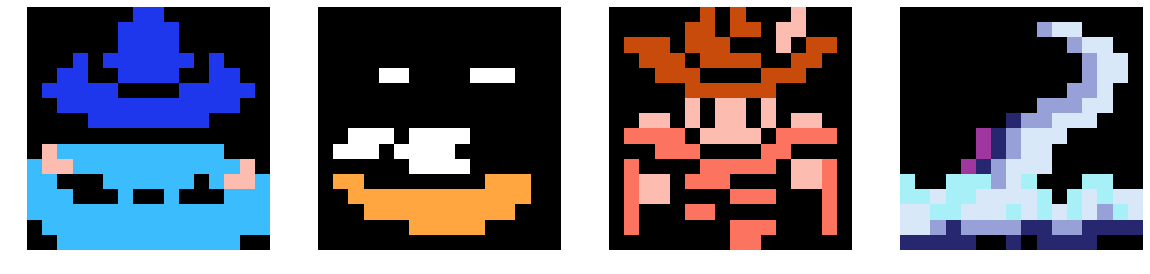

(4, 88, 256, 1)


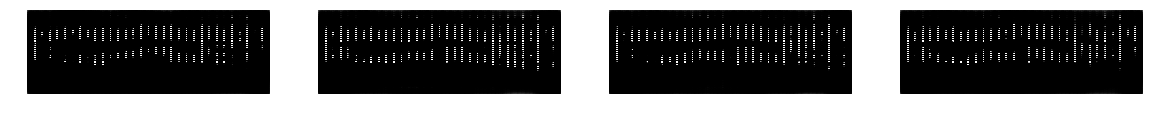

(4, 32, 32, 3)


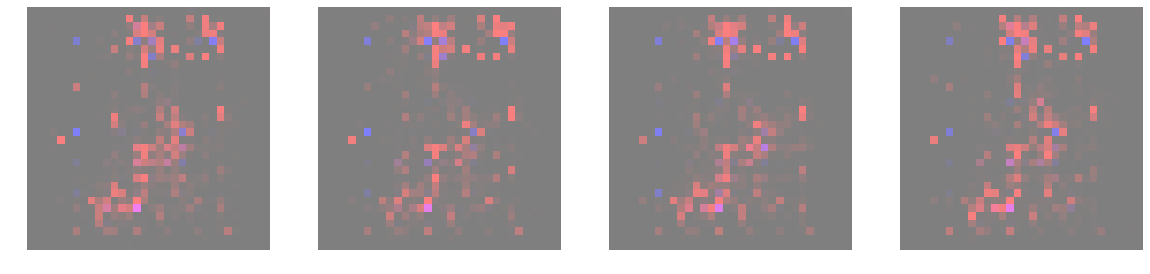

[21/110][7300] Loss_D: 0.098290 0.028370 Loss_G: 1.211454 1.049348 loss_cyc 0.849542 37.508
[21/110][7325] Loss_D: 0.109074 0.054428 Loss_G: 1.228118 1.063040 loss_cyc 0.853209 37.642
[21/110][7350] Loss_D: 0.083836 0.057528 Loss_G: 1.176730 1.064467 loss_cyc 0.883850 37.769
[21/110][7375] Loss_D: 0.095877 0.036643 Loss_G: 1.212530 1.041490 loss_cyc 0.862959 37.885
[21/110][7400] Loss_D: 0.047328 0.021141 Loss_G: 1.067802 1.037305 loss_cyc 0.848931 38.014
[21/110][7425] Loss_D: 0.085626 0.036244 Loss_G: 1.190503 1.029311 loss_cyc 0.864395 38.137
[21/110][7450] Loss_D: 0.213891 0.036402 Loss_G: 1.690896 1.060637 loss_cyc 0.847946 38.266
[21/110][7475] Loss_D: 0.180820 0.052459 Loss_G: 1.546819 1.030261 loss_cyc 0.843952 38.396
[21/110][7500] Loss_D: 0.272770 0.044404 Loss_G: 2.246916 1.058585 loss_cyc 0.884474 38.520
[21/110][7525] Loss_D: 0.092226 0.056142 Loss_G: 1.086605 1.047767 loss_cyc 0.861948 38.634
[21/110][7550] Loss_D: 0.060645 0.011173 Loss_G: 1.070136 1.012128 loss_cyc 0.85

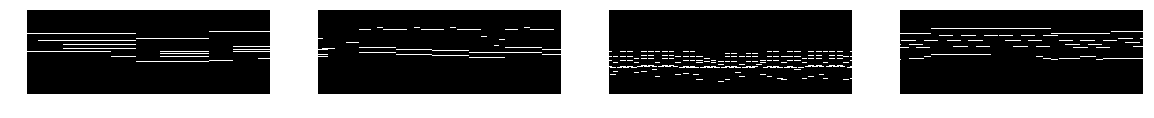

(4, 32, 32, 3)


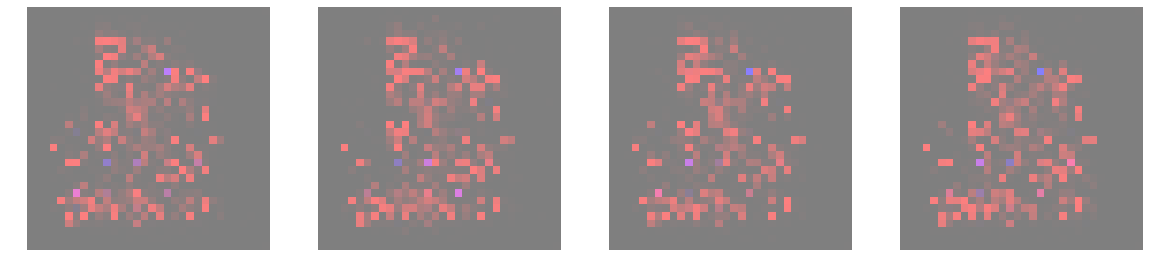

(4, 88, 256, 1)


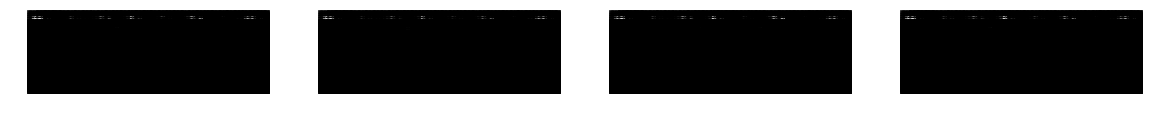

(4, 32, 32, 3)


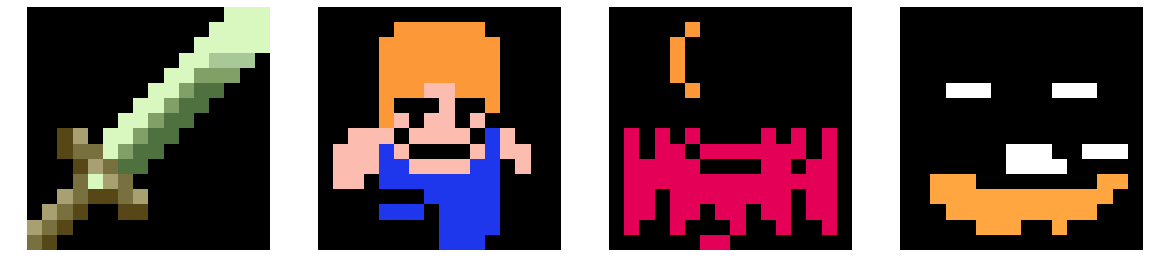

(4, 88, 256, 1)


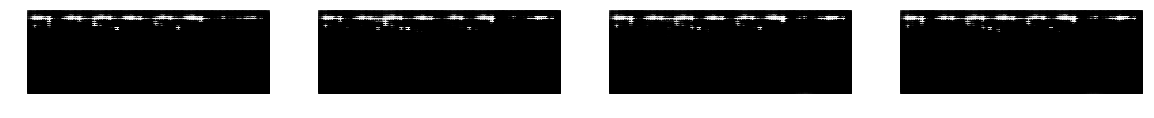

(4, 32, 32, 3)


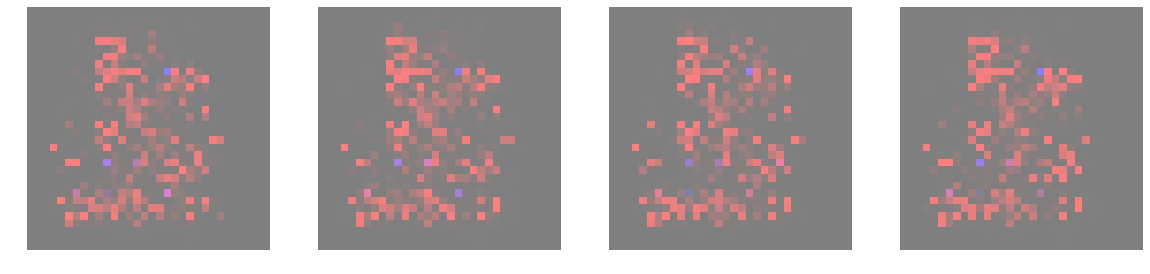

[22/110][7650] Loss_D: 0.087612 0.010550 Loss_G: 1.182065 1.007074 loss_cyc 0.862779 39.301
[22/110][7675] Loss_D: 0.070650 0.010311 Loss_G: 1.097171 1.011139 loss_cyc 0.854799 39.420
[22/110][7700] Loss_D: 0.061139 0.027806 Loss_G: 1.104104 1.038835 loss_cyc 0.880065 39.548
[22/110][7725] Loss_D: 0.064534 0.020678 Loss_G: 1.152561 0.991319 loss_cyc 0.853258 39.677
[22/110][7750] Loss_D: 0.074793 0.022417 Loss_G: 1.228447 1.037651 loss_cyc 0.862789 39.799
[22/110][7775] Loss_D: 0.101955 0.009159 Loss_G: 1.141405 1.008268 loss_cyc 0.865559 39.917
[22/110][7800] Loss_D: 0.073626 0.015163 Loss_G: 1.357896 0.996967 loss_cyc 0.844721 40.038
[22/110][7825] Loss_D: 0.114224 0.021746 Loss_G: 1.214291 1.034396 loss_cyc 0.859631 40.154
[22/110][7850] Loss_D: 0.234339 0.038221 Loss_G: 1.583812 1.042786 loss_cyc 0.847592 40.275
[22/110][7875] Loss_D: 0.455576 0.021907 Loss_G: 2.535703 1.011421 loss_cyc 0.862938 40.406
[22/110][7900] Loss_D: 0.276072 0.023874 Loss_G: 1.286871 1.042810 loss_cyc 0.87

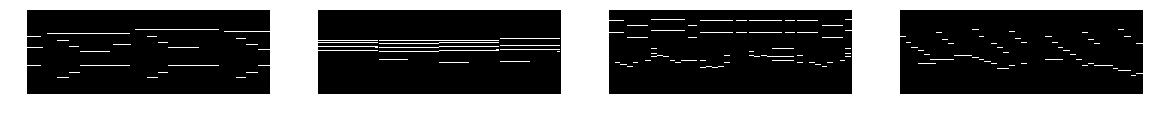

(4, 32, 32, 3)


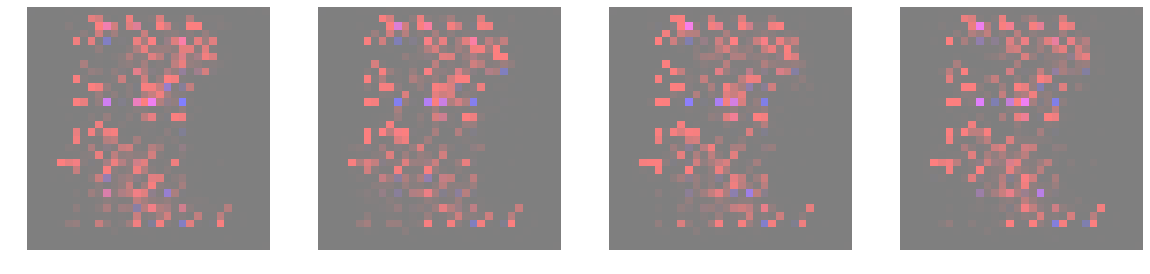

(4, 88, 256, 1)


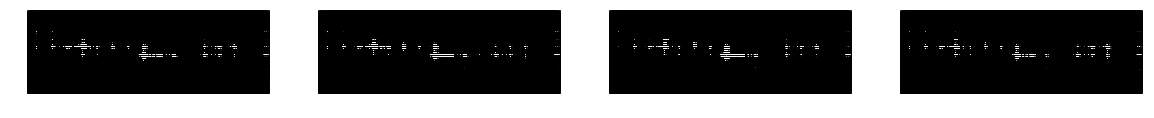

(4, 32, 32, 3)


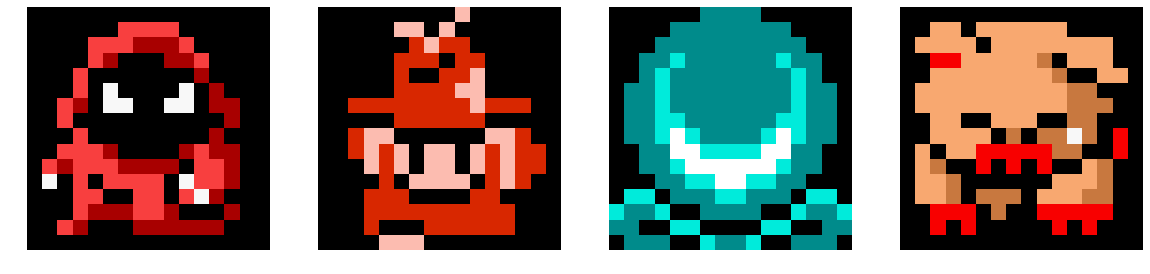

(4, 88, 256, 1)


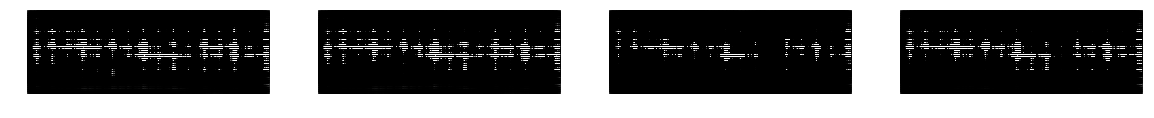

(4, 32, 32, 3)


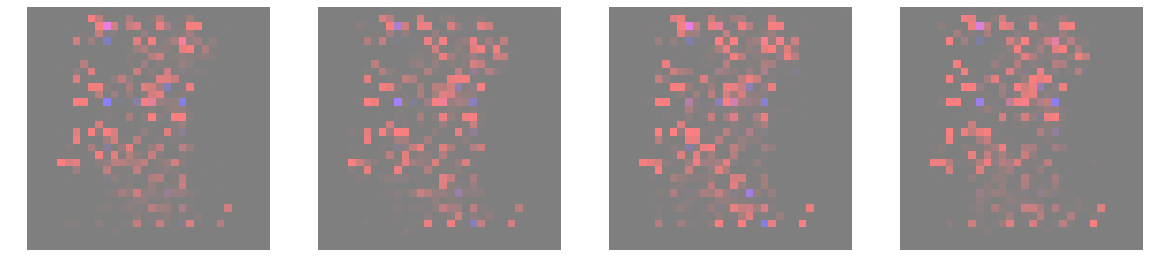

[23/110][8000] Loss_D: 0.095539 0.015889 Loss_G: 1.134812 1.040850 loss_cyc 0.876444 41.101
[23/110][8025] Loss_D: 0.054623 0.020755 Loss_G: 1.043104 0.994511 loss_cyc 0.860447 41.222
[23/110][8050] Loss_D: 0.080223 0.016805 Loss_G: 1.044442 1.033445 loss_cyc 0.845137 41.346
[23/110][8075] Loss_D: 0.104285 0.009522 Loss_G: 1.055216 1.013095 loss_cyc 0.841465 41.475
[23/110][8100] Loss_D: 0.101453 0.012684 Loss_G: 1.030509 1.020887 loss_cyc 0.854384 41.596
[23/110][8125] Loss_D: 0.048864 0.088577 Loss_G: 1.139785 1.093823 loss_cyc 0.865534 41.728
[23/110][8150] Loss_D: 0.103444 0.023464 Loss_G: 1.227638 1.014236 loss_cyc 0.855817 41.848
[23/110][8175] Loss_D: 0.159741 0.019218 Loss_G: 1.279228 1.023307 loss_cyc 0.845775 41.976
[23/110][8200] Loss_D: 0.094857 0.098845 Loss_G: 1.112699 1.135204 loss_cyc 0.842661 42.105
[23/110][8225] Loss_D: 0.074071 0.020388 Loss_G: 1.102989 1.005117 loss_cyc 0.859823 42.229
[23/110][8250] Loss_D: 0.047031 0.024109 Loss_G: 1.171529 1.034949 loss_cyc 0.87

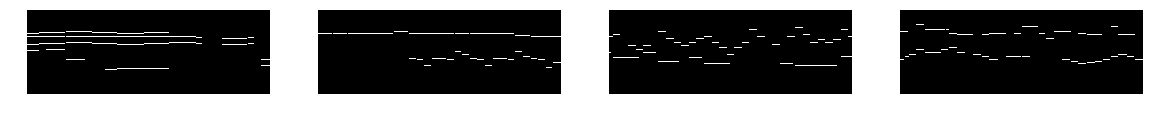

(4, 32, 32, 3)


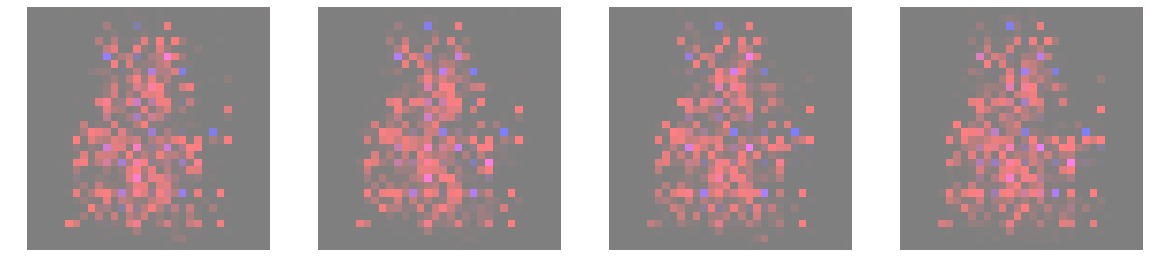

(4, 88, 256, 1)


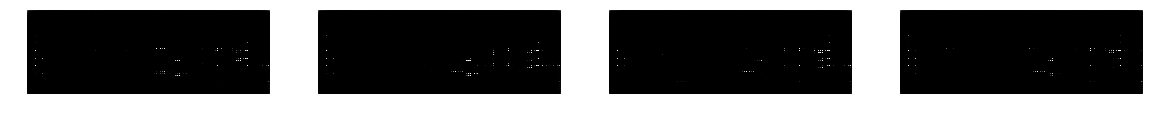

(4, 32, 32, 3)


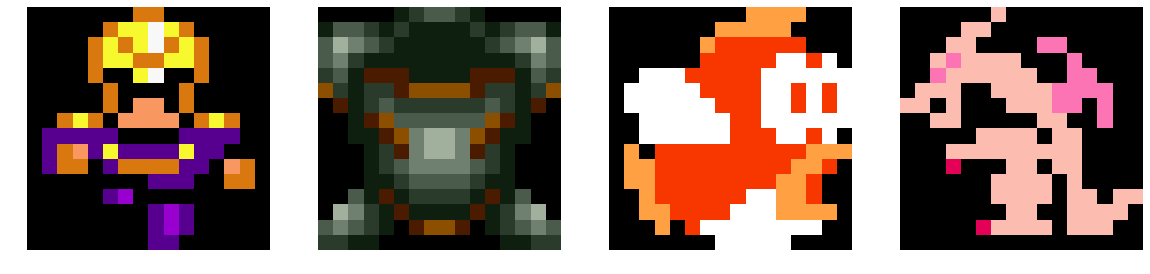

(4, 88, 256, 1)


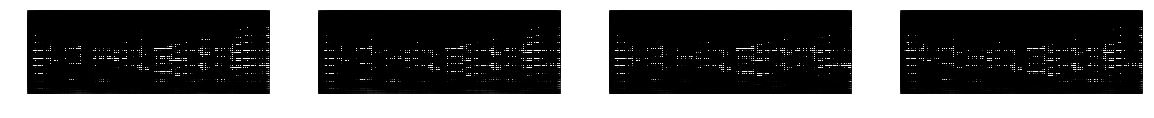

(4, 32, 32, 3)


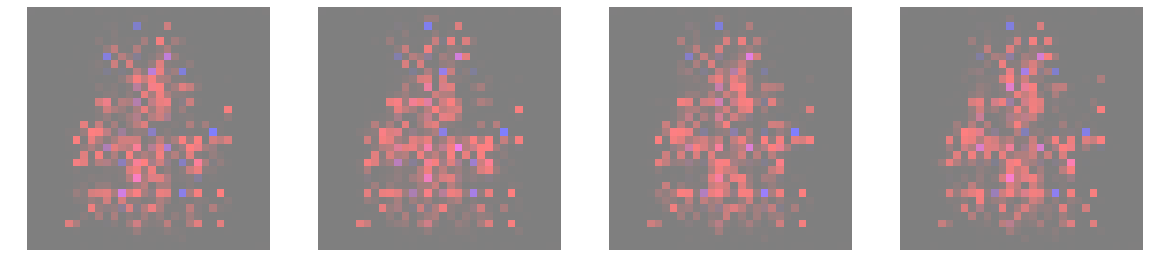

[24/110][8350] Loss_D: 0.063747 0.017430 Loss_G: 1.172592 1.020149 loss_cyc 0.873655 42.913
[24/110][8375] Loss_D: 0.045064 0.032232 Loss_G: 1.103649 1.025396 loss_cyc 0.854759 43.040
[24/110][8400] Loss_D: 0.069782 0.018760 Loss_G: 1.018967 1.030455 loss_cyc 0.879768 43.165
[24/110][8425] Loss_D: 0.045396 0.016378 Loss_G: 1.134415 1.018035 loss_cyc 0.848643 43.296
[24/110][8450] Loss_D: 0.095379 0.017602 Loss_G: 1.352412 1.043197 loss_cyc 0.860834 43.421
[24/110][8475] Loss_D: 0.152324 0.016735 Loss_G: 1.499143 0.997423 loss_cyc 0.864726 43.548
[24/110][8500] Loss_D: 0.131549 0.024872 Loss_G: 1.349436 1.028513 loss_cyc 0.826605 43.668
[24/110][8525] Loss_D: 0.867415 0.088052 Loss_G: 8.537571 1.120442 loss_cyc 0.906221 43.794
[24/110][8550] Loss_D: 0.230059 0.020065 Loss_G: 1.382885 1.029616 loss_cyc 0.997758 43.916
[24/110][8575] Loss_D: 0.139242 0.020969 Loss_G: 1.108358 1.037263 loss_cyc 1.001035 44.034
[24/110][8600] Loss_D: 0.103046 0.022385 Loss_G: 1.234835 1.029012 loss_cyc 0.91

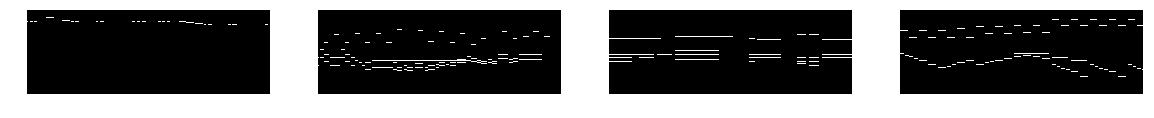

(4, 32, 32, 3)


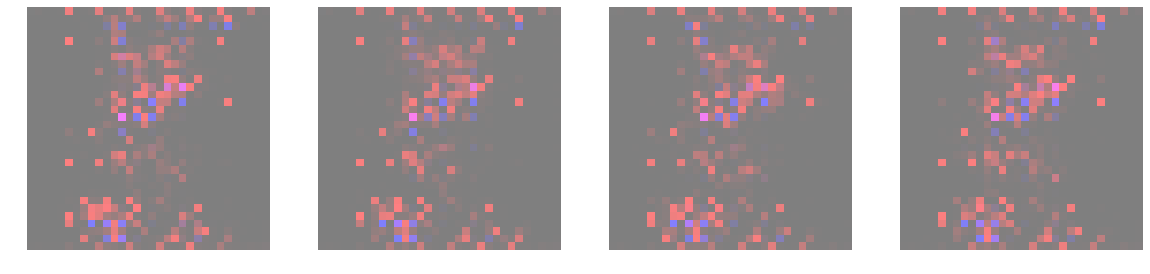

(4, 88, 256, 1)


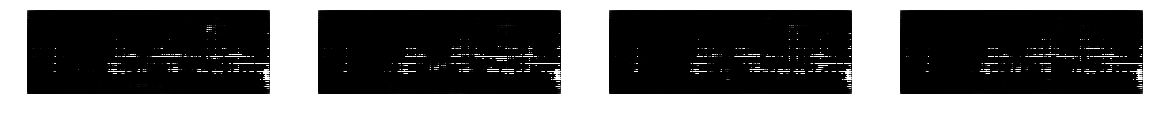

(4, 32, 32, 3)


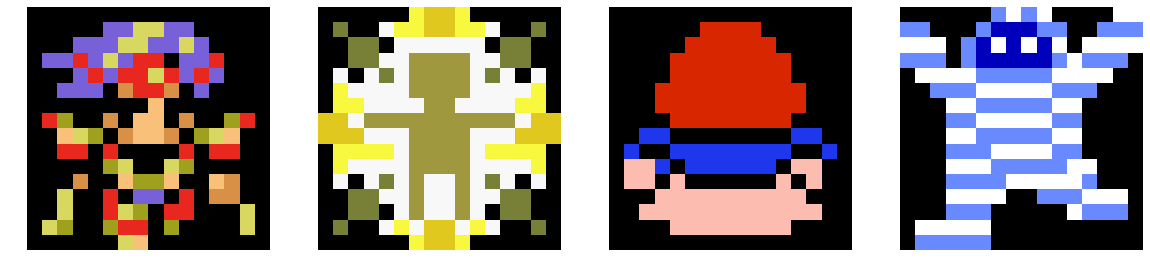

(4, 88, 256, 1)


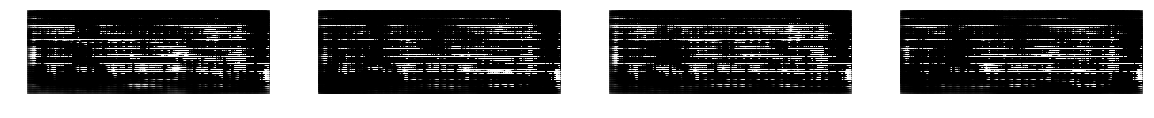

(4, 32, 32, 3)


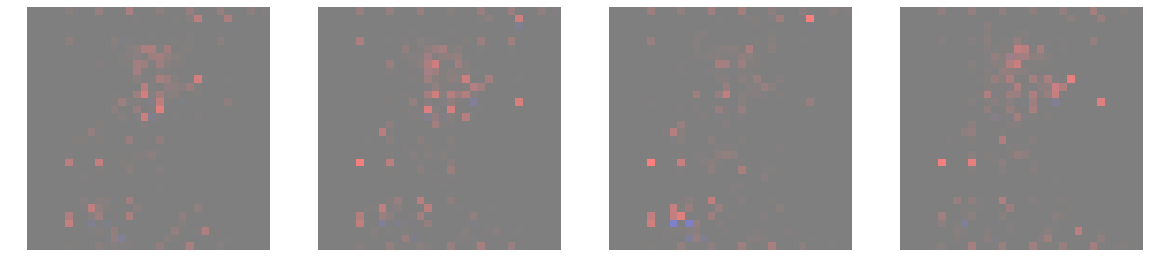

[25/110][8700] Loss_D: 0.208831 0.012004 Loss_G: 1.566412 1.017426 loss_cyc 0.849290 44.714
[25/110][8725] Loss_D: 0.095358 0.015498 Loss_G: 1.111812 1.023542 loss_cyc 0.830896 44.830
[25/110][8750] Loss_D: 0.070280 0.012137 Loss_G: 1.121527 1.023848 loss_cyc 0.879460 44.968
[25/110][8775] Loss_D: 0.073280 0.106207 Loss_G: 1.176554 1.145879 loss_cyc 0.841802 45.089
[25/110][8800] Loss_D: 0.217178 0.084703 Loss_G: 1.944747 1.111265 loss_cyc 0.875099 45.216
[25/110][8825] Loss_D: 0.093521 0.050814 Loss_G: 1.203963 1.072728 loss_cyc 0.859702 45.333
[25/110][8850] Loss_D: 0.074722 0.013749 Loss_G: 1.052513 1.008768 loss_cyc 0.838845 45.457
[25/110][8875] Loss_D: 0.081056 0.011970 Loss_G: 1.190201 1.017231 loss_cyc 0.827179 45.579
[25/110][8900] Loss_D: 0.232068 0.026575 Loss_G: 1.812229 1.049467 loss_cyc 0.846723 45.714
[25/110][8925] Loss_D: 0.176806 0.015289 Loss_G: 1.261194 1.030363 loss_cyc 0.866482 45.838
[25/110][8950] Loss_D: 0.068967 0.047633 Loss_G: 1.199090 1.149471 loss_cyc 0.85

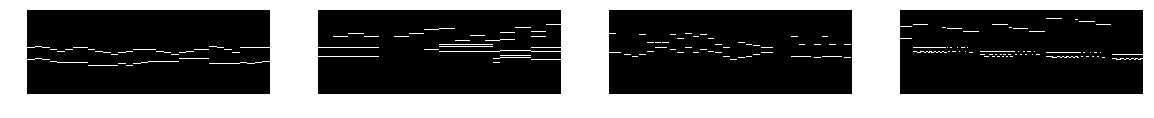

(4, 32, 32, 3)


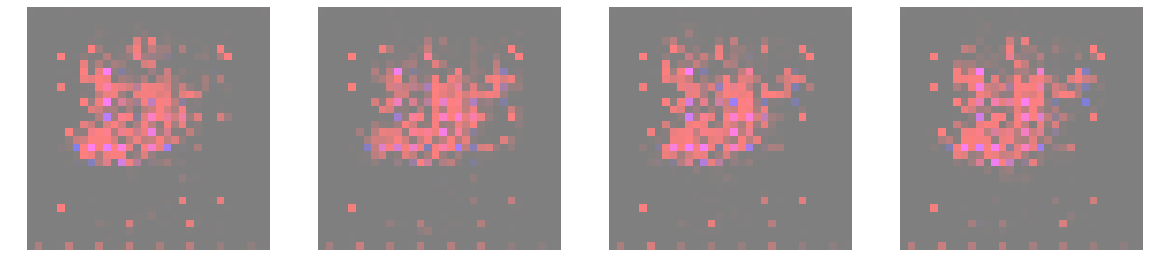

(4, 88, 256, 1)


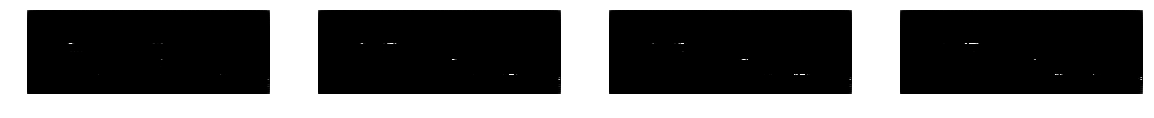

(4, 32, 32, 3)


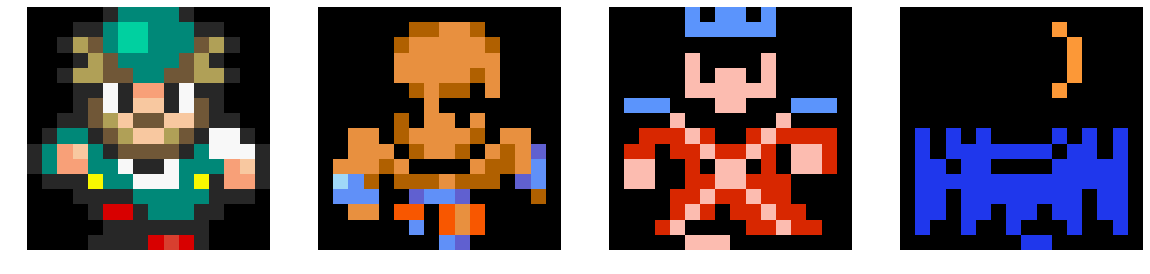

(4, 88, 256, 1)


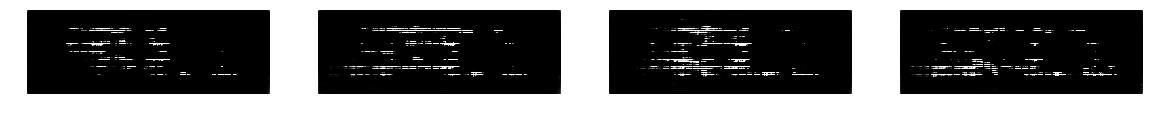

(4, 32, 32, 3)


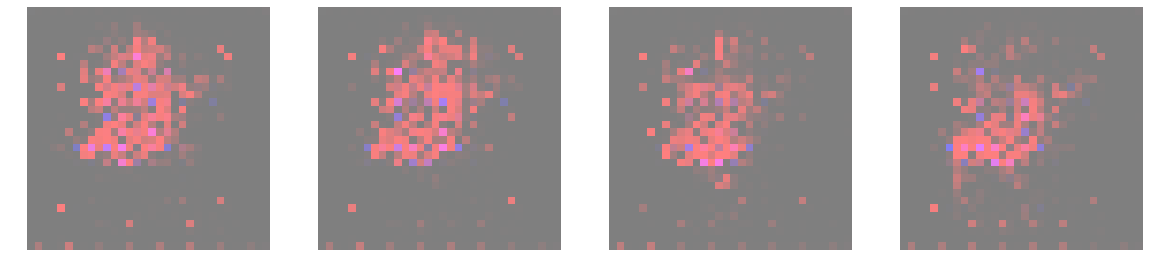

[26/110][9050] Loss_D: 0.056727 0.015368 Loss_G: 1.043365 1.026282 loss_cyc 0.860140 46.527
[26/110][9075] Loss_D: 0.093445 0.013138 Loss_G: 1.072916 0.997703 loss_cyc 0.824759 46.659
[26/110][9100] Loss_D: 0.086023 0.125186 Loss_G: 1.172577 1.129419 loss_cyc 0.876492 46.780
[26/110][9125] Loss_D: 0.073124 0.134094 Loss_G: 1.143375 1.204373 loss_cyc 0.872836 46.899
[26/110][9150] Loss_D: 0.077057 0.054341 Loss_G: 1.168336 1.027452 loss_cyc 0.857944 47.026
[26/110][9175] Loss_D: 0.068427 0.253342 Loss_G: 1.149673 1.417615 loss_cyc 0.850700 47.155
[26/110][9200] Loss_D: 0.056462 0.083151 Loss_G: 1.059939 1.206061 loss_cyc 0.855765 47.285
[26/110][9225] Loss_D: 0.067919 0.010233 Loss_G: 1.065249 1.019031 loss_cyc 0.858371 47.404
[26/110][9250] Loss_D: 0.073340 0.046757 Loss_G: 1.063761 1.059064 loss_cyc 0.854345 47.519
[26/110][9275] Loss_D: 0.106177 0.005434 Loss_G: 1.223052 1.011899 loss_cyc 0.835322 47.640
[26/110][9300] Loss_D: 0.069175 0.006026 Loss_G: 1.091842 1.008535 loss_cyc 0.84

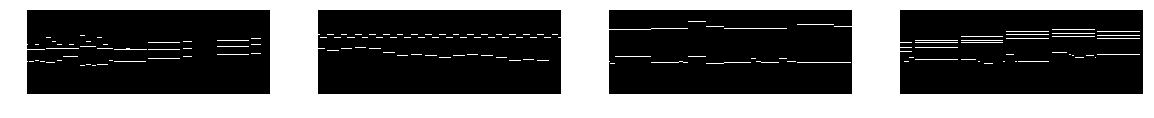

(4, 32, 32, 3)


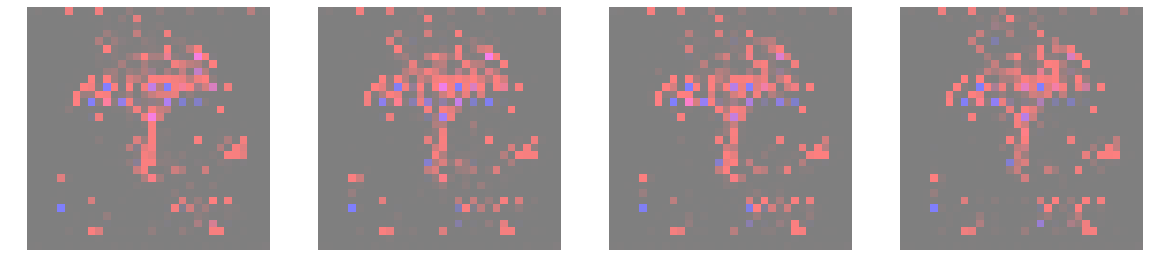

(4, 88, 256, 1)


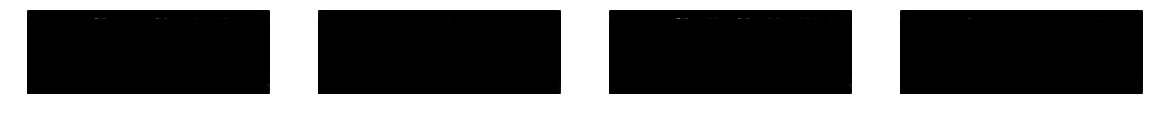

(4, 32, 32, 3)


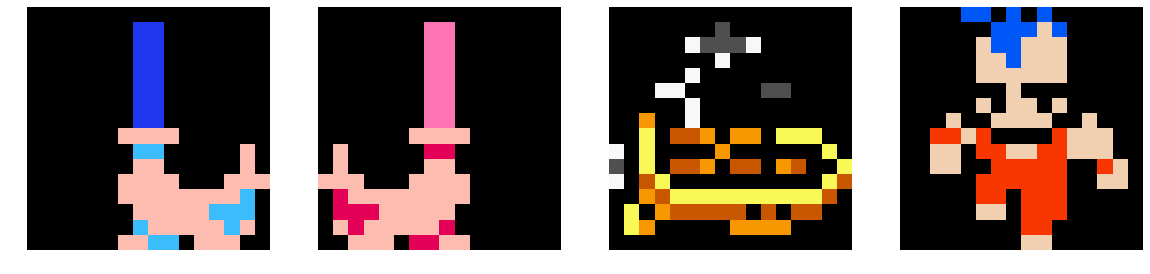

(4, 88, 256, 1)


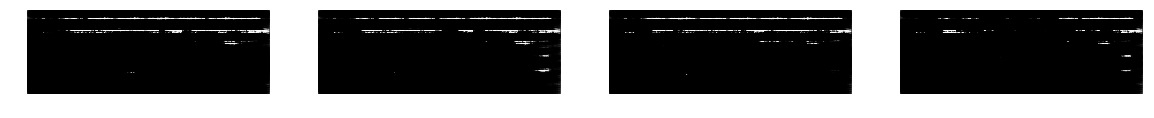

(4, 32, 32, 3)


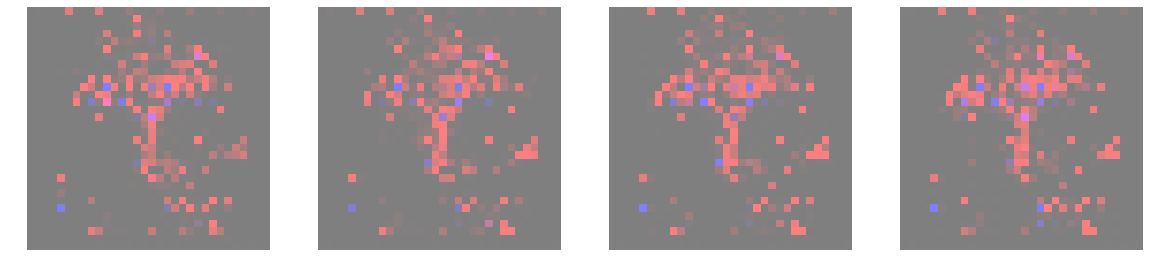

[27/110][9375] Loss_D: 0.062513 0.003814 Loss_G: 1.065733 1.004422 loss_cyc 0.863227 48.189
[27/110][9400] Loss_D: 0.036566 0.006216 Loss_G: 1.017674 0.993750 loss_cyc 0.853463 48.310
[27/110][9425] Loss_D: 0.038883 0.009227 Loss_G: 0.956913 1.015449 loss_cyc 0.825914 48.446
[27/110][9450] Loss_D: 0.044688 0.006747 Loss_G: 0.999272 1.004052 loss_cyc 0.812057 48.575
[27/110][9475] Loss_D: 0.050788 0.007101 Loss_G: 0.984228 1.008432 loss_cyc 0.815585 48.691
[27/110][9500] Loss_D: 0.045692 0.008799 Loss_G: 1.055724 1.005220 loss_cyc 0.850801 48.813
[27/110][9525] Loss_D: 0.043125 0.010003 Loss_G: 0.989709 1.017007 loss_cyc 0.866204 48.943
[27/110][9550] Loss_D: 0.062561 0.017997 Loss_G: 1.119853 1.005580 loss_cyc 0.842531 49.072
[27/110][9575] Loss_D: 0.053604 0.004482 Loss_G: 1.022568 1.014338 loss_cyc 0.841505 49.199
[27/110][9600] Loss_D: 0.060635 0.004295 Loss_G: 1.156954 1.009124 loss_cyc 0.881060 49.318
[27/110][9625] Loss_D: 0.134756 0.009666 Loss_G: 1.306244 1.017578 loss_cyc 0.84

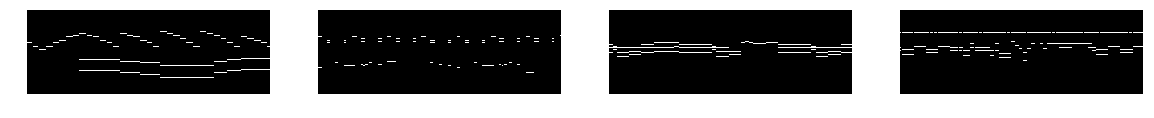

(4, 32, 32, 3)


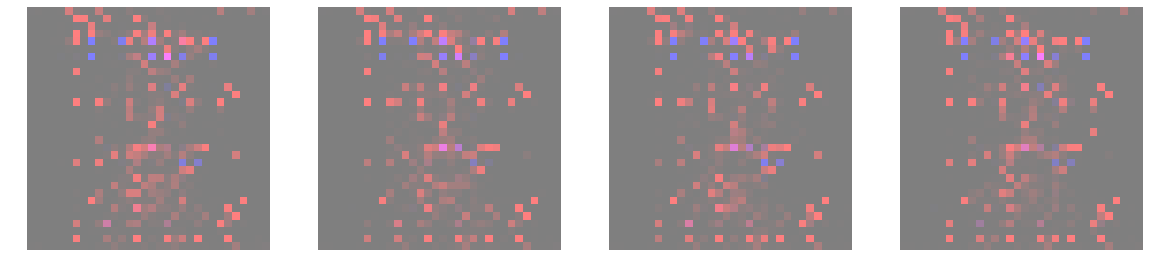

(4, 88, 256, 1)


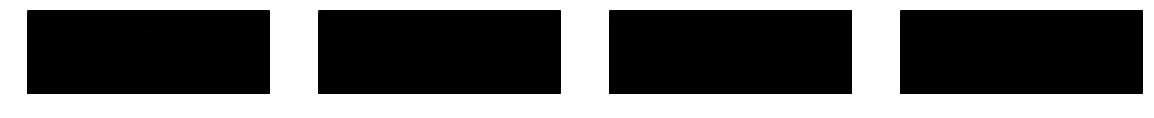

(4, 32, 32, 3)


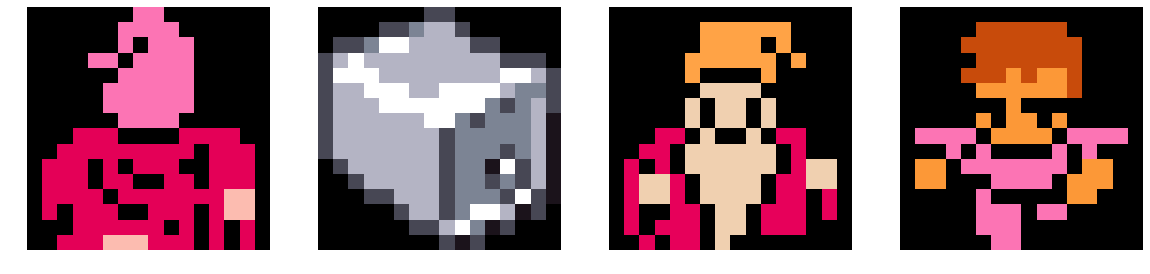

(4, 88, 256, 1)


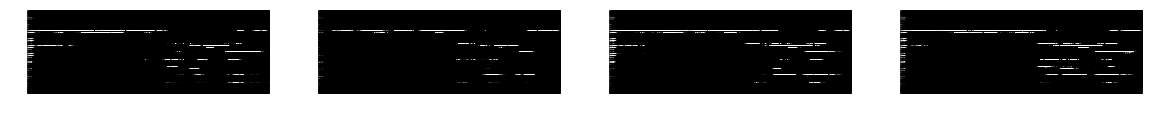

(4, 32, 32, 3)


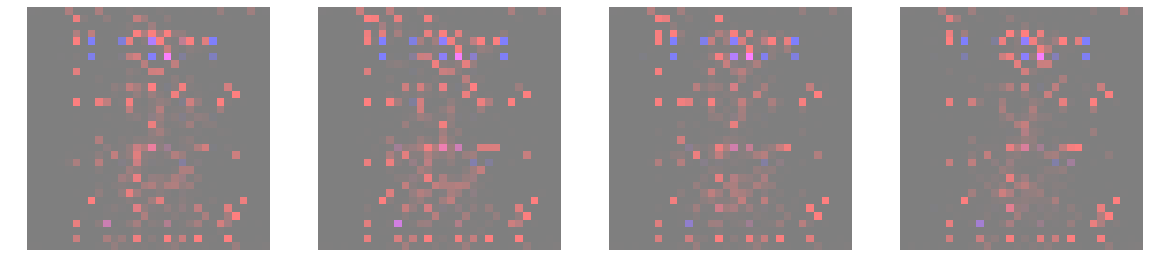

[28/110][9725] Loss_D: 0.057766 0.014173 Loss_G: 1.122305 1.008763 loss_cyc 0.850859 49.996
[28/110][9750] Loss_D: 0.061212 0.033989 Loss_G: 1.050898 1.040720 loss_cyc 0.873385 50.130
[28/110][9775] Loss_D: 0.039483 0.016034 Loss_G: 1.083523 1.009710 loss_cyc 0.882844 50.257
[28/110][9800] Loss_D: 0.029694 0.010826 Loss_G: 1.015746 1.015801 loss_cyc 0.839137 50.384
[28/110][9825] Loss_D: 0.031085 0.053924 Loss_G: 1.066568 1.082503 loss_cyc 0.841613 50.510
[28/110][9850] Loss_D: 0.042375 0.013865 Loss_G: 1.006019 0.997945 loss_cyc 0.837636 50.627
[28/110][9875] Loss_D: 0.037620 0.013926 Loss_G: 0.998323 1.006081 loss_cyc 0.845818 50.753
[28/110][9900] Loss_D: 0.025852 0.008240 Loss_G: 1.015439 1.000928 loss_cyc 0.864145 50.882
[28/110][9925] Loss_D: 0.042892 0.011081 Loss_G: 1.009175 1.014003 loss_cyc 0.863613 51.003
[28/110][9950] Loss_D: 0.038526 0.009428 Loss_G: 1.046085 1.016374 loss_cyc 0.862843 51.129
[28/110][9975] Loss_D: 0.050298 0.014019 Loss_G: 1.053335 1.018159 loss_cyc 0.83

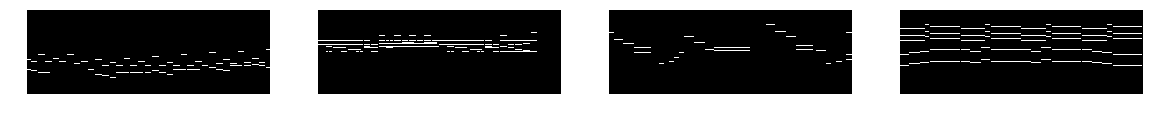

(4, 32, 32, 3)


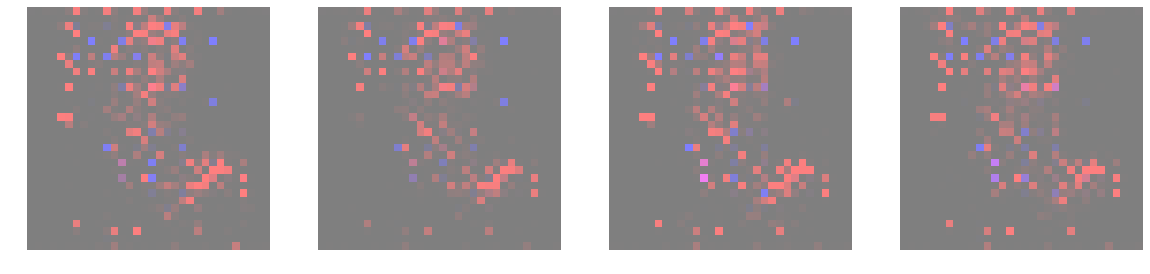

(4, 88, 256, 1)


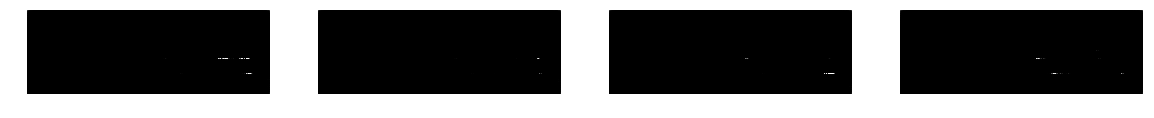

(4, 32, 32, 3)


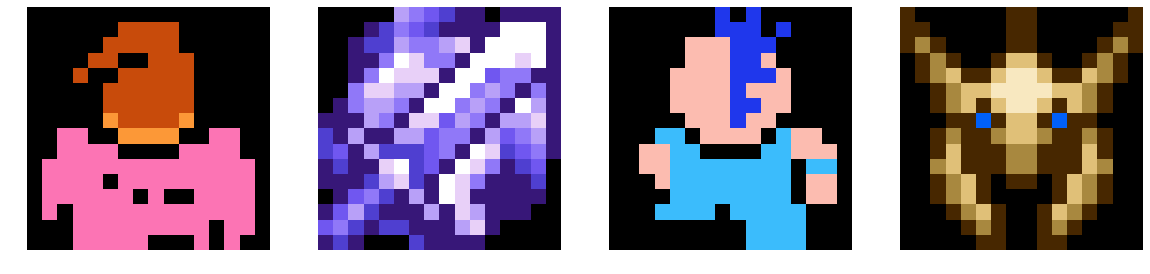

(4, 88, 256, 1)


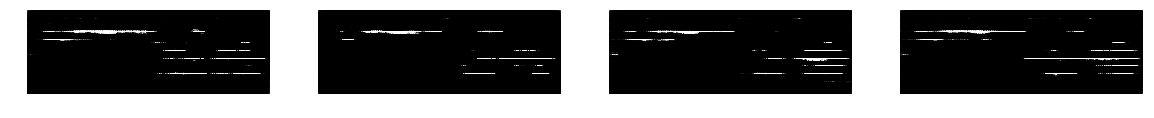

(4, 32, 32, 3)


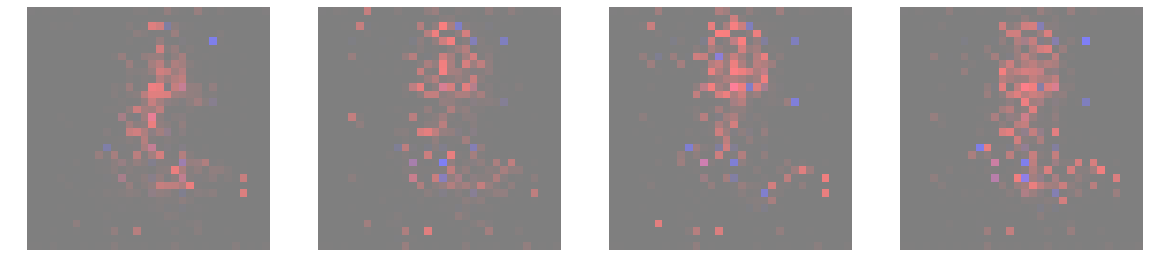

[29/110][10075] Loss_D: 0.072987 0.002077 Loss_G: 0.965017 1.008841 loss_cyc 0.826394 51.797
[29/110][10100] Loss_D: 0.053706 0.012560 Loss_G: 1.013783 1.014194 loss_cyc 0.837740 51.932
[29/110][10125] Loss_D: 0.037796 0.028741 Loss_G: 1.008555 1.045202 loss_cyc 0.844388 52.057
[29/110][10150] Loss_D: 0.050076 0.019507 Loss_G: 0.965506 1.032612 loss_cyc 0.852210 52.175
[29/110][10175] Loss_D: 0.042277 0.011894 Loss_G: 1.008932 0.998464 loss_cyc 0.842569 52.302
[29/110][10200] Loss_D: 0.046720 0.018531 Loss_G: 1.036681 1.024727 loss_cyc 0.825714 52.434
[29/110][10225] Loss_D: 0.030357 0.013767 Loss_G: 1.031403 1.004109 loss_cyc 0.863161 52.572
[29/110][10250] Loss_D: 0.041064 0.032309 Loss_G: 1.104250 1.018931 loss_cyc 0.833066 52.697
[29/110][10275] Loss_D: 0.061823 0.024341 Loss_G: 1.130798 1.035544 loss_cyc 0.851342 52.824
[29/110][10300] Loss_D: 0.048706 0.019937 Loss_G: 1.156259 1.019628 loss_cyc 0.836794 52.949
[29/110][10325] Loss_D: 0.077831 0.008389 Loss_G: 1.072335 1.009675 lo

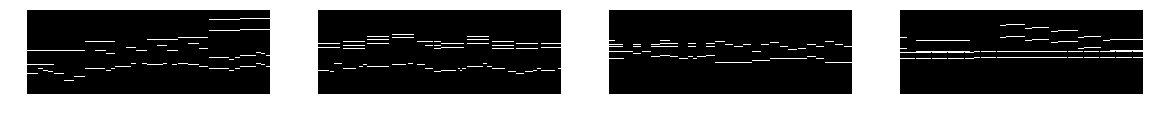

(4, 32, 32, 3)


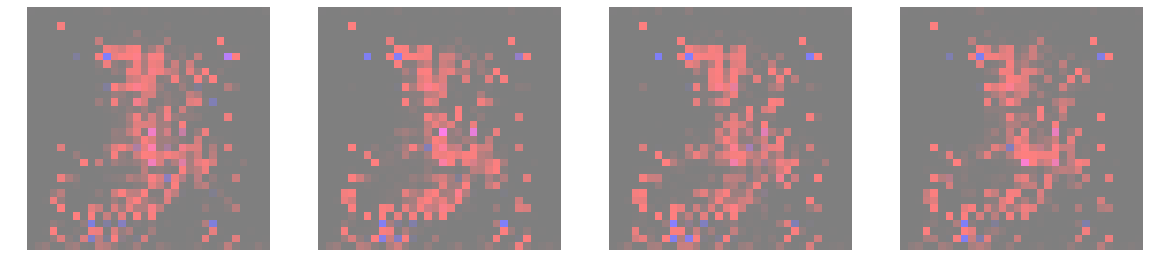

(4, 88, 256, 1)


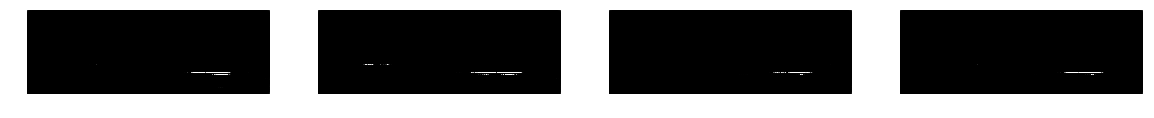

(4, 32, 32, 3)


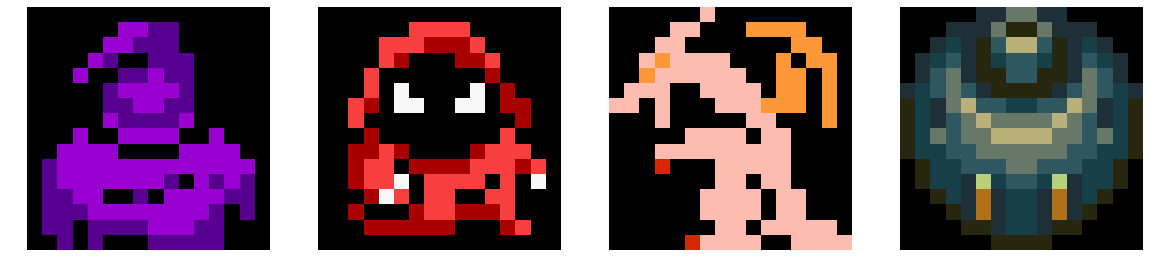

(4, 88, 256, 1)


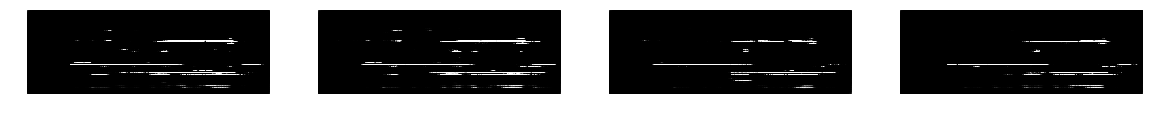

(4, 32, 32, 3)


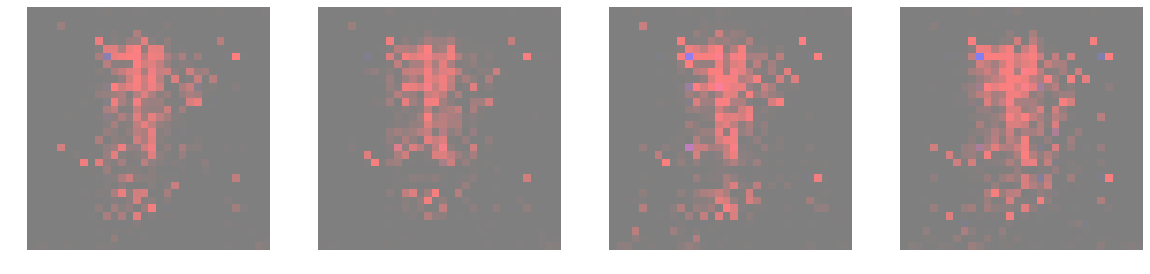

[30/110][10425] Loss_D: 0.085816 0.028327 Loss_G: 1.111430 1.037090 loss_cyc 0.860574 53.609
[30/110][10450] Loss_D: 0.056960 0.004524 Loss_G: 1.124960 0.999593 loss_cyc 0.852386 53.736
[30/110][10475] Loss_D: 0.062910 0.010704 Loss_G: 1.143139 1.017929 loss_cyc 0.851712 53.851
[30/110][10500] Loss_D: 0.052681 0.010797 Loss_G: 1.138711 1.014004 loss_cyc 0.835931 53.988
[30/110][10525] Loss_D: 0.042072 0.012083 Loss_G: 1.162332 1.010194 loss_cyc 0.843877 54.105
[30/110][10550] Loss_D: 0.037439 0.005875 Loss_G: 1.036951 1.005034 loss_cyc 0.849668 54.228
[30/110][10575] Loss_D: 0.084304 0.010153 Loss_G: 1.212695 1.003381 loss_cyc 0.875992 54.340
[30/110][10600] Loss_D: 0.090877 0.039834 Loss_G: 1.322651 1.066887 loss_cyc 0.848662 54.463
[30/110][10625] Loss_D: 0.077040 0.062551 Loss_G: 1.228969 1.053335 loss_cyc 0.848229 54.594
[30/110][10650] Loss_D: 0.050579 0.008609 Loss_G: 1.042029 1.005437 loss_cyc 0.858356 54.721
[30/110][10675] Loss_D: 0.038068 0.012229 Loss_G: 1.032499 1.011922 lo

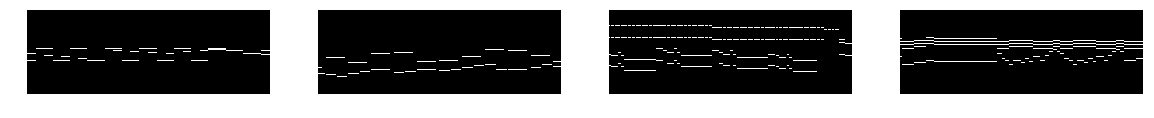

(4, 32, 32, 3)


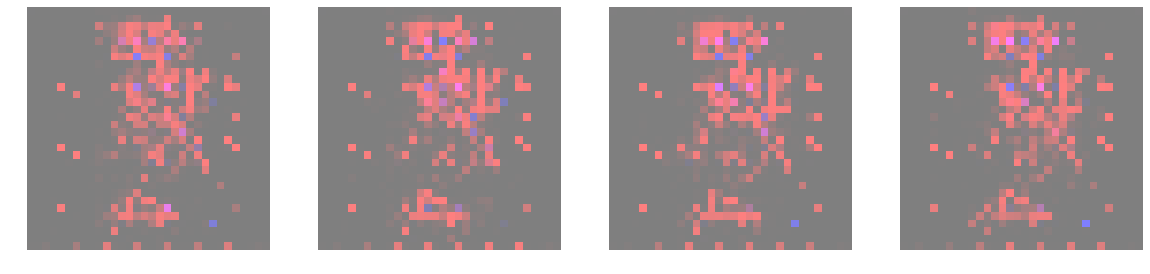

(4, 88, 256, 1)


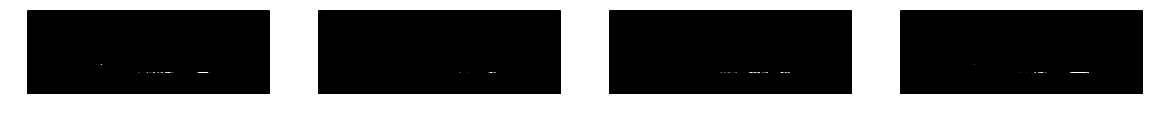

(4, 32, 32, 3)


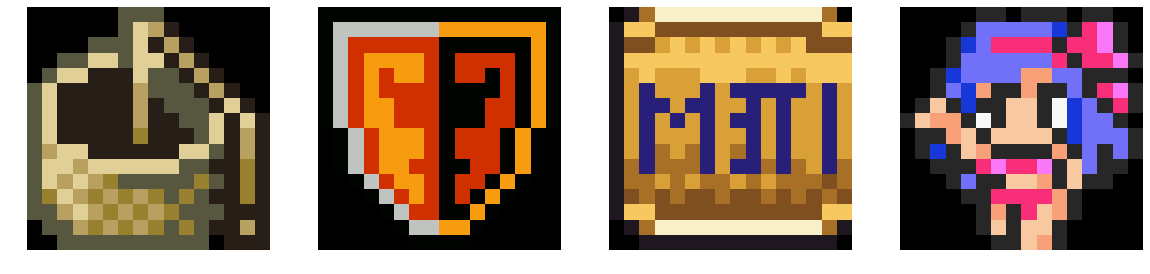

(4, 88, 256, 1)


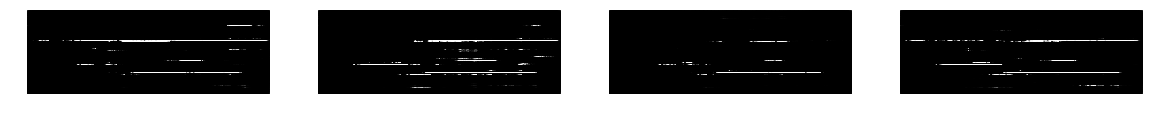

(4, 32, 32, 3)


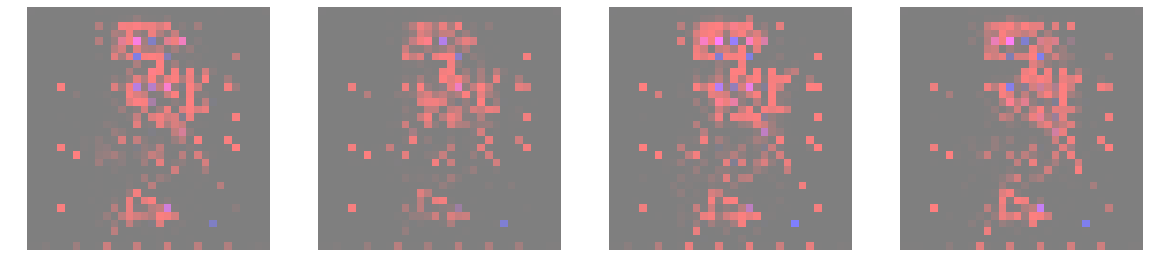

[31/110][10775] Loss_D: 0.052687 0.009551 Loss_G: 1.083218 1.006060 loss_cyc 0.855815 55.401
[31/110][10800] Loss_D: 0.080074 0.005651 Loss_G: 1.163108 1.007390 loss_cyc 0.848354 55.519
[31/110][10825] Loss_D: 0.112007 0.007768 Loss_G: 1.141336 1.020043 loss_cyc 0.856649 55.644
[31/110][10850] Loss_D: 0.077824 0.006766 Loss_G: 1.060751 1.006680 loss_cyc 0.831580 55.767
[31/110][10875] Loss_D: 0.058298 0.010983 Loss_G: 1.099724 1.015827 loss_cyc 0.840838 55.896
[31/110][10900] Loss_D: 0.067711 0.007920 Loss_G: 1.031144 0.993712 loss_cyc 0.843065 56.025
[31/110][10925] Loss_D: 0.088455 0.013307 Loss_G: 1.016252 1.026107 loss_cyc 0.818466 56.146
[31/110][10950] Loss_D: 0.111331 0.006130 Loss_G: 1.106570 1.002742 loss_cyc 0.857714 56.265
[31/110][10975] Loss_D: 0.062989 0.020941 Loss_G: 1.043869 1.025996 loss_cyc 0.844890 56.386
[31/110][11000] Loss_D: 0.080956 0.012759 Loss_G: 1.055496 1.016308 loss_cyc 0.850585 56.510
[31/110][11025] Loss_D: 0.101591 0.018717 Loss_G: 1.148483 1.023959 lo

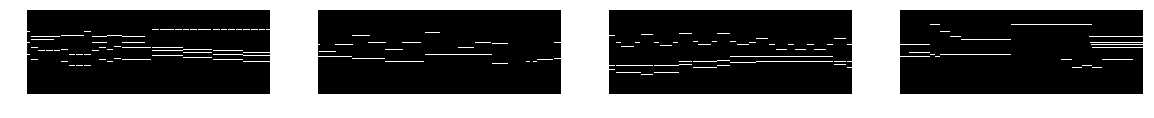

(4, 32, 32, 3)


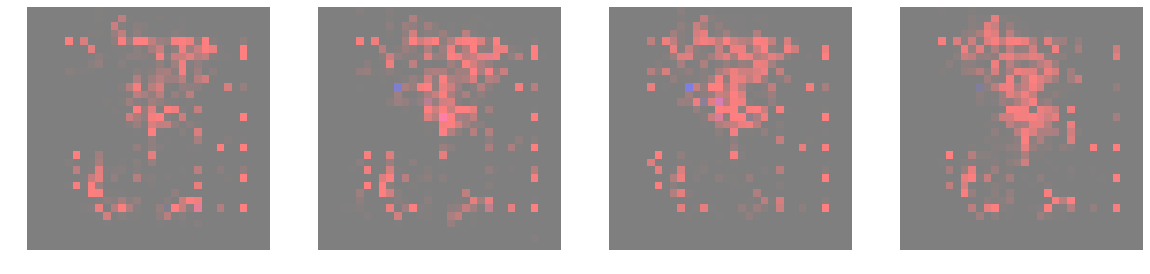

(4, 88, 256, 1)


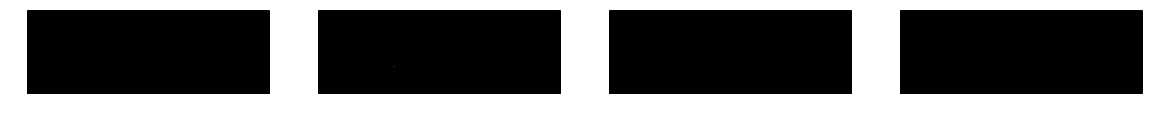

(4, 32, 32, 3)


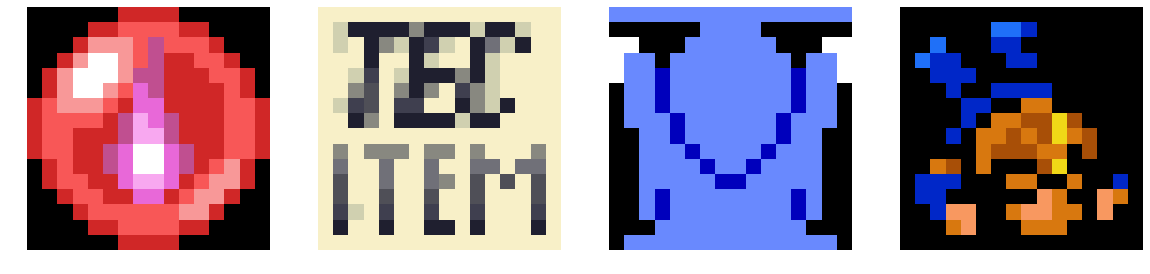

(4, 88, 256, 1)


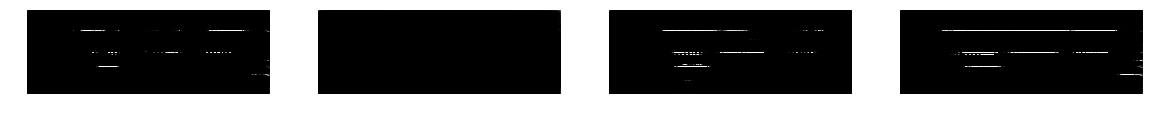

(4, 32, 32, 3)


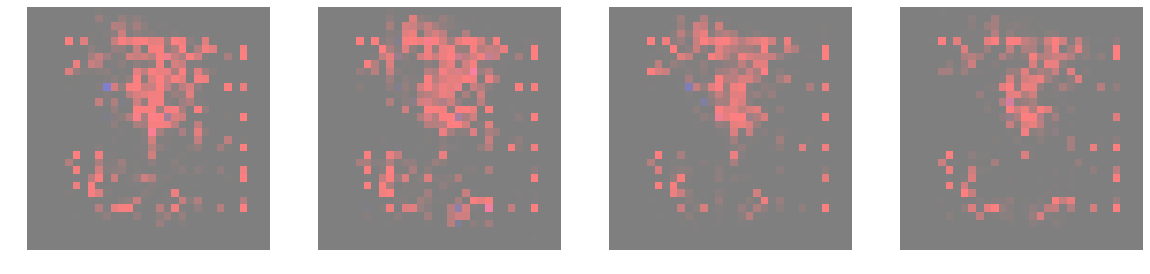

[32/110][11125] Loss_D: 0.074548 0.018811 Loss_G: 1.008512 1.027295 loss_cyc 0.807050 57.192
[32/110][11150] Loss_D: 0.036786 0.046444 Loss_G: 1.021330 1.048012 loss_cyc 0.853152 57.309
[32/110][11175] Loss_D: 0.055766 0.008799 Loss_G: 1.101299 1.019116 loss_cyc 0.886982 57.429
[32/110][11200] Loss_D: 0.036976 0.011108 Loss_G: 1.023341 1.012522 loss_cyc 0.839074 57.558
[32/110][11225] Loss_D: 0.039833 0.008597 Loss_G: 1.035655 1.012069 loss_cyc 0.846581 57.681
[32/110][11250] Loss_D: 0.045339 0.010338 Loss_G: 1.082020 1.012459 loss_cyc 0.855793 57.808
[32/110][11275] Loss_D: 0.042138 0.008372 Loss_G: 1.035218 1.001098 loss_cyc 0.851689 57.927
[32/110][11300] Loss_D: 0.042788 0.004861 Loss_G: 0.961021 0.999993 loss_cyc 0.826124 58.053
[32/110][11325] Loss_D: 0.062099 0.008077 Loss_G: 1.100112 1.014696 loss_cyc 0.852349 58.181
[32/110][11350] Loss_D: 0.059691 0.015820 Loss_G: 1.036116 1.014760 loss_cyc 0.840446 58.308
[32/110][11375] Loss_D: 0.142079 0.005219 Loss_G: 1.025715 0.996392 lo

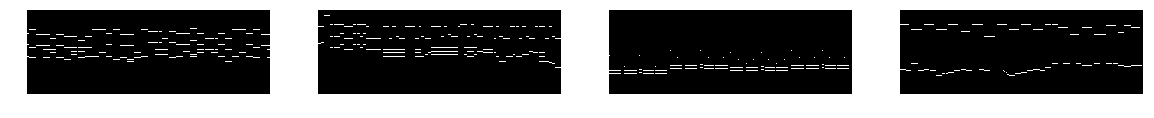

(4, 32, 32, 3)


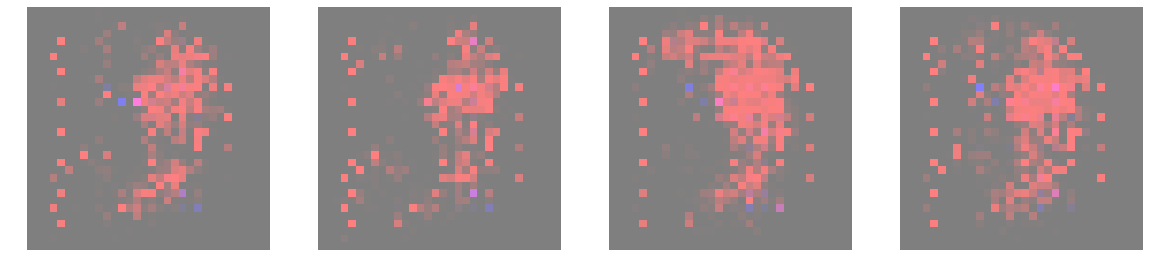

(4, 88, 256, 1)


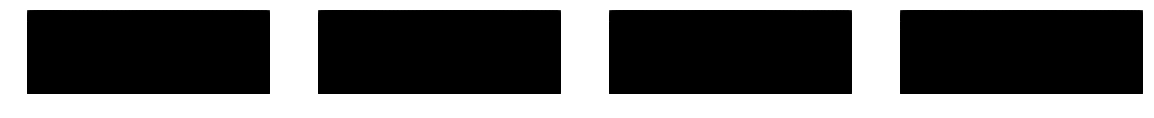

(4, 32, 32, 3)


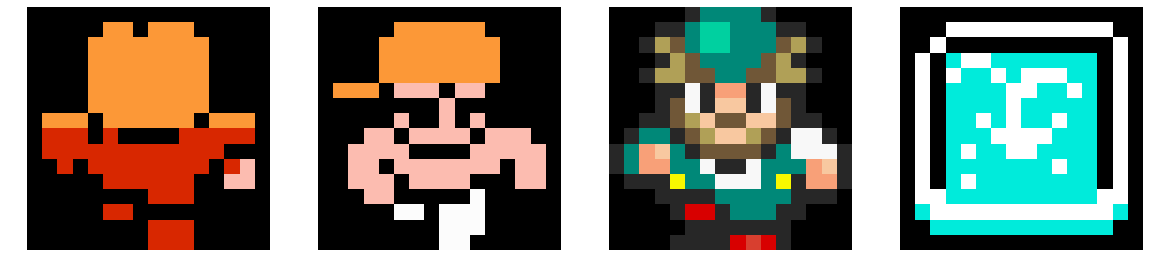

(4, 88, 256, 1)


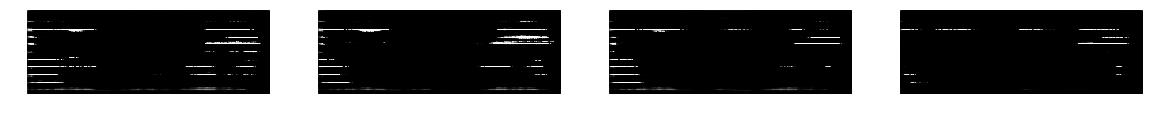

(4, 32, 32, 3)


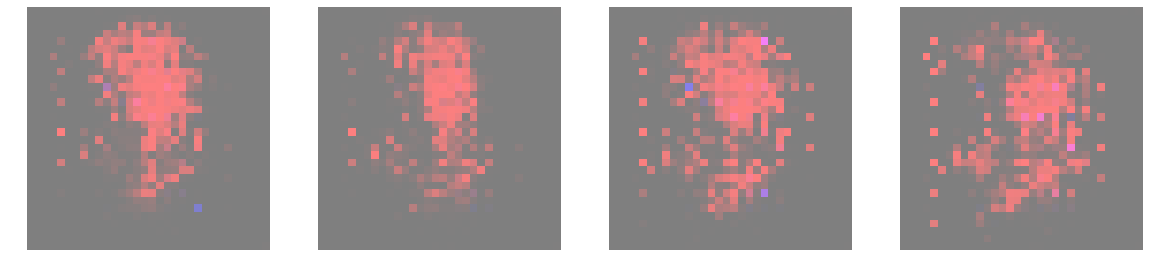

[33/110][11475] Loss_D: 0.074806 0.003796 Loss_G: 1.120602 1.007375 loss_cyc 0.826314 58.979
[33/110][11500] Loss_D: 0.071099 0.015747 Loss_G: 1.020134 1.005373 loss_cyc 0.829018 59.109
[33/110][11525] Loss_D: 0.040350 0.020321 Loss_G: 0.981226 1.027793 loss_cyc 0.857670 59.235
[33/110][11550] Loss_D: 0.049237 0.025882 Loss_G: 1.166922 1.029533 loss_cyc 0.841398 59.352
[33/110][11575] Loss_D: 0.079084 0.030514 Loss_G: 1.101742 1.041149 loss_cyc 0.848251 59.484
[33/110][11600] Loss_D: 0.092042 0.009796 Loss_G: 1.090864 1.013134 loss_cyc 0.842332 59.613
[33/110][11625] Loss_D: 0.049804 0.003780 Loss_G: 0.974020 1.007654 loss_cyc 0.849166 59.737
[33/110][11650] Loss_D: 0.143955 0.020749 Loss_G: 1.052420 1.010727 loss_cyc 0.833242 59.865
[33/110][11675] Loss_D: 0.086580 0.011002 Loss_G: 1.138400 1.000984 loss_cyc 0.848778 59.980
[33/110][11700] Loss_D: 0.066520 0.052810 Loss_G: 1.040178 1.069175 loss_cyc 0.837302 60.092
[33/110][11725] Loss_D: 0.083540 0.018562 Loss_G: 1.107323 1.031243 lo

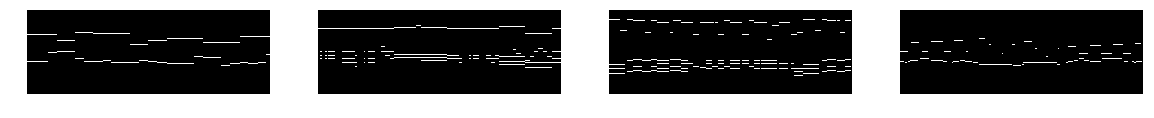

(4, 32, 32, 3)


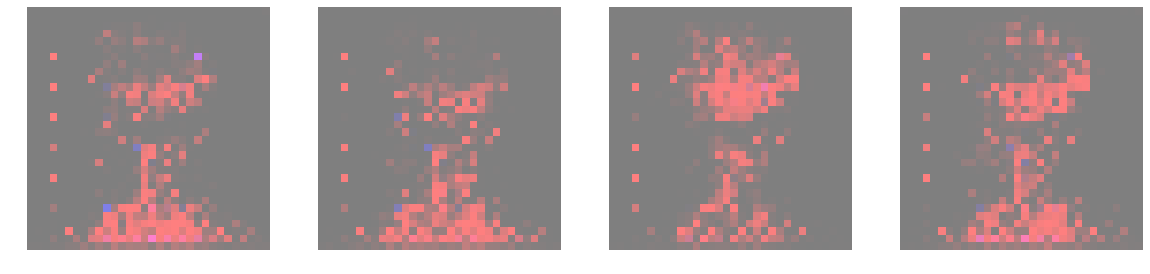

(4, 88, 256, 1)


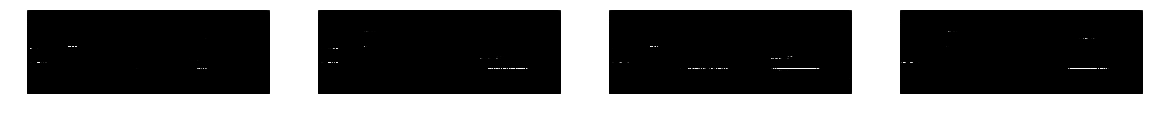

(4, 32, 32, 3)


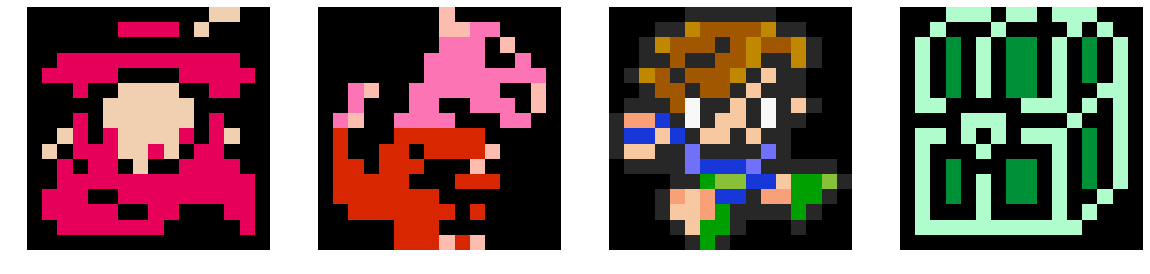

(4, 88, 256, 1)


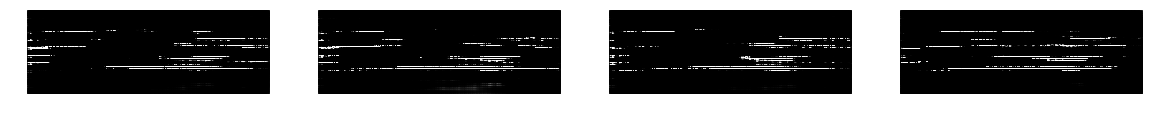

(4, 32, 32, 3)


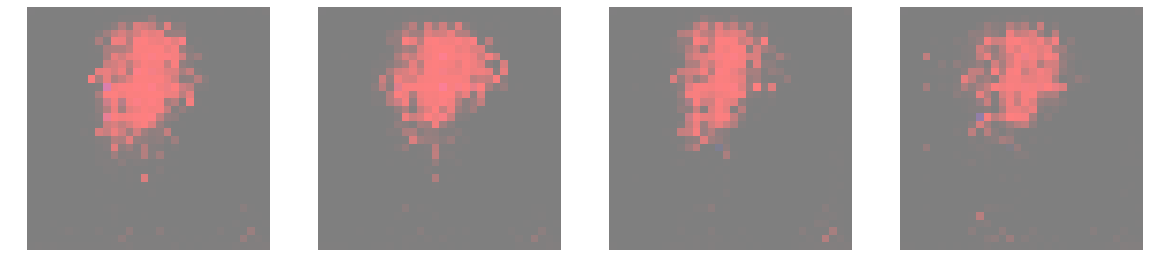

[34/110][11825] Loss_D: 0.073821 0.005271 Loss_G: 0.962737 0.997718 loss_cyc 0.841405 60.754
[34/110][11850] Loss_D: 0.070633 0.008740 Loss_G: 0.957055 1.016934 loss_cyc 0.855255 60.885
[34/110][11875] Loss_D: 0.083918 0.008717 Loss_G: 0.987398 1.002721 loss_cyc 0.847957 61.020
[34/110][11900] Loss_D: 0.068854 0.007833 Loss_G: 1.010327 1.009980 loss_cyc 0.844075 61.144
[34/110][11925] Loss_D: 0.186968 0.004627 Loss_G: 1.057920 1.007750 loss_cyc 0.839667 61.265
[34/110][11950] Loss_D: 0.131221 0.009413 Loss_G: 0.968926 1.016521 loss_cyc 0.843408 61.376
[34/110][11975] Loss_D: 0.121120 0.005711 Loss_G: 1.021331 1.001597 loss_cyc 0.838900 61.493
[34/110][12000] Loss_D: 0.117157 0.003884 Loss_G: 0.855668 1.006106 loss_cyc 0.854492 61.611
[34/110][12025] Loss_D: 0.096507 0.008481 Loss_G: 1.078295 1.009115 loss_cyc 0.837444 61.731
[34/110][12050] Loss_D: 0.057636 0.028022 Loss_G: 1.123698 1.023791 loss_cyc 0.830971 61.857
[34/110][12075] Loss_D: 0.112297 0.019910 Loss_G: 1.070348 1.029116 lo

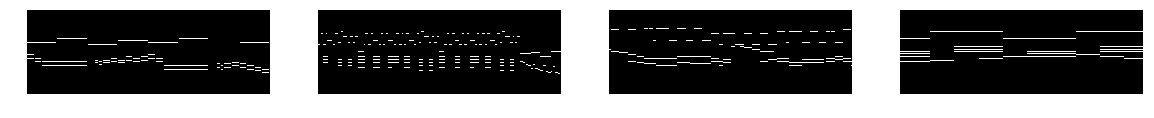

(4, 32, 32, 3)


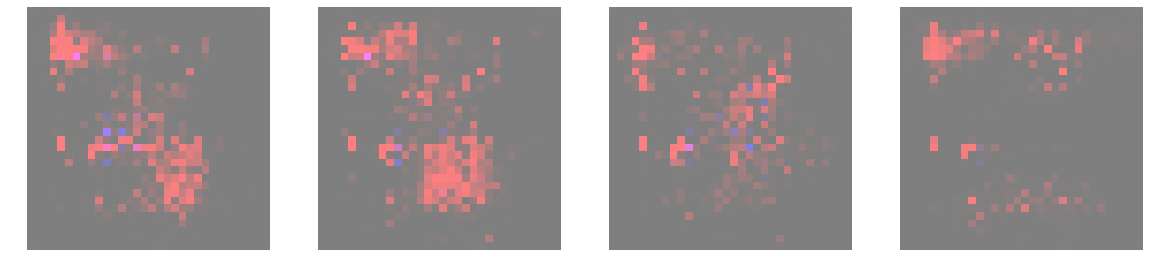

(4, 88, 256, 1)


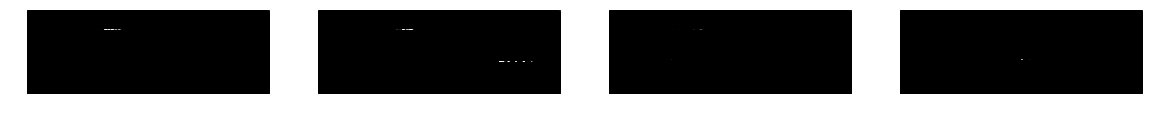

(4, 32, 32, 3)


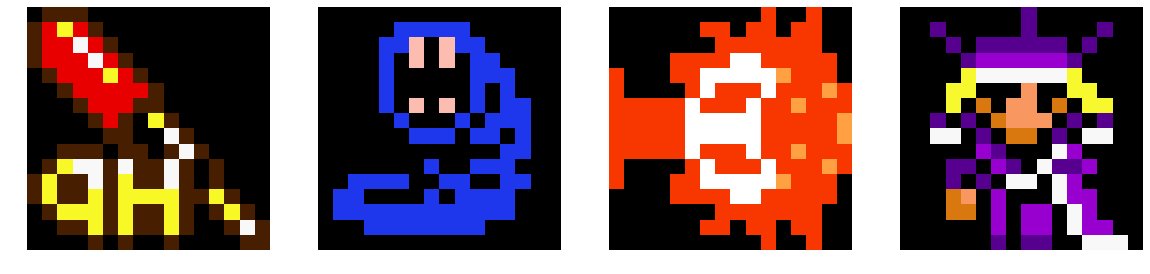

(4, 88, 256, 1)


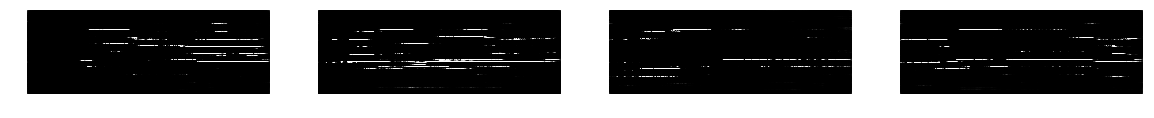

(4, 32, 32, 3)


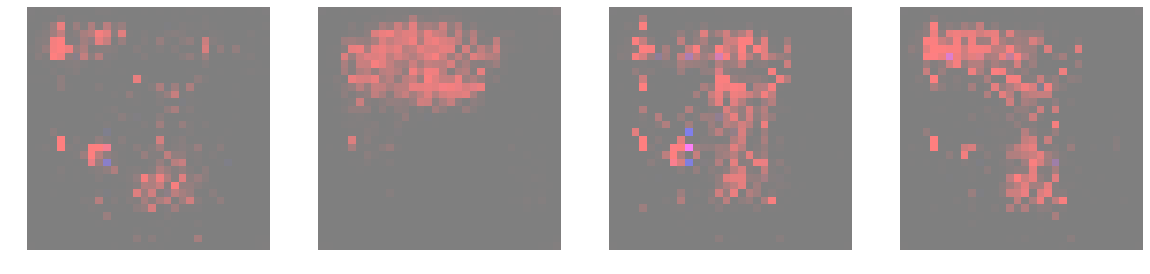

[35/110][12150] Loss_D: 0.092521 0.006251 Loss_G: 1.020450 1.013411 loss_cyc 0.836850 62.399
[35/110][12175] Loss_D: 0.124618 0.084744 Loss_G: 1.055034 1.074387 loss_cyc 0.822616 62.526
[35/110][12200] Loss_D: 0.077556 0.035400 Loss_G: 0.964227 1.068160 loss_cyc 0.870970 62.645
[35/110][12225] Loss_D: 0.078226 0.017119 Loss_G: 0.979622 1.040532 loss_cyc 0.828438 62.769
[35/110][12250] Loss_D: 0.068249 0.007744 Loss_G: 1.071893 1.013777 loss_cyc 0.842941 62.906
[35/110][12275] Loss_D: 0.058485 0.015723 Loss_G: 0.981940 1.032092 loss_cyc 0.861593 63.033
[35/110][12300] Loss_D: 0.064517 0.007998 Loss_G: 1.050274 1.008226 loss_cyc 0.864478 63.148
[35/110][12325] Loss_D: 0.062964 0.010388 Loss_G: 0.821187 1.015894 loss_cyc 0.853300 63.272
[35/110][12350] Loss_D: 0.065240 0.004243 Loss_G: 1.089356 1.002825 loss_cyc 0.828301 63.391
[35/110][12375] Loss_D: 0.065301 0.004797 Loss_G: 0.950904 1.008386 loss_cyc 0.847576 63.509
[35/110][12400] Loss_D: 0.065314 0.007780 Loss_G: 0.971718 1.001853 lo

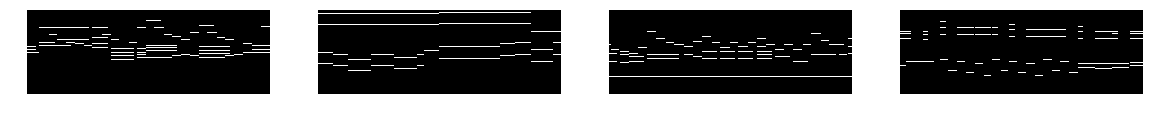

(4, 32, 32, 3)


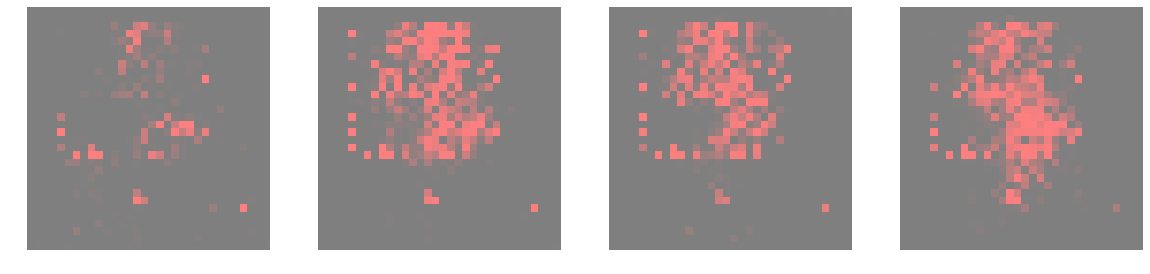

(4, 88, 256, 1)


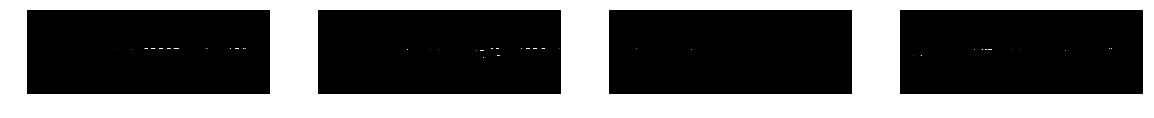

(4, 32, 32, 3)


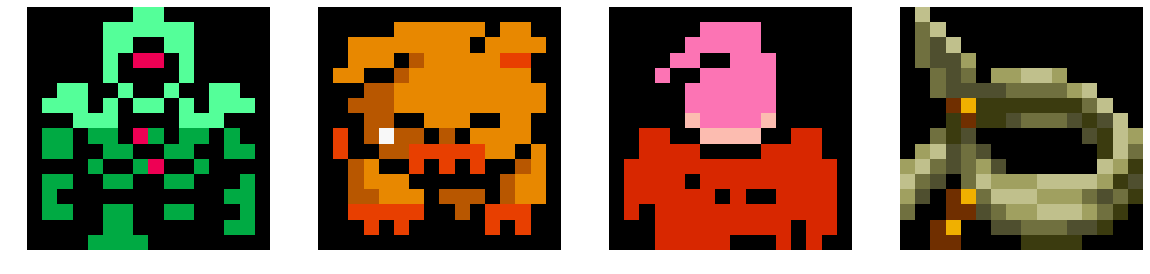

(4, 88, 256, 1)


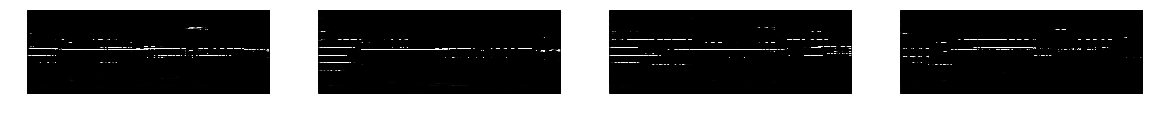

(4, 32, 32, 3)


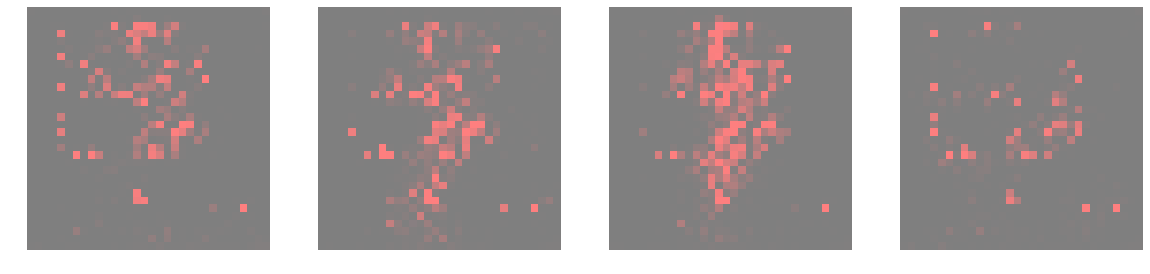

[36/110][12500] Loss_D: 0.056589 0.001945 Loss_G: 0.916048 0.998848 loss_cyc 0.852710 64.172
[36/110][12525] Loss_D: 0.078316 0.003722 Loss_G: 0.964205 1.003139 loss_cyc 0.848980 64.302
[36/110][12550] Loss_D: 0.074655 0.003057 Loss_G: 1.021908 0.998366 loss_cyc 0.823256 64.413
[36/110][12575] Loss_D: 0.062459 0.003396 Loss_G: 0.950581 0.996036 loss_cyc 0.822060 64.537
[36/110][12600] Loss_D: 0.057161 0.018154 Loss_G: 1.076524 1.007643 loss_cyc 0.847231 64.655
[36/110][12625] Loss_D: 0.060969 0.021316 Loss_G: 0.948710 1.025652 loss_cyc 0.852926 64.771
[36/110][12650] Loss_D: 0.054000 0.007185 Loss_G: 0.961988 1.009589 loss_cyc 0.828390 64.885
[36/110][12675] Loss_D: 0.062492 0.004176 Loss_G: 1.021179 1.007110 loss_cyc 0.824358 65.006
[36/110][12700] Loss_D: 0.097121 0.014560 Loss_G: 1.007339 1.014942 loss_cyc 0.845369 65.137
[36/110][12725] Loss_D: 0.112616 0.007383 Loss_G: 0.901869 0.995585 loss_cyc 0.847592 65.254
[36/110][12750] Loss_D: 0.049400 0.012574 Loss_G: 0.919587 1.027492 lo

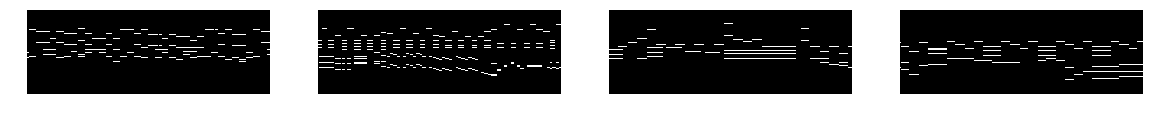

(4, 32, 32, 3)


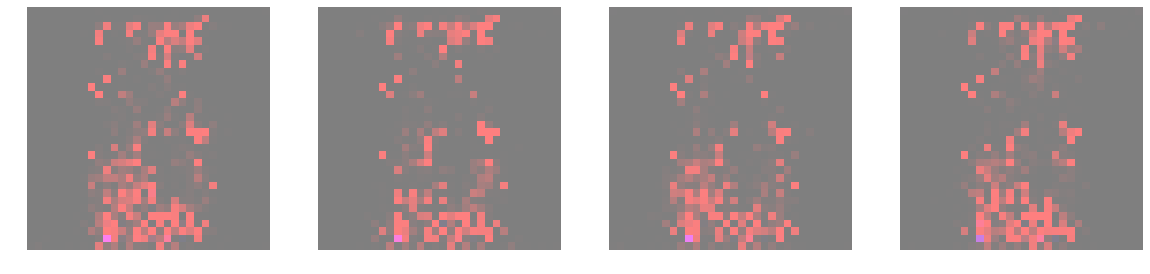

(4, 88, 256, 1)


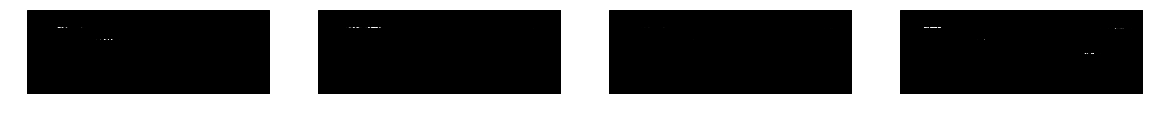

(4, 32, 32, 3)


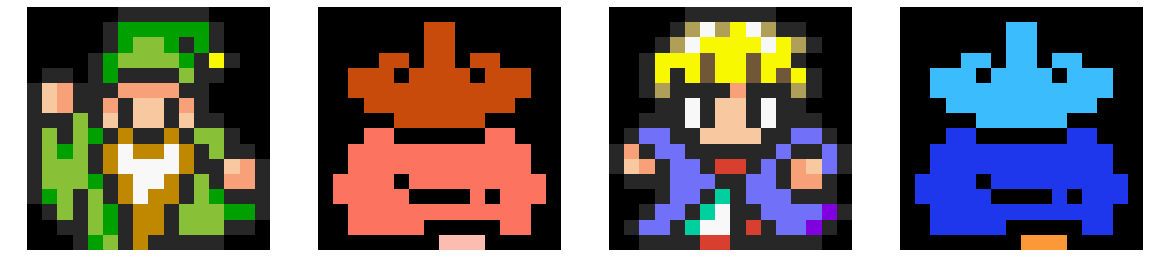

(4, 88, 256, 1)


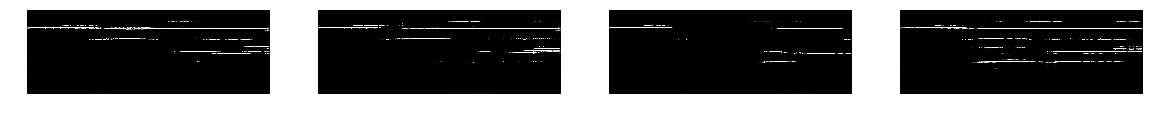

(4, 32, 32, 3)


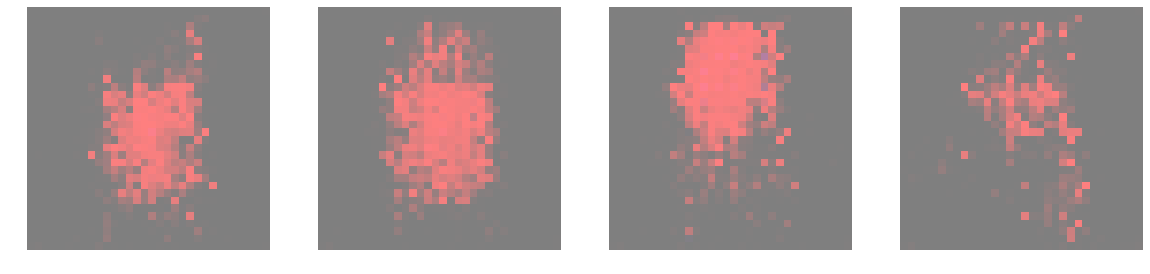

[37/110][12850] Loss_D: 0.050996 0.002823 Loss_G: 0.943898 1.020952 loss_cyc 0.824574 65.955
[37/110][12875] Loss_D: 0.041892 0.005604 Loss_G: 0.972012 0.992529 loss_cyc 0.825605 66.074
[37/110][12900] Loss_D: 0.055872 0.005343 Loss_G: 1.003831 1.008956 loss_cyc 0.825092 66.192
[37/110][12925] Loss_D: 0.087860 0.004414 Loss_G: 1.029109 1.003515 loss_cyc 0.847714 66.320
[37/110][12950] Loss_D: 0.063473 0.008437 Loss_G: 1.006397 1.015062 loss_cyc 0.827228 66.441
[37/110][12975] Loss_D: 0.039290 0.005624 Loss_G: 0.990556 1.002800 loss_cyc 0.819476 66.560
[37/110][13000] Loss_D: 0.034489 0.012222 Loss_G: 1.002727 1.005896 loss_cyc 0.859354 66.681
[37/110][13025] Loss_D: 0.035389 0.005859 Loss_G: 1.038689 1.017132 loss_cyc 0.854794 66.802
[37/110][13050] Loss_D: 0.062635 0.027595 Loss_G: 1.050135 1.028144 loss_cyc 0.831396 66.918
[37/110][13075] Loss_D: 0.034236 0.048725 Loss_G: 1.017294 1.048200 loss_cyc 0.857185 67.048
[37/110][13100] Loss_D: 0.025530 0.014671 Loss_G: 0.969381 1.029545 lo

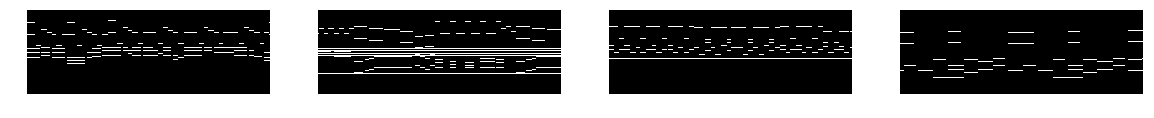

(4, 32, 32, 3)


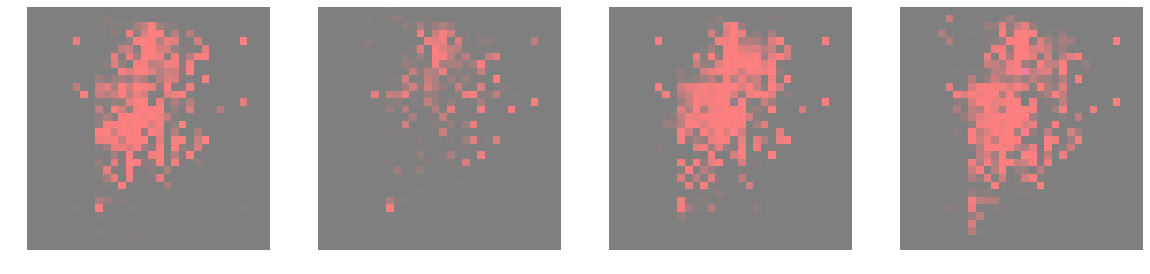

(4, 88, 256, 1)


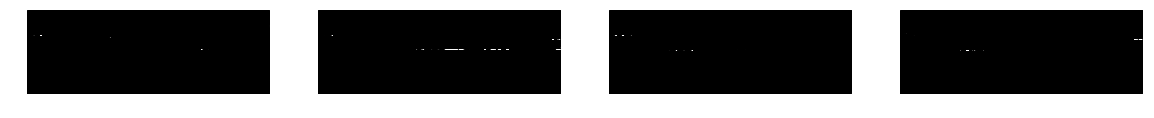

(4, 32, 32, 3)


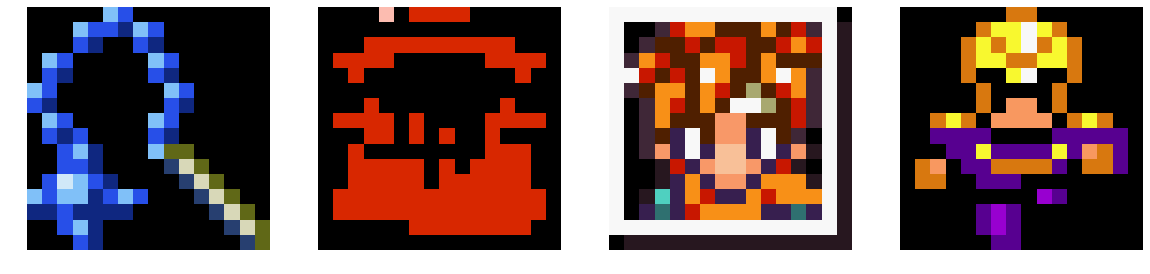

(4, 88, 256, 1)


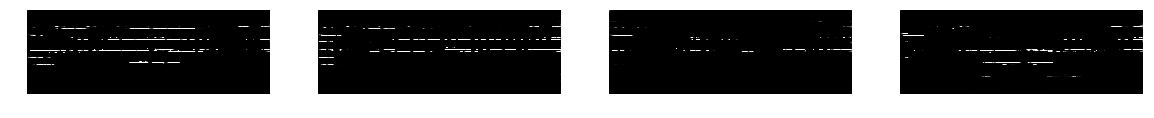

(4, 32, 32, 3)


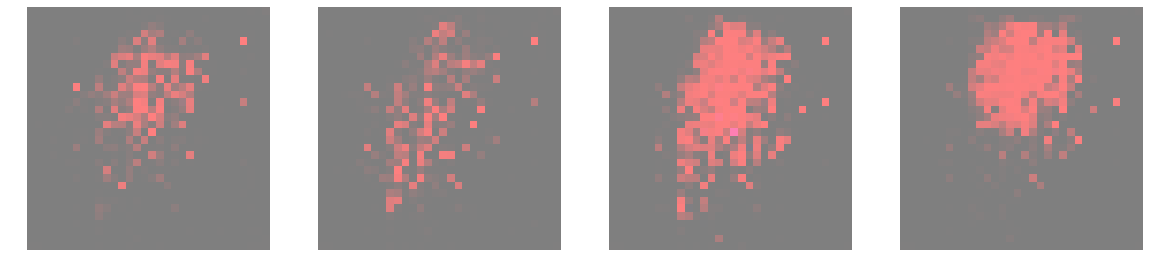

[38/110][13200] Loss_D: 0.060852 0.006457 Loss_G: 1.019153 1.016385 loss_cyc 0.826921 67.722
[38/110][13225] Loss_D: 0.054980 0.005755 Loss_G: 1.032989 1.003526 loss_cyc 0.839556 67.836
[38/110][13250] Loss_D: 0.041676 0.013608 Loss_G: 0.967705 1.007385 loss_cyc 0.866342 67.968
[38/110][13275] Loss_D: 0.032540 0.005143 Loss_G: 1.035306 1.006980 loss_cyc 0.854074 68.094
[38/110][13300] Loss_D: 0.043453 0.011360 Loss_G: 0.987511 1.002624 loss_cyc 0.851944 68.211
[38/110][13325] Loss_D: 0.031598 0.003944 Loss_G: 0.972134 1.003747 loss_cyc 0.841032 68.326
[38/110][13350] Loss_D: 0.029267 0.003971 Loss_G: 0.998609 1.011347 loss_cyc 0.848162 68.457
[38/110][13375] Loss_D: 0.050404 0.007748 Loss_G: 1.008625 1.005643 loss_cyc 0.848767 68.575
[38/110][13400] Loss_D: 0.047325 0.003620 Loss_G: 1.016026 1.008161 loss_cyc 0.842430 68.696
[38/110][13425] Loss_D: 0.055474 0.003871 Loss_G: 1.010946 1.000690 loss_cyc 0.837921 68.811
[38/110][13450] Loss_D: 0.067828 0.002709 Loss_G: 1.014100 1.000784 lo

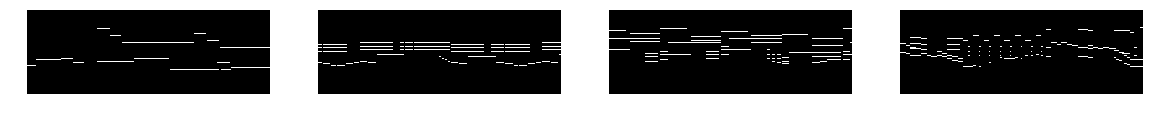

(4, 32, 32, 3)


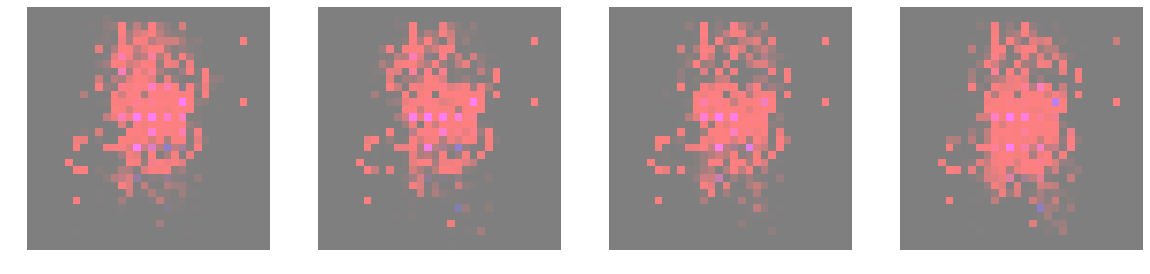

(4, 88, 256, 1)


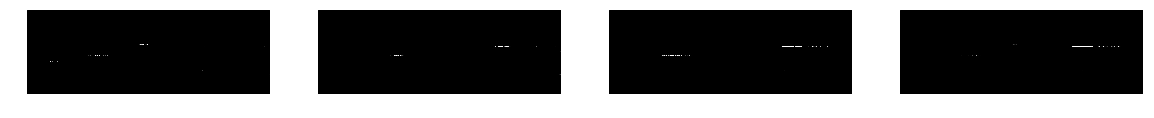

(4, 32, 32, 3)


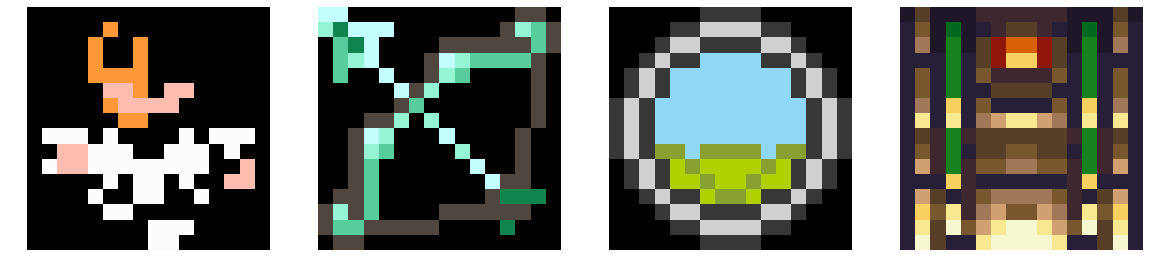

(4, 88, 256, 1)


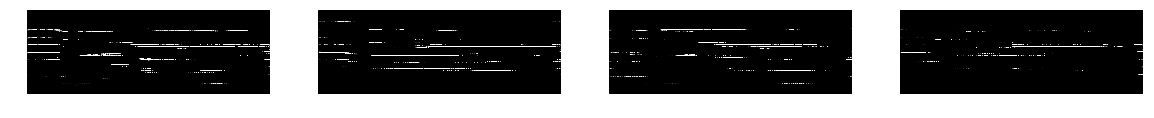

(4, 32, 32, 3)


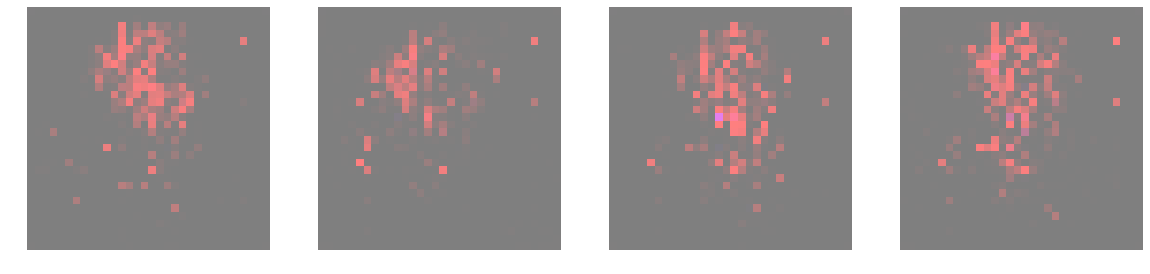

[39/110][13550] Loss_D: 0.072992 0.003646 Loss_G: 0.977228 1.002888 loss_cyc 0.837912 69.478
[39/110][13575] Loss_D: 0.091290 0.004338 Loss_G: 1.003306 1.006517 loss_cyc 0.842150 69.594
[39/110][13600] Loss_D: 0.093294 0.001042 Loss_G: 0.963041 1.003577 loss_cyc 0.835349 69.714
[39/110][13625] Loss_D: 0.082363 0.003897 Loss_G: 0.848973 1.004562 loss_cyc 0.819347 69.834
[39/110][13650] Loss_D: 0.110434 0.011332 Loss_G: 1.044808 1.002673 loss_cyc 0.848113 69.947
[39/110][13675] Loss_D: 0.054424 0.023242 Loss_G: 0.902963 1.030739 loss_cyc 0.876488 70.073
[39/110][13700] Loss_D: 0.081285 0.014385 Loss_G: 0.986110 1.009155 loss_cyc 0.842527 70.195
[39/110][13725] Loss_D: 0.108014 0.006645 Loss_G: 1.027894 1.006252 loss_cyc 0.862437 70.326
[39/110][13750] Loss_D: 0.085566 0.013122 Loss_G: 0.902807 1.014310 loss_cyc 0.833426 70.459
[39/110][13775] Loss_D: 0.076081 0.005435 Loss_G: 0.942720 1.006300 loss_cyc 0.843098 70.589
[39/110][13800] Loss_D: 0.068712 0.006835 Loss_G: 0.992101 1.013483 lo

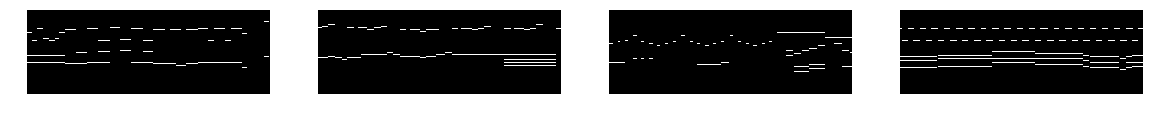

(4, 32, 32, 3)


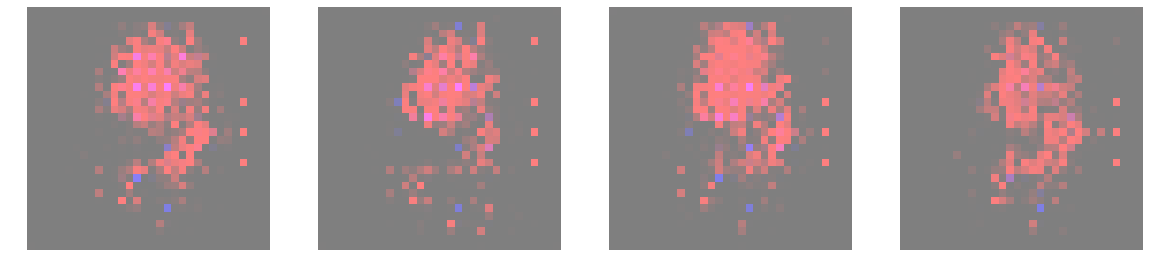

(4, 88, 256, 1)


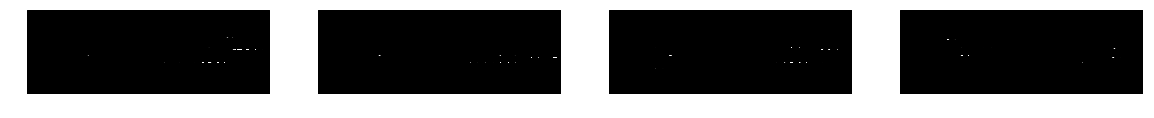

(4, 32, 32, 3)


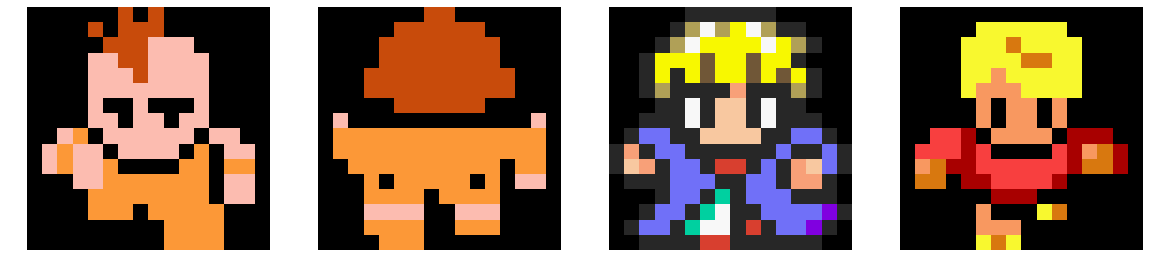

(4, 88, 256, 1)


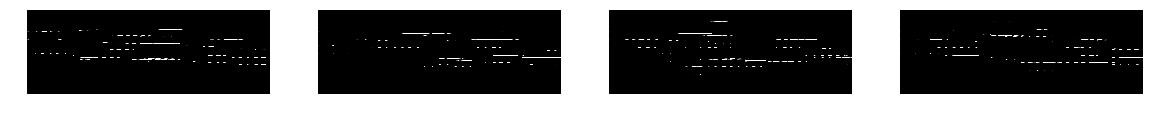

(4, 32, 32, 3)


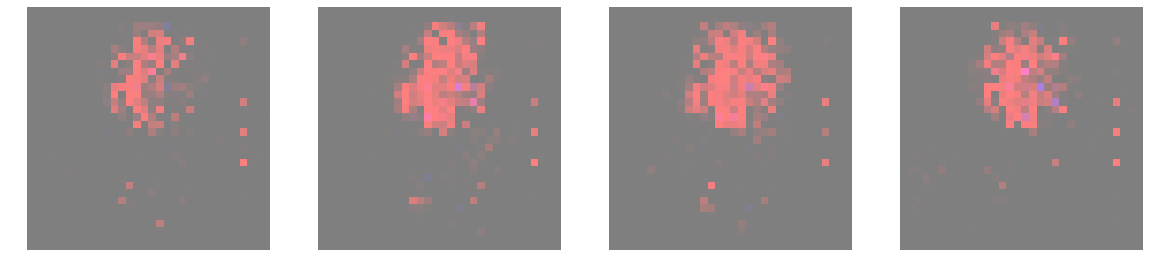

[40/110][13900] Loss_D: 0.057299 0.006061 Loss_G: 0.913473 0.999848 loss_cyc 0.837808 71.245
[40/110][13925] Loss_D: 0.062707 0.002987 Loss_G: 0.922344 1.005077 loss_cyc 0.838976 71.379
[40/110][13950] Loss_D: 0.050956 0.009093 Loss_G: 0.925523 1.014262 loss_cyc 0.869741 71.506
[40/110][13975] Loss_D: 0.043013 0.017314 Loss_G: 0.956819 1.011915 loss_cyc 0.836769 71.626
[40/110][14000] Loss_D: 0.056901 0.016513 Loss_G: 0.910100 1.039286 loss_cyc 0.819550 71.741
[40/110][14025] Loss_D: 0.063521 0.066301 Loss_G: 0.998927 1.101064 loss_cyc 0.803374 71.855
[40/110][14050] Loss_D: 0.054155 0.009012 Loss_G: 1.000104 0.993504 loss_cyc 0.846226 71.971
[40/110][14075] Loss_D: 0.062545 0.004862 Loss_G: 0.979565 1.010984 loss_cyc 0.854042 72.094
[40/110][14100] Loss_D: 0.068322 0.005219 Loss_G: 1.030920 1.005587 loss_cyc 0.845925 72.212
[40/110][14125] Loss_D: 0.042341 0.007644 Loss_G: 0.900484 1.019274 loss_cyc 0.868178 72.338
[40/110][14150] Loss_D: 0.050672 0.005648 Loss_G: 0.984041 1.003920 lo

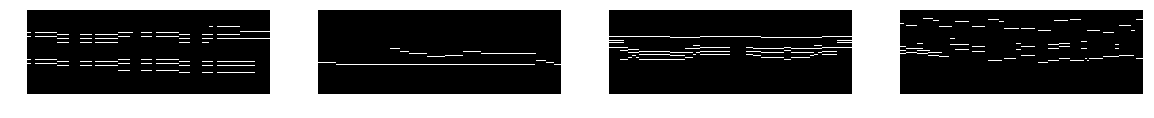

(4, 32, 32, 3)


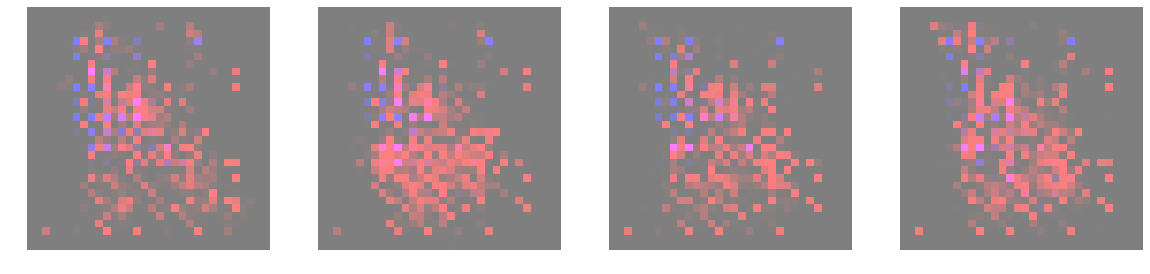

(4, 88, 256, 1)


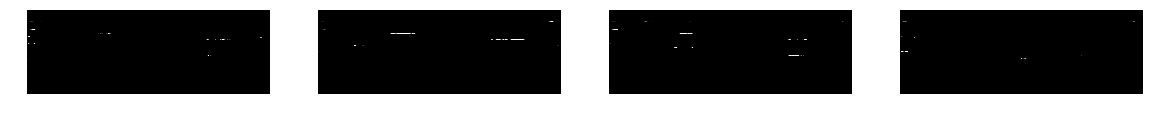

(4, 32, 32, 3)


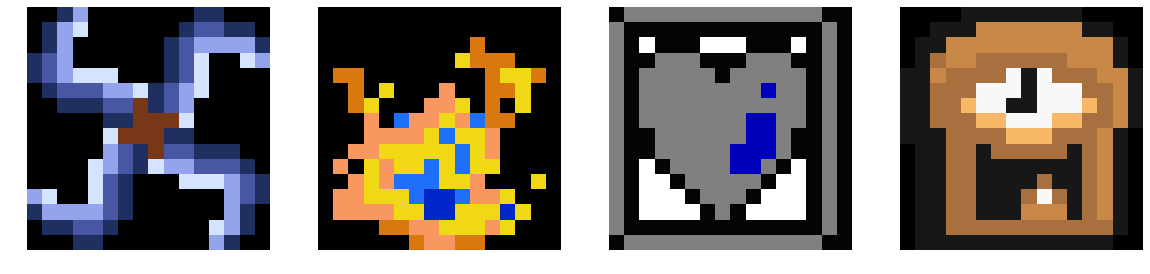

(4, 88, 256, 1)


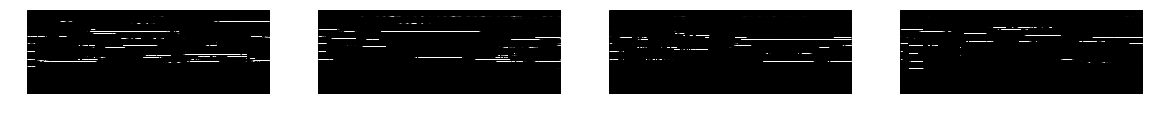

(4, 32, 32, 3)


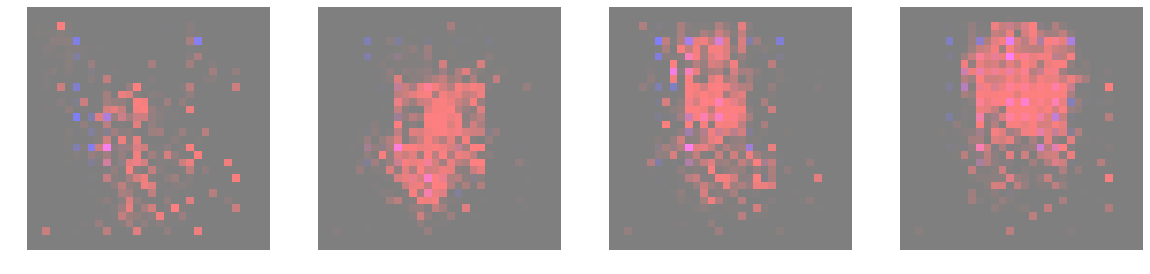

[41/110][14250] Loss_D: 0.057379 0.008581 Loss_G: 1.044021 1.022257 loss_cyc 0.836597 73.016
[41/110][14275] Loss_D: 0.039235 0.010924 Loss_G: 0.940812 1.008574 loss_cyc 0.845922 73.135
[41/110][14300] Loss_D: 0.056579 0.008144 Loss_G: 0.947109 1.000711 loss_cyc 0.853237 73.261
[41/110][14325] Loss_D: 0.061937 0.006162 Loss_G: 0.915464 1.006773 loss_cyc 0.835203 73.390
[41/110][14350] Loss_D: 0.049344 0.009049 Loss_G: 0.954072 1.006673 loss_cyc 0.819438 73.509
[41/110][14375] Loss_D: 0.038317 0.003082 Loss_G: 0.979172 1.008974 loss_cyc 0.844544 73.628
[41/110][14400] Loss_D: 0.057631 0.011912 Loss_G: 0.951663 1.009694 loss_cyc 0.839270 73.753
[41/110][14425] Loss_D: 0.076028 0.007400 Loss_G: 0.999511 1.006277 loss_cyc 0.830731 73.874
[41/110][14450] Loss_D: 0.046541 0.004159 Loss_G: 0.992159 1.007327 loss_cyc 0.838240 73.991
[41/110][14475] Loss_D: 0.065271 0.010026 Loss_G: 0.859052 1.013631 loss_cyc 0.859126 74.116
[41/110][14500] Loss_D: 0.062573 0.001048 Loss_G: 1.071382 1.001616 lo

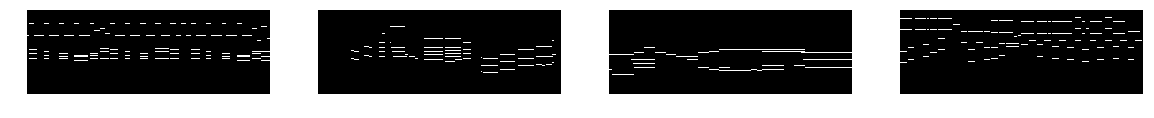

(4, 32, 32, 3)


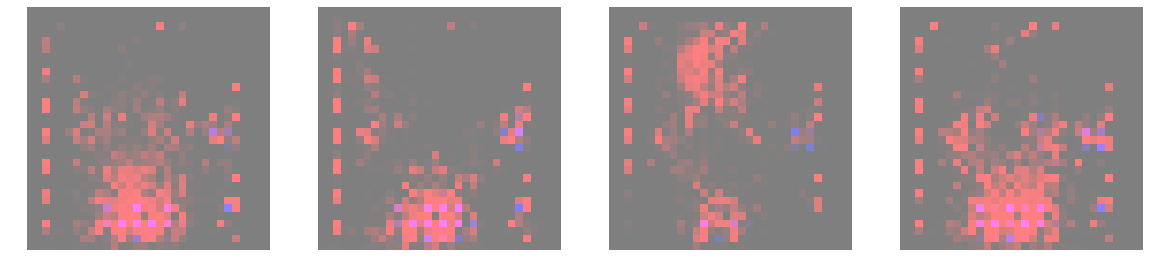

(4, 88, 256, 1)


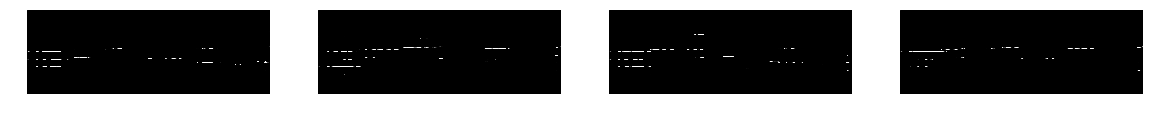

(4, 32, 32, 3)


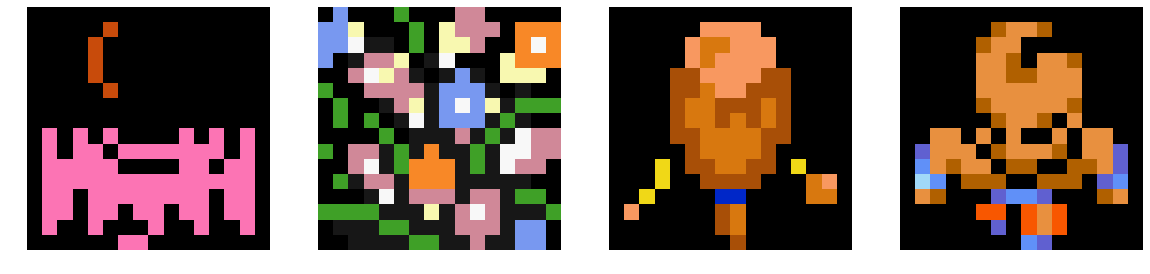

(4, 88, 256, 1)


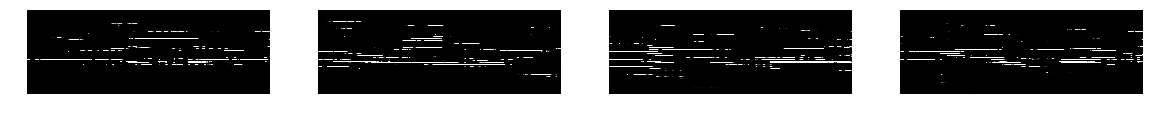

(4, 32, 32, 3)


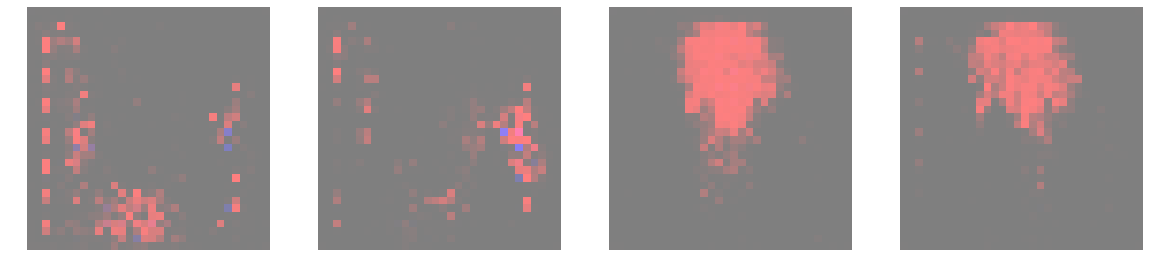

[42/110][14600] Loss_D: 0.055252 0.007387 Loss_G: 0.994859 1.008647 loss_cyc 0.843040 74.786
[42/110][14625] Loss_D: 0.038125 0.005105 Loss_G: 0.991956 1.013921 loss_cyc 0.855630 74.902
[42/110][14650] Loss_D: 0.075734 0.010149 Loss_G: 0.949936 1.008286 loss_cyc 0.843079 75.028
[42/110][14675] Loss_D: 0.048545 0.005046 Loss_G: 0.943453 1.004182 loss_cyc 0.840938 75.157
[42/110][14700] Loss_D: 0.040804 0.002825 Loss_G: 0.983148 1.003291 loss_cyc 0.830875 75.279
[42/110][14725] Loss_D: 0.069417 0.005110 Loss_G: 0.875087 1.009160 loss_cyc 0.838137 75.408
[42/110][14750] Loss_D: 0.040669 0.003894 Loss_G: 0.965612 0.997469 loss_cyc 0.848193 75.520
[42/110][14775] Loss_D: 0.043691 0.007042 Loss_G: 0.923789 1.015379 loss_cyc 0.826703 75.647
[42/110][14800] Loss_D: 0.052363 0.007299 Loss_G: 0.907242 1.005200 loss_cyc 0.844887 75.761
[42/110][14825] Loss_D: 0.044891 0.001627 Loss_G: 0.963863 1.001610 loss_cyc 0.860362 75.879
[42/110][14850] Loss_D: 0.058070 0.004234 Loss_G: 0.920268 1.003543 lo

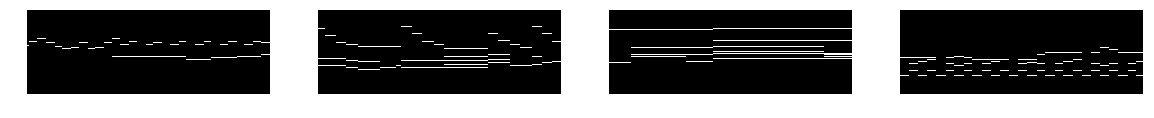

(4, 32, 32, 3)


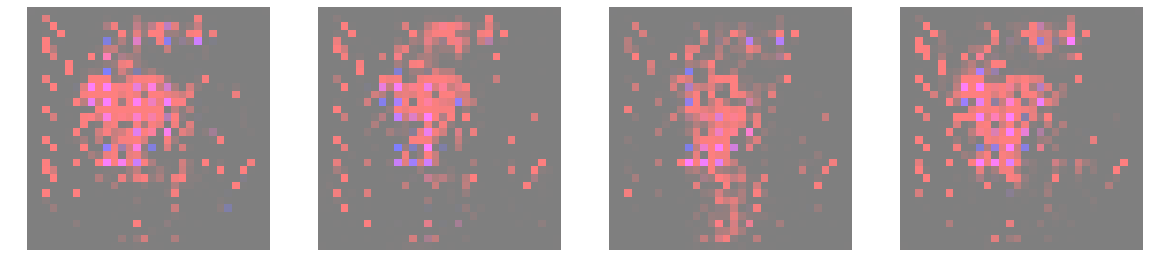

(4, 88, 256, 1)


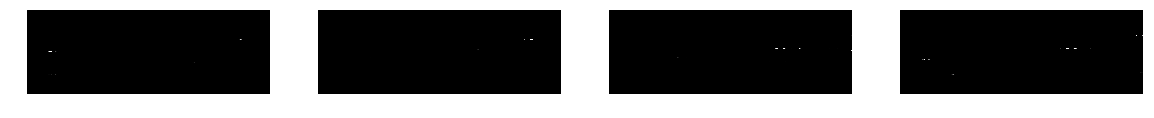

(4, 32, 32, 3)


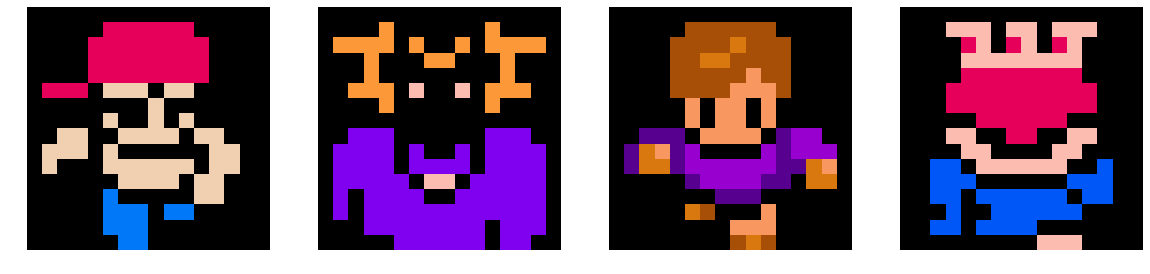

(4, 88, 256, 1)


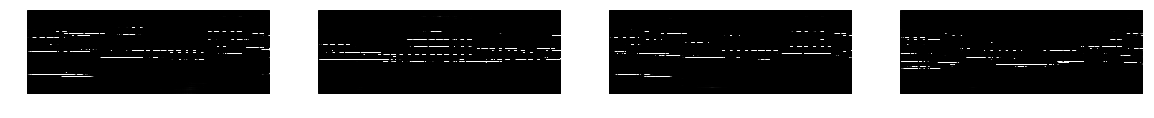

(4, 32, 32, 3)


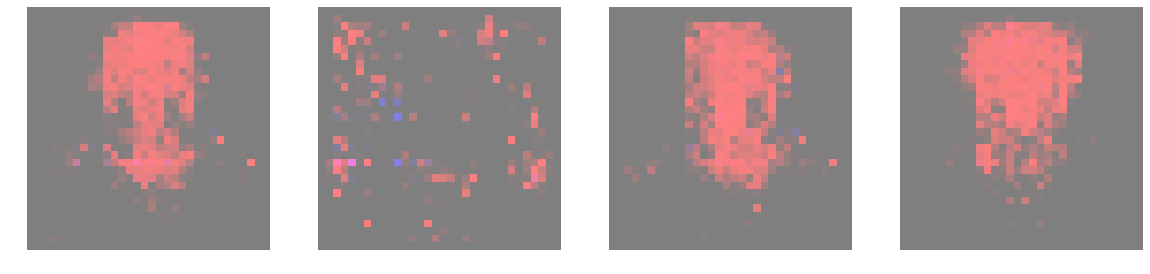

[43/110][14925] Loss_D: 0.076698 0.018513 Loss_G: 0.950259 1.020013 loss_cyc 0.858698 76.433
[43/110][14950] Loss_D: 0.065031 0.003806 Loss_G: 1.010232 0.995058 loss_cyc 0.850615 76.562
[43/110][14975] Loss_D: 0.045237 0.009143 Loss_G: 0.866220 1.011101 loss_cyc 0.834146 76.690
[43/110][15000] Loss_D: 0.051071 0.004335 Loss_G: 0.992409 1.004824 loss_cyc 0.847601 76.811
[43/110][15025] Loss_D: 0.050698 0.006696 Loss_G: 0.980143 1.003197 loss_cyc 0.828094 76.942
[43/110][15050] Loss_D: 0.057178 0.017006 Loss_G: 0.945399 1.010814 loss_cyc 0.830160 77.062
[43/110][15075] Loss_D: 0.044423 0.006709 Loss_G: 0.937276 1.012063 loss_cyc 0.822117 77.191
[43/110][15100] Loss_D: 0.065902 0.003497 Loss_G: 0.929944 0.997327 loss_cyc 0.831563 77.303
[43/110][15125] Loss_D: 0.054275 0.003902 Loss_G: 0.978795 1.008328 loss_cyc 0.840285 77.426
[43/110][15150] Loss_D: 0.044307 0.006205 Loss_G: 0.934769 1.011536 loss_cyc 0.837496 77.535
[43/110][15175] Loss_D: 0.031462 0.003089 Loss_G: 0.983417 1.008927 lo

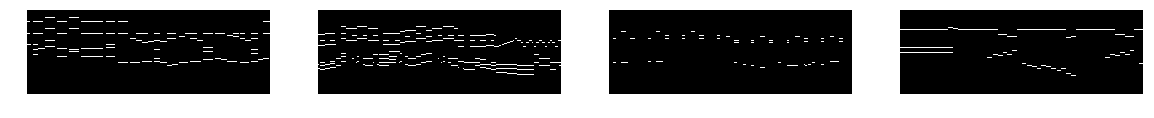

(4, 32, 32, 3)


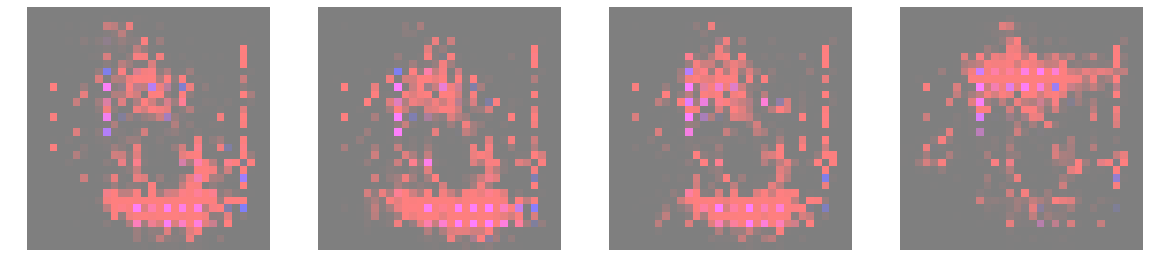

(4, 88, 256, 1)


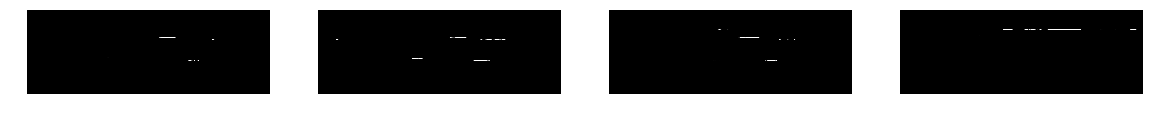

(4, 32, 32, 3)


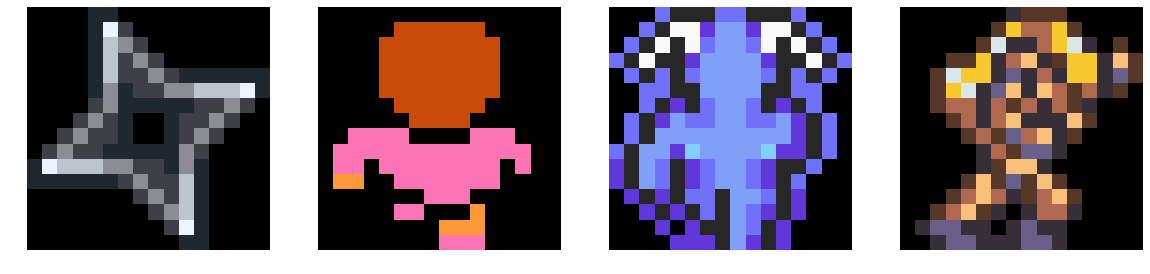

(4, 88, 256, 1)


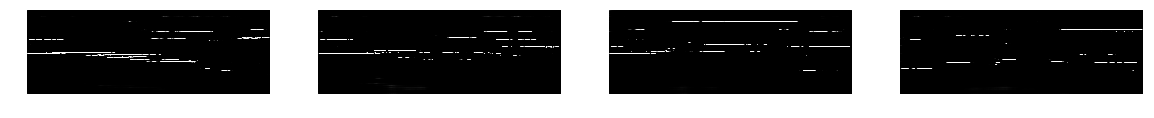

(4, 32, 32, 3)


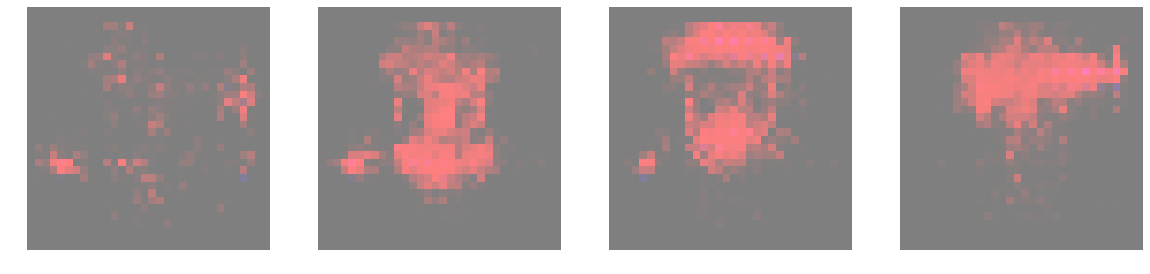

[44/110][15275] Loss_D: 0.047231 0.004312 Loss_G: 0.898498 1.001606 loss_cyc 0.841908 78.200
[44/110][15300] Loss_D: 0.035033 0.008383 Loss_G: 0.885575 1.008095 loss_cyc 0.848613 78.323
[44/110][15325] Loss_D: 0.029619 0.002940 Loss_G: 0.970362 0.999383 loss_cyc 0.813706 78.444
[44/110][15350] Loss_D: 0.053720 0.003956 Loss_G: 0.961578 1.004603 loss_cyc 0.817090 78.571
[44/110][15375] Loss_D: 0.036646 0.003071 Loss_G: 1.015565 1.001186 loss_cyc 0.832528 78.695
[44/110][15400] Loss_D: 0.040855 0.010159 Loss_G: 0.964767 1.016518 loss_cyc 0.838206 78.817
[44/110][15425] Loss_D: 0.045687 0.011034 Loss_G: 0.937892 1.000630 loss_cyc 0.841920 78.942
[44/110][15450] Loss_D: 0.037073 0.007305 Loss_G: 0.966541 1.016255 loss_cyc 0.817284 79.061
[44/110][15475] Loss_D: 0.044258 0.002194 Loss_G: 0.969084 0.998025 loss_cyc 0.809198 79.177
[44/110][15500] Loss_D: 0.053014 0.014770 Loss_G: 0.988216 1.025592 loss_cyc 0.839130 79.296
[44/110][15525] Loss_D: 0.034511 0.007607 Loss_G: 1.015207 1.005323 lo

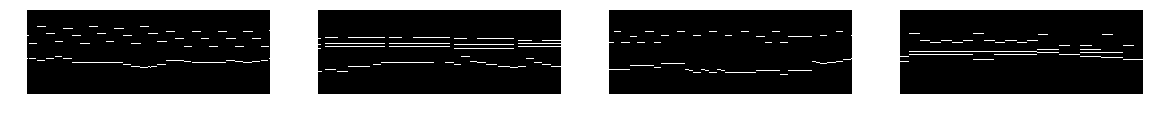

(4, 32, 32, 3)


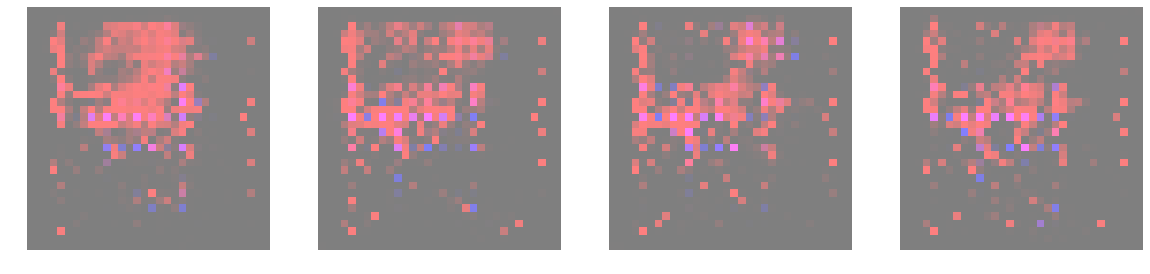

(4, 88, 256, 1)


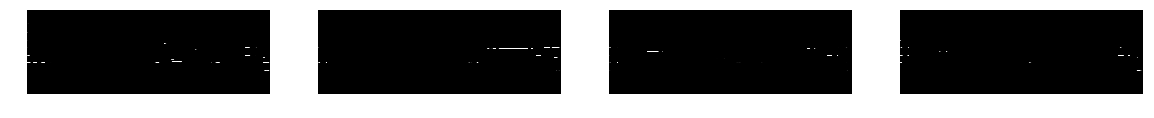

(4, 32, 32, 3)


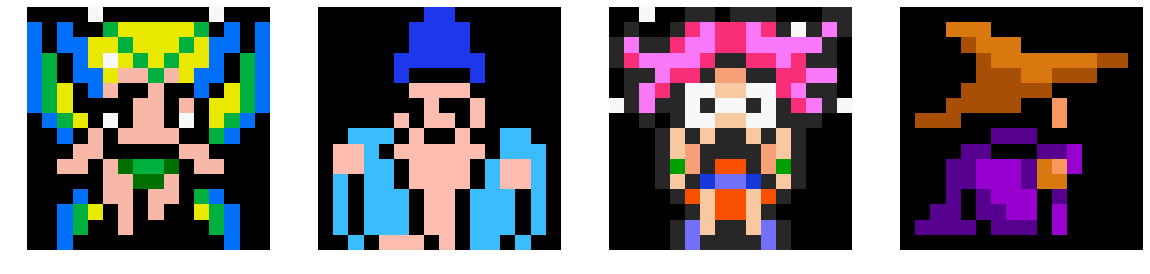

(4, 88, 256, 1)


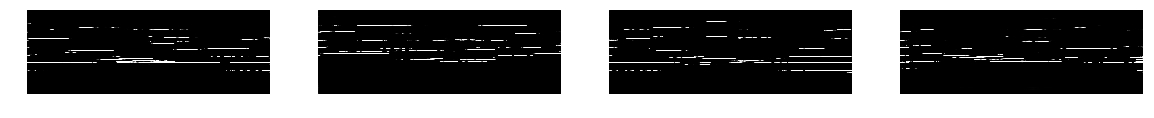

(4, 32, 32, 3)


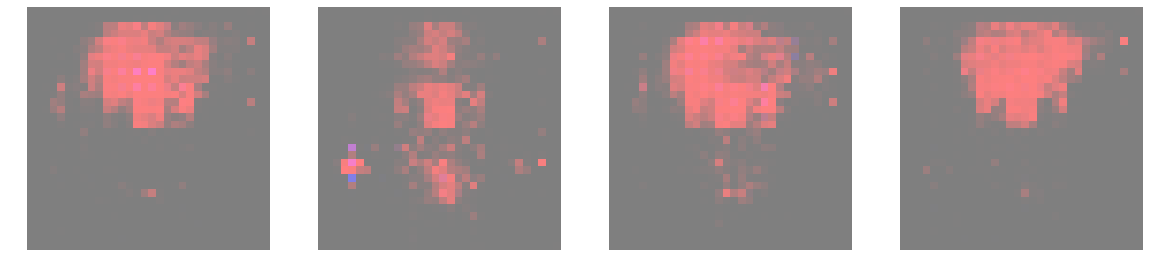

[45/110][15625] Loss_D: 0.048846 0.003038 Loss_G: 0.903579 0.999844 loss_cyc 0.834125 79.968
[45/110][15650] Loss_D: 0.029294 0.005682 Loss_G: 1.016617 1.008318 loss_cyc 0.847955 80.088
[45/110][15675] Loss_D: 0.057235 0.002111 Loss_G: 0.937168 1.000730 loss_cyc 0.819477 80.214
[45/110][15700] Loss_D: 0.047752 0.001920 Loss_G: 0.881035 1.005249 loss_cyc 0.845263 80.336
[45/110][15725] Loss_D: 0.039442 0.010594 Loss_G: 0.928104 1.008469 loss_cyc 0.830374 80.460
[45/110][15750] Loss_D: 0.030669 0.007648 Loss_G: 0.948774 1.007197 loss_cyc 0.829718 80.585
[45/110][15775] Loss_D: 0.030908 0.004380 Loss_G: 0.987590 1.006605 loss_cyc 0.813495 80.708
[45/110][15800] Loss_D: 0.037124 0.010586 Loss_G: 0.907136 1.010159 loss_cyc 0.795674 80.830
[45/110][15825] Loss_D: 0.038750 0.011588 Loss_G: 0.991247 1.007539 loss_cyc 0.849559 80.961
[45/110][15850] Loss_D: 0.033260 0.003907 Loss_G: 0.902442 1.010263 loss_cyc 0.857703 81.084
[45/110][15875] Loss_D: 0.024335 0.001463 Loss_G: 0.934358 1.006530 lo

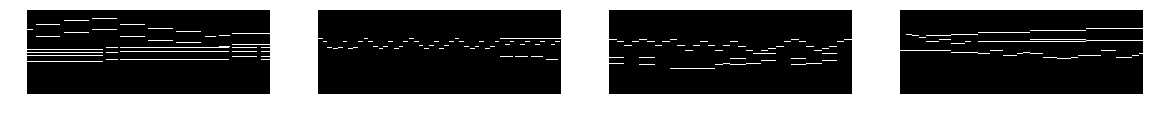

(4, 32, 32, 3)


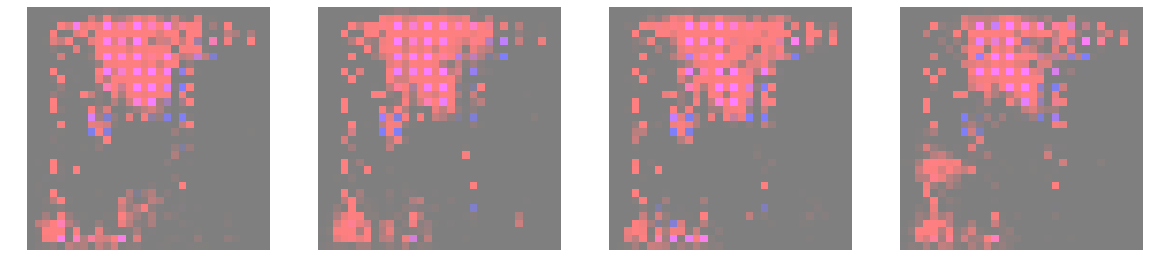

(4, 88, 256, 1)


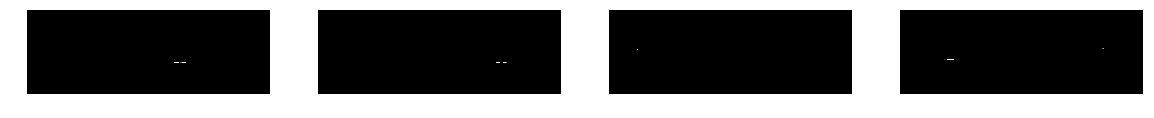

(4, 32, 32, 3)


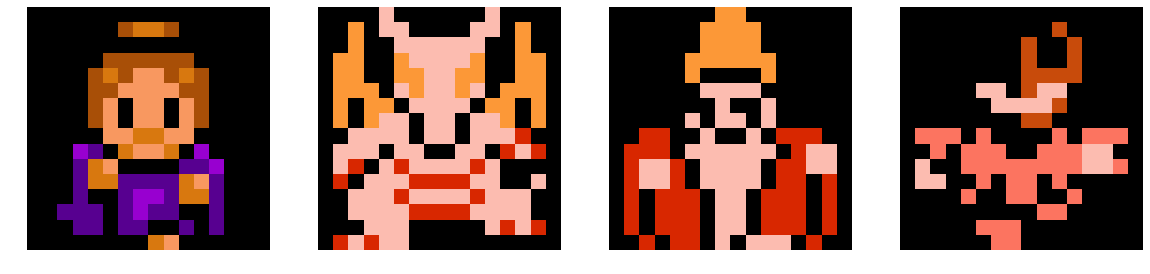

(4, 88, 256, 1)


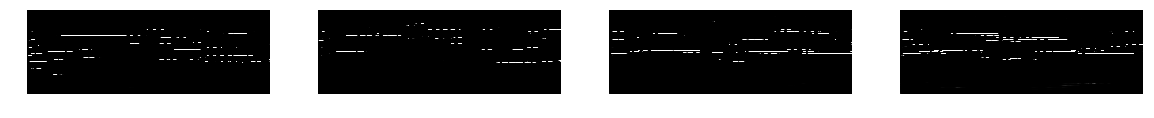

(4, 32, 32, 3)


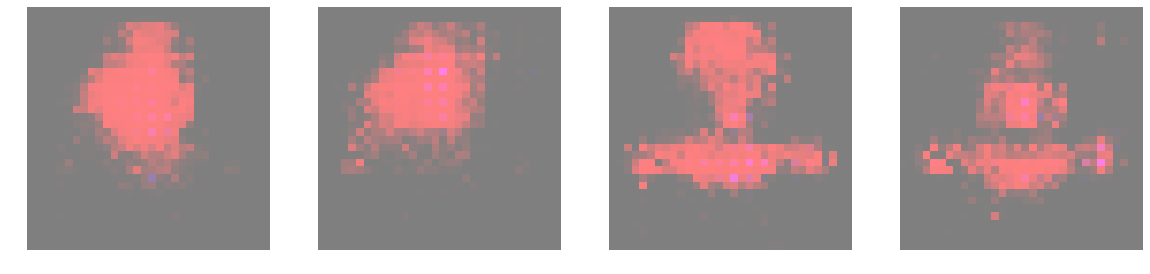

[46/110][15975] Loss_D: 0.035457 0.010310 Loss_G: 0.989539 1.014947 loss_cyc 0.822557 81.734
[46/110][16000] Loss_D: 0.034734 0.003718 Loss_G: 0.980370 1.007445 loss_cyc 0.822095 81.856
[46/110][16025] Loss_D: 0.040964 0.006545 Loss_G: 0.996808 1.006283 loss_cyc 0.849163 81.983
[46/110][16050] Loss_D: 0.043337 0.018711 Loss_G: 0.968546 1.025798 loss_cyc 0.855491 82.096
[46/110][16075] Loss_D: 0.033655 0.009078 Loss_G: 0.907730 1.008230 loss_cyc 0.844318 82.219
[46/110][16100] Loss_D: 0.040442 0.004666 Loss_G: 0.987295 0.999812 loss_cyc 0.841228 82.342
[46/110][16125] Loss_D: 0.052021 0.005323 Loss_G: 0.897182 1.011814 loss_cyc 0.814387 82.461
[46/110][16150] Loss_D: 0.052119 0.001969 Loss_G: 0.882989 1.003855 loss_cyc 0.810704 82.580
[46/110][16175] Loss_D: 0.032965 0.000916 Loss_G: 0.920459 1.000133 loss_cyc 0.814545 82.705
[46/110][16200] Loss_D: 0.065576 0.015606 Loss_G: 0.962914 1.025769 loss_cyc 0.855982 82.831
[46/110][16225] Loss_D: 0.046319 0.004586 Loss_G: 1.018246 1.006217 lo

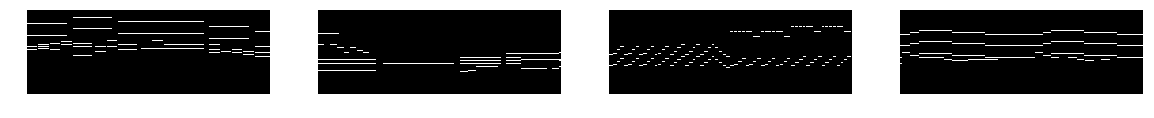

(4, 32, 32, 3)


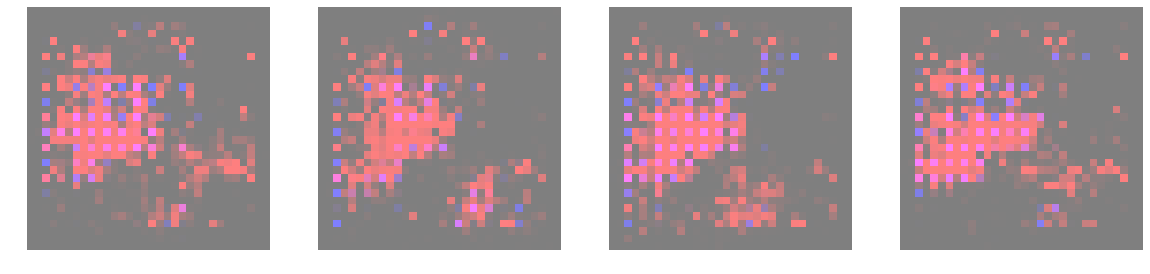

(4, 88, 256, 1)


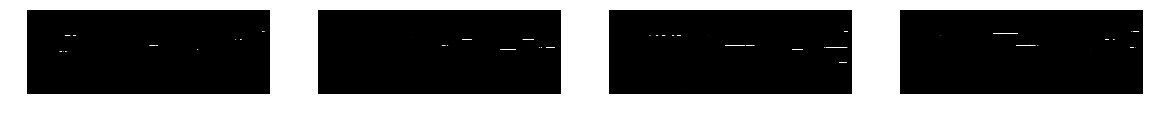

(4, 32, 32, 3)


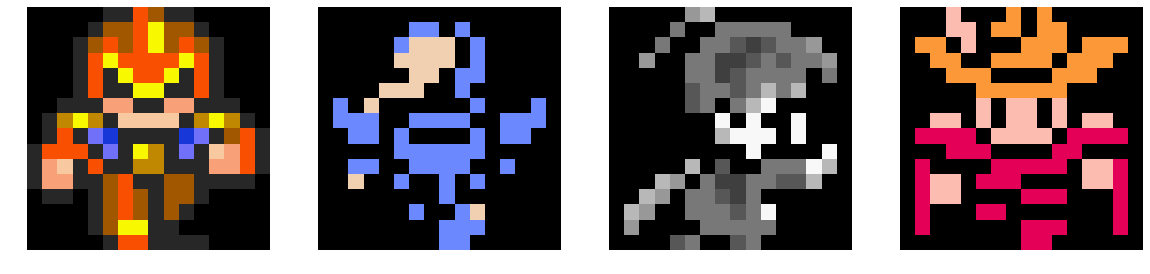

(4, 88, 256, 1)


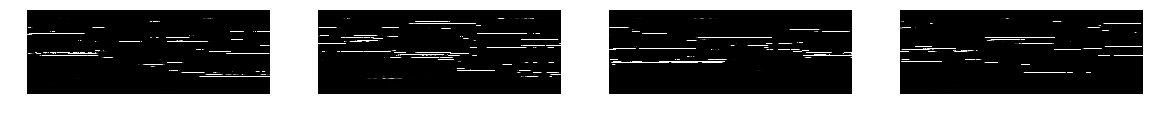

(4, 32, 32, 3)


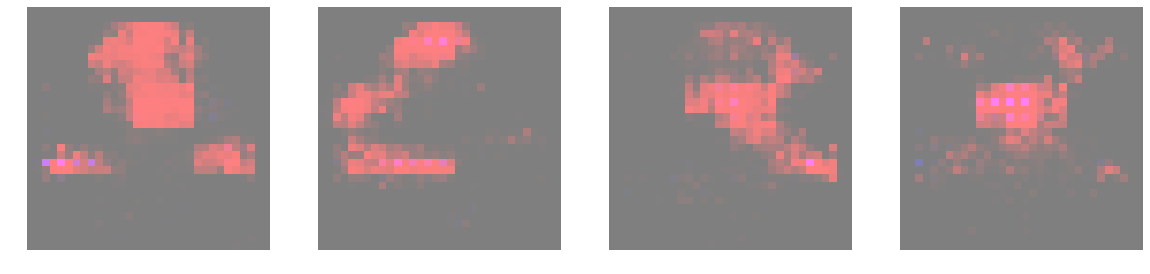

[47/110][16325] Loss_D: 0.033383 0.002783 Loss_G: 0.945896 1.006780 loss_cyc 0.821929 83.500
[47/110][16350] Loss_D: 0.030728 0.006764 Loss_G: 1.003977 1.007389 loss_cyc 0.832094 83.623
[47/110][16375] Loss_D: 0.061068 0.002245 Loss_G: 0.820573 1.000192 loss_cyc 0.827198 83.742
[47/110][16400] Loss_D: 0.034733 0.005084 Loss_G: 0.865121 1.002791 loss_cyc 0.813505 83.863
[47/110][16425] Loss_D: 0.056447 0.005276 Loss_G: 0.924932 1.010304 loss_cyc 0.829991 83.983
[47/110][16450] Loss_D: 0.044773 0.006783 Loss_G: 1.048539 1.008637 loss_cyc 0.808024 84.106
[47/110][16475] Loss_D: 0.040216 0.003246 Loss_G: 0.901848 1.000119 loss_cyc 0.837800 84.248
[47/110][16500] Loss_D: 0.059928 0.004624 Loss_G: 0.909666 1.001201 loss_cyc 0.827362 84.370
[47/110][16525] Loss_D: 0.051415 0.005800 Loss_G: 1.011770 1.008913 loss_cyc 0.823879 84.496
[47/110][16550] Loss_D: 0.039740 0.004795 Loss_G: 0.958415 1.006287 loss_cyc 0.794700 84.617
[47/110][16575] Loss_D: 0.052333 0.001540 Loss_G: 0.935160 1.000112 lo

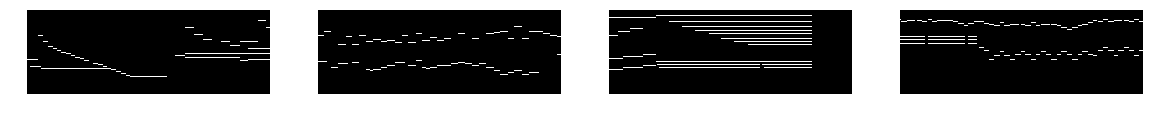

(4, 32, 32, 3)


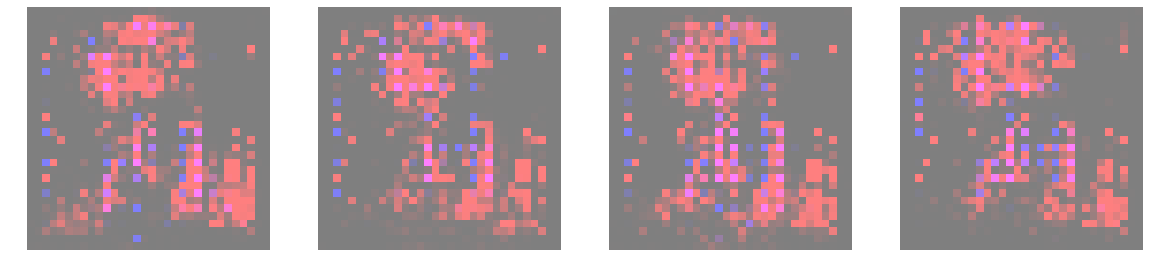

(4, 88, 256, 1)


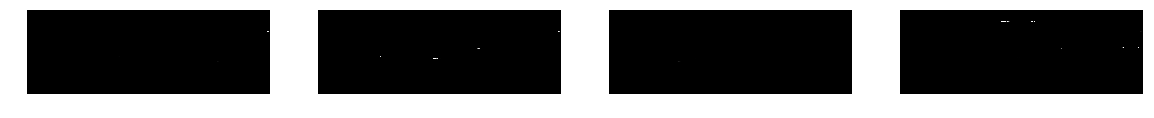

(4, 32, 32, 3)


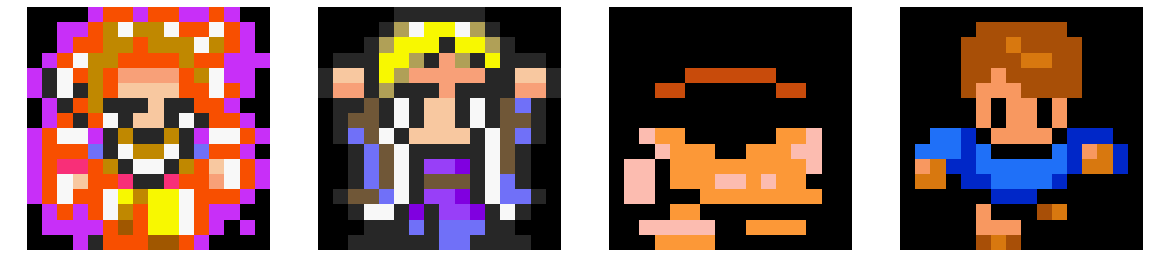

(4, 88, 256, 1)


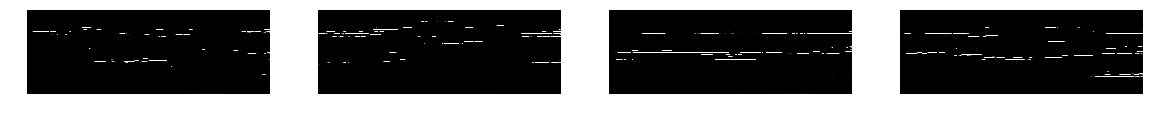

(4, 32, 32, 3)


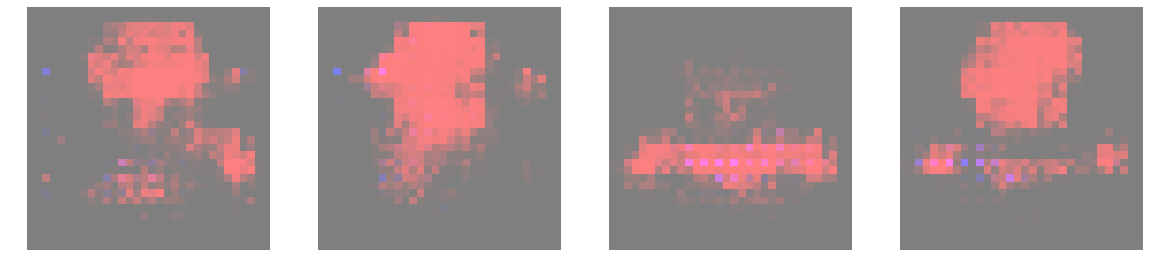

[48/110][16675] Loss_D: 0.040545 0.001833 Loss_G: 0.941045 1.006325 loss_cyc 0.828469 85.287
[48/110][16700] Loss_D: 0.044731 0.004602 Loss_G: 0.947115 1.004841 loss_cyc 0.841298 85.416
[48/110][16725] Loss_D: 0.041123 0.001887 Loss_G: 0.997978 0.995427 loss_cyc 0.830873 85.542
[48/110][16750] Loss_D: 0.050534 0.005558 Loss_G: 0.952719 1.001665 loss_cyc 0.820644 85.672
[48/110][16775] Loss_D: 0.040349 0.009682 Loss_G: 0.903612 1.015306 loss_cyc 0.835951 85.803
[48/110][16800] Loss_D: 0.037143 0.010546 Loss_G: 0.961525 1.000185 loss_cyc 0.800579 85.919
[48/110][16825] Loss_D: 0.024743 0.002440 Loss_G: 0.993839 1.003559 loss_cyc 0.838374 86.039
[48/110][16850] Loss_D: 0.039699 0.005267 Loss_G: 1.002177 1.005705 loss_cyc 0.807984 86.156
[48/110][16875] Loss_D: 0.061519 0.008060 Loss_G: 0.858825 1.002589 loss_cyc 0.811063 86.269
[48/110][16900] Loss_D: 0.042775 0.009891 Loss_G: 0.995126 1.013215 loss_cyc 0.802869 86.382
[48/110][16925] Loss_D: 0.046368 0.003513 Loss_G: 0.919671 1.006919 lo

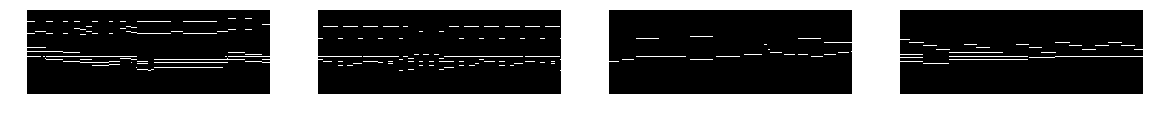

(4, 32, 32, 3)


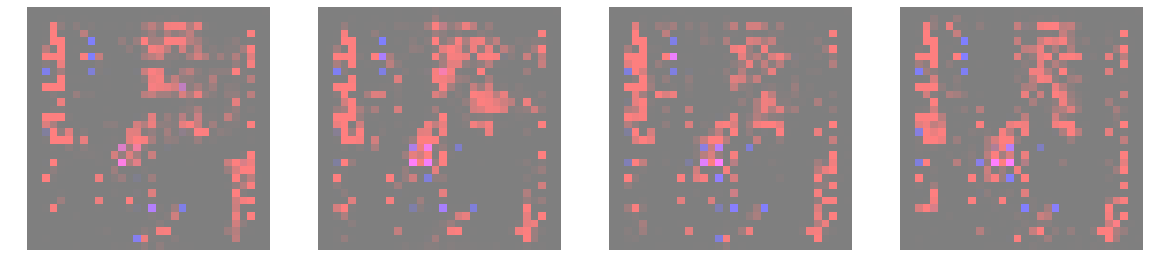

(4, 88, 256, 1)


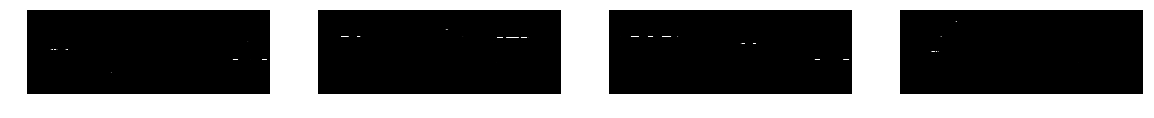

(4, 32, 32, 3)


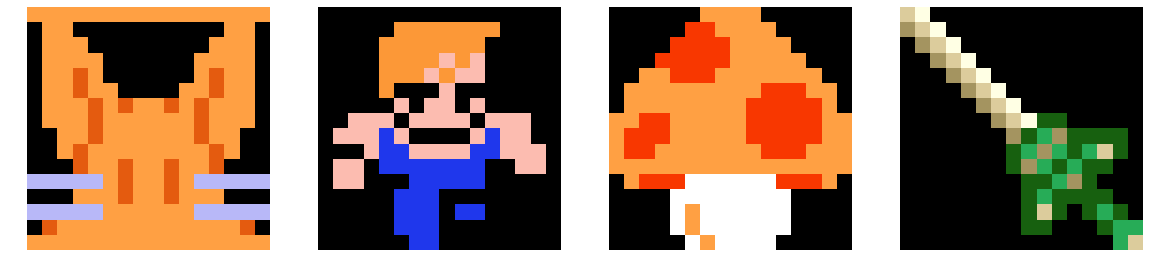

(4, 88, 256, 1)


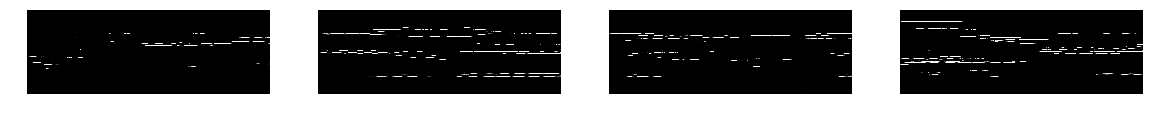

(4, 32, 32, 3)


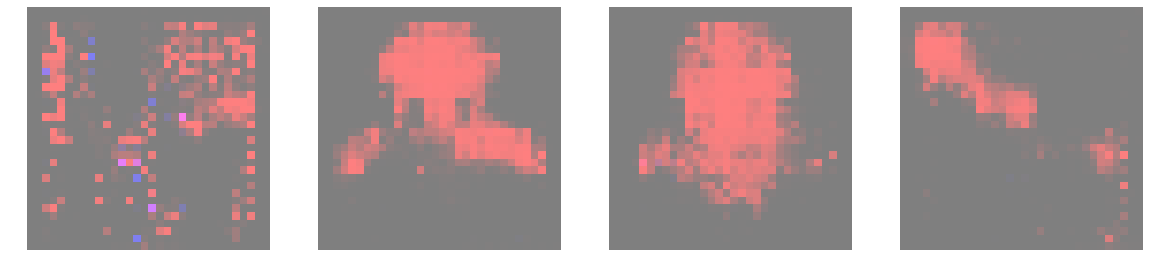

[49/110][17025] Loss_D: 0.047152 0.002153 Loss_G: 0.950059 1.003265 loss_cyc 0.830401 87.048
[49/110][17050] Loss_D: 0.070298 0.003737 Loss_G: 0.928485 1.005672 loss_cyc 0.835278 87.173
[49/110][17075] Loss_D: 0.053551 0.008103 Loss_G: 0.966235 1.014367 loss_cyc 0.816342 87.295
[49/110][17100] Loss_D: 0.066968 0.002574 Loss_G: 0.956374 1.003656 loss_cyc 0.844642 87.413
[49/110][17125] Loss_D: 0.065355 0.002138 Loss_G: 0.908075 1.000990 loss_cyc 0.842690 87.526
[49/110][17150] Loss_D: 0.039025 0.013322 Loss_G: 0.872072 1.007972 loss_cyc 0.828308 87.662
[49/110][17175] Loss_D: 0.050224 0.011118 Loss_G: 0.956019 1.001499 loss_cyc 0.841851 87.779
[49/110][17200] Loss_D: 0.051762 0.005087 Loss_G: 0.880366 1.013753 loss_cyc 0.836625 87.902
[49/110][17225] Loss_D: 0.064176 0.004726 Loss_G: 0.837647 1.000648 loss_cyc 0.838277 88.023
[49/110][17250] Loss_D: 0.070553 0.007597 Loss_G: 0.919235 1.012427 loss_cyc 0.826189 88.150
[49/110][17275] Loss_D: 0.081446 0.002114 Loss_G: 0.962302 1.007015 lo

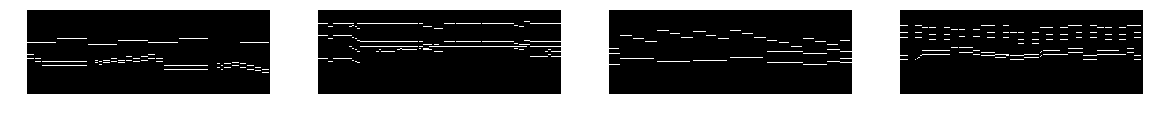

(4, 32, 32, 3)


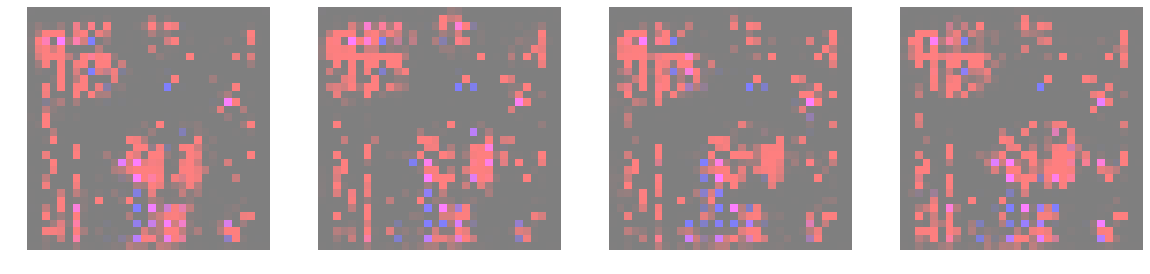

(4, 88, 256, 1)


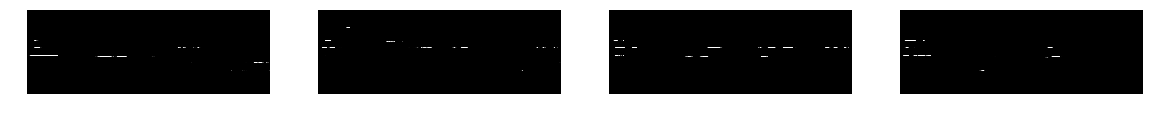

(4, 32, 32, 3)


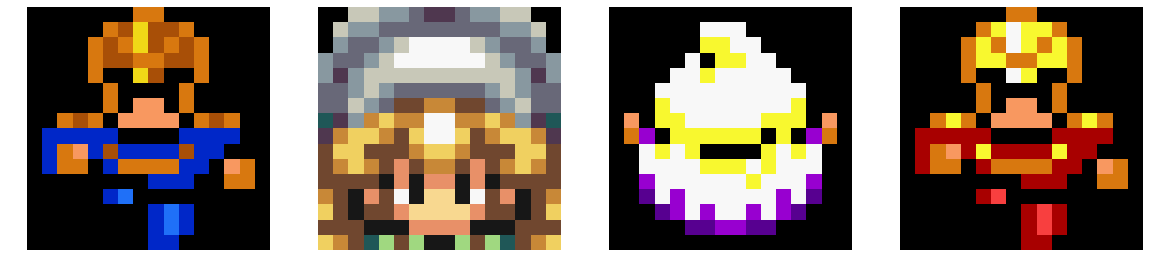

(4, 88, 256, 1)


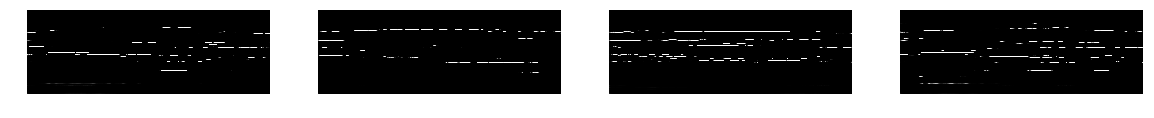

(4, 32, 32, 3)


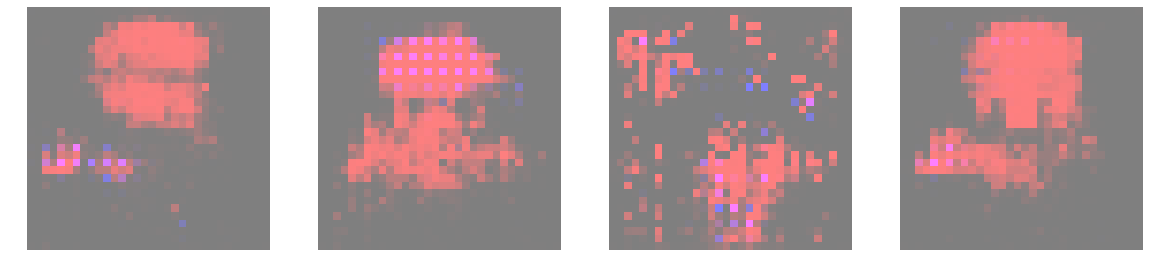

[50/110][17375] Loss_D: 0.043121 0.006168 Loss_G: 0.927430 0.996039 loss_cyc 0.830028 88.820
[50/110][17400] Loss_D: 0.039304 0.004230 Loss_G: 0.960199 1.007574 loss_cyc 0.816931 88.935
[50/110][17425] Loss_D: 0.030624 0.014512 Loss_G: 0.945264 1.010053 loss_cyc 0.820010 89.061
[50/110][17450] Loss_D: 0.039856 0.002385 Loss_G: 0.994539 1.005025 loss_cyc 0.844789 89.190
[50/110][17475] Loss_D: 0.044588 0.006782 Loss_G: 0.926931 1.004972 loss_cyc 0.821852 89.313
[50/110][17500] Loss_D: 0.036666 0.001146 Loss_G: 0.964202 1.001264 loss_cyc 0.835169 89.438
[50/110][17525] Loss_D: 0.054192 0.002000 Loss_G: 0.929166 1.005630 loss_cyc 0.805233 89.558
[50/110][17550] Loss_D: 0.029425 0.001513 Loss_G: 1.027700 1.001918 loss_cyc 0.829783 89.679
[50/110][17575] Loss_D: 0.039323 0.002586 Loss_G: 1.001423 1.000801 loss_cyc 0.826852 89.815
[50/110][17600] Loss_D: 0.041412 0.000273 Loss_G: 0.889163 1.001558 loss_cyc 0.823270 89.948
[50/110][17625] Loss_D: 0.046474 0.003128 Loss_G: 0.941354 1.002227 lo

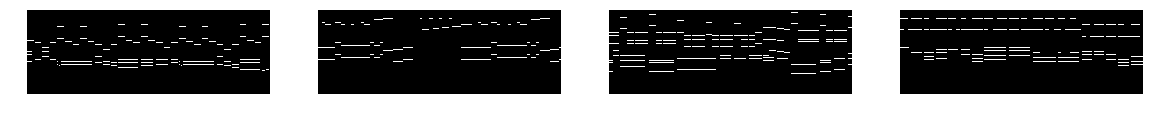

(4, 32, 32, 3)


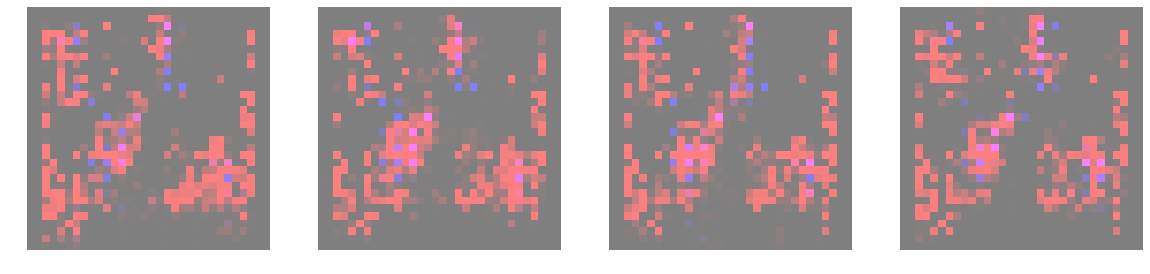

(4, 88, 256, 1)


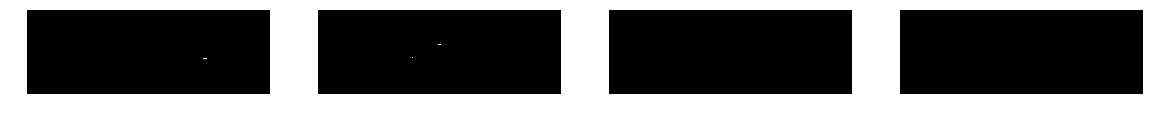

(4, 32, 32, 3)


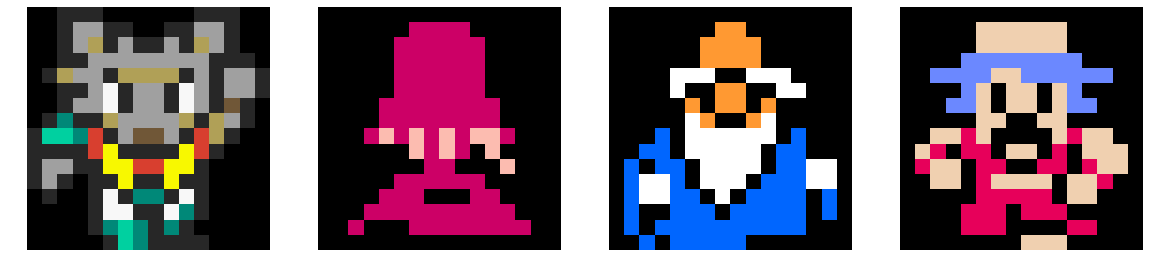

(4, 88, 256, 1)


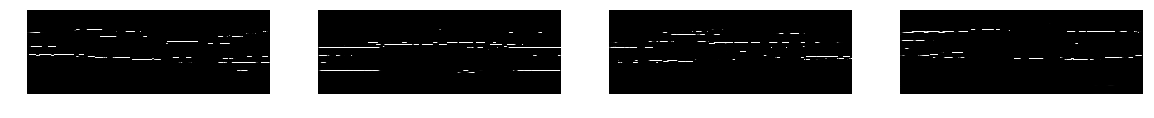

(4, 32, 32, 3)


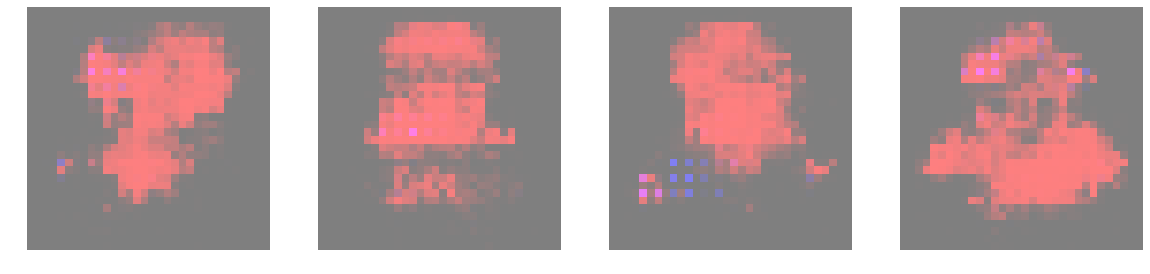

[51/110][17725] Loss_D: 0.029386 0.005618 Loss_G: 0.962668 1.010796 loss_cyc 0.805933 90.585
[51/110][17750] Loss_D: 0.035168 0.003587 Loss_G: 0.959972 0.999851 loss_cyc 0.828829 90.707
[51/110][17775] Loss_D: 0.026020 0.003724 Loss_G: 0.939065 1.004213 loss_cyc 0.821648 90.826
[51/110][17800] Loss_D: 0.037484 0.007570 Loss_G: 1.022477 1.009823 loss_cyc 0.804634 90.937
[51/110][17825] Loss_D: 0.050879 0.001037 Loss_G: 0.936372 1.004583 loss_cyc 0.848289 91.062
[51/110][17850] Loss_D: 0.035773 0.003552 Loss_G: 0.994881 0.998384 loss_cyc 0.824842 91.179
[51/110][17875] Loss_D: 0.043838 0.001620 Loss_G: 0.915708 1.000204 loss_cyc 0.820524 91.309
[51/110][17900] Loss_D: 0.041775 0.002706 Loss_G: 0.914144 1.005945 loss_cyc 0.842167 91.431
[51/110][17925] Loss_D: 0.047042 0.003342 Loss_G: 0.942184 1.003149 loss_cyc 0.842177 91.555
[51/110][17950] Loss_D: 0.035882 0.004558 Loss_G: 0.929716 1.003855 loss_cyc 0.837239 91.681
[51/110][17975] Loss_D: 0.026580 0.002378 Loss_G: 0.986159 1.000842 lo

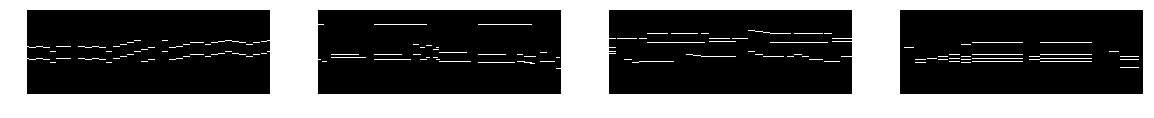

(4, 32, 32, 3)


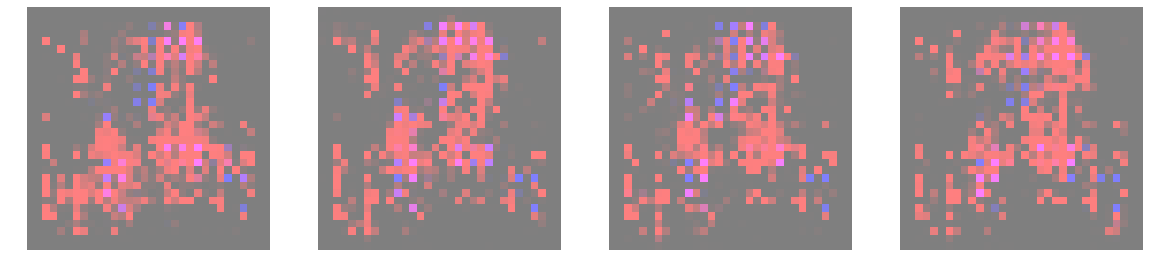

(4, 88, 256, 1)


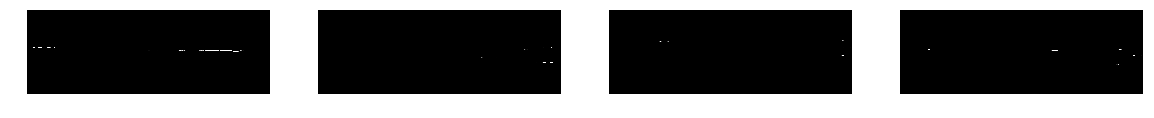

(4, 32, 32, 3)


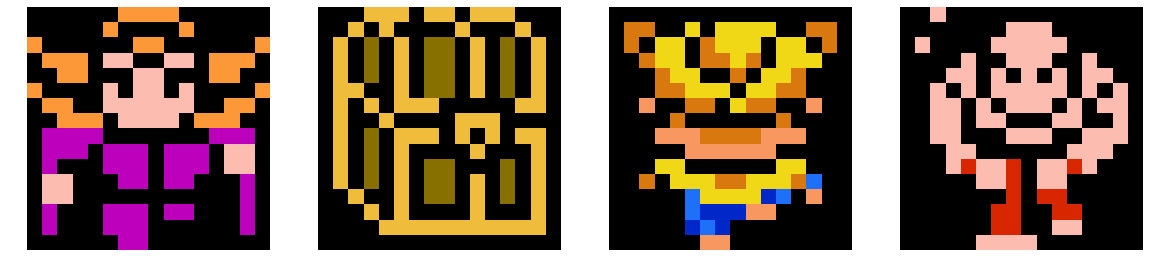

(4, 88, 256, 1)


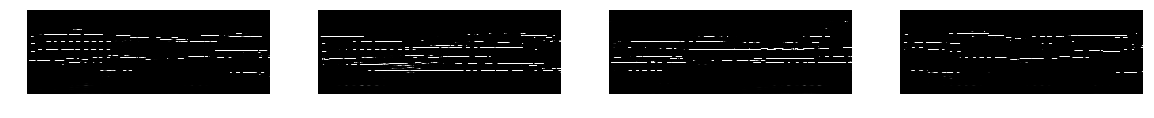

(4, 32, 32, 3)


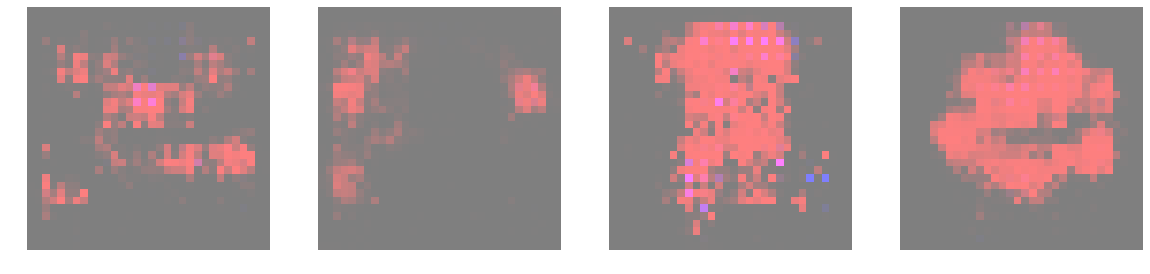

[52/110][18050] Loss_D: 0.033115 0.008689 Loss_G: 1.013538 1.008272 loss_cyc 0.814504 92.231
[52/110][18075] Loss_D: 0.041720 0.007610 Loss_G: 0.941613 1.008736 loss_cyc 0.823883 92.354
[52/110][18100] Loss_D: 0.052437 0.009925 Loss_G: 0.922659 1.000533 loss_cyc 0.797703 92.487
[52/110][18125] Loss_D: 0.029224 0.002793 Loss_G: 0.904948 1.011100 loss_cyc 0.810403 92.608
[52/110][18150] Loss_D: 0.047399 0.009549 Loss_G: 0.945028 1.000776 loss_cyc 0.813216 92.726
[52/110][18175] Loss_D: 0.050287 0.004059 Loss_G: 0.883318 1.003949 loss_cyc 0.811191 92.843
[52/110][18200] Loss_D: 0.047581 0.002529 Loss_G: 0.950240 1.003672 loss_cyc 0.849865 92.970
[52/110][18225] Loss_D: 0.042537 0.001239 Loss_G: 0.966677 0.998989 loss_cyc 0.826322 93.092
[52/110][18250] Loss_D: 0.042164 0.002340 Loss_G: 0.942727 1.005180 loss_cyc 0.832598 93.225
[52/110][18275] Loss_D: 0.044640 0.000988 Loss_G: 0.860319 1.000030 loss_cyc 0.838105 93.345
[52/110][18300] Loss_D: 0.047095 0.008874 Loss_G: 0.926202 1.014911 lo

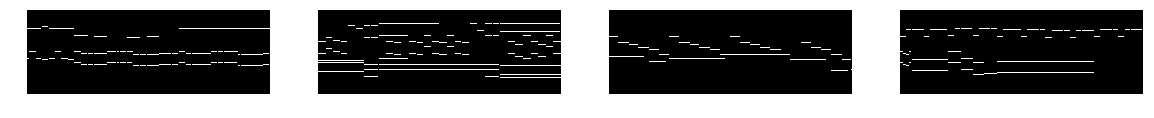

(4, 32, 32, 3)


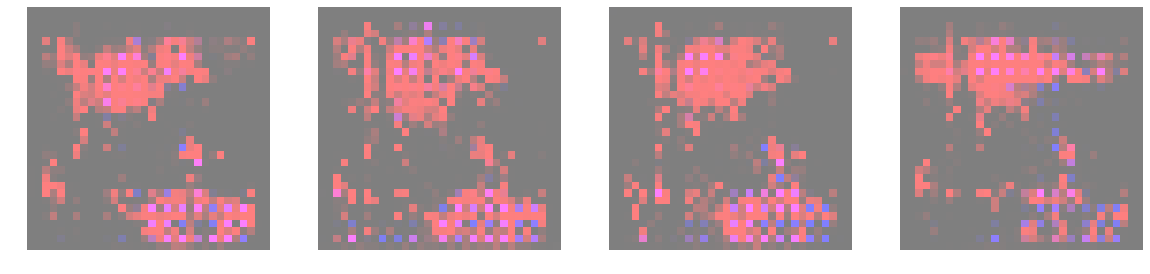

(4, 88, 256, 1)


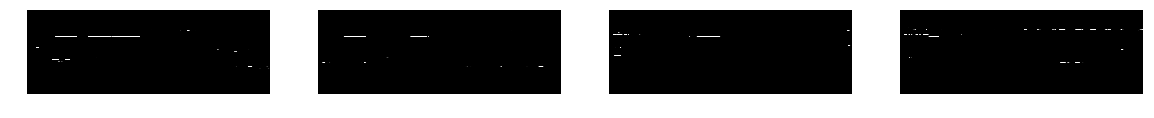

(4, 32, 32, 3)


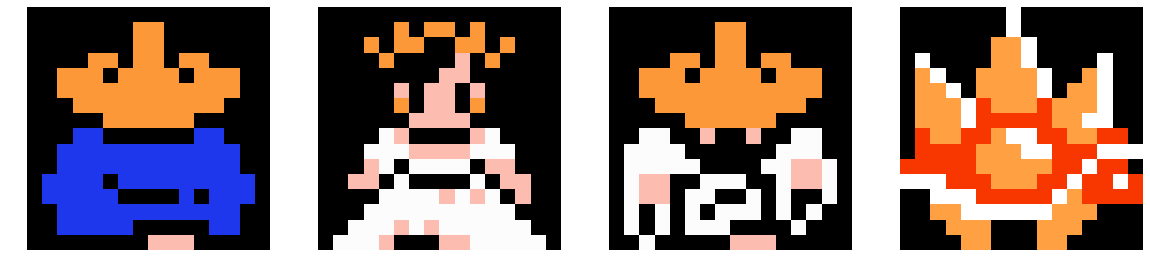

(4, 88, 256, 1)


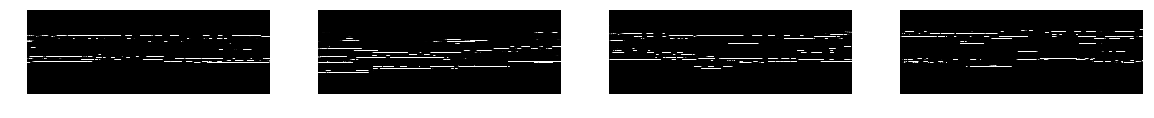

(4, 32, 32, 3)


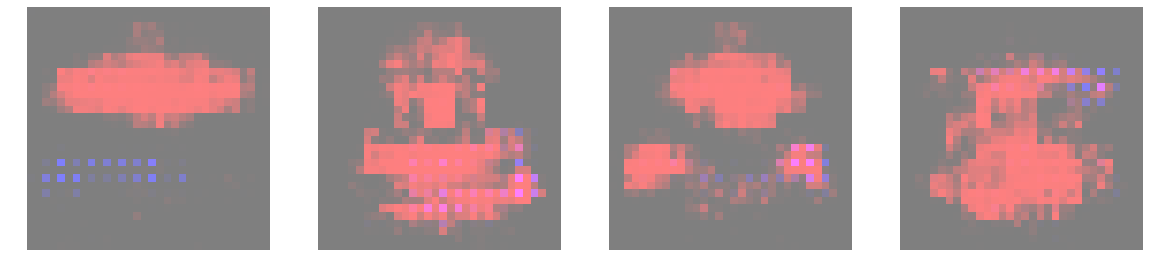

[53/110][18400] Loss_D: 0.037819 0.005857 Loss_G: 0.942691 1.001747 loss_cyc 0.848396 94.006
[53/110][18425] Loss_D: 0.035010 0.002155 Loss_G: 0.898419 1.007629 loss_cyc 0.812966 94.130
[53/110][18450] Loss_D: 0.059313 0.005807 Loss_G: 0.966465 0.996640 loss_cyc 0.807754 94.256
[53/110][18475] Loss_D: 0.038905 0.001855 Loss_G: 0.885243 1.008247 loss_cyc 0.823316 94.374
[53/110][18500] Loss_D: 0.045129 0.005341 Loss_G: 0.841440 1.003017 loss_cyc 0.820711 94.500
[53/110][18525] Loss_D: 0.051529 0.005232 Loss_G: 0.912961 1.003342 loss_cyc 0.814734 94.621
[53/110][18550] Loss_D: 0.035608 0.004170 Loss_G: 0.937558 1.005047 loss_cyc 0.830164 94.735
[53/110][18575] Loss_D: 0.049439 0.004298 Loss_G: 0.953362 1.004437 loss_cyc 0.819420 94.866
[53/110][18600] Loss_D: 0.052619 0.007171 Loss_G: 0.978211 1.006218 loss_cyc 0.839726 94.981
[53/110][18625] Loss_D: 0.041713 0.018169 Loss_G: 0.911876 1.023440 loss_cyc 0.841253 95.102
[53/110][18650] Loss_D: 0.047338 0.003611 Loss_G: 0.959950 0.999241 lo

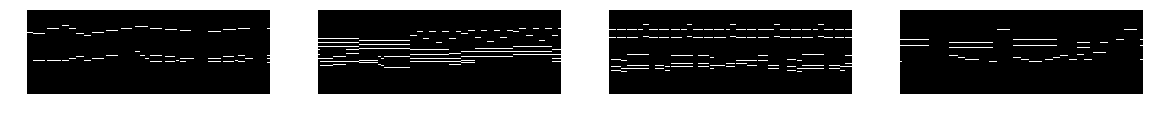

(4, 32, 32, 3)


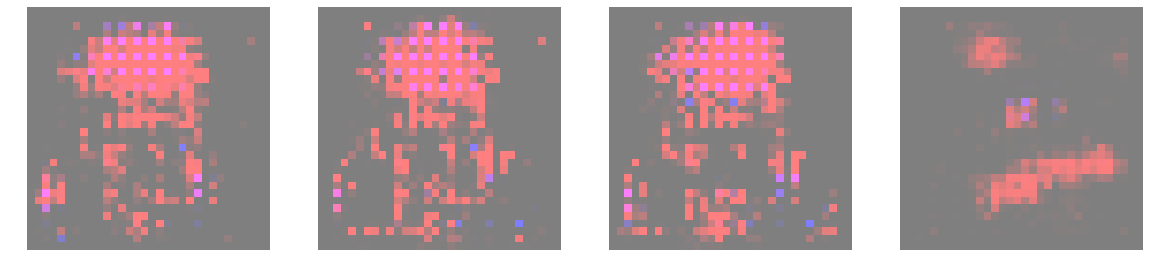

(4, 88, 256, 1)


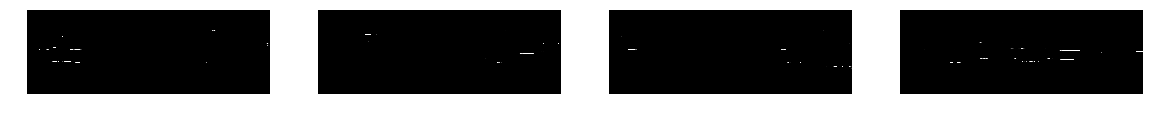

(4, 32, 32, 3)


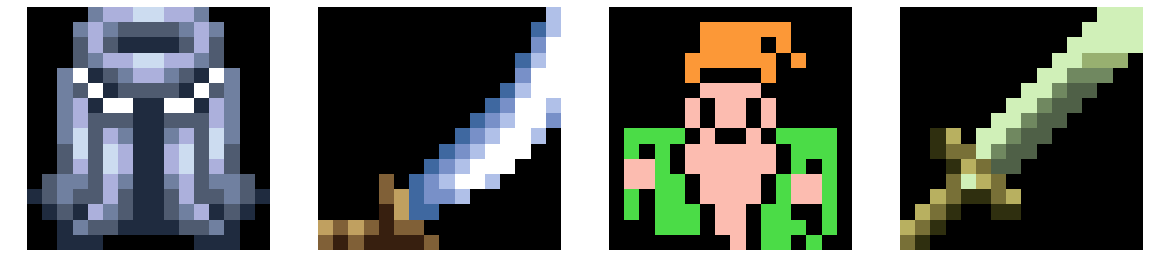

(4, 88, 256, 1)


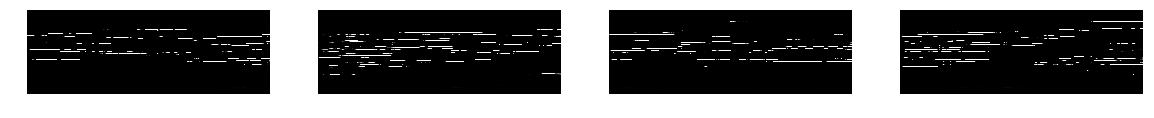

(4, 32, 32, 3)


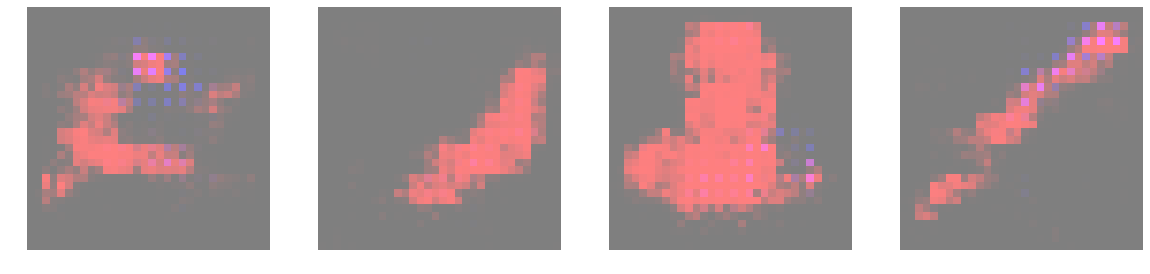

[54/110][18750] Loss_D: 0.033005 0.224157 Loss_G: 0.928529 1.196932 loss_cyc 0.816516 95.774
[54/110][18775] Loss_D: 0.031163 0.027584 Loss_G: 0.950943 1.005601 loss_cyc 0.808308 95.885
[54/110][18800] Loss_D: 0.037753 0.003725 Loss_G: 0.891232 0.996490 loss_cyc 0.824485 96.002
[54/110][18825] Loss_D: 0.049456 0.007922 Loss_G: 0.896929 1.000449 loss_cyc 0.832228 96.123
[54/110][18850] Loss_D: 0.033389 0.004243 Loss_G: 0.973128 1.006133 loss_cyc 0.860046 96.246
[54/110][18875] Loss_D: 0.042766 0.003036 Loss_G: 0.920922 1.002547 loss_cyc 0.842816 96.369
[54/110][18900] Loss_D: 0.030660 0.002391 Loss_G: 0.980510 0.999489 loss_cyc 0.843514 96.491
[54/110][18925] Loss_D: 0.033900 0.001806 Loss_G: 1.017779 1.004841 loss_cyc 0.836156 96.618
[54/110][18950] Loss_D: 0.029259 0.002060 Loss_G: 0.926781 1.004625 loss_cyc 0.814713 96.751
[54/110][18975] Loss_D: 0.044455 0.001212 Loss_G: 0.971432 1.002442 loss_cyc 0.830971 96.882
[54/110][19000] Loss_D: 0.035584 0.001516 Loss_G: 0.965358 1.005253 lo

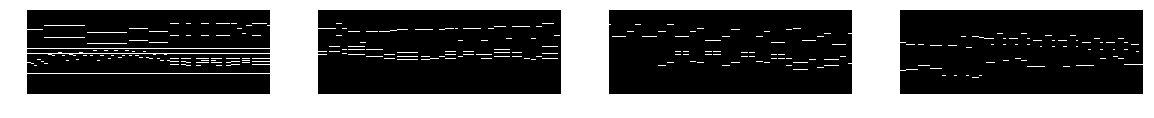

(4, 32, 32, 3)


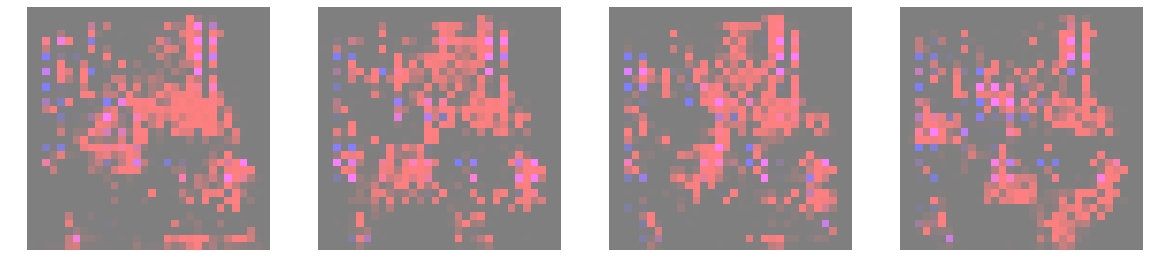

(4, 88, 256, 1)


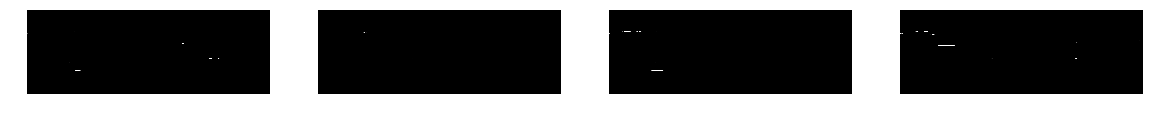

(4, 32, 32, 3)


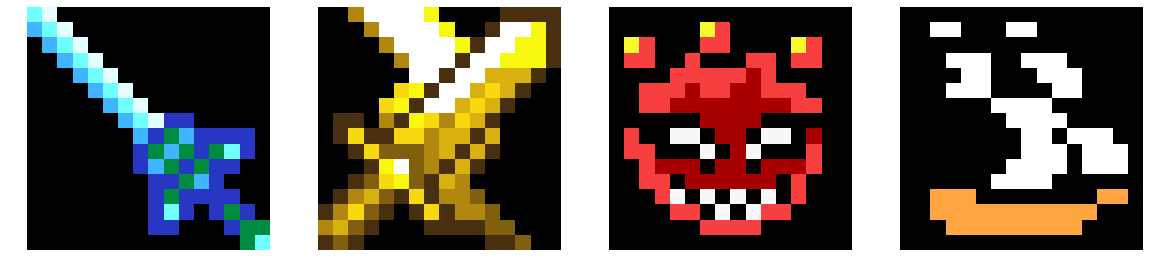

(4, 88, 256, 1)


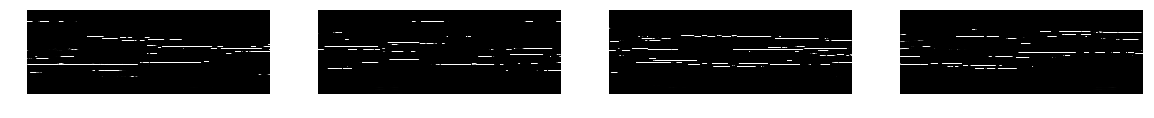

(4, 32, 32, 3)


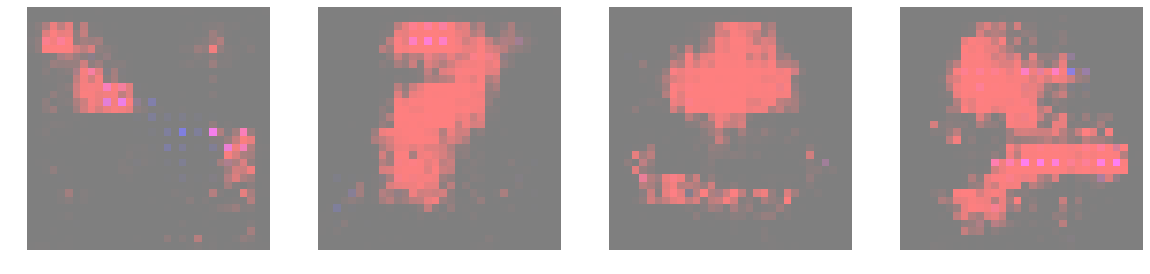

[55/110][19100] Loss_D: 0.036958 0.001749 Loss_G: 0.957149 1.000807 loss_cyc 0.831747 97.550
[55/110][19125] Loss_D: 0.030245 0.000504 Loss_G: 0.911207 1.000902 loss_cyc 0.832163 97.680
[55/110][19150] Loss_D: 0.034401 0.001149 Loss_G: 0.958862 1.002514 loss_cyc 0.822608 97.802
[55/110][19175] Loss_D: 0.037570 0.000928 Loss_G: 0.922164 1.003405 loss_cyc 0.829008 97.920
[55/110][19200] Loss_D: 0.038197 0.000713 Loss_G: 0.966668 1.000102 loss_cyc 0.814212 98.038
[55/110][19225] Loss_D: 0.025265 0.000602 Loss_G: 0.938324 1.000905 loss_cyc 0.810959 98.165
[55/110][19250] Loss_D: 0.030417 0.001009 Loss_G: 0.975172 1.004282 loss_cyc 0.823609 98.288
[55/110][19275] Loss_D: 0.035377 0.000897 Loss_G: 0.961612 1.001261 loss_cyc 0.820382 98.405
[55/110][19300] Loss_D: 0.041647 0.000824 Loss_G: 0.928953 1.001276 loss_cyc 0.826386 98.534
[55/110][19325] Loss_D: 0.030078 0.000928 Loss_G: 0.962078 1.001084 loss_cyc 0.837225 98.658
[55/110][19350] Loss_D: 0.030876 0.000801 Loss_G: 0.957450 0.999198 lo

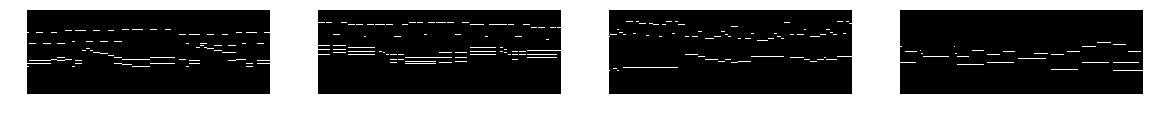

(4, 32, 32, 3)


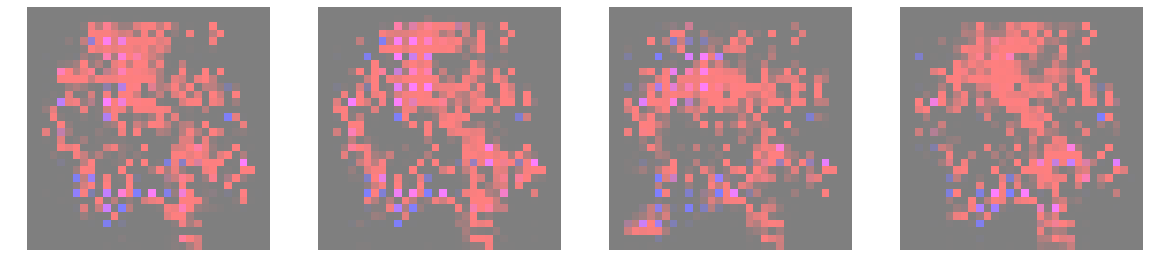

(4, 88, 256, 1)


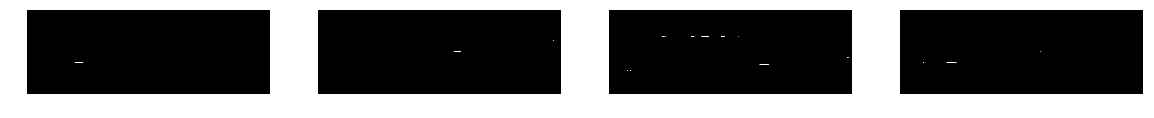

(4, 32, 32, 3)


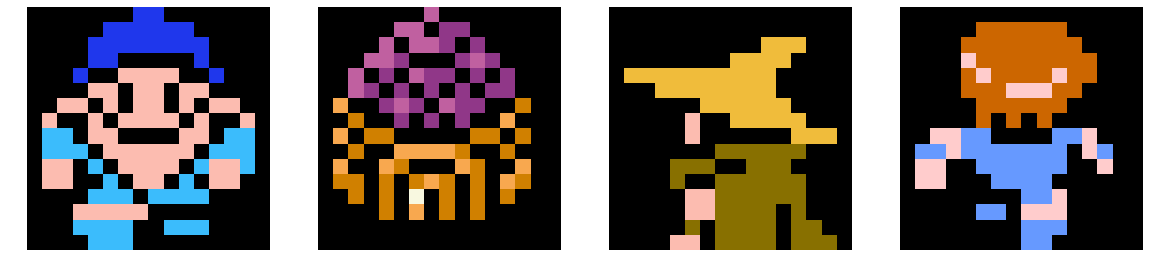

(4, 88, 256, 1)


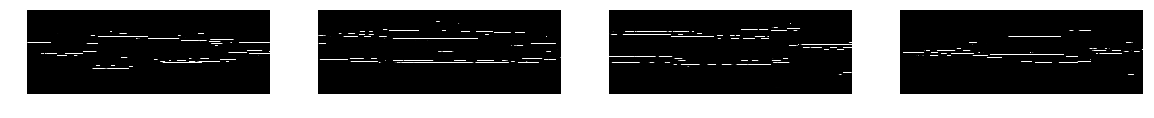

(4, 32, 32, 3)


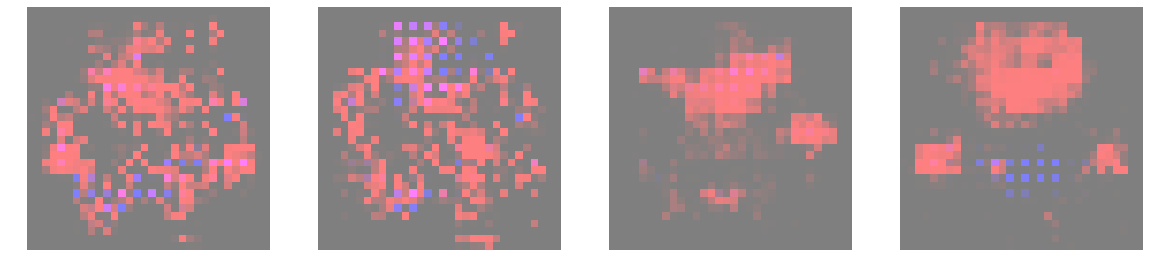

[56/110][19450] Loss_D: 0.043559 0.000662 Loss_G: 0.928178 1.000348 loss_cyc 0.817614 99.307
[56/110][19475] Loss_D: 0.041541 0.000470 Loss_G: 0.957094 1.000758 loss_cyc 0.812245 99.437
[56/110][19500] Loss_D: 0.027300 0.000342 Loss_G: 0.955025 0.999290 loss_cyc 0.809565 99.559
[56/110][19525] Loss_D: 0.026862 0.000260 Loss_G: 1.001463 0.999276 loss_cyc 0.830405 99.677
[56/110][19550] Loss_D: 0.027156 0.002670 Loss_G: 0.969089 1.001311 loss_cyc 0.819883 99.793
[56/110][19575] Loss_D: 0.034417 0.001313 Loss_G: 0.953114 1.001713 loss_cyc 0.842889 99.911
[56/110][19600] Loss_D: 0.029966 0.002104 Loss_G: 1.002929 1.001921 loss_cyc 0.836537 100.041
[56/110][19625] Loss_D: 0.043269 0.001626 Loss_G: 0.982096 0.998028 loss_cyc 0.806081 100.159
[56/110][19650] Loss_D: 0.024261 0.001478 Loss_G: 0.957285 1.003171 loss_cyc 0.808130 100.293
[56/110][19675] Loss_D: 0.031637 0.000908 Loss_G: 0.952499 1.007443 loss_cyc 0.835514 100.410
[56/110][19700] Loss_D: 0.029814 0.006384 Loss_G: 0.926795 1.00277

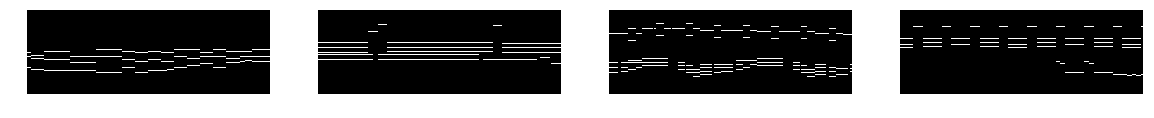

(4, 32, 32, 3)


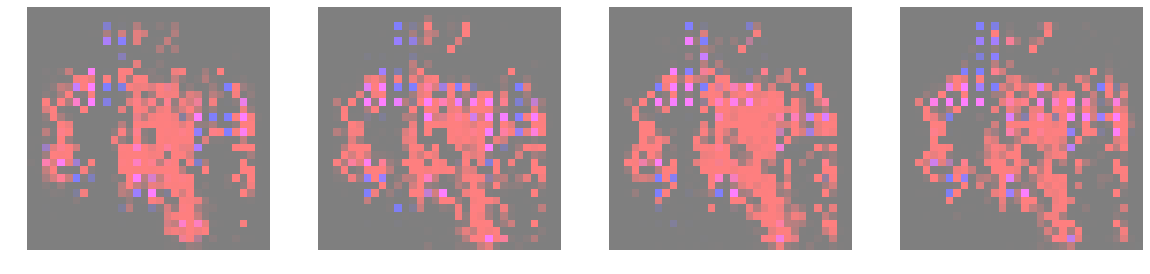

(4, 88, 256, 1)


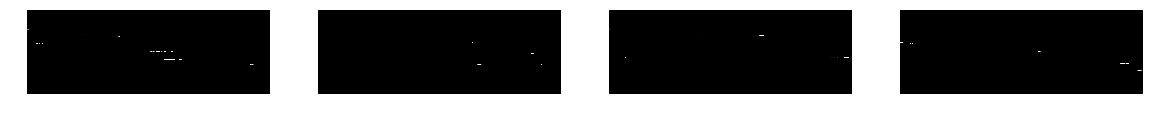

(4, 32, 32, 3)


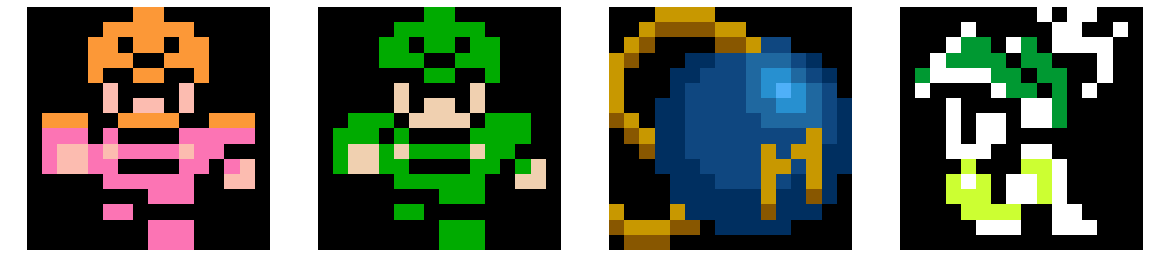

(4, 88, 256, 1)


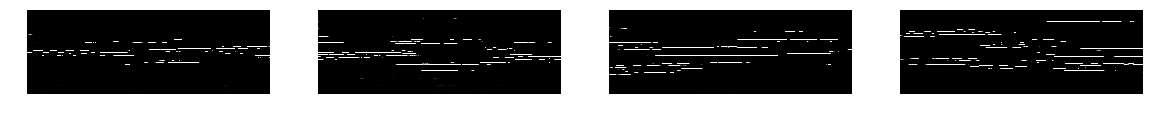

(4, 32, 32, 3)


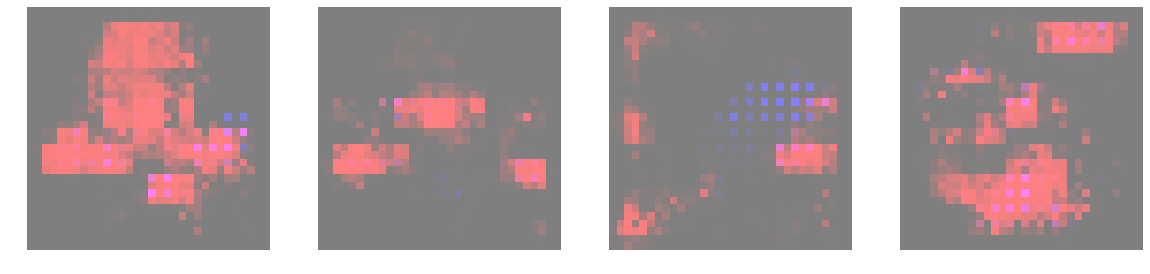

[57/110][19800] Loss_D: 0.021457 0.001024 Loss_G: 0.919321 1.004372 loss_cyc 0.810669 101.077
[57/110][19825] Loss_D: 0.027069 0.012204 Loss_G: 0.982514 1.006985 loss_cyc 0.821845 101.207
[57/110][19850] Loss_D: 0.029619 0.014388 Loss_G: 0.889854 1.007784 loss_cyc 0.799131 101.321
[57/110][19875] Loss_D: 0.021879 0.001826 Loss_G: 0.952780 1.008542 loss_cyc 0.807781 101.445
[57/110][19900] Loss_D: 0.031002 0.002296 Loss_G: 0.992530 0.999270 loss_cyc 0.799714 101.574
[57/110][19925] Loss_D: 0.031122 0.000965 Loss_G: 0.963851 1.001451 loss_cyc 0.795197 101.687
[57/110][19950] Loss_D: 0.032898 0.002672 Loss_G: 0.894191 1.001572 loss_cyc 0.811352 101.812
[57/110][19975] Loss_D: 0.046317 0.002647 Loss_G: 0.972887 1.003118 loss_cyc 0.817232 101.953
[57/110][20000] Loss_D: 0.035687 0.003993 Loss_G: 0.919698 1.009359 loss_cyc 0.825871 102.069
[57/110][20025] Loss_D: 0.034432 0.001969 Loss_G: 0.956960 0.997932 loss_cyc 0.801466 102.183
[57/110][20050] Loss_D: 0.029865 0.003184 Loss_G: 0.964729 1

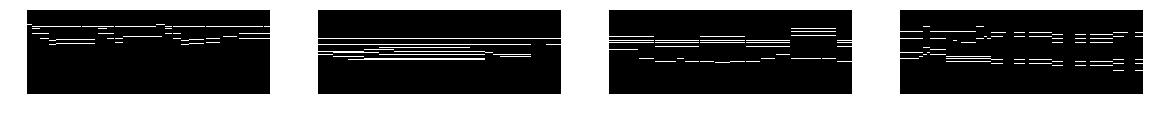

(4, 32, 32, 3)


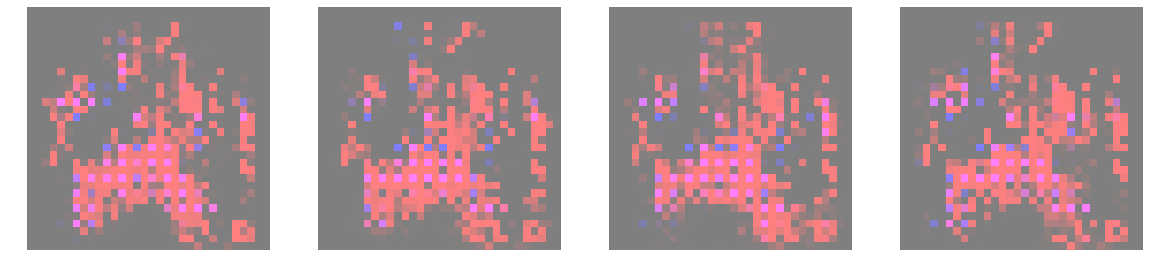

(4, 88, 256, 1)


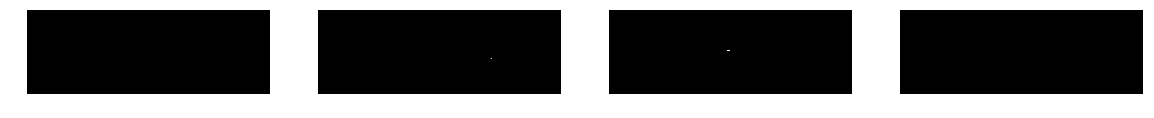

(4, 32, 32, 3)


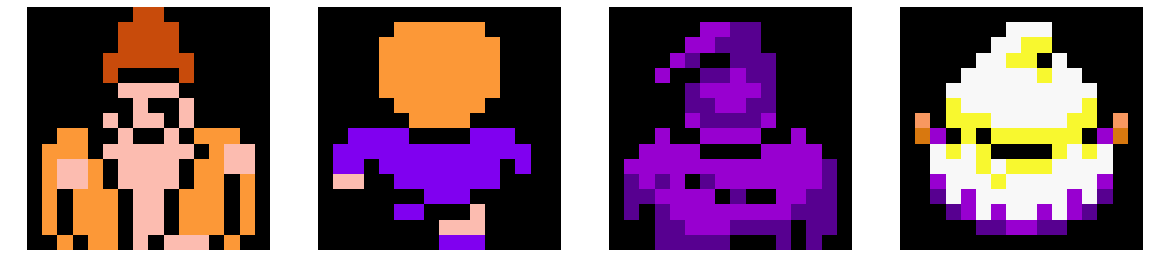

(4, 88, 256, 1)


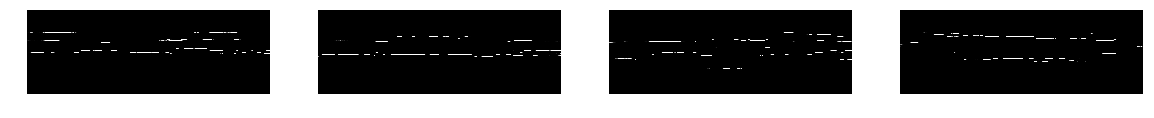

(4, 32, 32, 3)


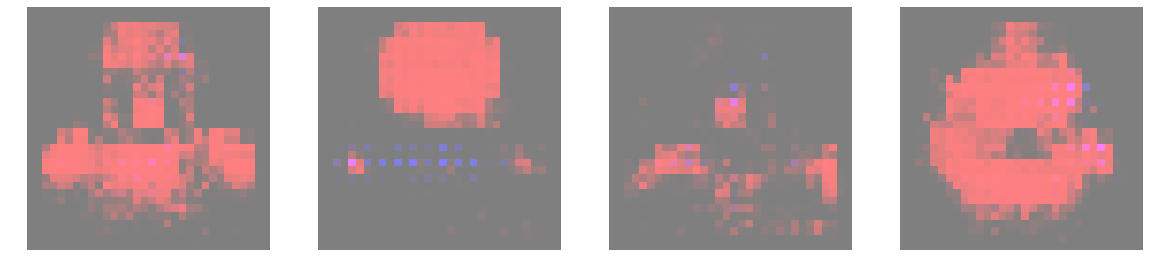

[58/110][20150] Loss_D: 0.022331 0.002128 Loss_G: 0.909685 1.002029 loss_cyc 0.810883 102.858
[58/110][20175] Loss_D: 0.042604 0.006310 Loss_G: 0.963553 1.004266 loss_cyc 0.828998 102.975
[58/110][20200] Loss_D: 0.022193 0.002246 Loss_G: 0.951438 1.000445 loss_cyc 0.814341 103.102
[58/110][20225] Loss_D: 0.047495 0.001578 Loss_G: 0.957600 1.001253 loss_cyc 0.826459 103.227
[58/110][20250] Loss_D: 0.031769 0.004979 Loss_G: 0.937559 1.003340 loss_cyc 0.803810 103.355
[58/110][20275] Loss_D: 0.026046 0.006859 Loss_G: 0.911552 1.005658 loss_cyc 0.813082 103.479
[58/110][20300] Loss_D: 0.035402 0.002199 Loss_G: 0.902674 1.002664 loss_cyc 0.804274 103.596
[58/110][20325] Loss_D: 0.024247 0.007669 Loss_G: 0.957871 1.003886 loss_cyc 0.840657 103.719
[58/110][20350] Loss_D: 0.030600 0.001332 Loss_G: 0.942230 1.001156 loss_cyc 0.845298 103.830
[58/110][20375] Loss_D: 0.028325 0.000941 Loss_G: 1.011699 1.003825 loss_cyc 0.864015 103.952
[58/110][20400] Loss_D: 0.038721 0.003941 Loss_G: 0.970122 1

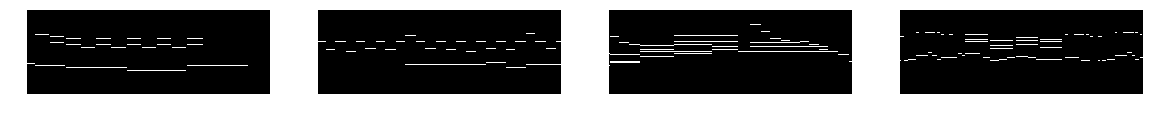

(4, 32, 32, 3)


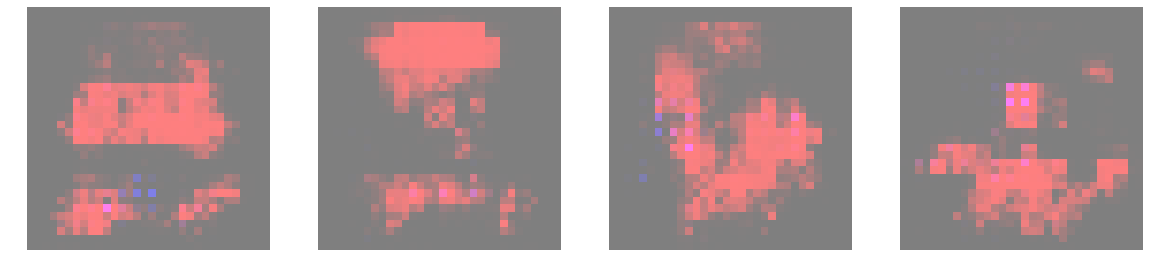

(4, 88, 256, 1)


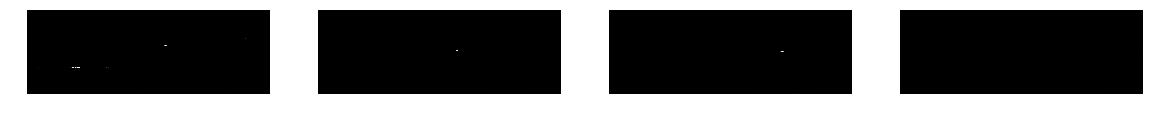

(4, 32, 32, 3)


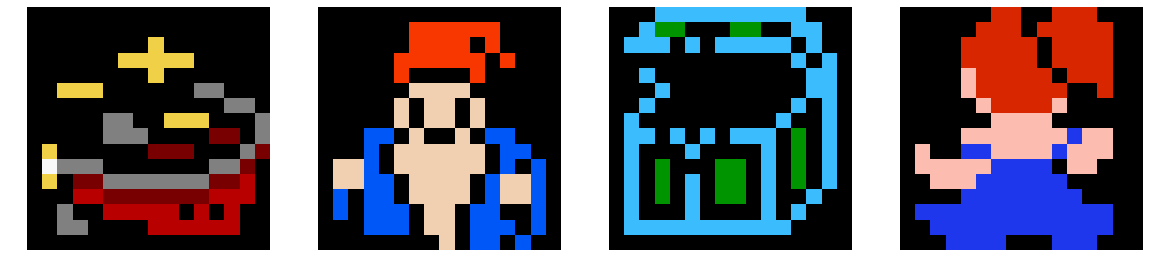

(4, 88, 256, 1)


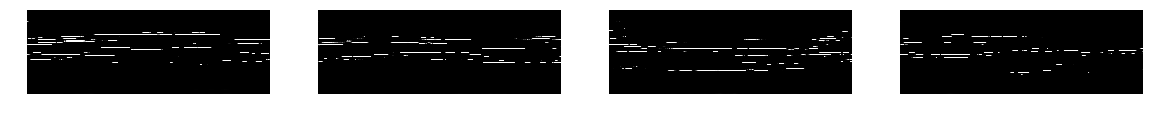

(4, 32, 32, 3)


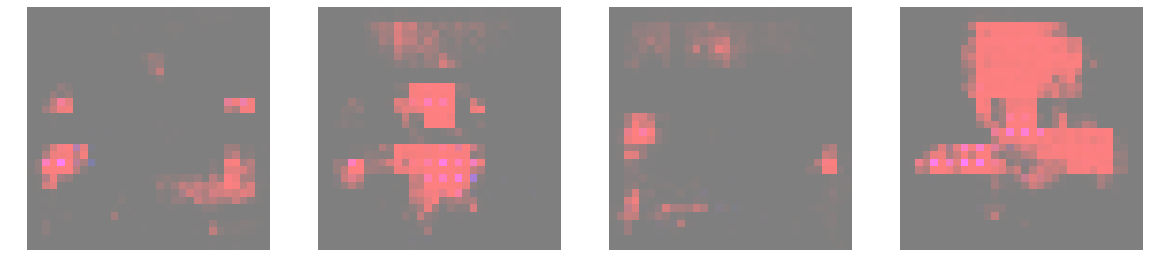

[59/110][20500] Loss_D: 0.045515 0.000716 Loss_G: 0.865115 1.001697 loss_cyc 0.824385 104.618
[59/110][20525] Loss_D: 0.038808 0.003635 Loss_G: 0.955476 1.004421 loss_cyc 0.805445 104.741
[59/110][20550] Loss_D: 0.053914 0.012769 Loss_G: 0.963308 1.007273 loss_cyc 0.823039 104.859
[59/110][20575] Loss_D: 0.026206 0.002448 Loss_G: 0.934051 1.003526 loss_cyc 0.826381 104.987
[59/110][20600] Loss_D: 0.030511 0.001546 Loss_G: 0.945082 1.004750 loss_cyc 0.810888 105.103
[59/110][20625] Loss_D: 0.034668 0.012660 Loss_G: 0.944075 1.012312 loss_cyc 0.800549 105.225
[59/110][20650] Loss_D: 0.047249 0.002759 Loss_G: 0.966321 0.996867 loss_cyc 0.817030 105.347
[59/110][20675] Loss_D: 0.031389 0.003771 Loss_G: 0.986065 1.001339 loss_cyc 0.797261 105.464
[59/110][20700] Loss_D: 0.021598 0.006189 Loss_G: 1.016023 1.005197 loss_cyc 0.801502 105.587
[59/110][20725] Loss_D: 0.037898 0.003756 Loss_G: 0.956605 1.003584 loss_cyc 0.822439 105.715
[59/110][20750] Loss_D: 0.029710 0.001291 Loss_G: 0.877640 1

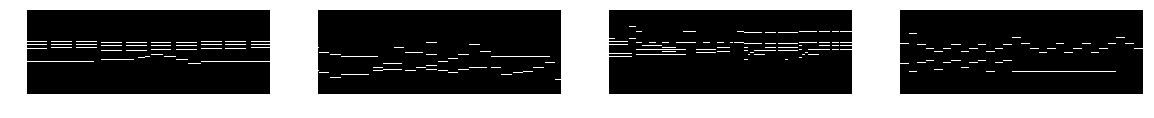

(4, 32, 32, 3)


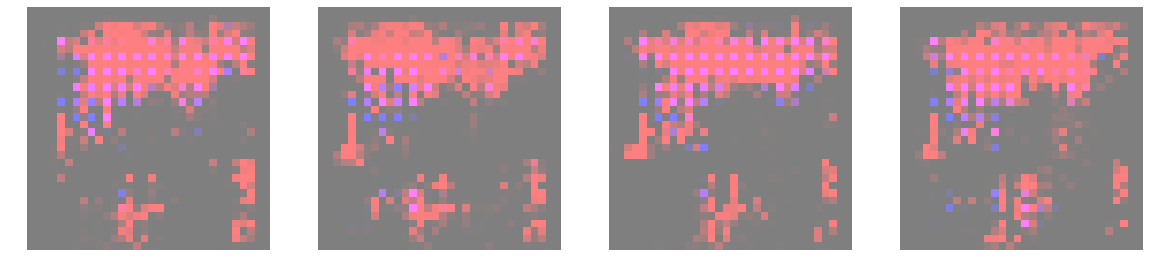

(4, 88, 256, 1)


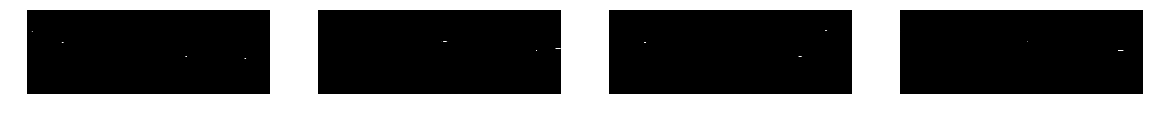

(4, 32, 32, 3)


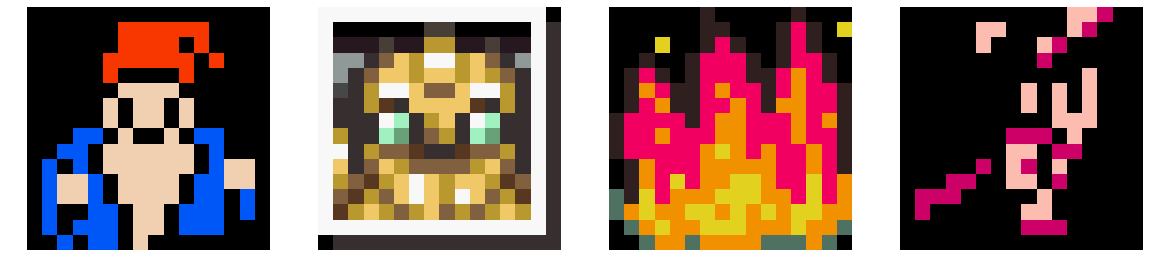

(4, 88, 256, 1)


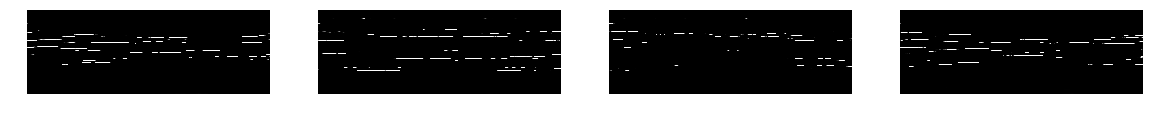

(4, 32, 32, 3)


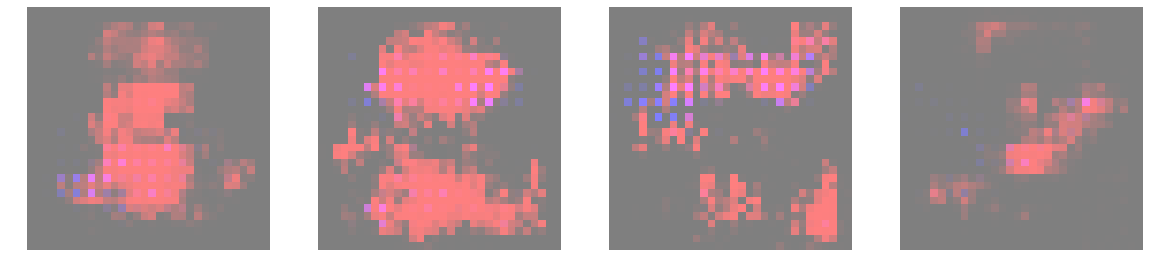

[60/110][20825] Loss_D: 0.031140 0.001138 Loss_G: 0.979087 0.999231 loss_cyc 0.802482 106.261
[60/110][20850] Loss_D: 0.025134 0.001647 Loss_G: 1.000021 1.006615 loss_cyc 0.816481 106.377
[60/110][20875] Loss_D: 0.034055 0.003624 Loss_G: 0.938647 1.002291 loss_cyc 0.794423 106.495
[60/110][20900] Loss_D: 0.017943 0.009290 Loss_G: 0.903912 1.014449 loss_cyc 0.844694 106.617
[60/110][20925] Loss_D: 0.032184 0.009163 Loss_G: 0.858628 0.998176 loss_cyc 0.824371 106.743
[60/110][20950] Loss_D: 0.027343 0.004473 Loss_G: 0.914083 1.007310 loss_cyc 0.828437 106.869
[60/110][20975] Loss_D: 0.030441 0.003568 Loss_G: 0.984223 0.999035 loss_cyc 0.811428 106.995
[60/110][21000] Loss_D: 0.042762 0.004725 Loss_G: 1.009221 1.008057 loss_cyc 0.806052 107.111
[60/110][21025] Loss_D: 0.029810 0.003955 Loss_G: 0.946932 1.003216 loss_cyc 0.835709 107.237
[60/110][21050] Loss_D: 0.030477 0.004287 Loss_G: 0.989669 1.006819 loss_cyc 0.814056 107.376
[60/110][21075] Loss_D: 0.037710 0.001524 Loss_G: 1.021047 1

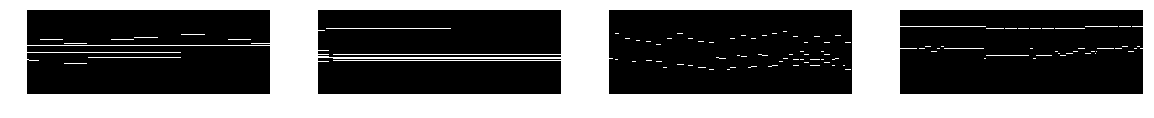

(4, 32, 32, 3)


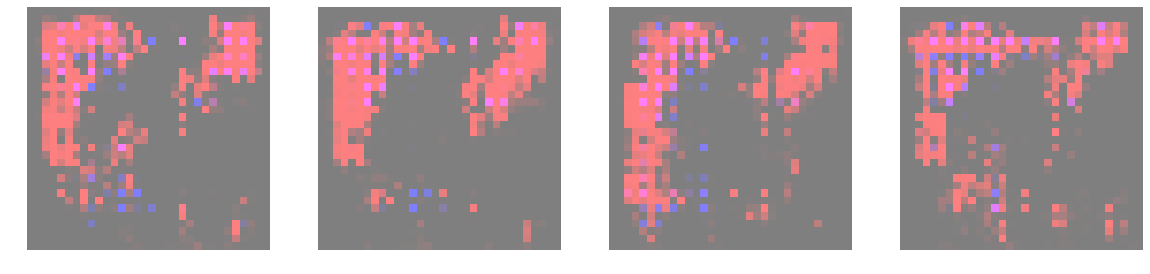

(4, 88, 256, 1)


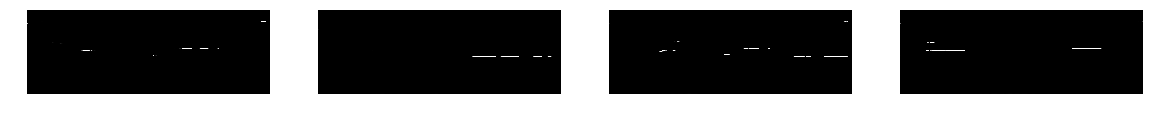

(4, 32, 32, 3)


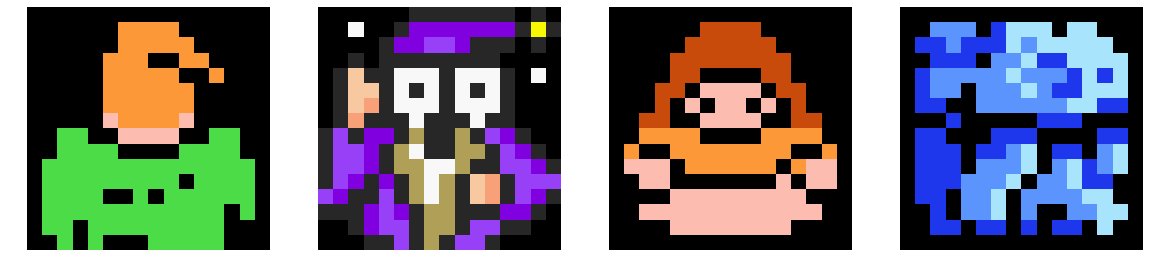

(4, 88, 256, 1)


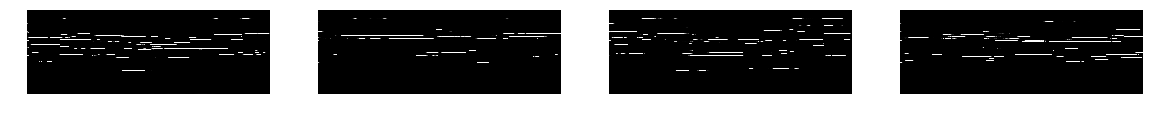

(4, 32, 32, 3)


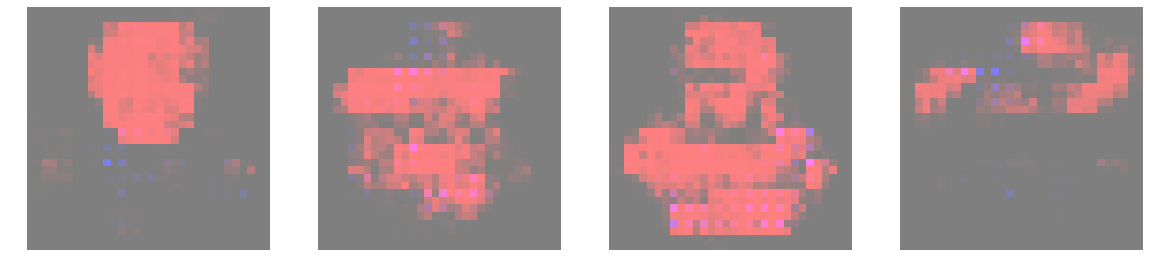

[61/110][21175] Loss_D: 0.041728 0.007237 Loss_G: 0.946200 1.009172 loss_cyc 0.808618 108.030
[61/110][21200] Loss_D: 0.029989 0.004769 Loss_G: 0.933250 1.005072 loss_cyc 0.824741 108.153
[61/110][21225] Loss_D: 0.052759 0.004739 Loss_G: 1.027513 1.001795 loss_cyc 0.856335 108.272
[61/110][21250] Loss_D: 0.035973 0.003095 Loss_G: 1.002899 1.006603 loss_cyc 0.810388 108.404
[61/110][21275] Loss_D: 0.045233 0.003364 Loss_G: 0.981827 0.998631 loss_cyc 0.798327 108.529
[61/110][21300] Loss_D: 0.032073 0.004002 Loss_G: 0.895156 1.003464 loss_cyc 0.808249 108.642
[61/110][21325] Loss_D: 0.030890 0.001634 Loss_G: 0.983613 1.000607 loss_cyc 0.834908 108.771
[61/110][21350] Loss_D: 0.034752 0.003343 Loss_G: 0.919797 1.001854 loss_cyc 0.812117 108.889
[61/110][21375] Loss_D: 0.017944 0.001926 Loss_G: 0.995264 1.006020 loss_cyc 0.823525 109.014
[61/110][21400] Loss_D: 0.027657 0.002969 Loss_G: 0.994610 1.001806 loss_cyc 0.805672 109.135
[61/110][21425] Loss_D: 0.031361 0.002322 Loss_G: 1.042542 1

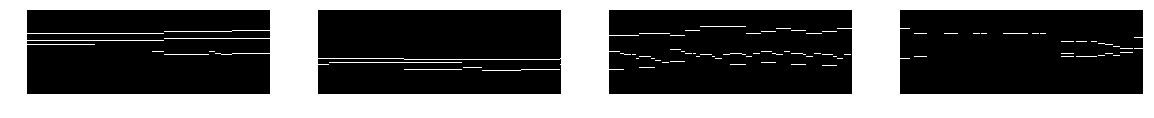

(4, 32, 32, 3)


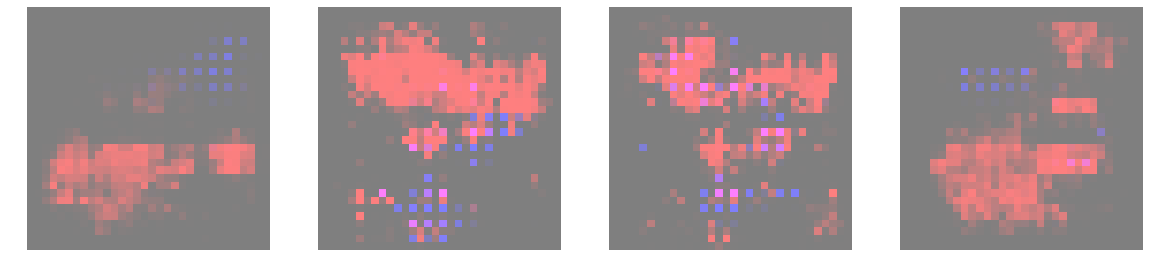

(4, 88, 256, 1)


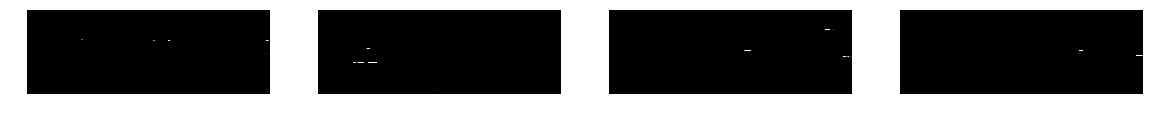

(4, 32, 32, 3)


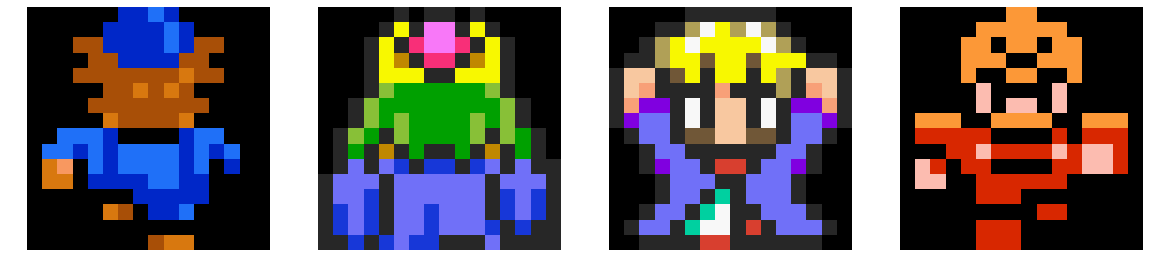

(4, 88, 256, 1)


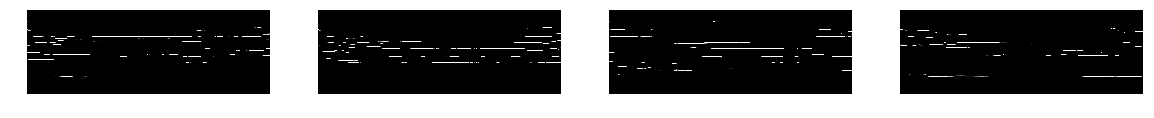

(4, 32, 32, 3)


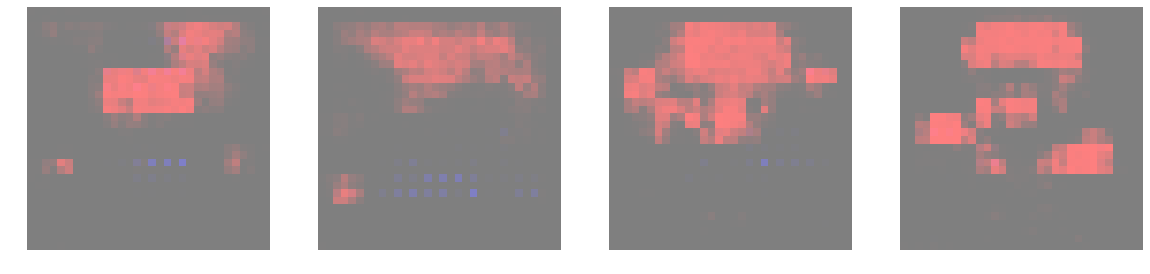

[62/110][21525] Loss_D: 0.049244 0.008939 Loss_G: 0.920299 1.008029 loss_cyc 0.806509 109.785
[62/110][21550] Loss_D: 0.031293 0.005886 Loss_G: 0.932161 1.008337 loss_cyc 0.851535 109.902
[62/110][21575] Loss_D: 0.029279 0.001474 Loss_G: 0.931959 0.995731 loss_cyc 0.840345 110.032
[62/110][21600] Loss_D: 0.037312 0.003806 Loss_G: 0.917316 1.007592 loss_cyc 0.837661 110.148
[62/110][21625] Loss_D: 0.029859 0.002308 Loss_G: 0.919095 0.996901 loss_cyc 0.823263 110.265
[62/110][21650] Loss_D: 0.032202 0.001349 Loss_G: 0.956931 1.003450 loss_cyc 0.809705 110.394
[62/110][21675] Loss_D: 0.036424 0.002089 Loss_G: 0.946731 0.998483 loss_cyc 0.816733 110.529
[62/110][21700] Loss_D: 0.043288 0.001268 Loss_G: 0.913658 1.000384 loss_cyc 0.813326 110.649
[62/110][21725] Loss_D: 0.034544 0.001907 Loss_G: 0.944692 1.005300 loss_cyc 0.864976 110.778
[62/110][21750] Loss_D: 0.029729 0.002849 Loss_G: 0.988251 0.999722 loss_cyc 0.789188 110.904
[62/110][21775] Loss_D: 0.028501 0.002391 Loss_G: 0.998526 0

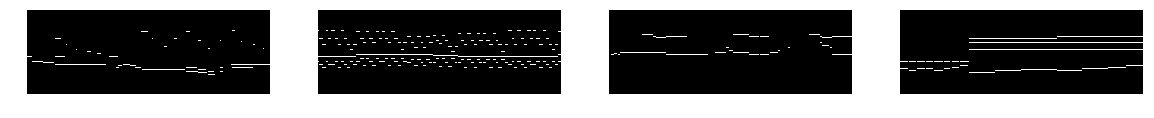

(4, 32, 32, 3)


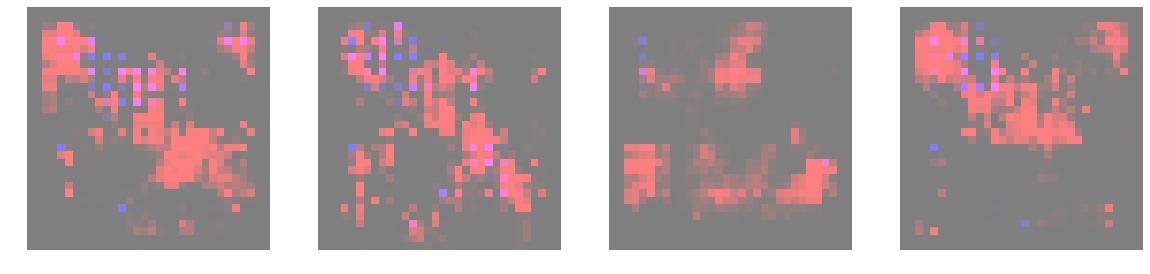

(4, 88, 256, 1)


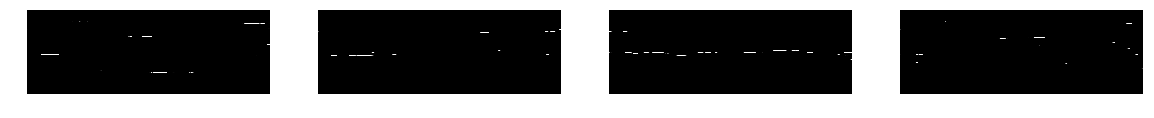

(4, 32, 32, 3)


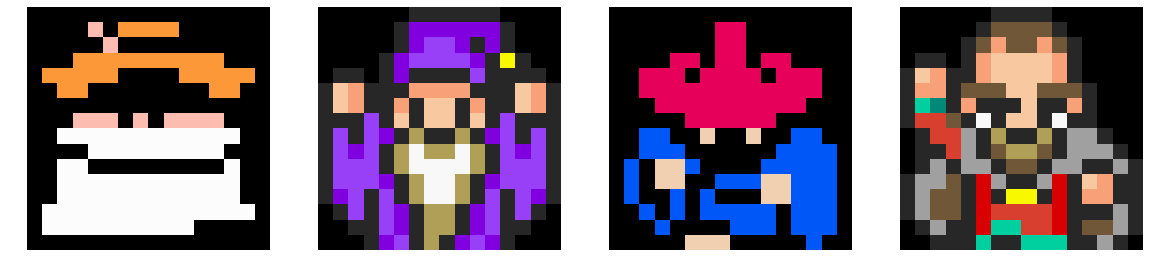

(4, 88, 256, 1)


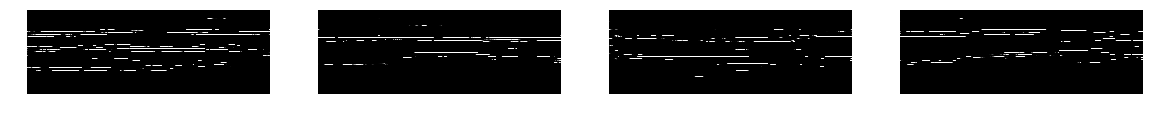

(4, 32, 32, 3)


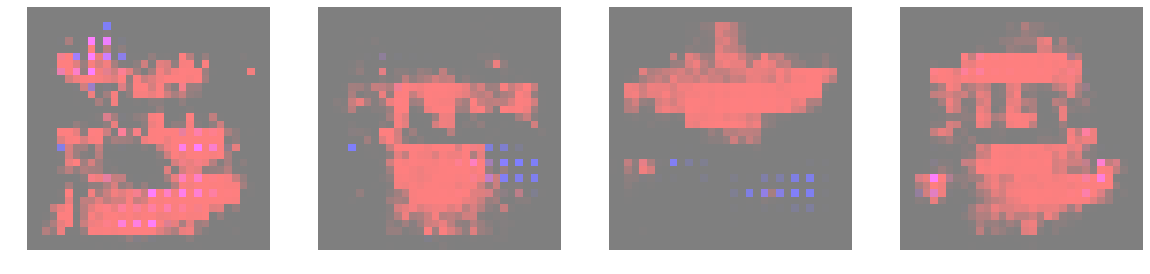

[63/110][21875] Loss_D: 0.028088 0.002443 Loss_G: 0.925654 1.003752 loss_cyc 0.824816 111.557
[63/110][21900] Loss_D: 0.018883 0.009933 Loss_G: 1.005884 1.006811 loss_cyc 0.832794 111.682
[63/110][21925] Loss_D: 0.033787 0.001959 Loss_G: 0.957673 1.003950 loss_cyc 0.806104 111.795
[63/110][21950] Loss_D: 0.039379 0.004688 Loss_G: 0.917910 0.999075 loss_cyc 0.810003 111.921
[63/110][21975] Loss_D: 0.027572 0.002673 Loss_G: 1.017800 1.010062 loss_cyc 0.819349 112.042
[63/110][22000] Loss_D: 0.033366 0.008650 Loss_G: 0.950165 1.004833 loss_cyc 0.813081 112.171
[63/110][22025] Loss_D: 0.026160 0.004805 Loss_G: 0.861667 1.001126 loss_cyc 0.819940 112.298
[63/110][22050] Loss_D: 0.051998 0.006025 Loss_G: 0.924735 1.005867 loss_cyc 0.808938 112.432
[63/110][22075] Loss_D: 0.029290 0.000331 Loss_G: 0.963150 1.000116 loss_cyc 0.814098 112.551
[63/110][22100] Loss_D: 0.045908 0.001078 Loss_G: 0.908204 1.001644 loss_cyc 0.814198 112.664
[63/110][22125] Loss_D: 0.042182 0.002547 Loss_G: 0.897373 0

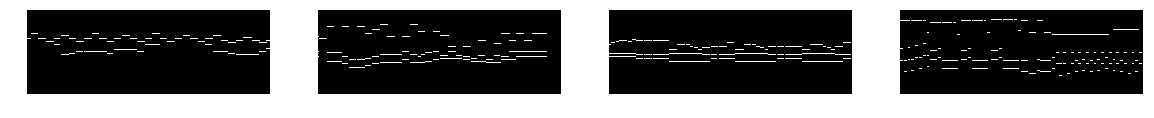

(4, 32, 32, 3)


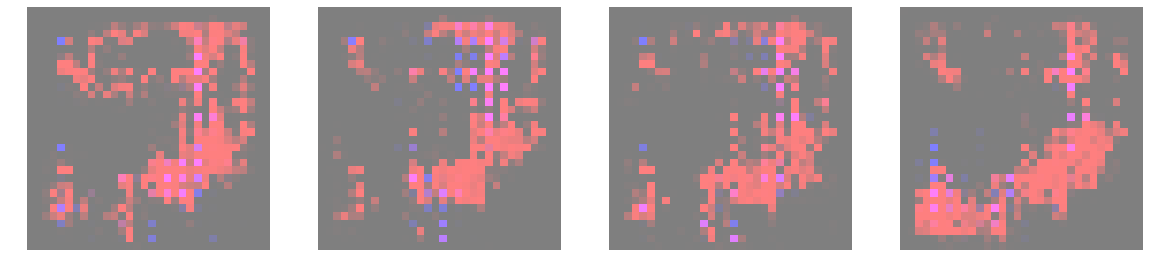

(4, 88, 256, 1)


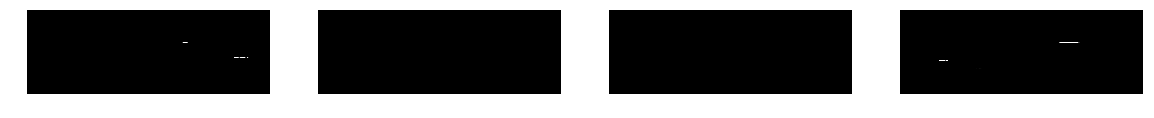

(4, 32, 32, 3)


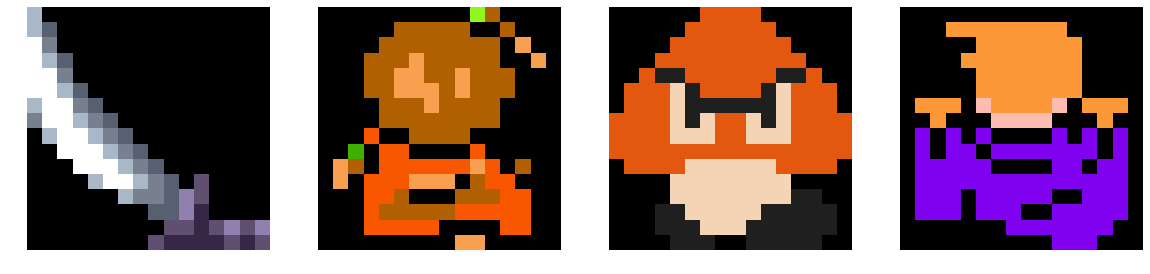

(4, 88, 256, 1)


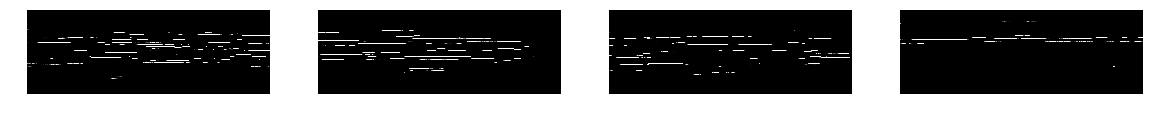

(4, 32, 32, 3)


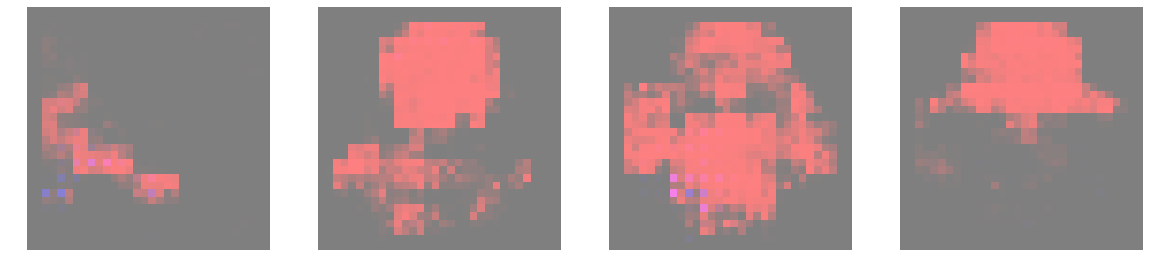

[64/110][22225] Loss_D: 0.034162 0.004211 Loss_G: 0.960222 1.002792 loss_cyc 0.808071 113.332
[64/110][22250] Loss_D: 0.031127 0.001411 Loss_G: 0.880575 1.008686 loss_cyc 0.838051 113.449
[64/110][22275] Loss_D: 0.025245 0.007193 Loss_G: 0.961430 0.997366 loss_cyc 0.822851 113.568
[64/110][22300] Loss_D: 0.035768 0.002735 Loss_G: 1.010172 1.006470 loss_cyc 0.814295 113.692
[64/110][22325] Loss_D: 0.036836 0.002183 Loss_G: 0.893150 0.995672 loss_cyc 0.815102 113.819
[64/110][22350] Loss_D: 0.031240 0.003238 Loss_G: 0.987280 1.010727 loss_cyc 0.841122 113.932
[64/110][22375] Loss_D: 0.038886 0.004930 Loss_G: 0.915433 1.000109 loss_cyc 0.825264 114.049
[64/110][22400] Loss_D: 0.032929 0.000892 Loss_G: 0.903798 1.002761 loss_cyc 0.806357 114.171
[64/110][22425] Loss_D: 0.031752 0.004586 Loss_G: 0.945674 1.003016 loss_cyc 0.815688 114.292
[64/110][22450] Loss_D: 0.032526 0.003095 Loss_G: 0.920981 1.006567 loss_cyc 0.804902 114.416
[64/110][22475] Loss_D: 0.051641 0.003845 Loss_G: 0.896073 0

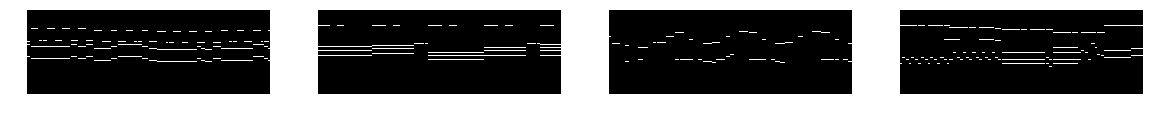

(4, 32, 32, 3)


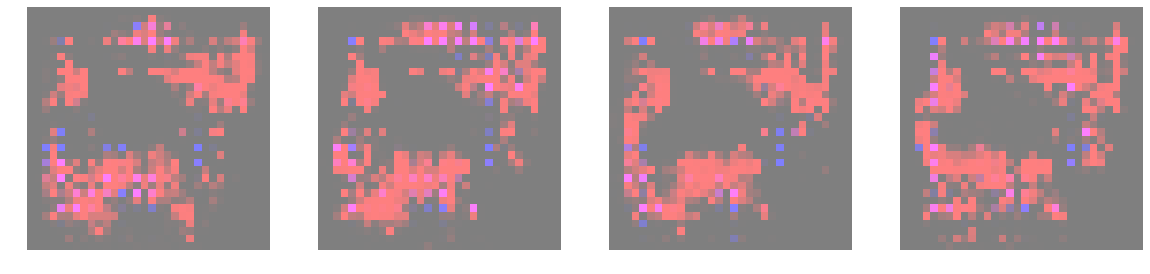

(4, 88, 256, 1)


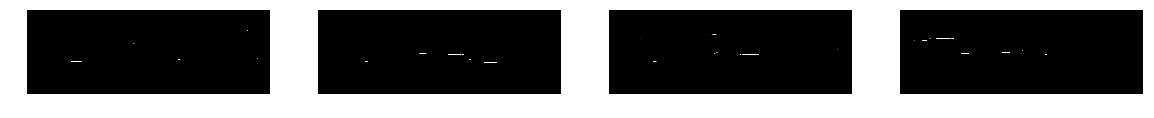

(4, 32, 32, 3)


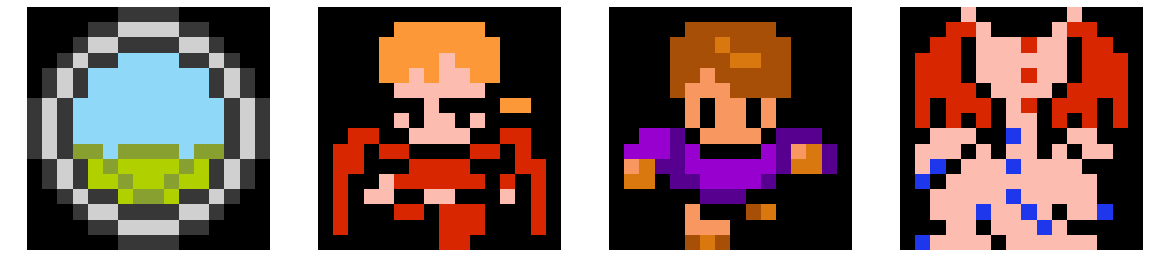

(4, 88, 256, 1)


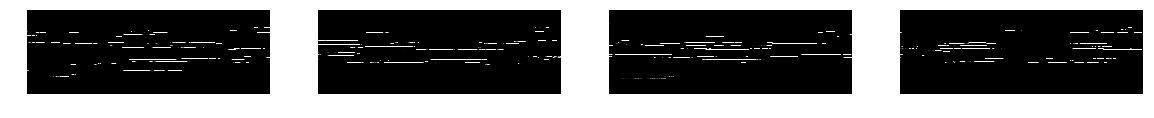

(4, 32, 32, 3)


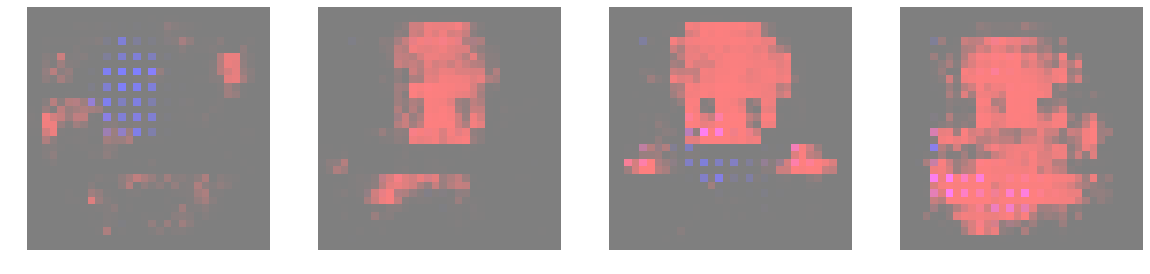

[65/110][22575] Loss_D: 0.039638 0.001587 Loss_G: 0.989266 1.001018 loss_cyc 0.823238 115.092
[65/110][22600] Loss_D: 0.029510 0.002578 Loss_G: 0.945959 0.998157 loss_cyc 0.845792 115.213
[65/110][22625] Loss_D: 0.034793 0.002560 Loss_G: 0.918592 1.003891 loss_cyc 0.824060 115.339
[65/110][22650] Loss_D: 0.043365 0.005309 Loss_G: 0.927636 1.004541 loss_cyc 0.805450 115.459
[65/110][22675] Loss_D: 0.046431 0.002824 Loss_G: 0.963445 1.002508 loss_cyc 0.808361 115.578
[65/110][22700] Loss_D: 0.044670 0.006564 Loss_G: 0.898386 1.012521 loss_cyc 0.817969 115.692
[65/110][22725] Loss_D: 0.038644 0.004559 Loss_G: 0.951921 0.998278 loss_cyc 0.829274 115.824
[65/110][22750] Loss_D: 0.042968 0.000717 Loss_G: 0.979757 0.999473 loss_cyc 0.829375 115.955
[65/110][22775] Loss_D: 0.037378 0.003452 Loss_G: 0.944424 1.001687 loss_cyc 0.832725 116.081
[65/110][22800] Loss_D: 0.039797 0.002492 Loss_G: 0.913714 1.000557 loss_cyc 0.813067 116.194
[65/110][22825] Loss_D: 0.038216 0.003024 Loss_G: 0.888429 1

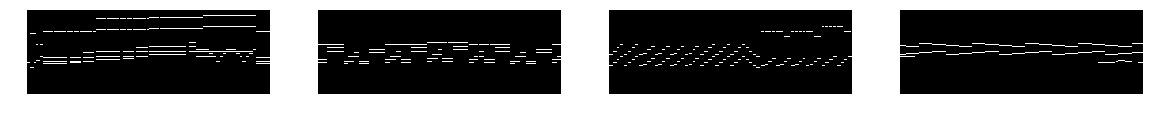

(4, 32, 32, 3)


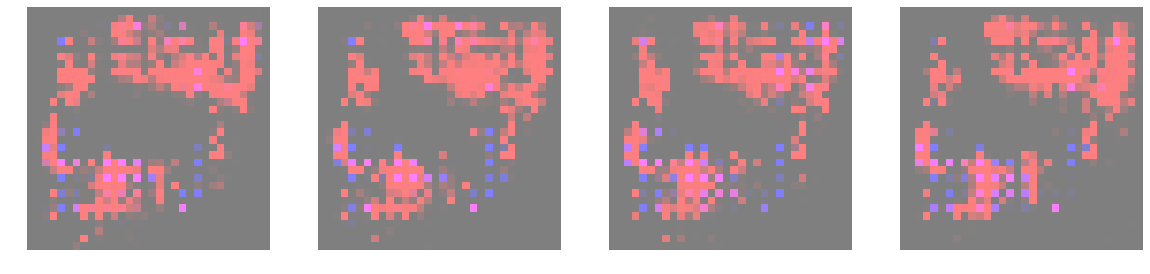

(4, 88, 256, 1)


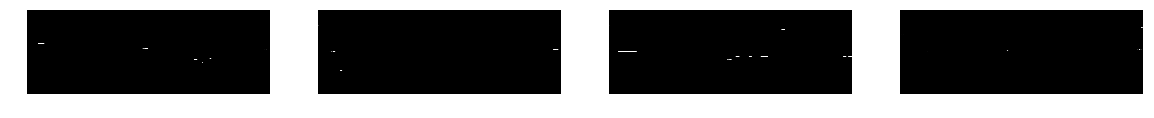

(4, 32, 32, 3)


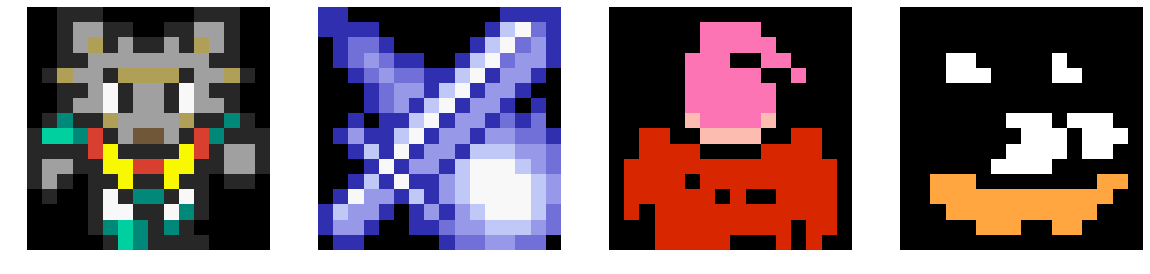

(4, 88, 256, 1)


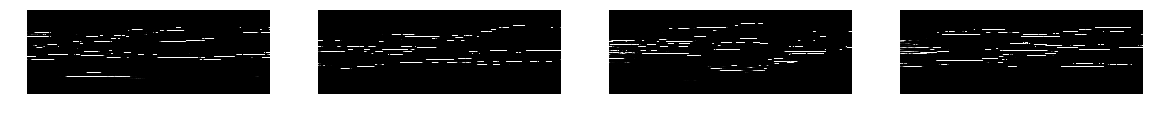

(4, 32, 32, 3)


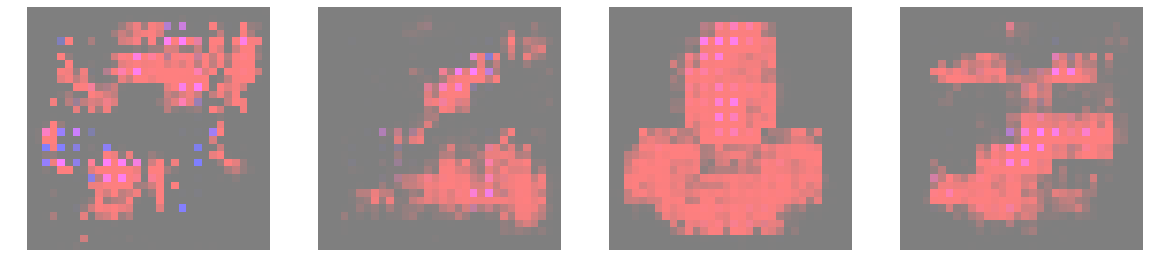

[66/110][22925] Loss_D: 0.033179 0.003105 Loss_G: 0.950249 1.001003 loss_cyc 0.824959 116.867
[66/110][22950] Loss_D: 0.034186 0.004363 Loss_G: 0.926502 1.003310 loss_cyc 0.823120 116.990
[66/110][22975] Loss_D: 0.050528 0.001300 Loss_G: 0.885626 1.005149 loss_cyc 0.794787 117.110
[66/110][23000] Loss_D: 0.059676 0.003939 Loss_G: 0.959996 0.998387 loss_cyc 0.796554 117.228
[66/110][23025] Loss_D: 0.050543 0.003010 Loss_G: 0.903963 1.000007 loss_cyc 0.820531 117.361
[66/110][23050] Loss_D: 0.045044 0.003791 Loss_G: 0.985734 1.008546 loss_cyc 0.822788 117.479
[66/110][23075] Loss_D: 0.041276 0.002834 Loss_G: 0.859250 1.004619 loss_cyc 0.830565 117.599
[66/110][23100] Loss_D: 0.026349 0.004833 Loss_G: 0.880681 0.998933 loss_cyc 0.819542 117.720
[66/110][23125] Loss_D: 0.026662 0.004106 Loss_G: 0.957537 1.006710 loss_cyc 0.813384 117.849
[66/110][23150] Loss_D: 0.040473 0.004579 Loss_G: 0.881125 1.003420 loss_cyc 0.838374 117.971
[66/110][23175] Loss_D: 0.031561 0.004749 Loss_G: 0.916682 1

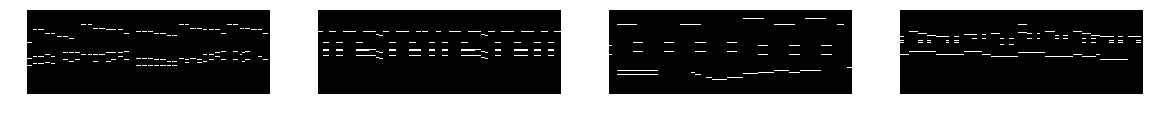

(4, 32, 32, 3)


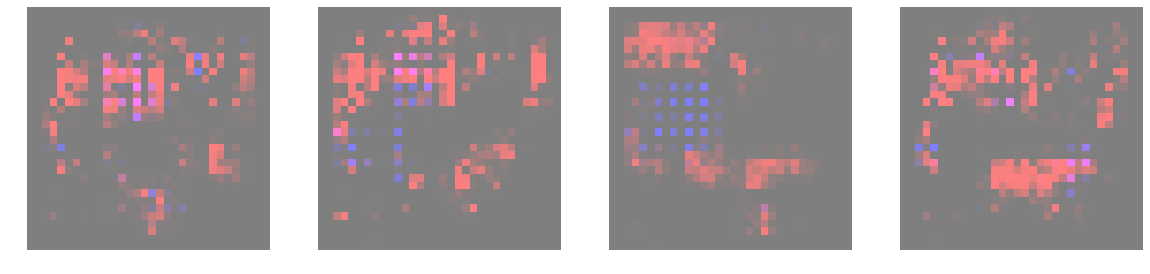

(4, 88, 256, 1)


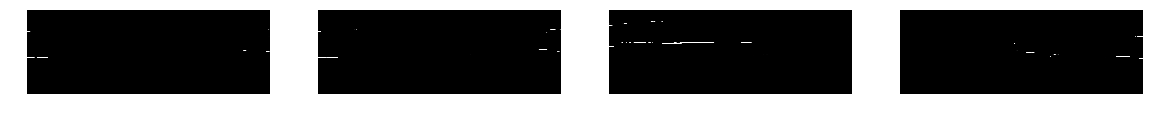

(4, 32, 32, 3)


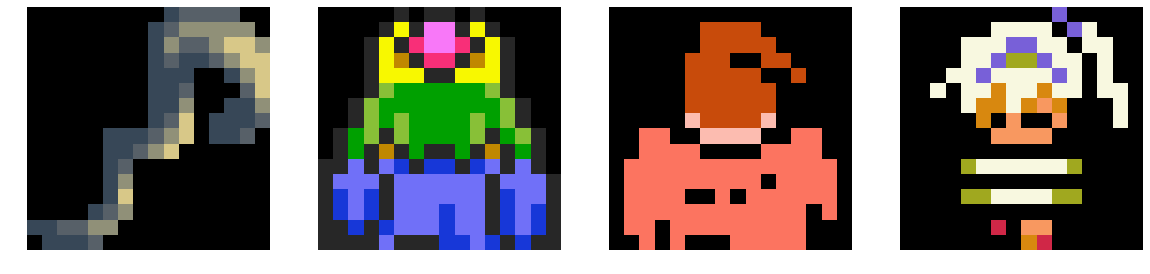

(4, 88, 256, 1)


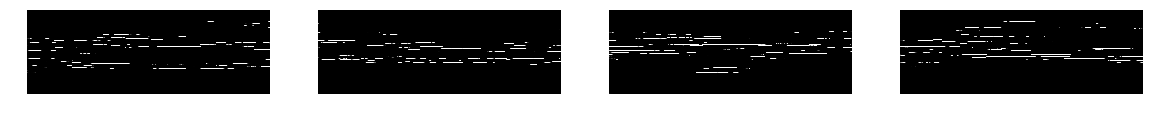

(4, 32, 32, 3)


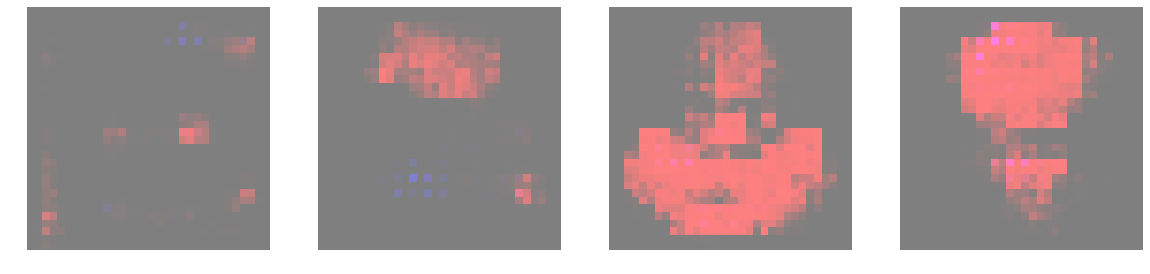

[67/110][23275] Loss_D: 0.043740 0.002689 Loss_G: 0.909894 1.008335 loss_cyc 0.807997 118.621
[67/110][23300] Loss_D: 0.047419 0.007242 Loss_G: 0.908844 0.998599 loss_cyc 0.818530 118.747
[67/110][23325] Loss_D: 0.030114 0.001906 Loss_G: 0.944619 1.001627 loss_cyc 0.817444 118.863
[67/110][23350] Loss_D: 0.047770 0.002430 Loss_G: 0.827962 1.000058 loss_cyc 0.824332 118.980
[67/110][23375] Loss_D: 0.030312 0.000717 Loss_G: 0.962288 1.002478 loss_cyc 0.839305 119.104
[67/110][23400] Loss_D: 0.030732 0.001305 Loss_G: 0.977366 1.001323 loss_cyc 0.812451 119.231
[67/110][23425] Loss_D: 0.031715 0.002277 Loss_G: 0.929491 1.000329 loss_cyc 0.827860 119.350
[67/110][23450] Loss_D: 0.035310 0.003169 Loss_G: 1.022877 1.000557 loss_cyc 0.806959 119.473
[67/110][23475] Loss_D: 0.039599 0.005113 Loss_G: 0.922803 1.009110 loss_cyc 0.801425 119.599
[67/110][23500] Loss_D: 0.035194 0.001803 Loss_G: 0.898746 0.997884 loss_cyc 0.826757 119.723
[67/110][23525] Loss_D: 0.040333 0.003929 Loss_G: 0.908319 1

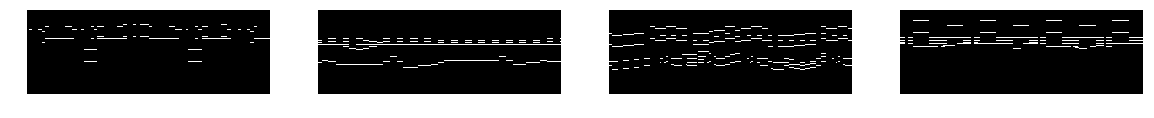

(4, 32, 32, 3)


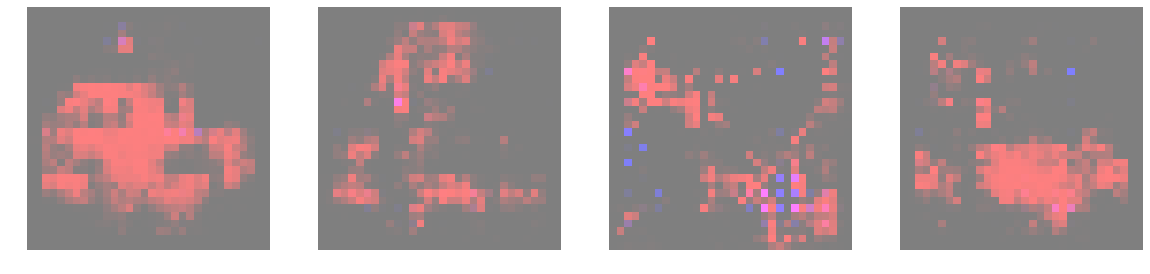

(4, 88, 256, 1)


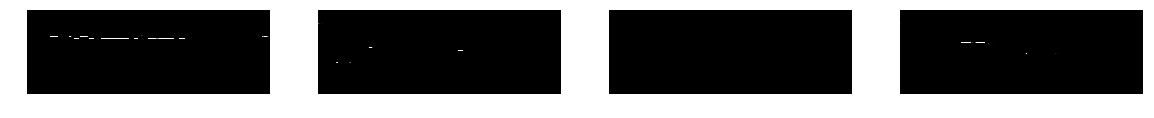

(4, 32, 32, 3)


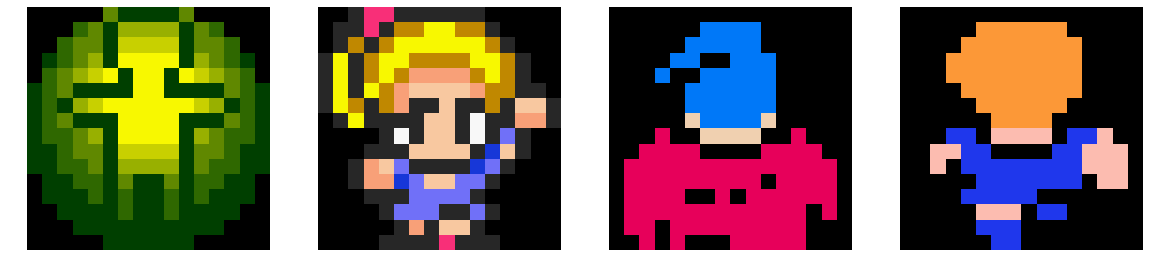

(4, 88, 256, 1)


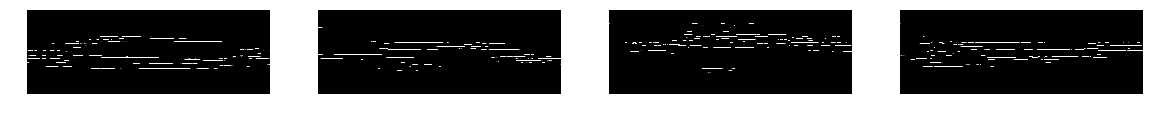

(4, 32, 32, 3)


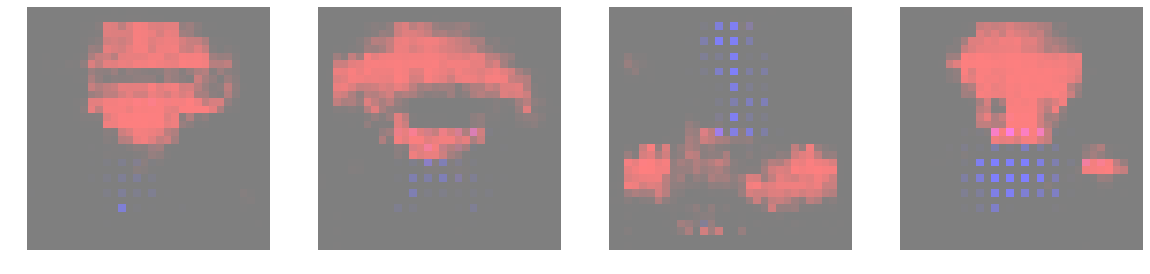

[68/110][23600] Loss_D: 0.048969 0.002914 Loss_G: 0.907990 1.006209 loss_cyc 0.835438 120.269
[68/110][23625] Loss_D: 0.030868 0.002298 Loss_G: 0.968648 1.003149 loss_cyc 0.836982 120.391
[68/110][23650] Loss_D: 0.022569 0.000436 Loss_G: 1.023424 1.001965 loss_cyc 0.812448 120.512
[68/110][23675] Loss_D: 0.032461 0.003882 Loss_G: 0.942482 1.001710 loss_cyc 0.828223 120.631
[68/110][23700] Loss_D: 0.051450 0.000362 Loss_G: 0.883855 0.998702 loss_cyc 0.824963 120.757
[68/110][23725] Loss_D: 0.061525 0.000669 Loss_G: 0.869043 1.002215 loss_cyc 0.823206 120.890
[68/110][23750] Loss_D: 0.060014 0.000709 Loss_G: 0.902850 1.001320 loss_cyc 0.822123 121.014
[68/110][23775] Loss_D: 0.040424 0.001505 Loss_G: 0.986572 1.002714 loss_cyc 0.799418 121.139
[68/110][23800] Loss_D: 0.039294 0.005896 Loss_G: 0.828833 1.001356 loss_cyc 0.822878 121.268
[68/110][23825] Loss_D: 0.049575 0.009742 Loss_G: 0.946279 1.013108 loss_cyc 0.788346 121.389
[68/110][23850] Loss_D: 0.043327 0.003002 Loss_G: 0.940326 0

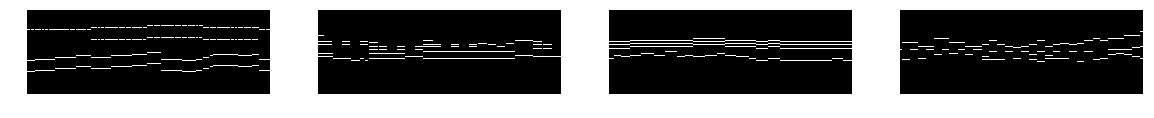

(4, 32, 32, 3)


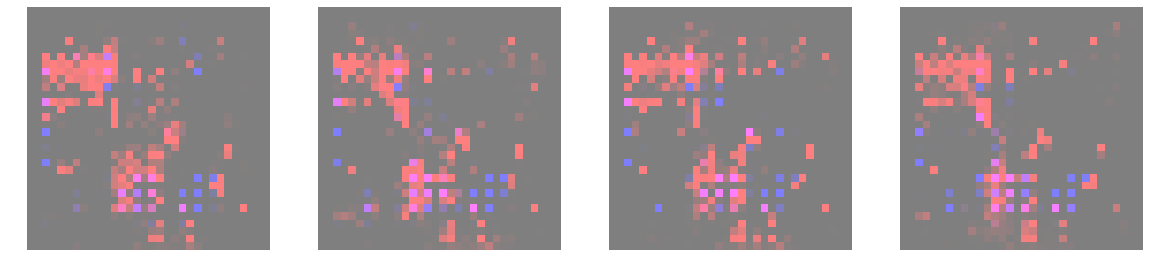

(4, 88, 256, 1)


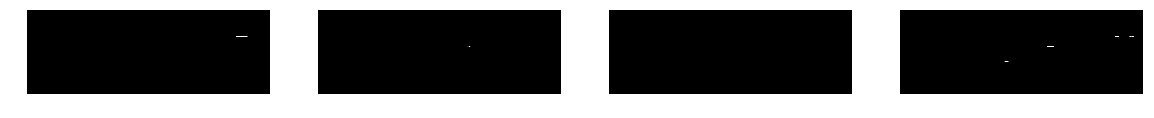

(4, 32, 32, 3)


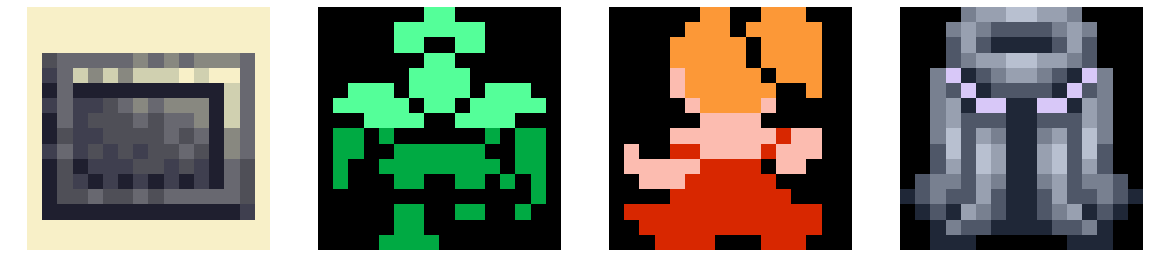

(4, 88, 256, 1)


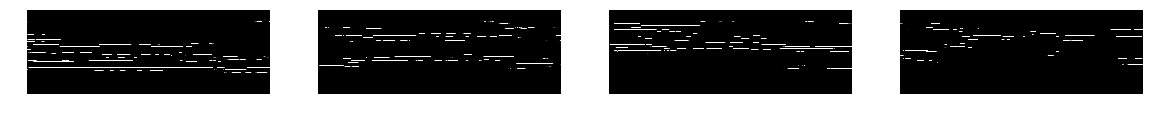

(4, 32, 32, 3)


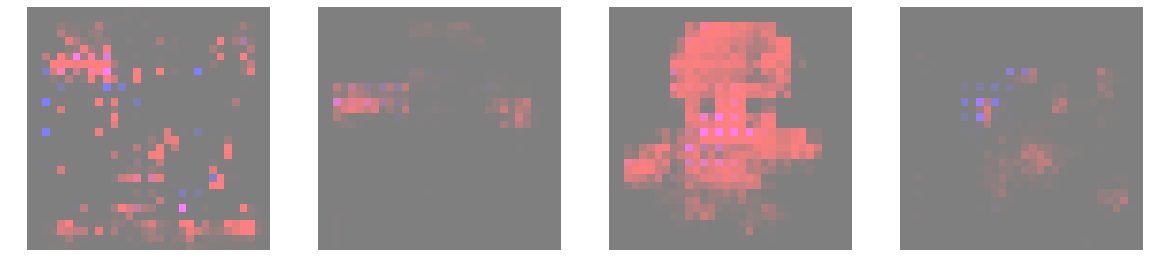

[69/110][23950] Loss_D: 0.029236 0.001269 Loss_G: 0.946817 0.995057 loss_cyc 0.814004 122.037
[69/110][23975] Loss_D: 0.037067 0.001754 Loss_G: 0.900630 0.999427 loss_cyc 0.830715 122.152
[69/110][24000] Loss_D: 0.048363 0.006051 Loss_G: 0.862456 1.011713 loss_cyc 0.795441 122.266
[69/110][24025] Loss_D: 0.034611 0.003468 Loss_G: 0.939671 0.998876 loss_cyc 0.827733 122.386
[69/110][24050] Loss_D: 0.026985 0.002900 Loss_G: 0.948198 1.002822 loss_cyc 0.815755 122.515
[69/110][24075] Loss_D: 0.030538 0.002232 Loss_G: 0.963510 1.003272 loss_cyc 0.777631 122.634
[69/110][24100] Loss_D: 0.034653 0.001026 Loss_G: 0.940406 0.999434 loss_cyc 0.810928 122.757
[69/110][24125] Loss_D: 0.038307 0.002316 Loss_G: 0.861311 1.006331 loss_cyc 0.820063 122.880
[69/110][24150] Loss_D: 0.030160 0.003290 Loss_G: 0.906700 0.995513 loss_cyc 0.793444 122.997
[69/110][24175] Loss_D: 0.039845 0.003556 Loss_G: 0.962277 1.000544 loss_cyc 0.822580 123.120
[69/110][24200] Loss_D: 0.037619 0.003962 Loss_G: 0.898099 1

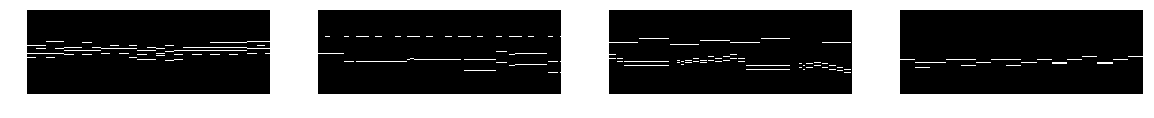

(4, 32, 32, 3)


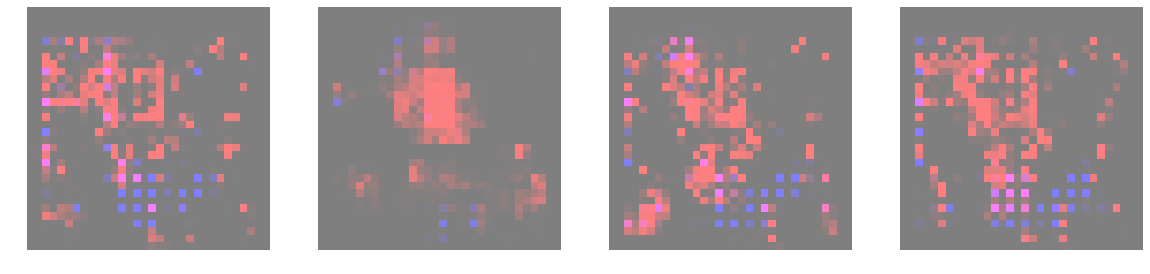

(4, 88, 256, 1)


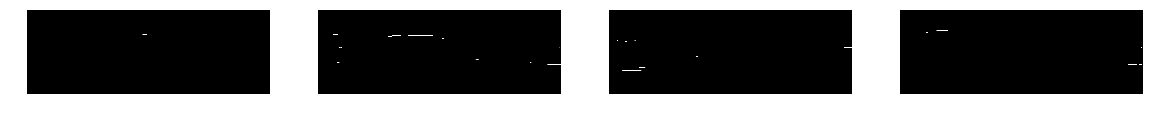

(4, 32, 32, 3)


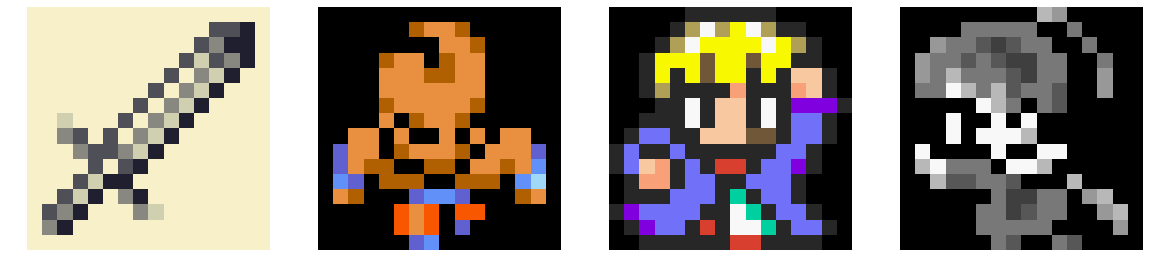

(4, 88, 256, 1)


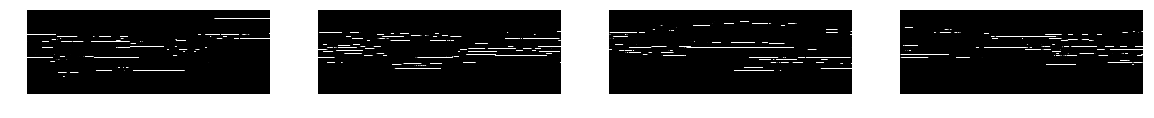

(4, 32, 32, 3)


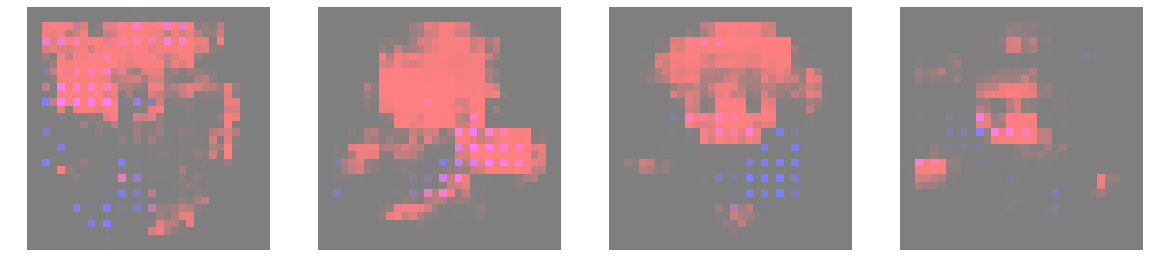

[70/110][24300] Loss_D: 0.034692 0.003608 Loss_G: 0.976085 1.001991 loss_cyc 0.823188 123.797
[70/110][24325] Loss_D: 0.027187 0.001493 Loss_G: 0.982032 1.002172 loss_cyc 0.836406 123.926
[70/110][24350] Loss_D: 0.029651 0.001409 Loss_G: 0.930495 1.004878 loss_cyc 0.822615 124.052
[70/110][24375] Loss_D: 0.039982 0.003833 Loss_G: 0.925041 1.002205 loss_cyc 0.810992 124.180
[70/110][24400] Loss_D: 0.032507 0.001690 Loss_G: 0.930787 1.004055 loss_cyc 0.824423 124.302
[70/110][24425] Loss_D: 0.053074 0.004792 Loss_G: 0.872799 0.998399 loss_cyc 0.820015 124.418
[70/110][24450] Loss_D: 0.049537 0.001408 Loss_G: 0.862044 1.004460 loss_cyc 0.813692 124.543
[70/110][24475] Loss_D: 0.039848 0.004723 Loss_G: 0.874095 1.003611 loss_cyc 0.833430 124.658
[70/110][24500] Loss_D: 0.040469 0.001407 Loss_G: 0.912123 1.000136 loss_cyc 0.840302 124.789
[70/110][24525] Loss_D: 0.035098 0.003634 Loss_G: 0.926880 1.001703 loss_cyc 0.825153 124.904
[70/110][24550] Loss_D: 0.024321 0.001795 Loss_G: 0.944928 1

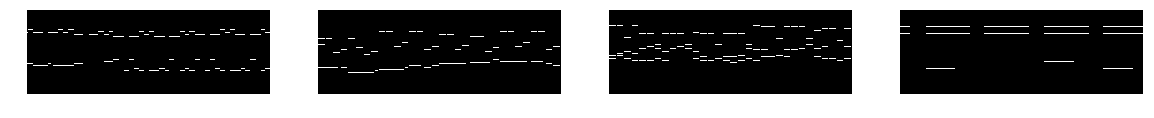

(4, 32, 32, 3)


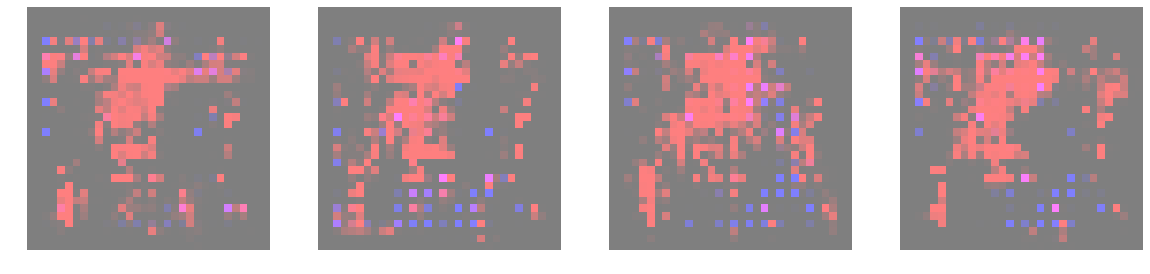

(4, 88, 256, 1)


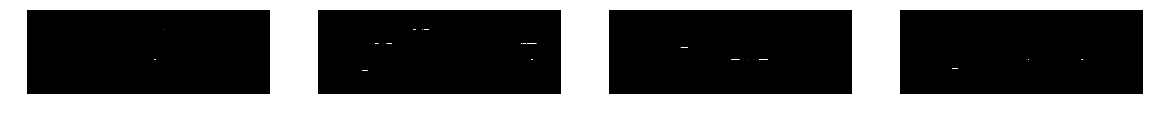

(4, 32, 32, 3)


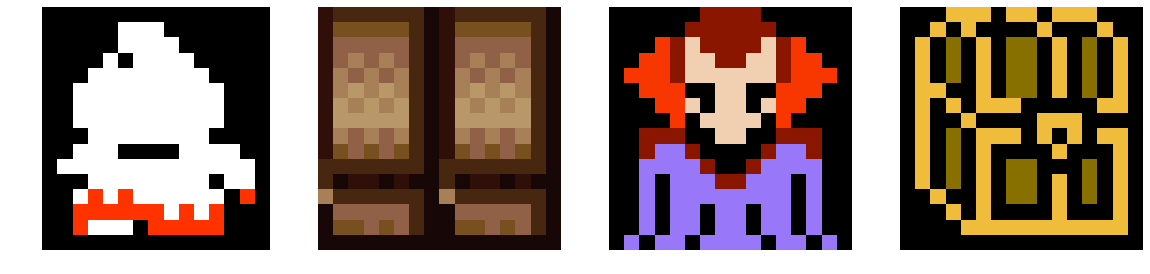

(4, 88, 256, 1)


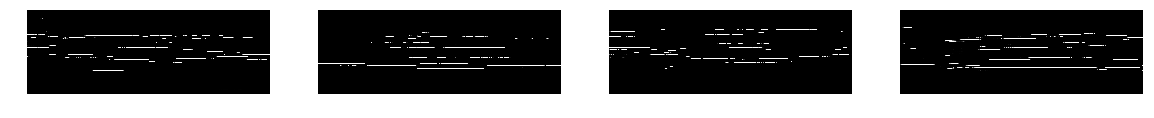

(4, 32, 32, 3)


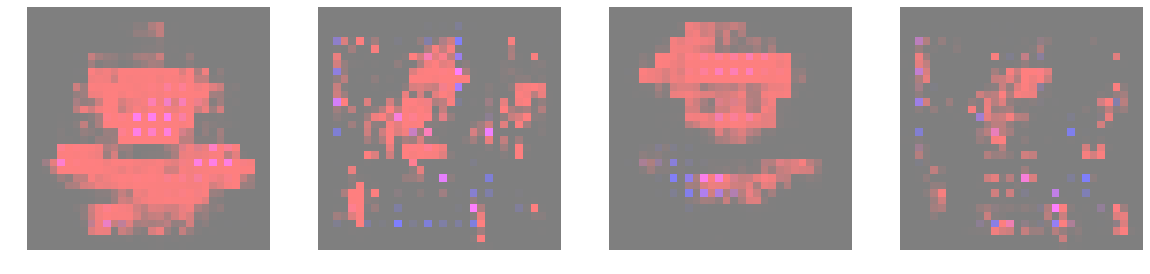

[71/110][24650] Loss_D: 0.043593 0.000592 Loss_G: 0.845023 1.001723 loss_cyc 0.826633 125.571
[71/110][24675] Loss_D: 0.044189 0.001410 Loss_G: 0.858879 0.998860 loss_cyc 0.821789 125.706
[71/110][24700] Loss_D: 0.032133 0.004799 Loss_G: 1.002736 0.999477 loss_cyc 0.839488 125.830
[71/110][24725] Loss_D: 0.023009 0.005753 Loss_G: 0.910850 1.011137 loss_cyc 0.825772 125.953
[71/110][24750] Loss_D: 0.033071 0.001459 Loss_G: 0.922393 0.998003 loss_cyc 0.815102 126.071
[71/110][24775] Loss_D: 0.035170 0.008766 Loss_G: 0.926743 1.009168 loss_cyc 0.803337 126.197
[71/110][24800] Loss_D: 0.030928 0.002482 Loss_G: 0.952980 1.001150 loss_cyc 0.798834 126.312
[71/110][24825] Loss_D: 0.030374 0.000876 Loss_G: 0.917788 1.000891 loss_cyc 0.802078 126.442
[71/110][24850] Loss_D: 0.027010 0.001113 Loss_G: 1.002242 1.000884 loss_cyc 0.807340 126.573
[71/110][24875] Loss_D: 0.045924 0.000660 Loss_G: 0.909744 1.002008 loss_cyc 0.784614 126.687
[71/110][24900] Loss_D: 0.016665 0.000800 Loss_G: 0.955019 0

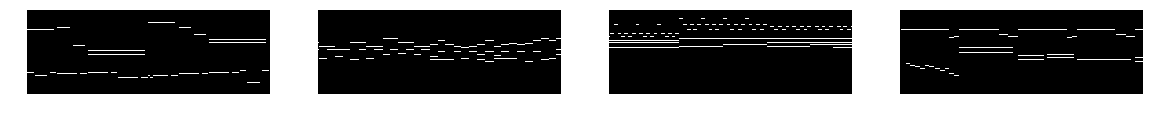

(4, 32, 32, 3)


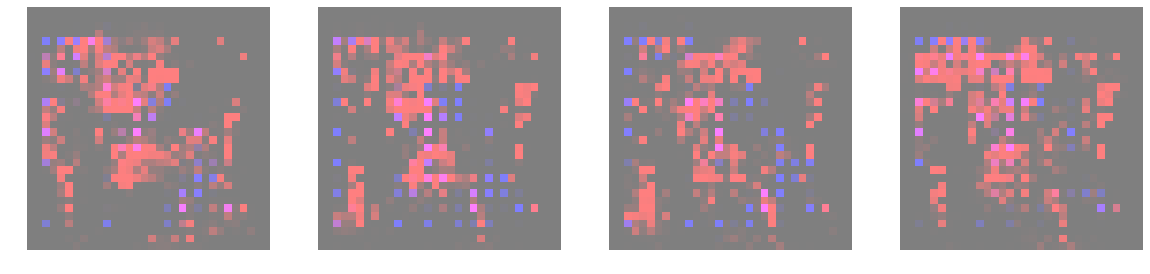

(4, 88, 256, 1)


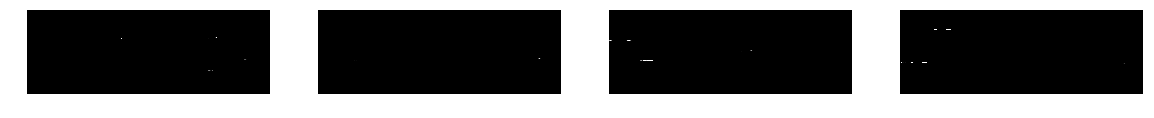

(4, 32, 32, 3)


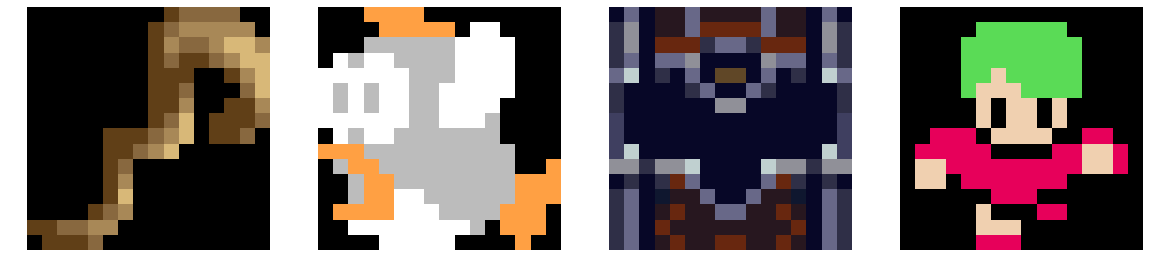

(4, 88, 256, 1)


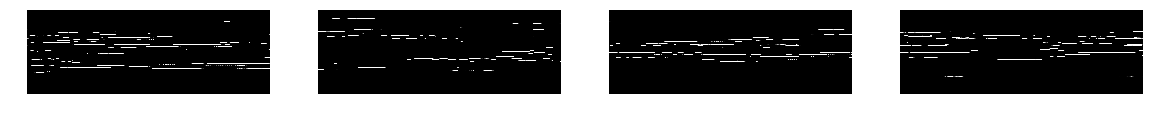

(4, 32, 32, 3)


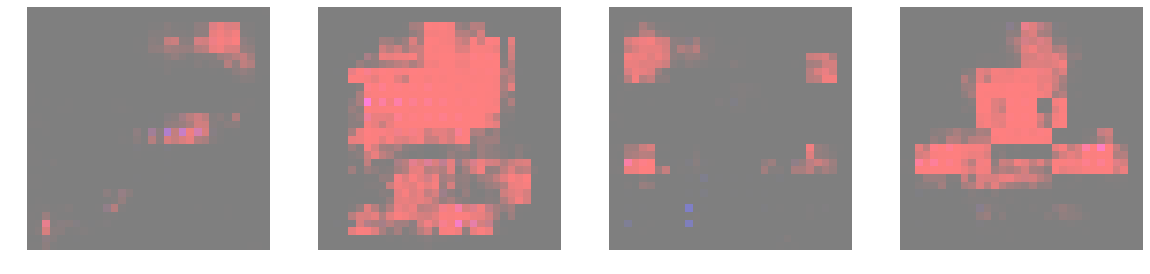

[72/110][25000] Loss_D: 0.025915 0.005050 Loss_G: 0.903821 1.005191 loss_cyc 0.822386 127.331
[72/110][25025] Loss_D: 0.024293 0.007775 Loss_G: 0.923755 1.011780 loss_cyc 0.812242 127.461
[72/110][25050] Loss_D: 0.047608 0.003573 Loss_G: 0.860022 0.995835 loss_cyc 0.797533 127.581
[72/110][25075] Loss_D: 0.026939 0.003974 Loss_G: 0.996317 1.011704 loss_cyc 0.817442 127.705
[72/110][25100] Loss_D: 0.026133 0.004247 Loss_G: 0.940392 0.995705 loss_cyc 0.808858 127.833
[72/110][25125] Loss_D: 0.025104 0.001022 Loss_G: 0.943791 1.004014 loss_cyc 0.816321 127.950
[72/110][25150] Loss_D: 0.030876 0.002494 Loss_G: 0.969201 1.003436 loss_cyc 0.822124 128.079
[72/110][25175] Loss_D: 0.035608 0.001219 Loss_G: 0.986310 0.999913 loss_cyc 0.843395 128.203
[72/110][25200] Loss_D: 0.025129 0.001069 Loss_G: 0.909169 0.998485 loss_cyc 0.794643 128.316
[72/110][25225] Loss_D: 0.032309 0.000499 Loss_G: 0.918068 1.000205 loss_cyc 0.831395 128.440
[72/110][25250] Loss_D: 0.029447 0.002468 Loss_G: 0.970581 0

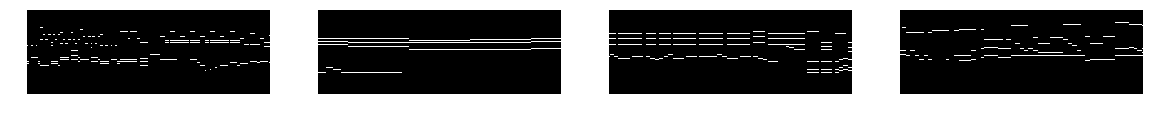

(4, 32, 32, 3)


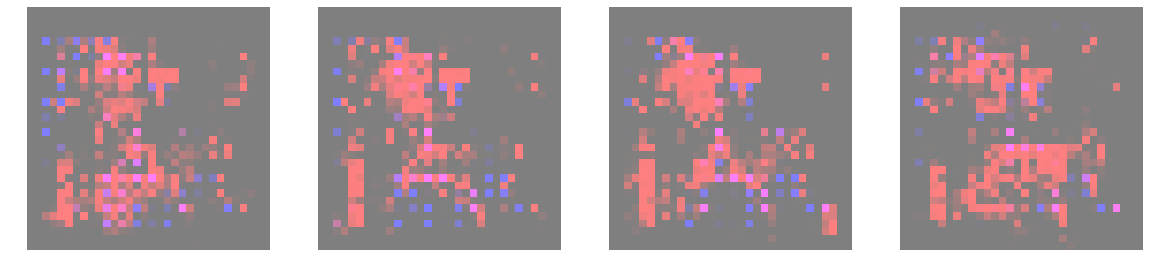

(4, 88, 256, 1)


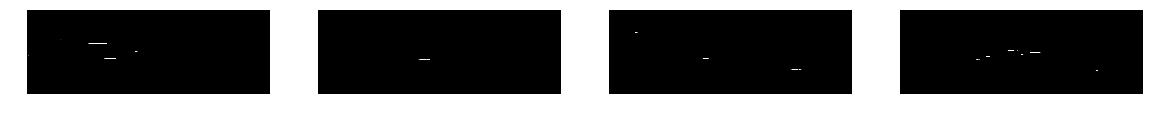

(4, 32, 32, 3)


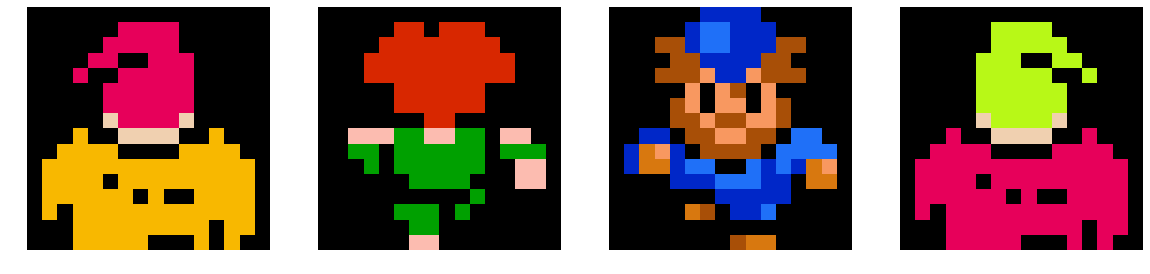

(4, 88, 256, 1)


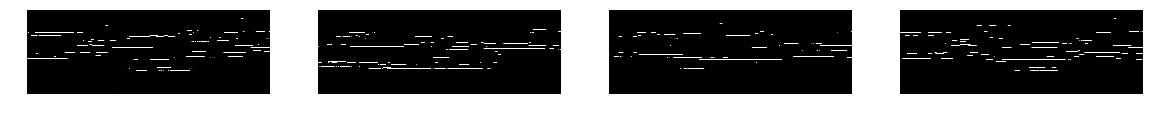

(4, 32, 32, 3)


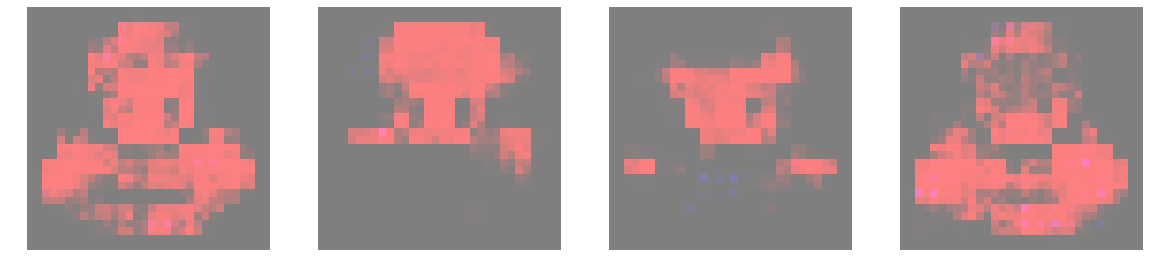

[73/110][25350] Loss_D: 0.035433 0.000620 Loss_G: 0.873837 0.997959 loss_cyc 0.820011 129.107
[73/110][25375] Loss_D: 0.046072 0.002893 Loss_G: 0.912419 1.003997 loss_cyc 0.824065 129.229
[73/110][25400] Loss_D: 0.028624 0.000928 Loss_G: 0.923290 1.003786 loss_cyc 0.818587 129.351
[73/110][25425] Loss_D: 0.029247 0.000938 Loss_G: 0.973828 1.000075 loss_cyc 0.802243 129.479
[73/110][25450] Loss_D: 0.038269 0.002738 Loss_G: 0.882822 1.001667 loss_cyc 0.812311 129.621
[73/110][25475] Loss_D: 0.029772 0.002662 Loss_G: 0.931056 0.999867 loss_cyc 0.835669 129.745
[73/110][25500] Loss_D: 0.040668 0.004597 Loss_G: 0.919867 1.004393 loss_cyc 0.827831 129.862
[73/110][25525] Loss_D: 0.028361 0.008805 Loss_G: 0.948370 1.006737 loss_cyc 0.796808 129.982
[73/110][25550] Loss_D: 0.032546 0.002558 Loss_G: 0.926432 1.001743 loss_cyc 0.836734 130.101
[73/110][25575] Loss_D: 0.026144 0.000991 Loss_G: 0.994988 0.999879 loss_cyc 0.831045 130.221
[73/110][25600] Loss_D: 0.035738 0.004046 Loss_G: 0.958786 1

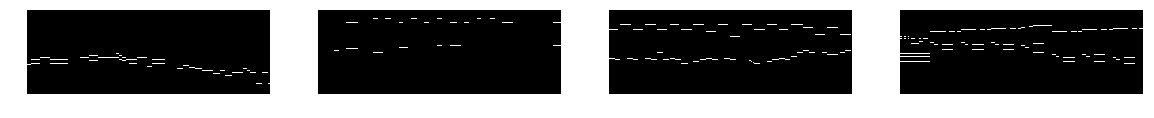

(4, 32, 32, 3)


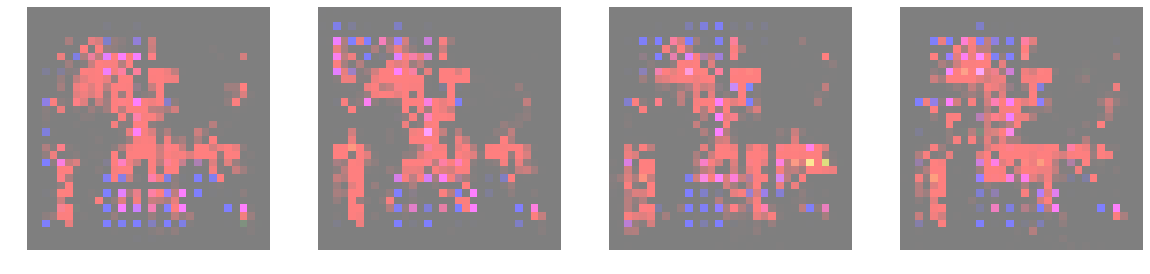

(4, 88, 256, 1)


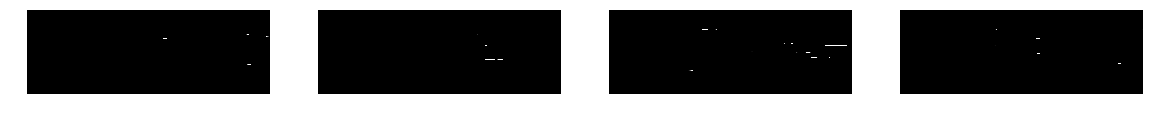

(4, 32, 32, 3)


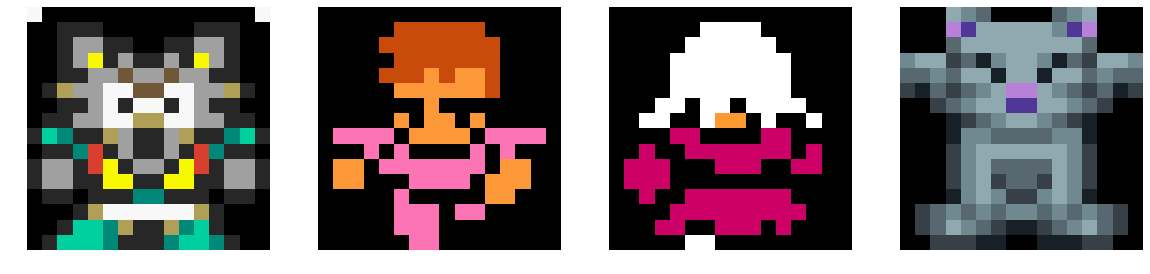

(4, 88, 256, 1)


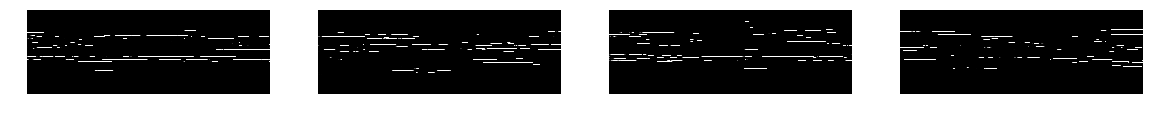

(4, 32, 32, 3)


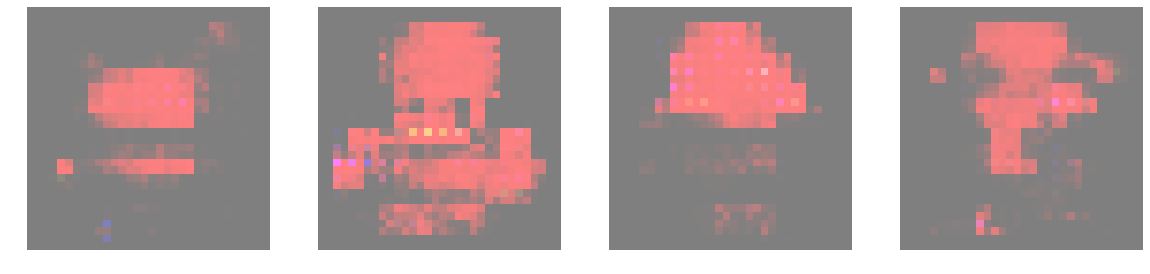

[74/110][25700] Loss_D: 0.026135 0.001582 Loss_G: 0.977446 1.002624 loss_cyc 0.801106 130.886
[74/110][25725] Loss_D: 0.025012 0.000620 Loss_G: 0.860707 0.999869 loss_cyc 0.798396 131.001
[74/110][25750] Loss_D: 0.027772 0.002641 Loss_G: 0.971924 1.005898 loss_cyc 0.802720 131.120
[74/110][25775] Loss_D: 0.031629 0.000490 Loss_G: 0.979592 0.996615 loss_cyc 0.835010 131.246
[74/110][25800] Loss_D: 0.029249 0.001561 Loss_G: 0.921897 1.004196 loss_cyc 0.811040 131.375
[74/110][25825] Loss_D: 0.019936 0.011679 Loss_G: 0.938356 1.013607 loss_cyc 0.843955 131.496
[74/110][25850] Loss_D: 0.047656 0.005842 Loss_G: 0.902748 1.001048 loss_cyc 0.829152 131.615
[74/110][25875] Loss_D: 0.027937 0.002123 Loss_G: 0.947327 1.002011 loss_cyc 0.848877 131.732
[74/110][25900] Loss_D: 0.030960 0.000787 Loss_G: 0.953534 1.000998 loss_cyc 0.826757 131.859
[74/110][25925] Loss_D: 0.034872 0.001537 Loss_G: 0.923334 1.001322 loss_cyc 0.823071 131.971
[74/110][25950] Loss_D: 0.039002 0.005600 Loss_G: 0.956078 1

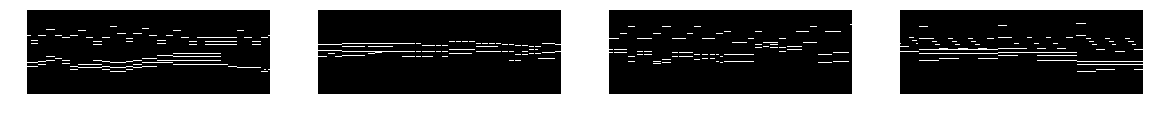

(4, 32, 32, 3)


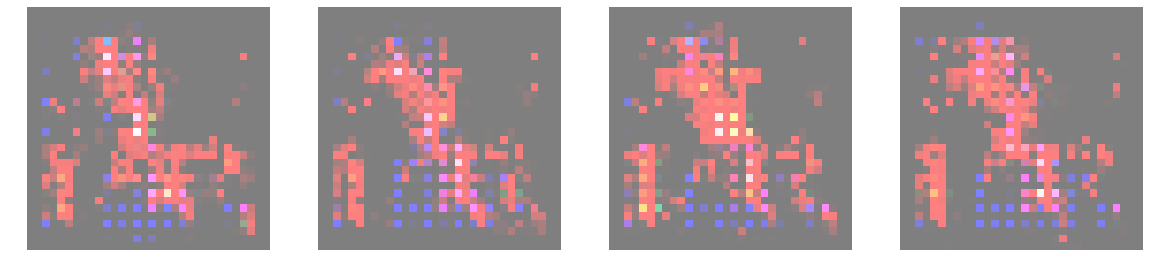

(4, 88, 256, 1)


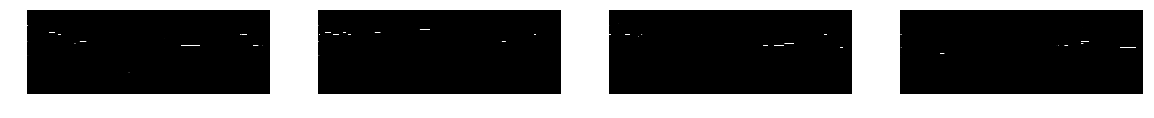

(4, 32, 32, 3)


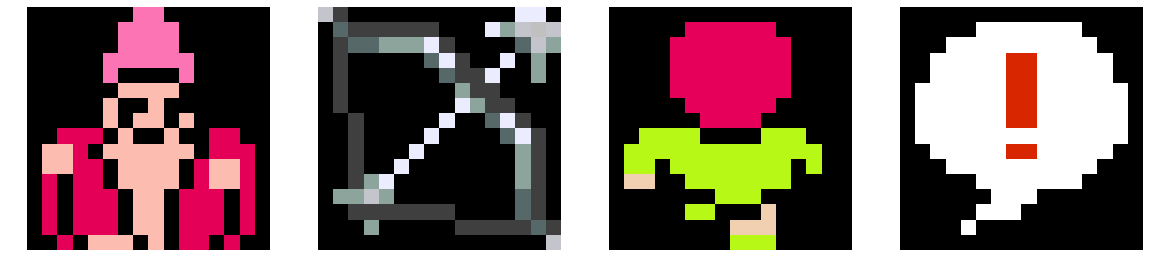

(4, 88, 256, 1)


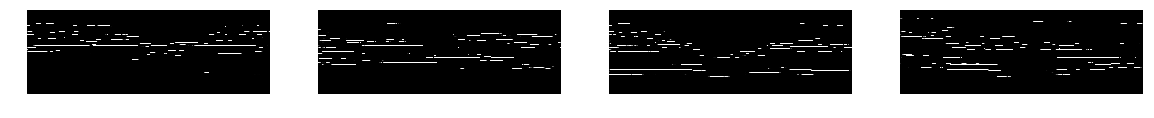

(4, 32, 32, 3)


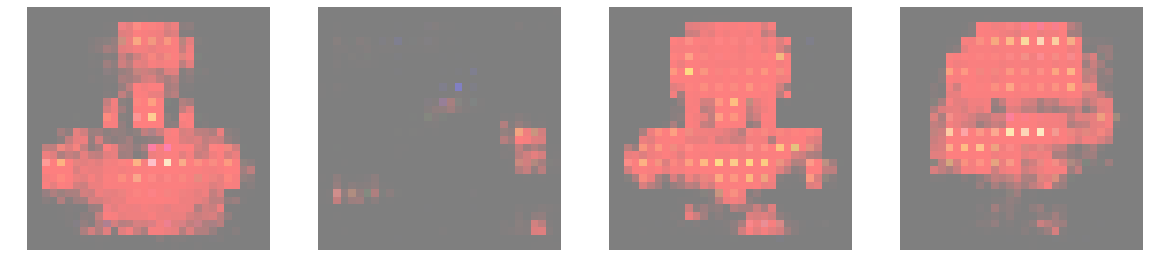

[75/110][26050] Loss_D: 0.034028 0.000668 Loss_G: 0.926058 1.002580 loss_cyc 0.798894 132.648
[75/110][26075] Loss_D: 0.038942 0.000753 Loss_G: 0.866883 0.999743 loss_cyc 0.836054 132.761
[75/110][26100] Loss_D: 0.021608 0.000500 Loss_G: 0.972681 0.999210 loss_cyc 0.822038 132.883
[75/110][26125] Loss_D: 0.038164 0.000786 Loss_G: 0.886586 1.001054 loss_cyc 0.830041 133.003
[75/110][26150] Loss_D: 0.036955 0.008038 Loss_G: 0.962382 1.004535 loss_cyc 0.814869 133.132
[75/110][26175] Loss_D: 0.035464 0.002722 Loss_G: 0.963533 0.998038 loss_cyc 0.813319 133.257
[75/110][26200] Loss_D: 0.044502 0.003425 Loss_G: 0.867389 1.009949 loss_cyc 0.825952 133.371
[75/110][26225] Loss_D: 0.031394 0.001004 Loss_G: 0.945746 0.997256 loss_cyc 0.793471 133.498
[75/110][26250] Loss_D: 0.029062 0.006198 Loss_G: 0.906620 1.006458 loss_cyc 0.829894 133.625
[75/110][26275] Loss_D: 0.041381 0.000933 Loss_G: 0.942884 1.000162 loss_cyc 0.818908 133.740
[75/110][26300] Loss_D: 0.030193 0.001054 Loss_G: 0.958575 1

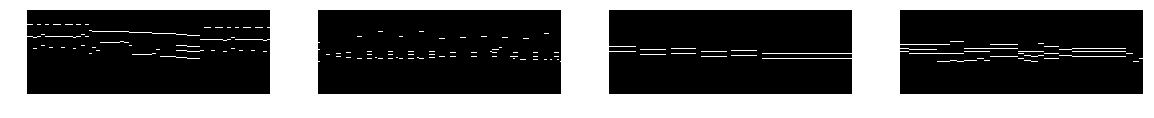

(4, 32, 32, 3)


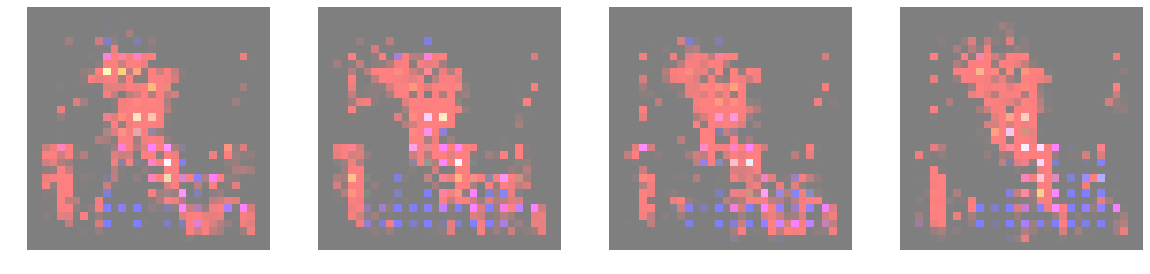

(4, 88, 256, 1)


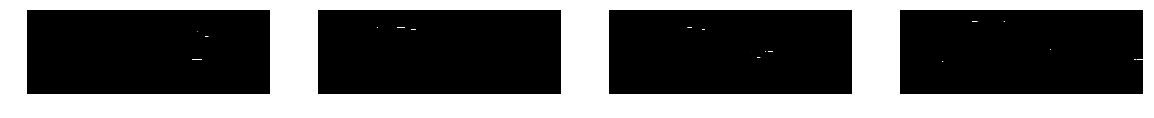

(4, 32, 32, 3)


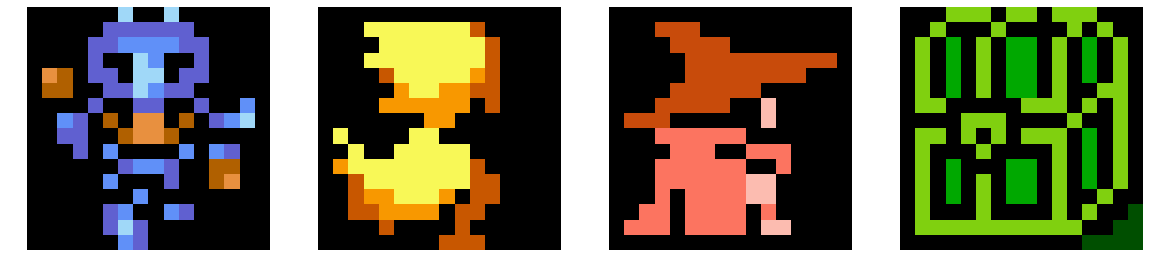

(4, 88, 256, 1)


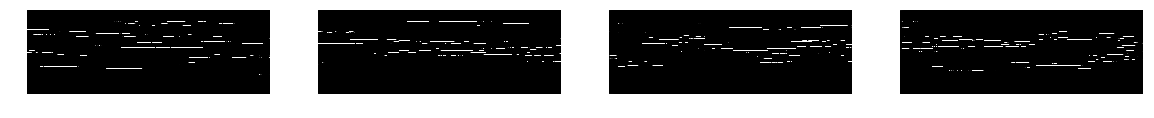

(4, 32, 32, 3)


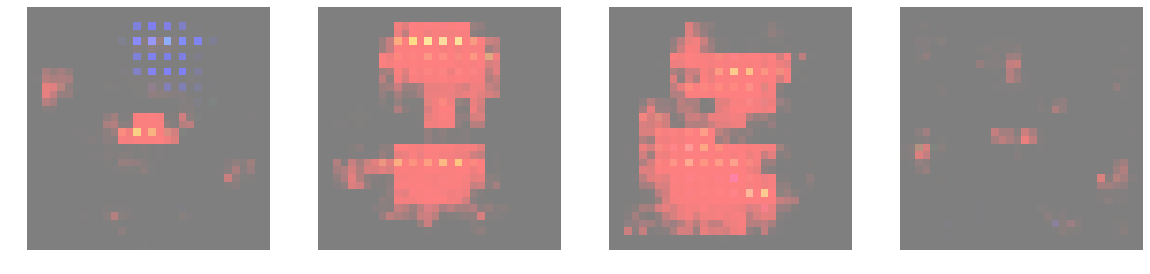

[76/110][26400] Loss_D: 0.031343 0.002753 Loss_G: 0.915534 1.003177 loss_cyc 0.818344 134.408
[76/110][26425] Loss_D: 0.031095 0.000940 Loss_G: 0.978455 1.000934 loss_cyc 0.805649 134.542
[76/110][26450] Loss_D: 0.030287 0.000606 Loss_G: 0.845153 0.998337 loss_cyc 0.802849 134.662
[76/110][26475] Loss_D: 0.042863 0.003230 Loss_G: 0.889126 1.002300 loss_cyc 0.823588 134.777
[76/110][26500] Loss_D: 0.039363 0.003262 Loss_G: 0.919745 1.005976 loss_cyc 0.822802 134.905
[76/110][26525] Loss_D: 0.032032 0.000490 Loss_G: 0.915218 0.998886 loss_cyc 0.835354 135.047
[76/110][26550] Loss_D: 0.026474 0.002287 Loss_G: 0.915031 1.004029 loss_cyc 0.804778 135.163
[76/110][26575] Loss_D: 0.031535 0.000508 Loss_G: 1.012485 1.001107 loss_cyc 0.775243 135.286
[76/110][26600] Loss_D: 0.029888 0.001138 Loss_G: 0.957699 0.999505 loss_cyc 0.819753 135.402
[76/110][26625] Loss_D: 0.028434 0.008950 Loss_G: 0.934071 1.005561 loss_cyc 0.825213 135.523
[76/110][26650] Loss_D: 0.018432 0.001022 Loss_G: 0.885737 0

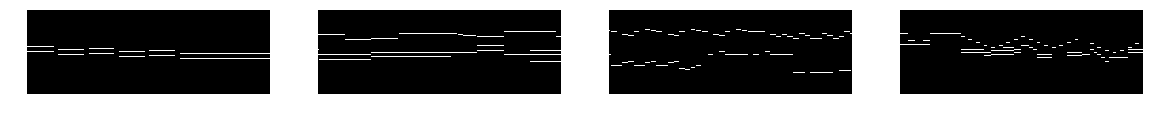

(4, 32, 32, 3)


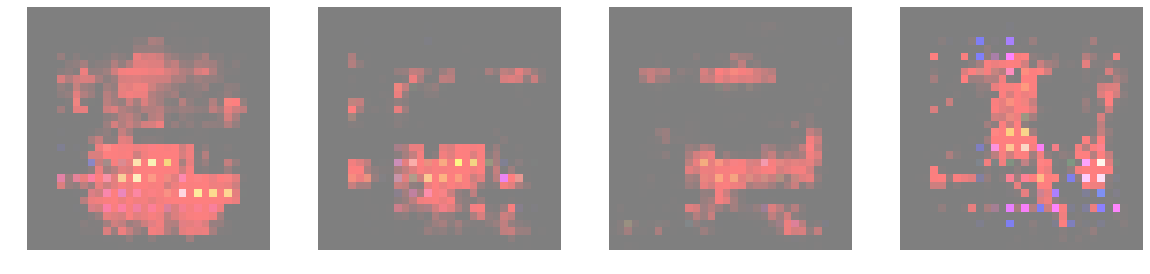

(4, 88, 256, 1)


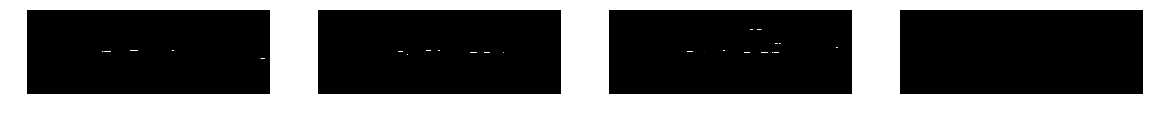

(4, 32, 32, 3)


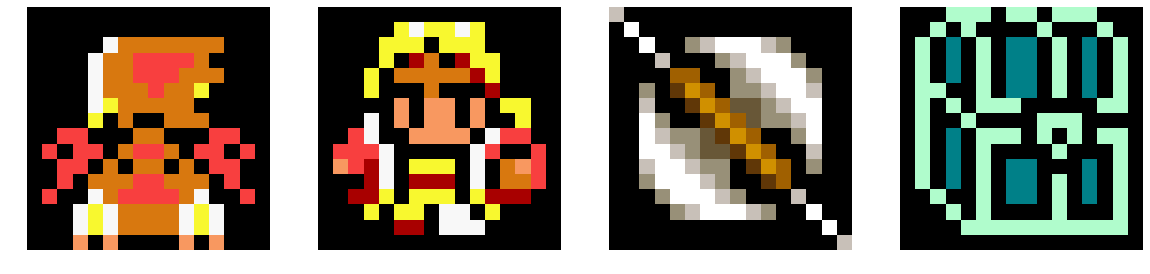

(4, 88, 256, 1)


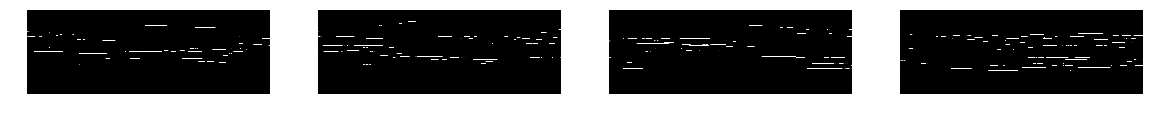

(4, 32, 32, 3)


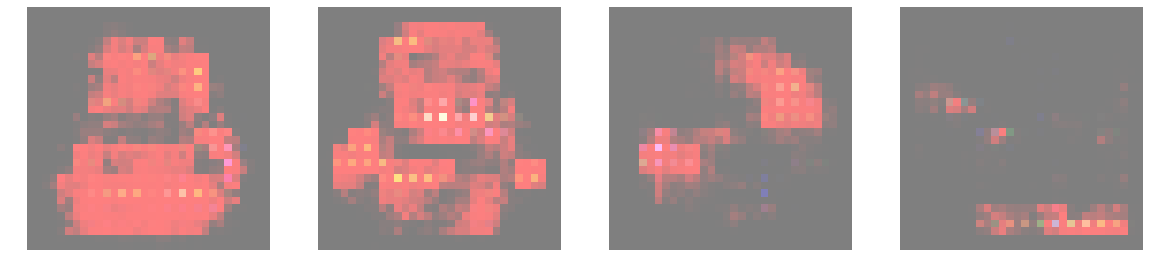

[77/110][26725] Loss_D: 0.033017 0.000563 Loss_G: 0.953174 0.997384 loss_cyc 0.835747 136.044
[77/110][26750] Loss_D: 0.031350 0.000942 Loss_G: 0.910679 0.996598 loss_cyc 0.831073 136.167
[77/110][26775] Loss_D: 0.032557 0.004085 Loss_G: 0.925942 1.006290 loss_cyc 0.810380 136.288
[77/110][26800] Loss_D: 0.024821 0.001092 Loss_G: 0.945868 1.005708 loss_cyc 0.808961 136.412
[77/110][26825] Loss_D: 0.035940 0.002450 Loss_G: 0.996380 0.998512 loss_cyc 0.822712 136.535
[77/110][26850] Loss_D: 0.030933 0.007260 Loss_G: 0.999652 1.007125 loss_cyc 0.834355 136.671
[77/110][26875] Loss_D: 0.038680 0.001093 Loss_G: 0.961173 0.998380 loss_cyc 0.812720 136.792
[77/110][26900] Loss_D: 0.041963 0.001576 Loss_G: 0.988877 1.001058 loss_cyc 0.819818 136.913
[77/110][26925] Loss_D: 0.040835 0.000513 Loss_G: 0.902199 1.001862 loss_cyc 0.826018 137.036
[77/110][26950] Loss_D: 0.039575 0.002135 Loss_G: 0.934842 1.001805 loss_cyc 0.836966 137.159
[77/110][26975] Loss_D: 0.029987 0.000661 Loss_G: 0.958745 1

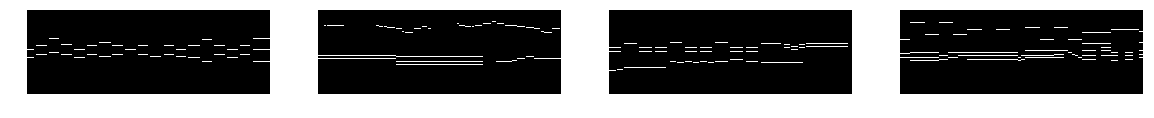

(4, 32, 32, 3)


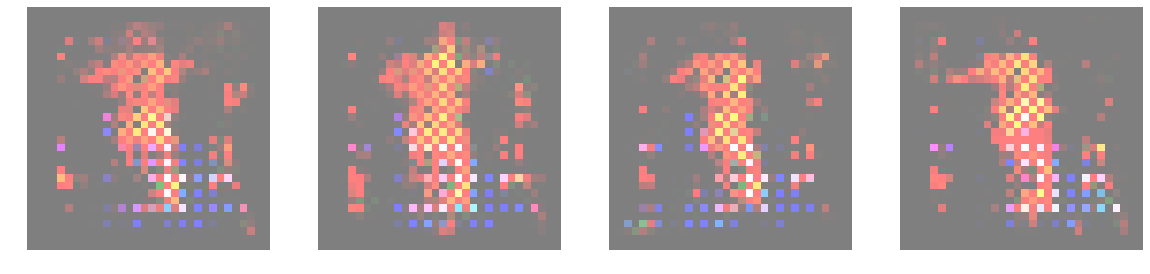

(4, 88, 256, 1)


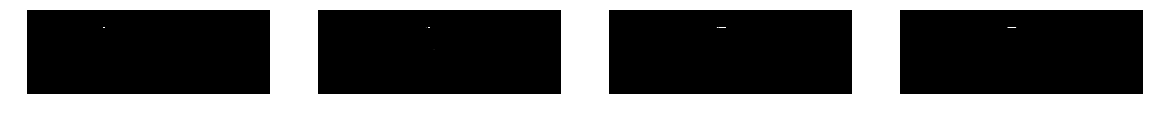

(4, 32, 32, 3)


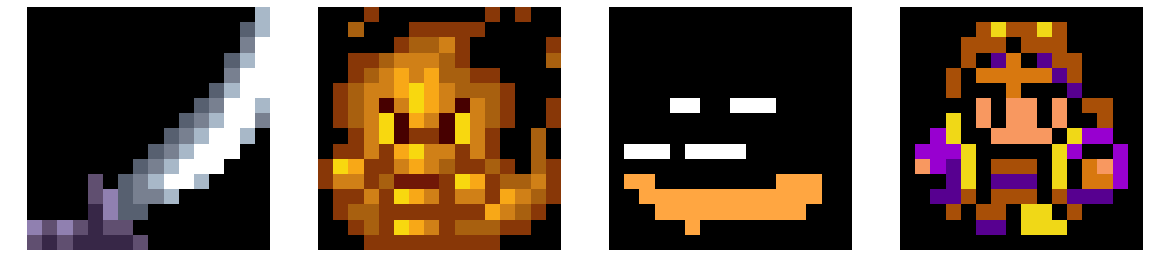

(4, 88, 256, 1)


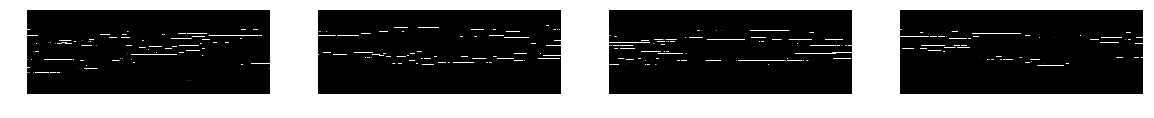

(4, 32, 32, 3)


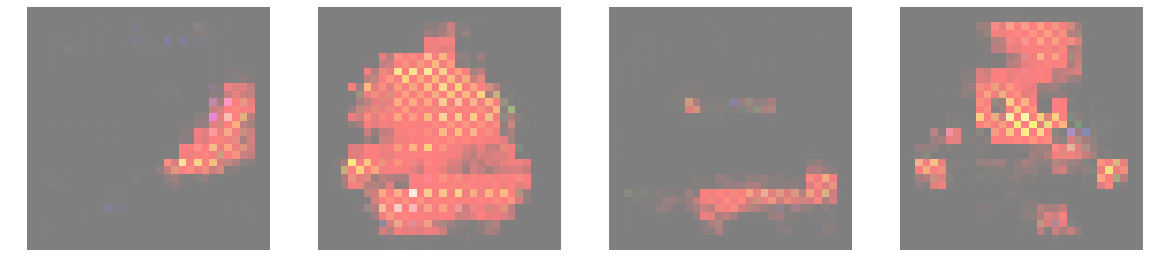

[78/110][27075] Loss_D: 0.036702 0.002119 Loss_G: 0.935199 0.999242 loss_cyc 0.814882 137.825
[78/110][27100] Loss_D: 0.041282 0.002815 Loss_G: 0.943619 1.004254 loss_cyc 0.808413 137.951
[78/110][27125] Loss_D: 0.021519 0.004038 Loss_G: 0.958886 1.002416 loss_cyc 0.817628 138.076
[78/110][27150] Loss_D: 0.020533 0.000609 Loss_G: 0.945182 1.002502 loss_cyc 0.793731 138.201
[78/110][27175] Loss_D: 0.025738 0.003497 Loss_G: 0.877151 1.005128 loss_cyc 0.808789 138.313
[78/110][27200] Loss_D: 0.018472 0.002433 Loss_G: 0.923912 0.998415 loss_cyc 0.827046 138.428
[78/110][27225] Loss_D: 0.028796 0.002425 Loss_G: 0.951506 0.998701 loss_cyc 0.835897 138.543
[78/110][27250] Loss_D: 0.025920 0.000812 Loss_G: 0.968250 1.002313 loss_cyc 0.826166 138.688
[78/110][27275] Loss_D: 0.025509 0.000509 Loss_G: 0.950783 1.001703 loss_cyc 0.827640 138.803
[78/110][27300] Loss_D: 0.030107 0.006207 Loss_G: 0.958590 1.002484 loss_cyc 0.816763 138.915
[78/110][27325] Loss_D: 0.029294 0.002057 Loss_G: 0.919359 1

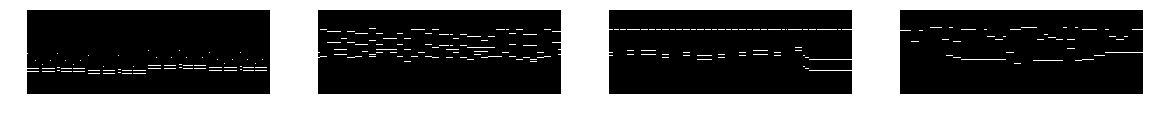

(4, 32, 32, 3)


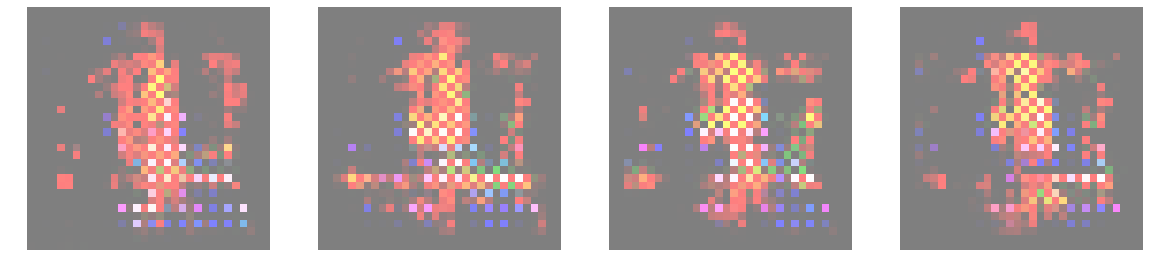

(4, 88, 256, 1)


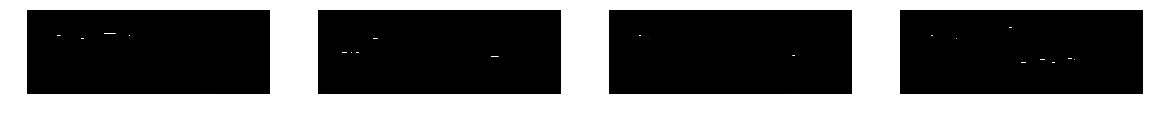

(4, 32, 32, 3)


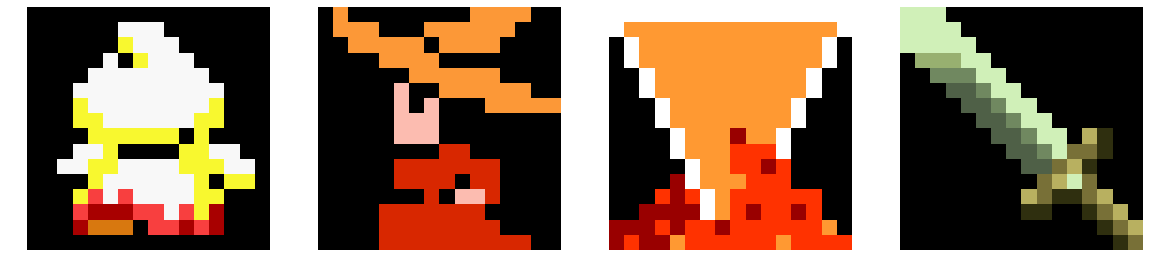

(4, 88, 256, 1)


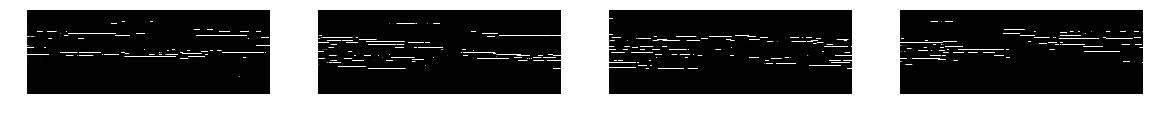

(4, 32, 32, 3)


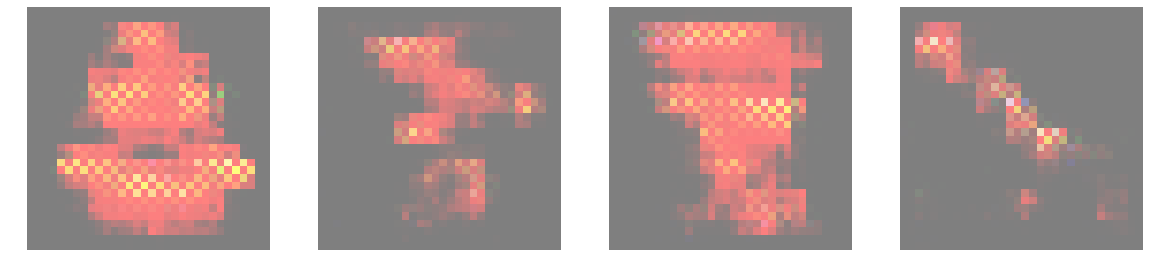

[79/110][27425] Loss_D: 0.044408 0.001014 Loss_G: 0.923893 0.999119 loss_cyc 0.820259 139.595
[79/110][27450] Loss_D: 0.026889 0.002499 Loss_G: 0.982911 1.004009 loss_cyc 0.820670 139.720
[79/110][27475] Loss_D: 0.024590 0.002273 Loss_G: 0.928913 1.002301 loss_cyc 0.798831 139.834
[79/110][27500] Loss_D: 0.026605 0.001246 Loss_G: 0.991120 1.002364 loss_cyc 0.825294 139.947
[79/110][27525] Loss_D: 0.040621 0.022205 Loss_G: 0.913348 1.012659 loss_cyc 0.783291 140.065
[79/110][27550] Loss_D: 0.035667 0.001324 Loss_G: 0.928616 1.003887 loss_cyc 0.819248 140.183
[79/110][27575] Loss_D: 0.023737 0.002035 Loss_G: 0.908187 1.000869 loss_cyc 0.806798 140.308
[79/110][27600] Loss_D: 0.042196 0.001118 Loss_G: 0.888728 1.001410 loss_cyc 0.810785 140.444
[79/110][27625] Loss_D: 0.039267 0.000766 Loss_G: 0.924369 0.999804 loss_cyc 0.827246 140.562
[79/110][27650] Loss_D: 0.035973 0.000826 Loss_G: 0.930387 1.000386 loss_cyc 0.825526 140.684
[79/110][27675] Loss_D: 0.028466 0.000215 Loss_G: 0.928911 1

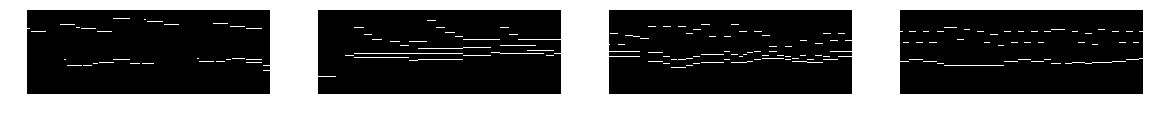

(4, 32, 32, 3)


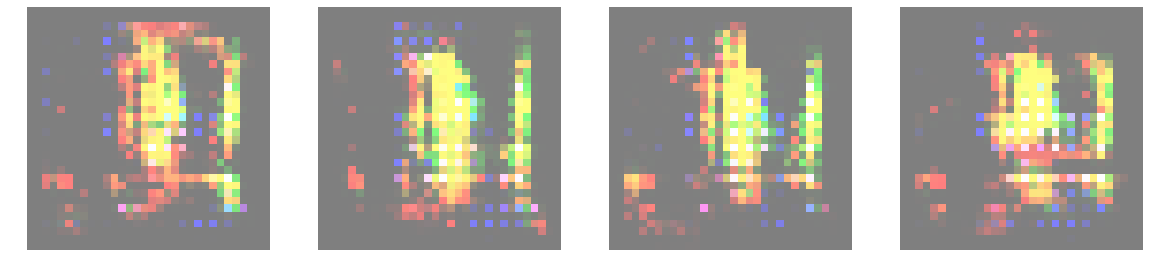

(4, 88, 256, 1)


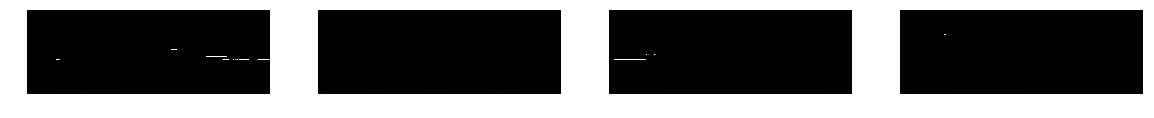

(4, 32, 32, 3)


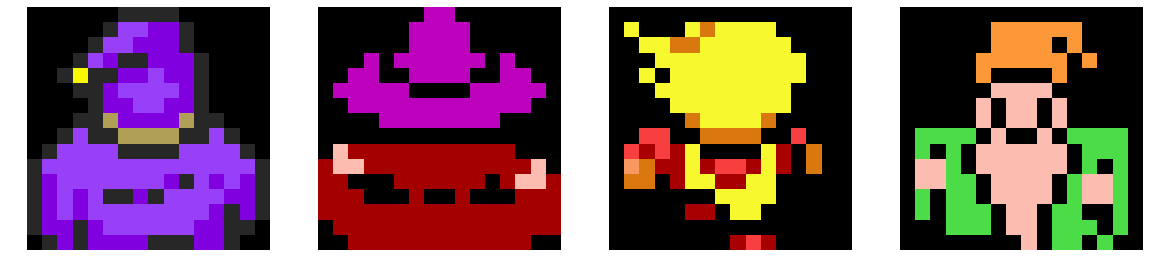

(4, 88, 256, 1)


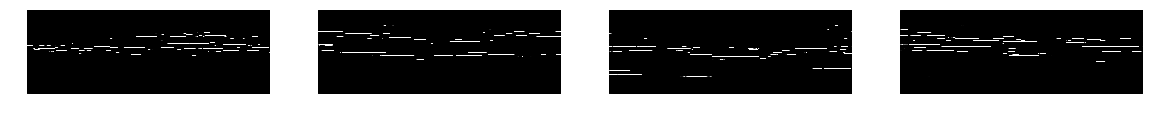

(4, 32, 32, 3)


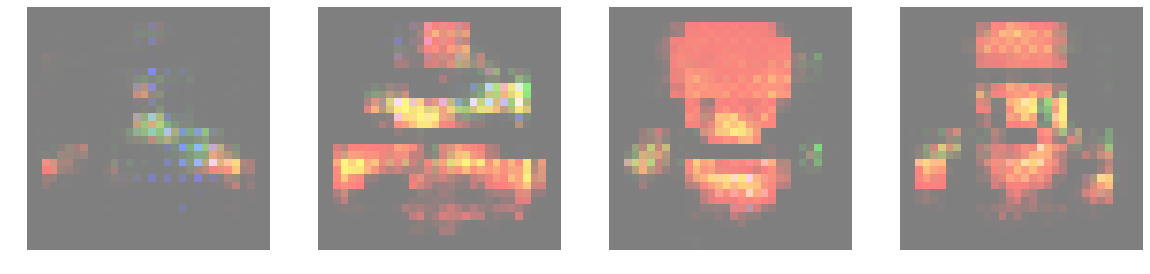

[80/110][27775] Loss_D: 0.027050 0.006503 Loss_G: 0.930775 1.008173 loss_cyc 0.796791 141.356
[80/110][27800] Loss_D: 0.029271 0.000616 Loss_G: 0.930264 0.999858 loss_cyc 0.792431 141.476
[80/110][27825] Loss_D: 0.024814 0.000622 Loss_G: 0.895698 0.997260 loss_cyc 0.804096 141.589
[80/110][27850] Loss_D: 0.032328 0.001224 Loss_G: 0.915145 1.000078 loss_cyc 0.836071 141.725
[80/110][27875] Loss_D: 0.021721 0.002766 Loss_G: 0.945905 1.007242 loss_cyc 0.824331 141.846
[80/110][27900] Loss_D: 0.046018 0.000926 Loss_G: 0.883418 1.001124 loss_cyc 0.816213 141.963
[80/110][27925] Loss_D: 0.035654 0.002898 Loss_G: 0.911411 1.001726 loss_cyc 0.801618 142.083
[80/110][27950] Loss_D: 0.035915 0.002185 Loss_G: 0.915565 1.001526 loss_cyc 0.824104 142.195
[80/110][27975] Loss_D: 0.022565 0.001684 Loss_G: 0.943237 1.001556 loss_cyc 0.791467 142.326
[80/110][28000] Loss_D: 0.023732 0.002505 Loss_G: 0.968783 1.001752 loss_cyc 0.808747 142.450
[80/110][28025] Loss_D: 0.036064 0.001457 Loss_G: 0.922855 0

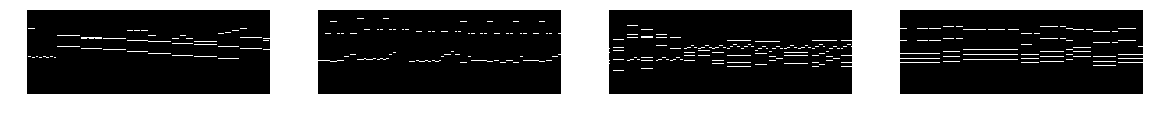

(4, 32, 32, 3)


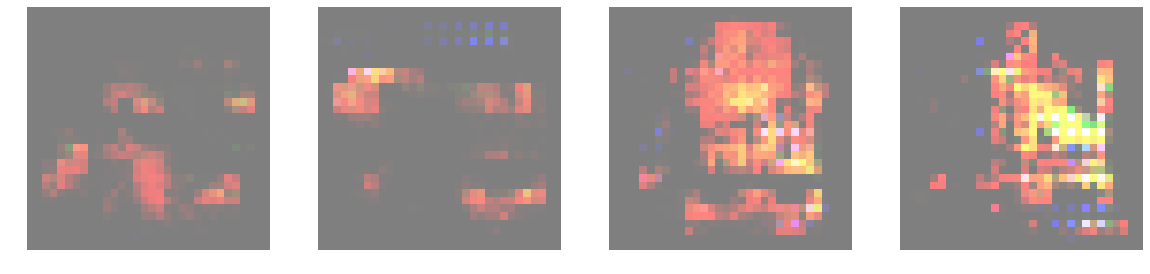

(4, 88, 256, 1)


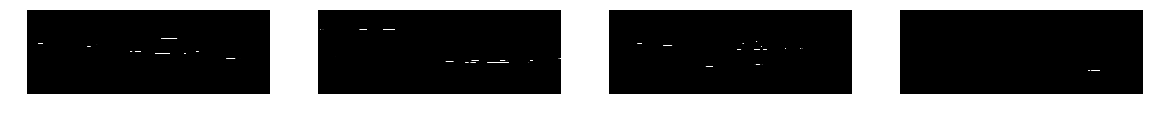

(4, 32, 32, 3)


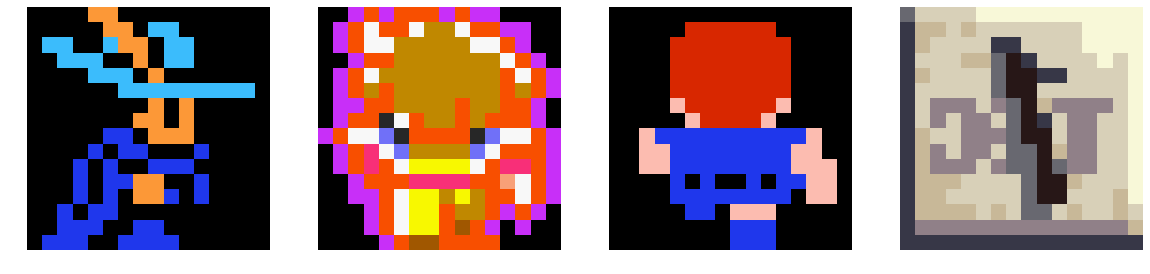

(4, 88, 256, 1)


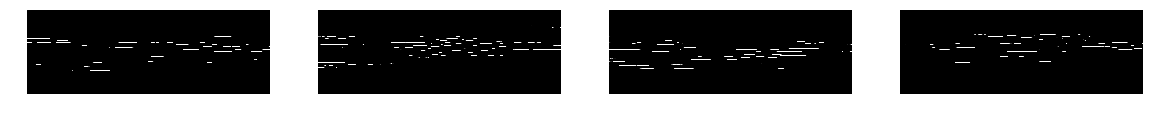

(4, 32, 32, 3)


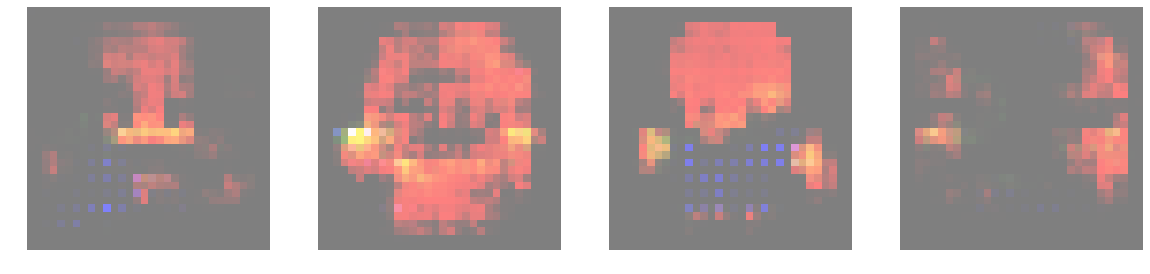

[81/110][28125] Loss_D: 0.035561 0.002459 Loss_G: 0.918148 1.002125 loss_cyc 0.814220 143.126
[81/110][28150] Loss_D: 0.022693 0.001624 Loss_G: 0.956720 1.006382 loss_cyc 0.836230 143.241
[81/110][28175] Loss_D: 0.030825 0.001500 Loss_G: 0.915680 0.997711 loss_cyc 0.796284 143.358
[81/110][28200] Loss_D: 0.024883 0.000471 Loss_G: 1.004703 0.998239 loss_cyc 0.816638 143.487
[81/110][28225] Loss_D: 0.027304 0.000845 Loss_G: 0.960455 1.003776 loss_cyc 0.837136 143.606
[81/110][28250] Loss_D: 0.032377 0.001823 Loss_G: 0.991196 1.001085 loss_cyc 0.833752 143.726
[81/110][28275] Loss_D: 0.029226 0.002865 Loss_G: 0.924131 1.004162 loss_cyc 0.811779 143.844
[81/110][28300] Loss_D: 0.028793 0.003817 Loss_G: 0.998108 1.005944 loss_cyc 0.831613 143.964
[81/110][28325] Loss_D: 0.040557 0.003036 Loss_G: 0.907580 0.996836 loss_cyc 0.821180 144.099
[81/110][28350] Loss_D: 0.030364 0.002048 Loss_G: 0.909826 1.000597 loss_cyc 0.820408 144.230
[81/110][28375] Loss_D: 0.027033 0.002123 Loss_G: 1.015383 1

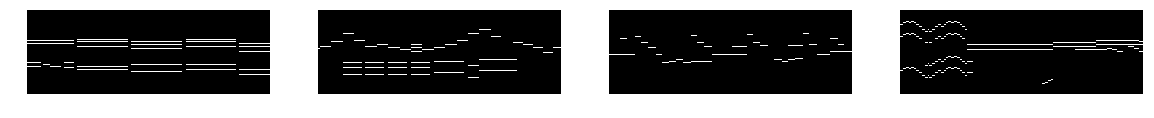

(4, 32, 32, 3)


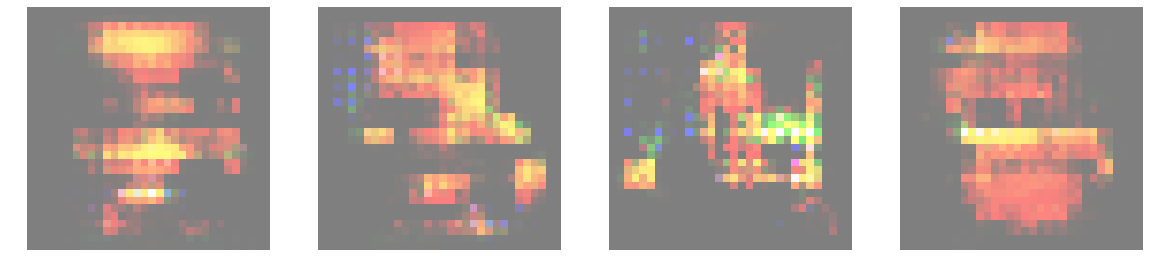

(4, 88, 256, 1)


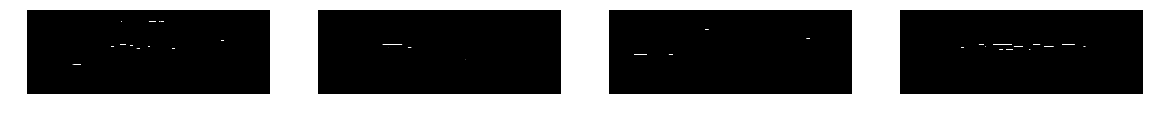

(4, 32, 32, 3)


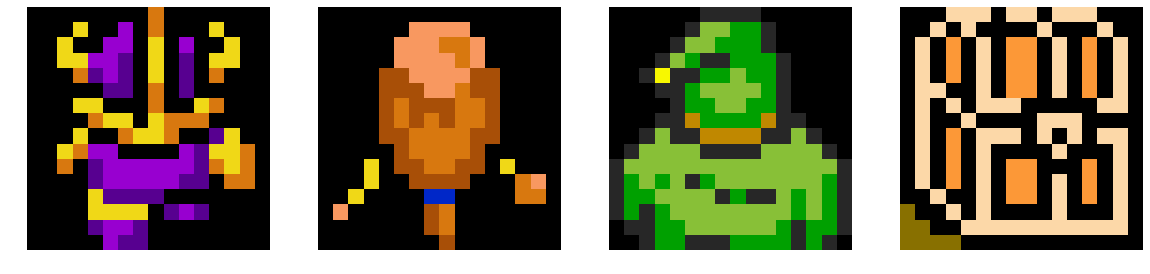

(4, 88, 256, 1)


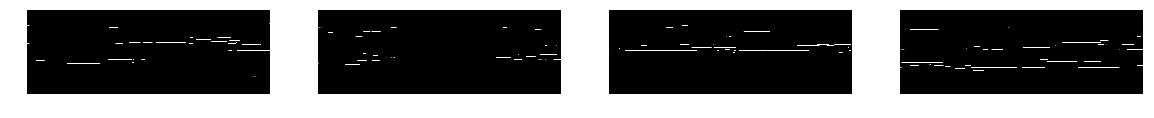

(4, 32, 32, 3)


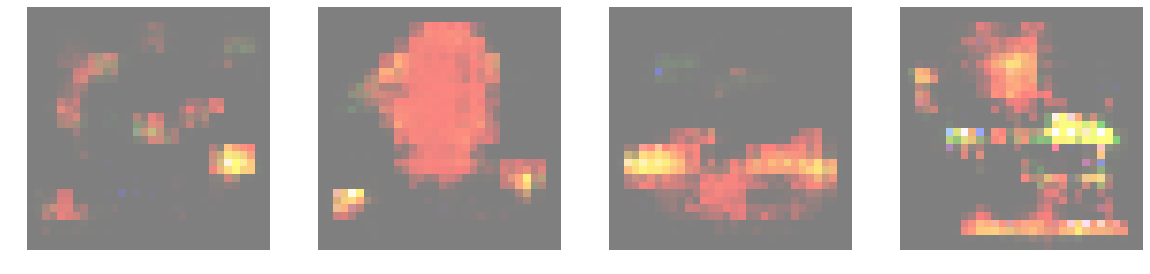

[82/110][28475] Loss_D: 0.028922 0.001615 Loss_G: 0.942178 1.006912 loss_cyc 0.821743 144.891
[82/110][28500] Loss_D: 0.019997 0.003549 Loss_G: 0.950466 1.000301 loss_cyc 0.787970 145.009
[82/110][28525] Loss_D: 0.027189 0.002815 Loss_G: 0.923377 0.997398 loss_cyc 0.801488 145.121
[82/110][28550] Loss_D: 0.022081 0.003572 Loss_G: 0.975844 1.007075 loss_cyc 0.830623 145.245
[82/110][28575] Loss_D: 0.020204 0.001595 Loss_G: 0.958096 1.002049 loss_cyc 0.809072 145.362
[82/110][28600] Loss_D: 0.028536 0.000470 Loss_G: 0.984054 0.999357 loss_cyc 0.804692 145.488
[82/110][28625] Loss_D: 0.032831 0.000678 Loss_G: 0.978940 1.003105 loss_cyc 0.797492 145.618
[82/110][28650] Loss_D: 0.025713 0.004045 Loss_G: 0.932814 0.996534 loss_cyc 0.827299 145.740
[82/110][28675] Loss_D: 0.019463 0.001915 Loss_G: 0.917338 1.005848 loss_cyc 0.817690 145.864
[82/110][28700] Loss_D: 0.023499 0.002346 Loss_G: 0.894492 1.001533 loss_cyc 0.798718 145.992
[82/110][28725] Loss_D: 0.019568 0.002521 Loss_G: 0.944927 1

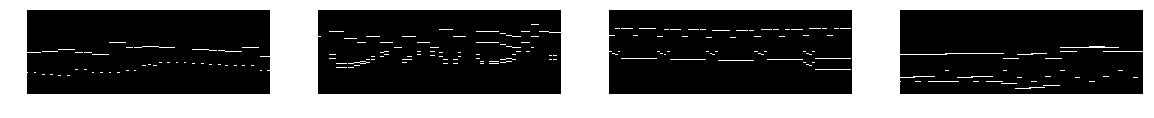

(4, 32, 32, 3)


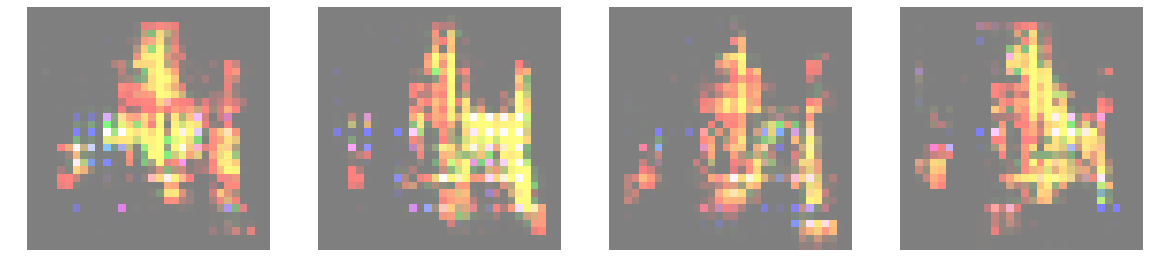

(4, 88, 256, 1)


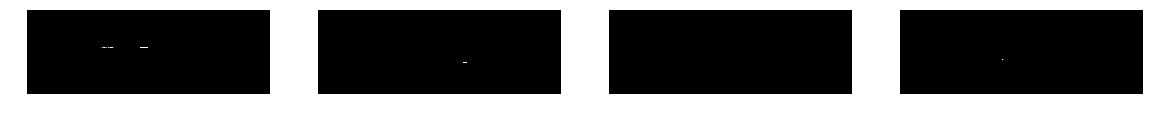

(4, 32, 32, 3)


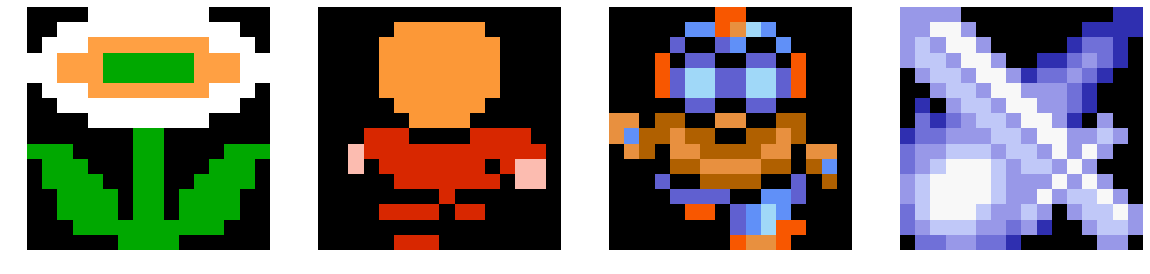

(4, 88, 256, 1)


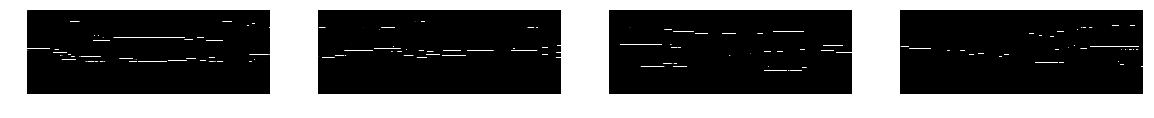

(4, 32, 32, 3)


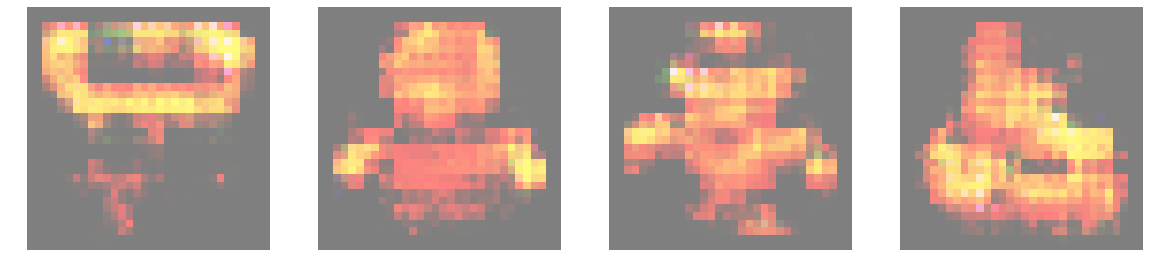

[83/110][28825] Loss_D: 0.034539 0.005766 Loss_G: 0.872698 1.009313 loss_cyc 0.828295 146.652
[83/110][28850] Loss_D: 0.025479 0.001758 Loss_G: 0.960718 0.994453 loss_cyc 0.798048 146.773
[83/110][28875] Loss_D: 0.033603 0.001457 Loss_G: 0.919260 1.001945 loss_cyc 0.813098 146.890
[83/110][28900] Loss_D: 0.037526 0.001130 Loss_G: 0.914328 1.003721 loss_cyc 0.820722 147.010
[83/110][28925] Loss_D: 0.023856 0.002073 Loss_G: 0.854126 0.999983 loss_cyc 0.828587 147.132
[83/110][28950] Loss_D: 0.026115 0.000610 Loss_G: 0.982205 1.000381 loss_cyc 0.831138 147.267
[83/110][28975] Loss_D: 0.023730 0.001620 Loss_G: 0.993004 1.004348 loss_cyc 0.821494 147.378
[83/110][29000] Loss_D: 0.028108 0.000971 Loss_G: 0.943245 0.997385 loss_cyc 0.804132 147.503
[83/110][29025] Loss_D: 0.031165 0.001283 Loss_G: 0.929428 1.003073 loss_cyc 0.819974 147.626
[83/110][29050] Loss_D: 0.030817 0.002230 Loss_G: 0.954008 0.996939 loss_cyc 0.819595 147.749
[83/110][29075] Loss_D: 0.037216 0.001212 Loss_G: 0.938379 1

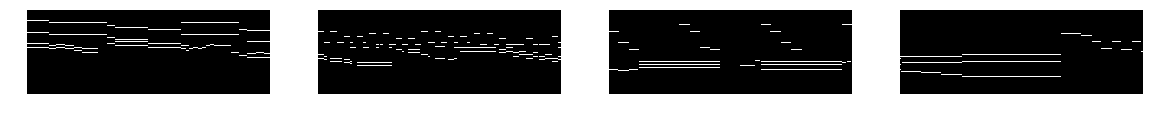

(4, 32, 32, 3)


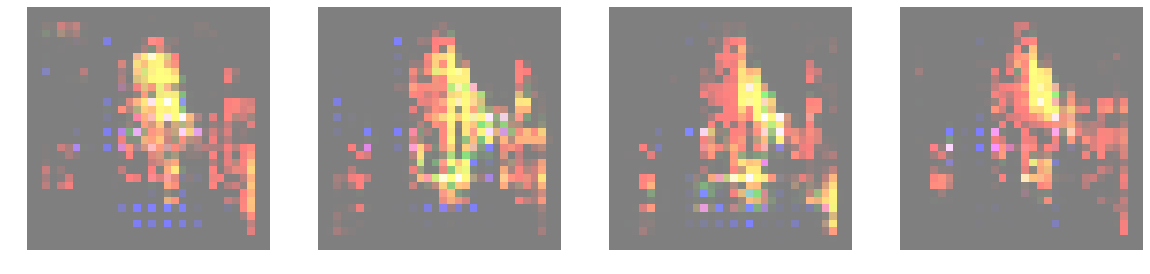

(4, 88, 256, 1)


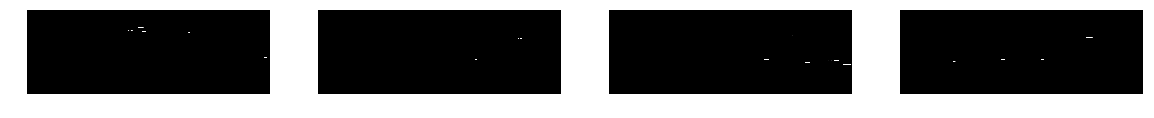

(4, 32, 32, 3)


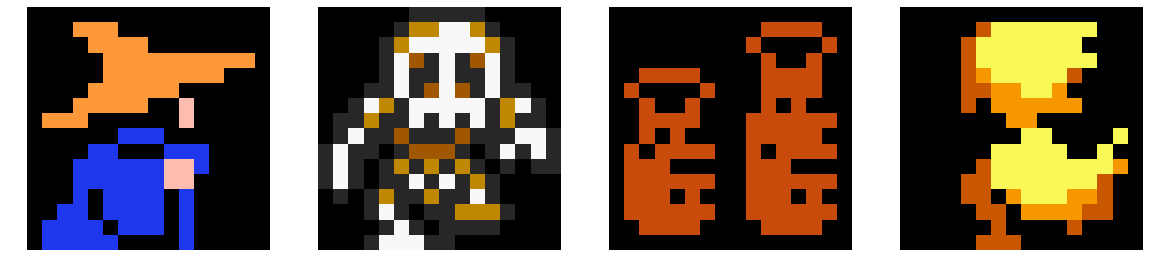

(4, 88, 256, 1)


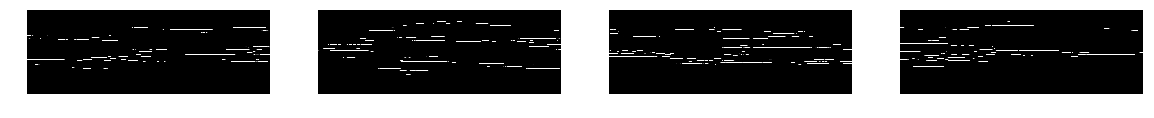

(4, 32, 32, 3)


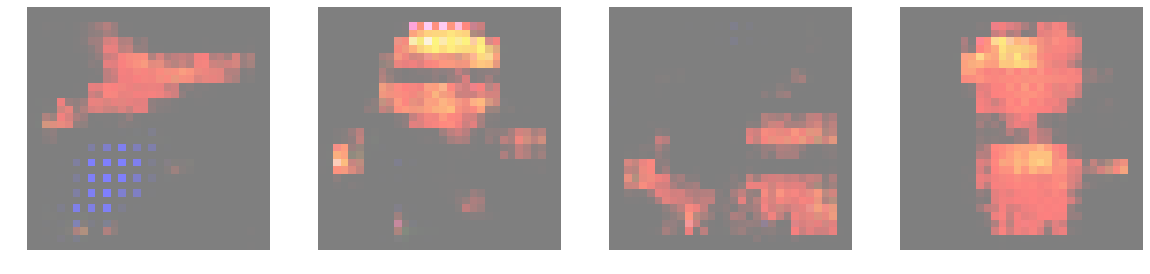

[84/110][29175] Loss_D: 0.028918 0.001023 Loss_G: 0.921491 1.003296 loss_cyc 0.814354 148.426
[84/110][29200] Loss_D: 0.044532 0.009986 Loss_G: 0.893572 1.008938 loss_cyc 0.798280 148.543
[84/110][29225] Loss_D: 0.027894 0.000916 Loss_G: 0.960148 0.999370 loss_cyc 0.807196 148.674
[84/110][29250] Loss_D: 0.025149 0.001346 Loss_G: 0.974018 1.001536 loss_cyc 0.807384 148.795
[84/110][29275] Loss_D: 0.031084 0.000764 Loss_G: 0.988501 0.997383 loss_cyc 0.847612 148.916
[84/110][29300] Loss_D: 0.025295 0.000416 Loss_G: 0.966322 1.000381 loss_cyc 0.830126 149.040
[84/110][29325] Loss_D: 0.035149 0.001027 Loss_G: 0.892024 0.998463 loss_cyc 0.791323 149.162
[84/110][29350] Loss_D: 0.026571 0.001094 Loss_G: 0.935214 1.003862 loss_cyc 0.811458 149.284
[84/110][29375] Loss_D: 0.024667 0.000263 Loss_G: 0.963258 1.000199 loss_cyc 0.817979 149.412
[84/110][29400] Loss_D: 0.023482 0.003212 Loss_G: 0.926142 0.999501 loss_cyc 0.818498 149.532
[84/110][29425] Loss_D: 0.032969 0.001836 Loss_G: 1.001480 1

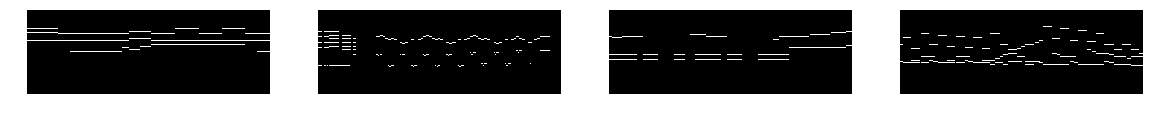

(4, 32, 32, 3)


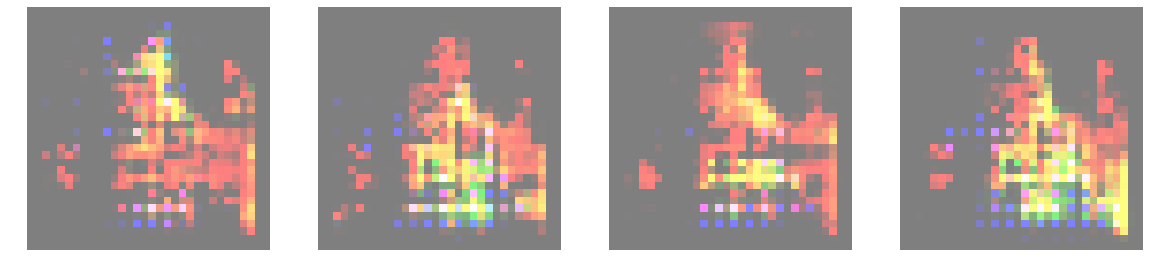

(4, 88, 256, 1)


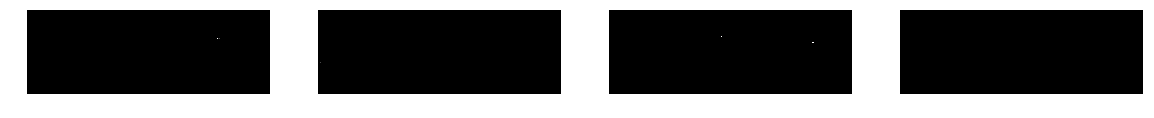

(4, 32, 32, 3)


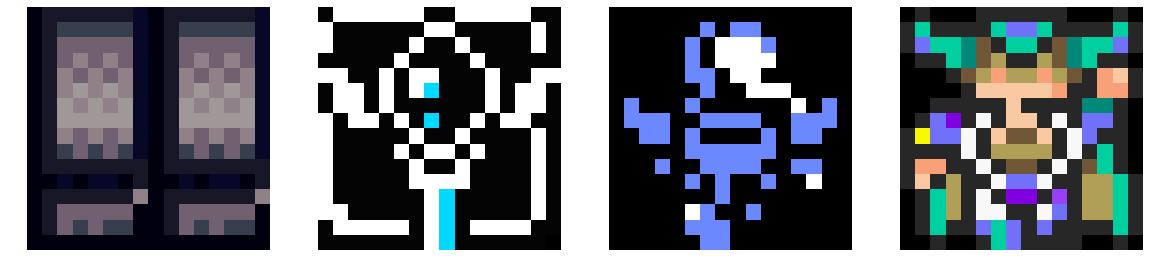

(4, 88, 256, 1)


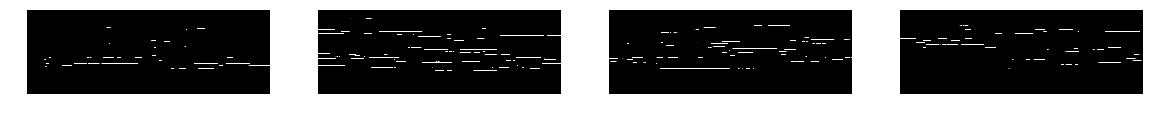

(4, 32, 32, 3)


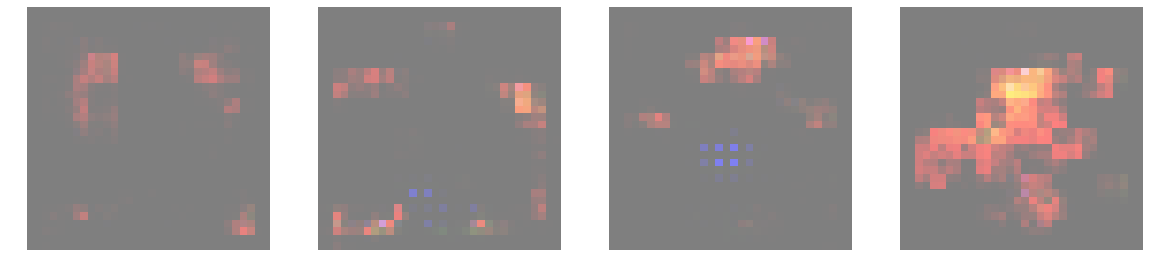

[85/110][29500] Loss_D: 0.028433 0.002523 Loss_G: 0.932655 1.006726 loss_cyc 0.820488 150.070
[85/110][29525] Loss_D: 0.028833 0.000460 Loss_G: 0.884742 1.002553 loss_cyc 0.811397 150.186
[85/110][29550] Loss_D: 0.027953 0.000694 Loss_G: 0.961188 1.000447 loss_cyc 0.825325 150.314
[85/110][29575] Loss_D: 0.028587 0.001455 Loss_G: 0.877105 1.000853 loss_cyc 0.816380 150.439
[85/110][29600] Loss_D: 0.020736 0.000429 Loss_G: 0.988500 1.000640 loss_cyc 0.793914 150.565
[85/110][29625] Loss_D: 0.026754 0.001283 Loss_G: 0.953989 0.997825 loss_cyc 0.779904 150.683
[85/110][29650] Loss_D: 0.021296 0.002061 Loss_G: 0.965867 1.003681 loss_cyc 0.802892 150.804
[85/110][29675] Loss_D: 0.023054 0.000268 Loss_G: 0.968990 1.001520 loss_cyc 0.822626 150.927
[85/110][29700] Loss_D: 0.028577 0.000305 Loss_G: 0.979563 1.000940 loss_cyc 0.776855 151.052
[85/110][29725] Loss_D: 0.027136 0.001133 Loss_G: 0.888925 1.000134 loss_cyc 0.812237 151.172
[85/110][29750] Loss_D: 0.030542 0.000108 Loss_G: 0.972948 0

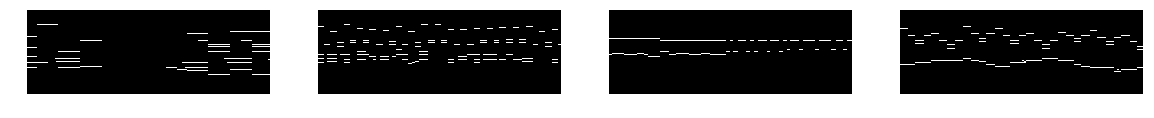

(4, 32, 32, 3)


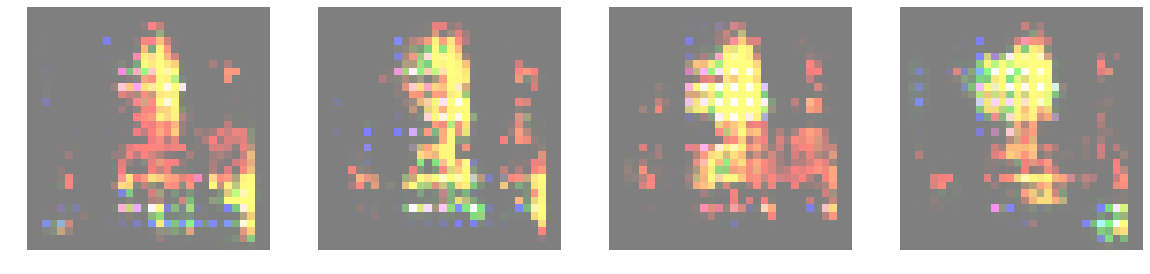

(4, 88, 256, 1)


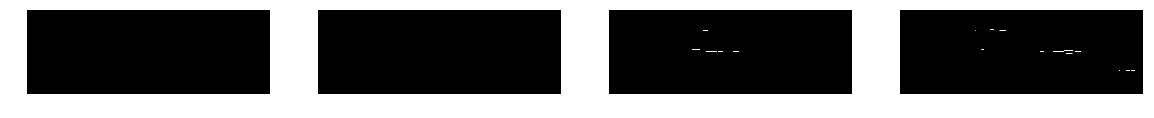

(4, 32, 32, 3)


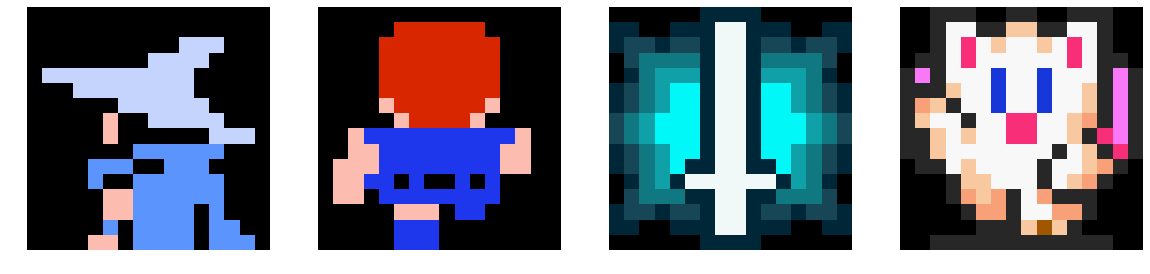

(4, 88, 256, 1)


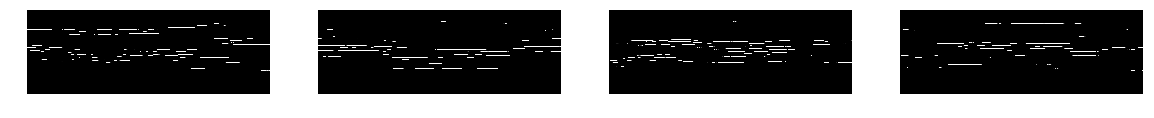

(4, 32, 32, 3)


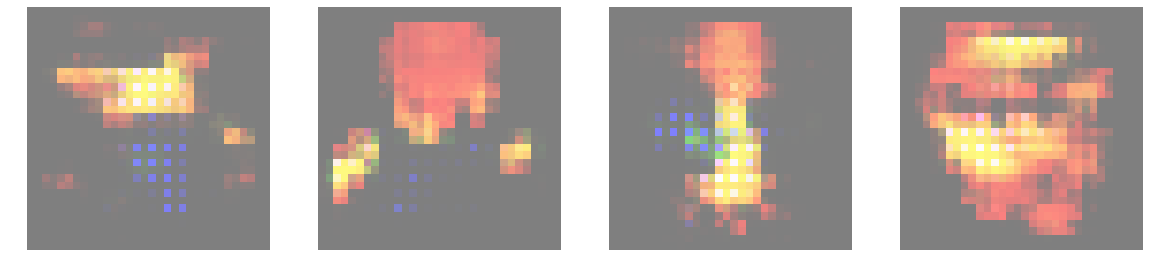

[86/110][29850] Loss_D: 0.021645 0.002116 Loss_G: 0.916845 0.999834 loss_cyc 0.817827 151.837
[86/110][29875] Loss_D: 0.022267 0.000871 Loss_G: 0.915995 1.003174 loss_cyc 0.824415 151.952
[86/110][29900] Loss_D: 0.022430 0.000597 Loss_G: 0.933815 1.000449 loss_cyc 0.829887 152.078
[86/110][29925] Loss_D: 0.024907 0.000467 Loss_G: 0.927847 0.999243 loss_cyc 0.804793 152.205
[86/110][29950] Loss_D: 0.032204 0.002649 Loss_G: 0.998950 0.999623 loss_cyc 0.815881 152.328
[86/110][29975] Loss_D: 0.041453 0.001588 Loss_G: 0.966257 1.002615 loss_cyc 0.824465 152.446
[86/110][30000] Loss_D: 0.020260 0.005184 Loss_G: 0.978561 1.006156 loss_cyc 0.825458 152.565
[86/110][30025] Loss_D: 0.022441 0.000524 Loss_G: 0.855061 0.997916 loss_cyc 0.813988 152.690
[86/110][30050] Loss_D: 0.016478 0.002159 Loss_G: 0.978227 0.999669 loss_cyc 0.814415 152.807
[86/110][30075] Loss_D: 0.025209 0.000973 Loss_G: 0.996685 1.004280 loss_cyc 0.790796 152.933
[86/110][30100] Loss_D: 0.023979 0.000406 Loss_G: 0.934923 1

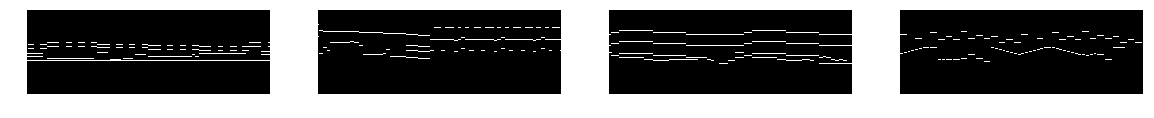

(4, 32, 32, 3)


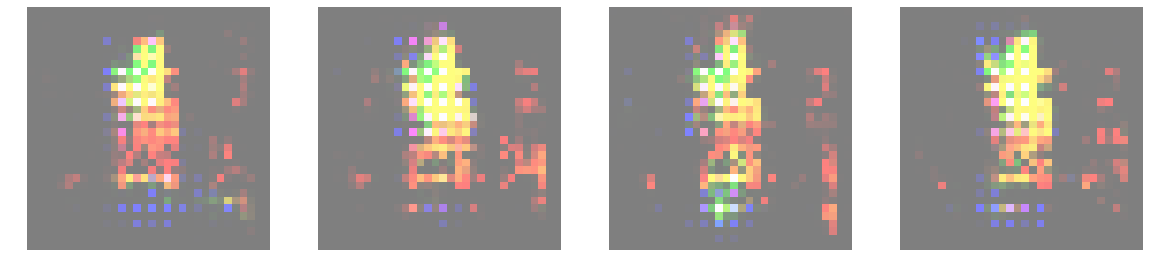

(4, 88, 256, 1)


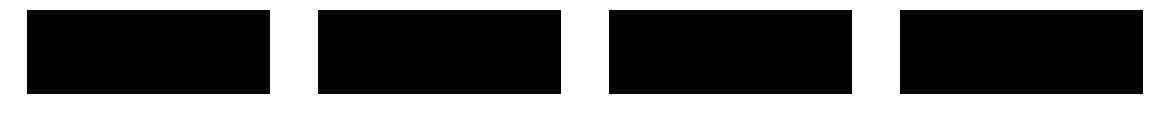

(4, 32, 32, 3)


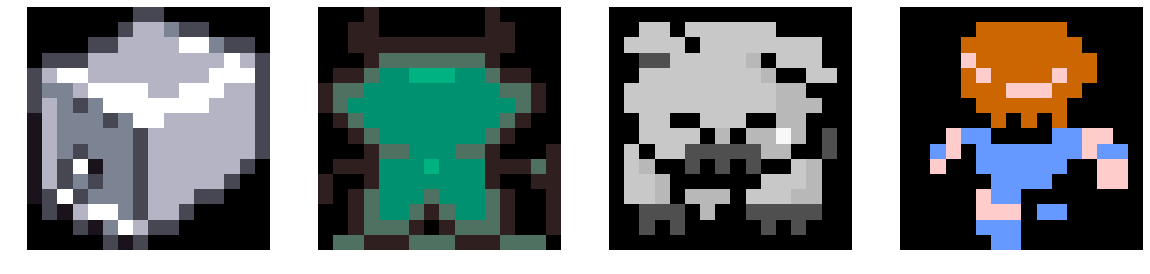

(4, 88, 256, 1)


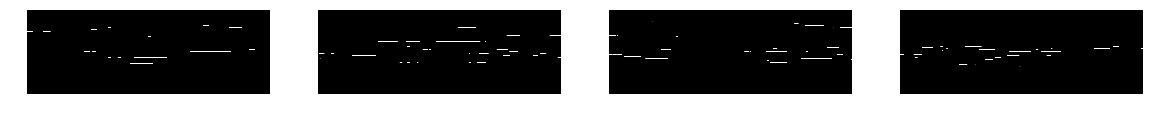

(4, 32, 32, 3)


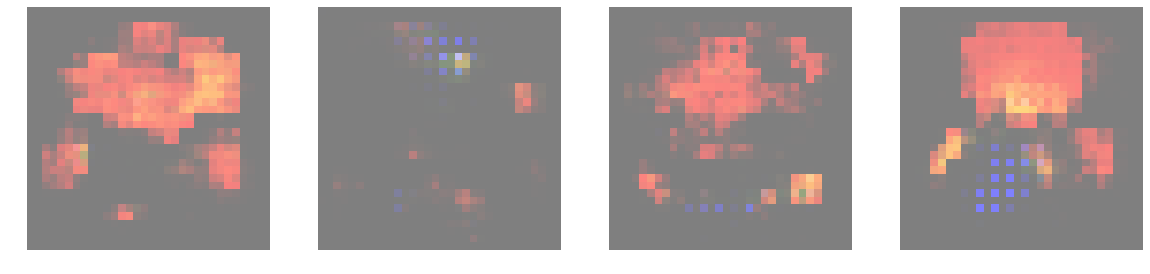

[87/110][30200] Loss_D: 0.018822 0.000853 Loss_G: 0.936859 1.000416 loss_cyc 0.811126 153.600
[87/110][30225] Loss_D: 0.023075 0.002012 Loss_G: 0.940035 1.003387 loss_cyc 0.814525 153.728
[87/110][30250] Loss_D: 0.031088 0.003315 Loss_G: 0.892178 1.003902 loss_cyc 0.803864 153.838
[87/110][30275] Loss_D: 0.036845 0.001708 Loss_G: 0.883774 0.997008 loss_cyc 0.800345 153.952
[87/110][30300] Loss_D: 0.034530 0.002102 Loss_G: 0.962037 1.001934 loss_cyc 0.826503 154.070
[87/110][30325] Loss_D: 0.016785 0.002853 Loss_G: 0.979124 1.004763 loss_cyc 0.816844 154.190
[87/110][30350] Loss_D: 0.028426 0.000664 Loss_G: 0.942008 0.999479 loss_cyc 0.799119 154.319
[87/110][30375] Loss_D: 0.025218 0.001542 Loss_G: 0.875147 1.004182 loss_cyc 0.822188 154.462
[87/110][30400] Loss_D: 0.034752 0.000678 Loss_G: 0.951783 0.995738 loss_cyc 0.818566 154.584
[87/110][30425] Loss_D: 0.030946 0.001389 Loss_G: 0.925677 1.005364 loss_cyc 0.812983 154.706
[87/110][30450] Loss_D: 0.026465 0.002130 Loss_G: 0.931150 1

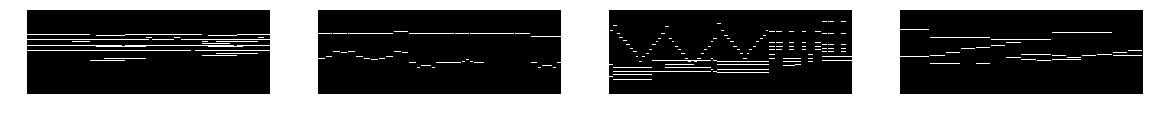

(4, 32, 32, 3)


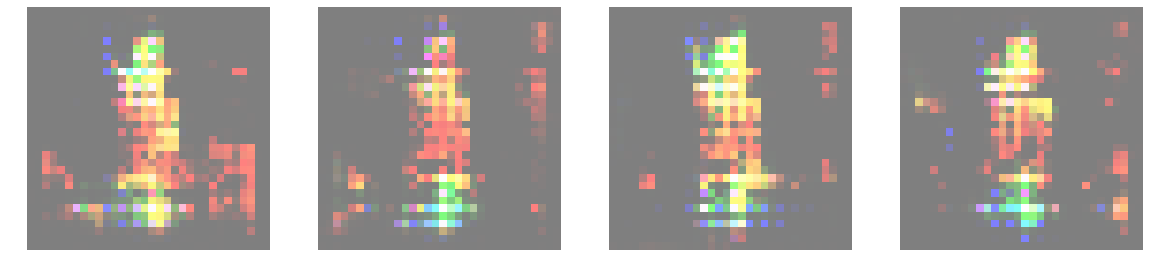

(4, 88, 256, 1)


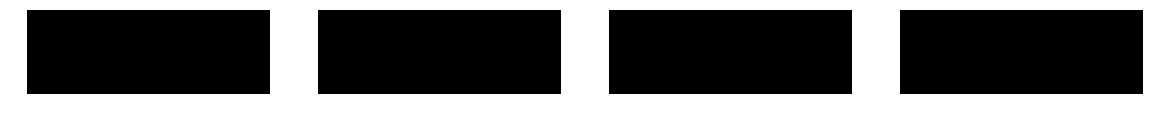

(4, 32, 32, 3)


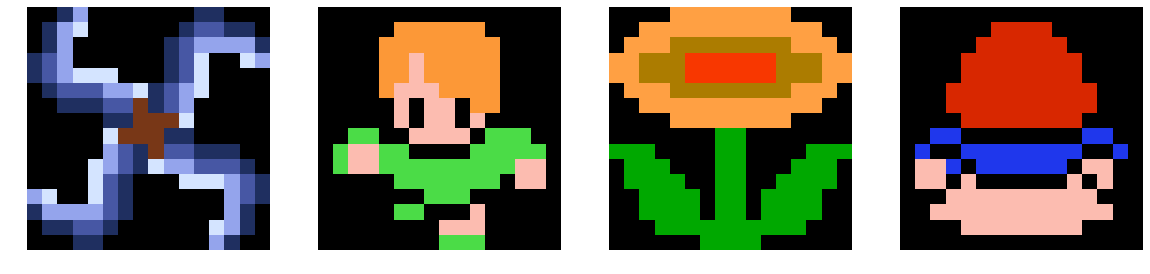

(4, 88, 256, 1)


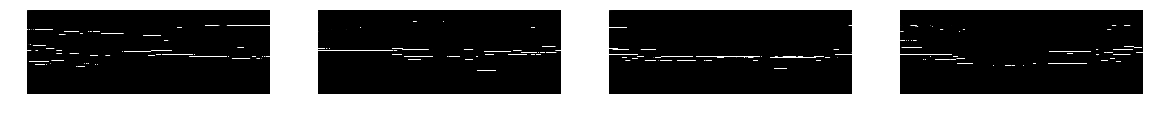

(4, 32, 32, 3)


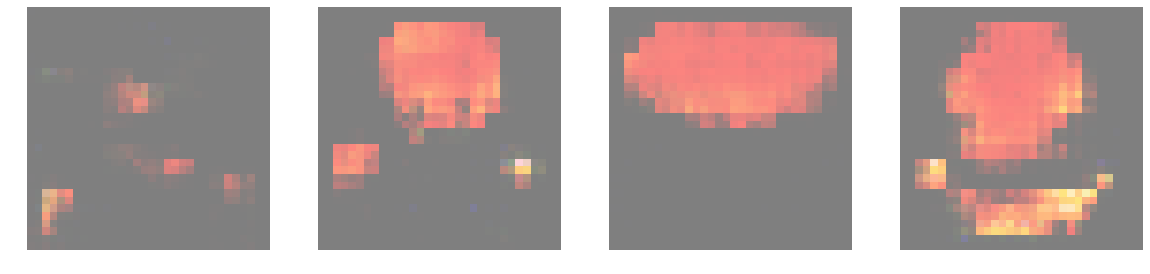

[88/110][30550] Loss_D: 0.023397 0.001060 Loss_G: 0.987400 0.998007 loss_cyc 0.794251 155.376
[88/110][30575] Loss_D: 0.027660 0.000957 Loss_G: 0.893207 1.003587 loss_cyc 0.806651 155.493
[88/110][30600] Loss_D: 0.021698 0.001448 Loss_G: 0.961976 0.995562 loss_cyc 0.814979 155.616
[88/110][30625] Loss_D: 0.033300 0.002878 Loss_G: 0.963153 1.007694 loss_cyc 0.789679 155.734
[88/110][30650] Loss_D: 0.026065 0.000421 Loss_G: 0.914982 1.000665 loss_cyc 0.806512 155.856
[88/110][30675] Loss_D: 0.028056 0.002373 Loss_G: 0.950164 1.000152 loss_cyc 0.798004 155.968
[88/110][30700] Loss_D: 0.026031 0.001470 Loss_G: 0.959895 1.002414 loss_cyc 0.813917 156.099
[88/110][30725] Loss_D: 0.021322 0.001287 Loss_G: 0.908301 0.999850 loss_cyc 0.807840 156.219
[88/110][30750] Loss_D: 0.022803 0.000383 Loss_G: 0.935624 1.001783 loss_cyc 0.819753 156.346
[88/110][30775] Loss_D: 0.021186 0.000514 Loss_G: 0.947205 1.000518 loss_cyc 0.823022 156.477
[88/110][30800] Loss_D: 0.021270 0.000138 Loss_G: 0.944854 0

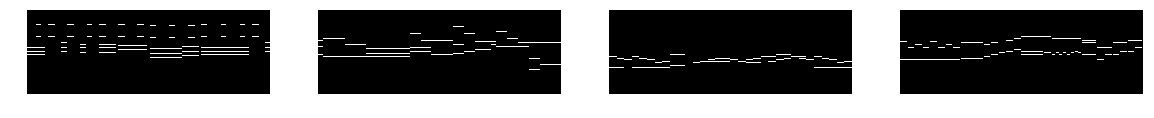

(4, 32, 32, 3)


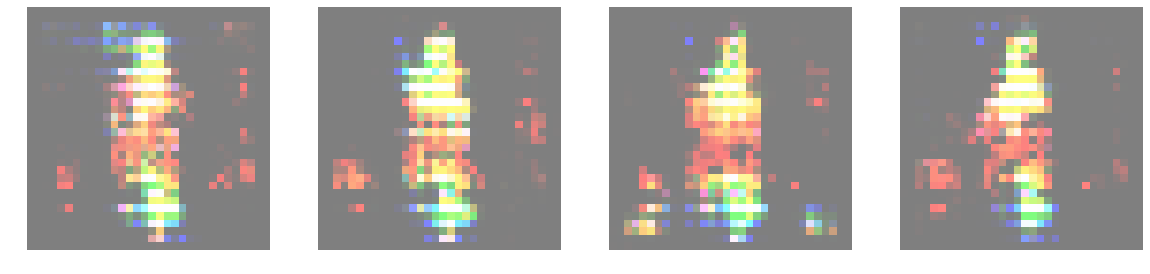

(4, 88, 256, 1)


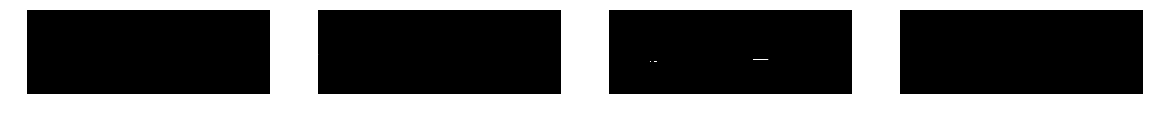

(4, 32, 32, 3)


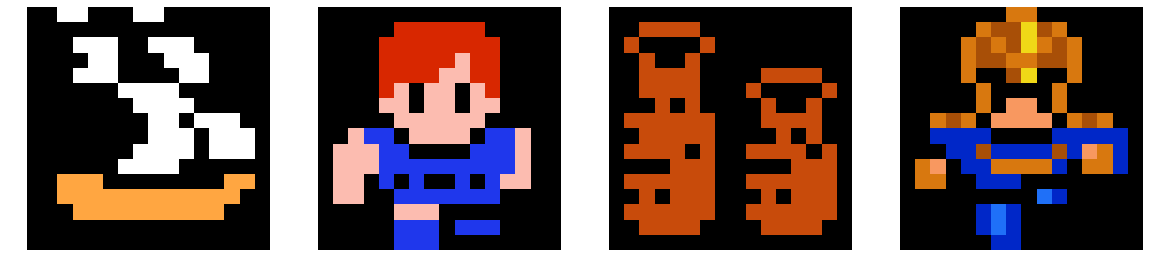

(4, 88, 256, 1)


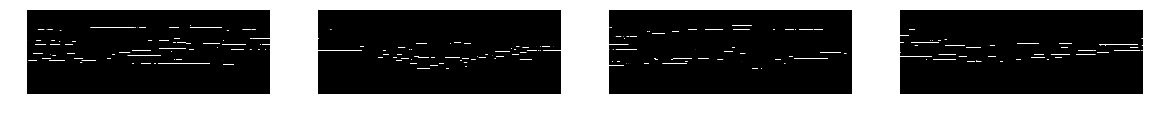

(4, 32, 32, 3)


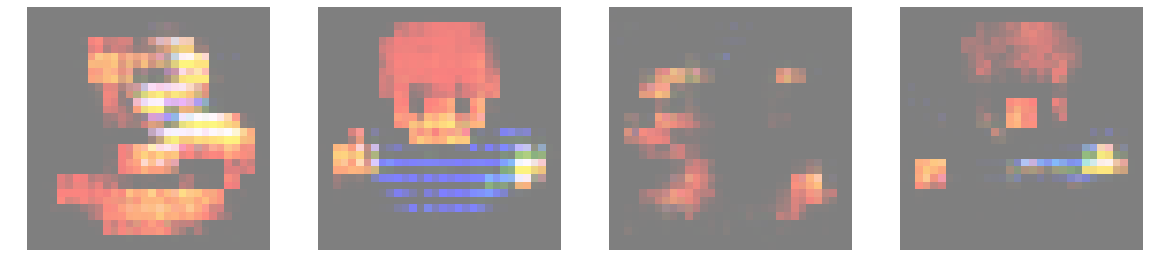

[89/110][30900] Loss_D: 0.027645 0.010521 Loss_G: 0.910901 1.010488 loss_cyc 0.818134 157.132
[89/110][30925] Loss_D: 0.027207 0.002545 Loss_G: 0.957462 0.998932 loss_cyc 0.823993 157.243
[89/110][30950] Loss_D: 0.023147 0.001629 Loss_G: 0.919318 1.001207 loss_cyc 0.797351 157.358
[89/110][30975] Loss_D: 0.019516 0.000558 Loss_G: 0.915584 0.999770 loss_cyc 0.830659 157.485
[89/110][31000] Loss_D: 0.022535 0.001894 Loss_G: 0.976067 1.000227 loss_cyc 0.786121 157.614
[89/110][31025] Loss_D: 0.028978 0.000255 Loss_G: 0.907823 1.000094 loss_cyc 0.784158 157.748
[89/110][31050] Loss_D: 0.025654 0.000317 Loss_G: 0.989381 1.001769 loss_cyc 0.805360 157.865
[89/110][31075] Loss_D: 0.024715 0.000283 Loss_G: 0.891553 1.000583 loss_cyc 0.788228 157.981
[89/110][31100] Loss_D: 0.022652 0.000352 Loss_G: 0.955865 0.999812 loss_cyc 0.806608 158.106
[89/110][31125] Loss_D: 0.018248 0.000369 Loss_G: 0.912210 1.000536 loss_cyc 0.805121 158.223
[89/110][31150] Loss_D: 0.030910 0.005932 Loss_G: 0.946466 1

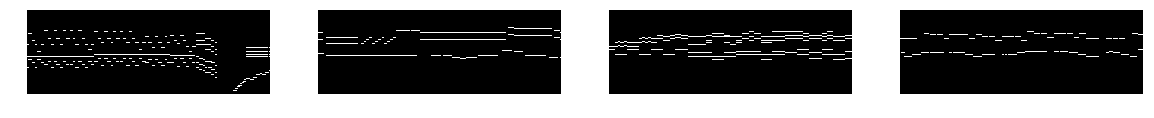

(4, 32, 32, 3)


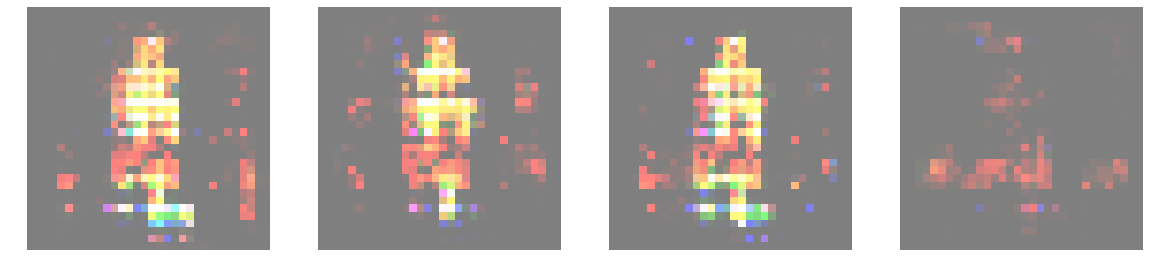

(4, 88, 256, 1)


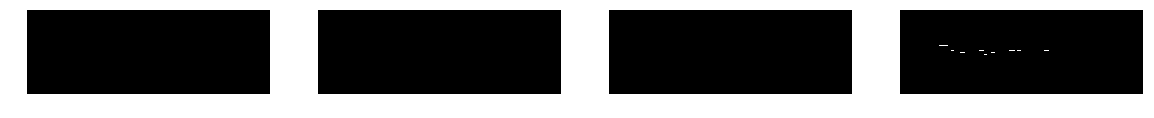

(4, 32, 32, 3)


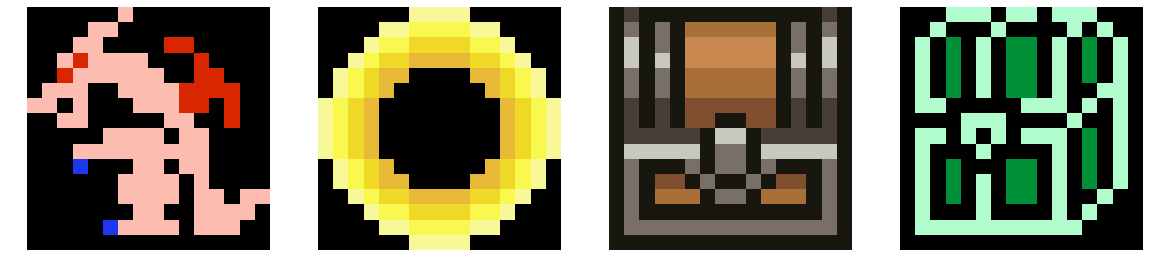

(4, 88, 256, 1)


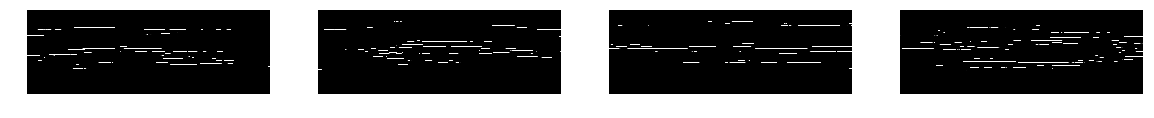

(4, 32, 32, 3)


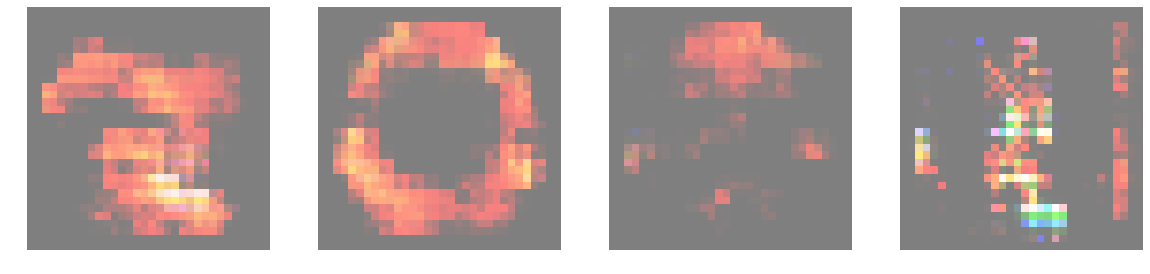

[90/110][31250] Loss_D: 0.035373 0.000665 Loss_G: 0.913272 1.002498 loss_cyc 0.787747 158.891
[90/110][31275] Loss_D: 0.027161 0.034778 Loss_G: 0.948649 1.026196 loss_cyc 0.791048 159.013
[90/110][31300] Loss_D: 0.022341 0.000283 Loss_G: 0.949691 1.000172 loss_cyc 0.804502 159.136
[90/110][31325] Loss_D: 0.020678 0.000128 Loss_G: 1.024389 0.999922 loss_cyc 0.810378 159.254
[90/110][31350] Loss_D: 0.020773 0.000285 Loss_G: 0.931082 1.001044 loss_cyc 0.811706 159.370
[90/110][31375] Loss_D: 0.024390 0.000501 Loss_G: 0.960430 1.000699 loss_cyc 0.810921 159.497
[90/110][31400] Loss_D: 0.024792 0.000401 Loss_G: 0.959471 0.998620 loss_cyc 0.821854 159.619
[90/110][31425] Loss_D: 0.028613 0.000625 Loss_G: 0.929959 1.002233 loss_cyc 0.809979 159.740
[90/110][31450] Loss_D: 0.037234 0.000204 Loss_G: 0.876420 1.000089 loss_cyc 0.829410 159.865
[90/110][31475] Loss_D: 0.021231 0.000296 Loss_G: 0.964464 1.000310 loss_cyc 0.788623 159.989
[90/110][31500] Loss_D: 0.020191 0.000322 Loss_G: 0.977254 0

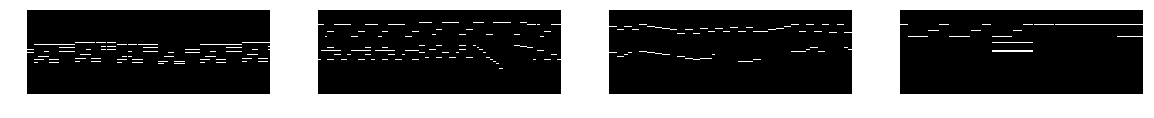

(4, 32, 32, 3)


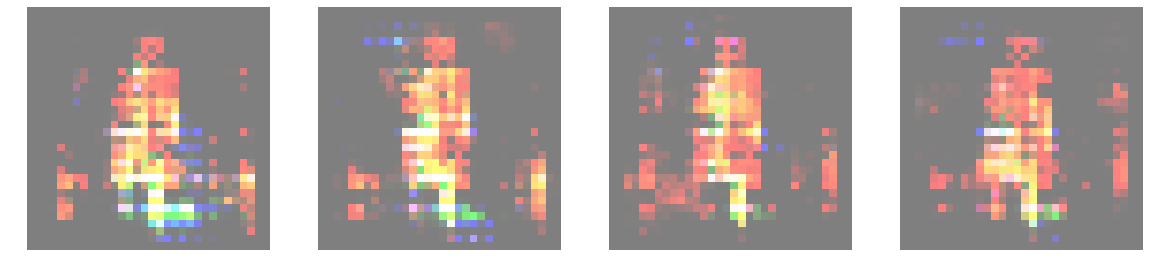

(4, 88, 256, 1)


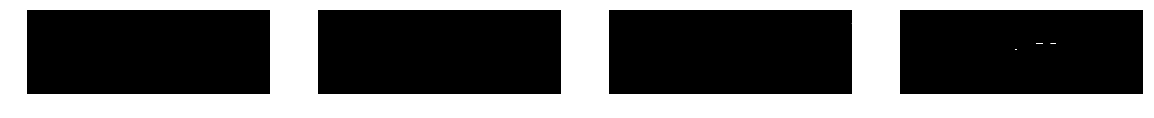

(4, 32, 32, 3)


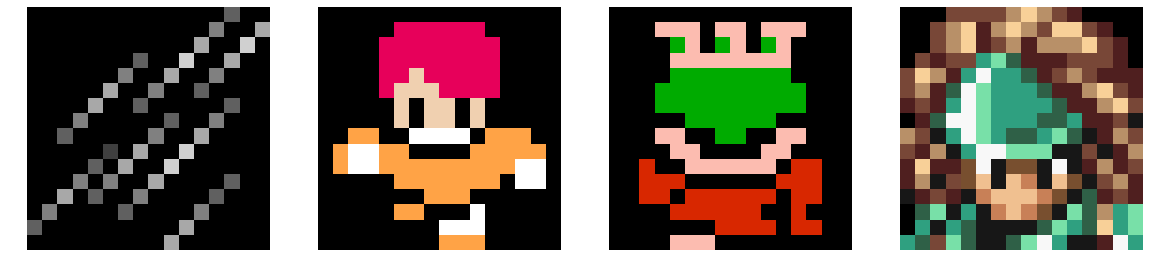

(4, 88, 256, 1)


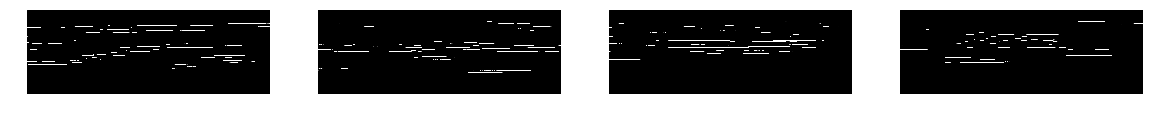

(4, 32, 32, 3)


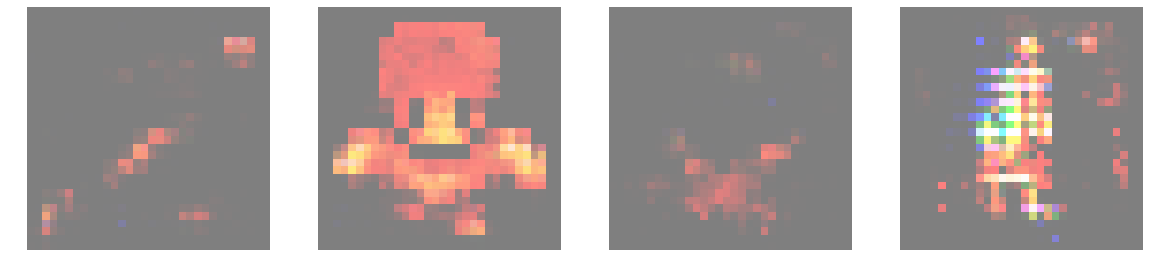

[91/110][31600] Loss_D: 0.021872 0.000326 Loss_G: 0.906689 0.999076 loss_cyc 0.800701 160.663
[91/110][31625] Loss_D: 0.014672 0.000376 Loss_G: 0.932272 1.000959 loss_cyc 0.792460 160.786
[91/110][31650] Loss_D: 0.017674 0.000089 Loss_G: 0.913243 1.000860 loss_cyc 0.826705 160.902
[91/110][31675] Loss_D: 0.032923 0.000251 Loss_G: 0.910520 1.000052 loss_cyc 0.813303 161.013
[91/110][31700] Loss_D: 0.022480 0.000490 Loss_G: 0.882042 1.000155 loss_cyc 0.815857 161.150
[91/110][31725] Loss_D: 0.027761 0.006300 Loss_G: 0.996430 1.005471 loss_cyc 0.795766 161.270
[91/110][31750] Loss_D: 0.019293 0.001165 Loss_G: 0.945476 1.000349 loss_cyc 0.797203 161.407
[91/110][31775] Loss_D: 0.031192 0.000820 Loss_G: 0.992347 1.001647 loss_cyc 0.821727 161.532
[91/110][31800] Loss_D: 0.023106 0.000358 Loss_G: 0.913670 1.000381 loss_cyc 0.823940 161.653
[91/110][31825] Loss_D: 0.023221 0.000482 Loss_G: 0.970181 1.002257 loss_cyc 0.796393 161.781
[91/110][31850] Loss_D: 0.019956 0.000558 Loss_G: 0.953031 1

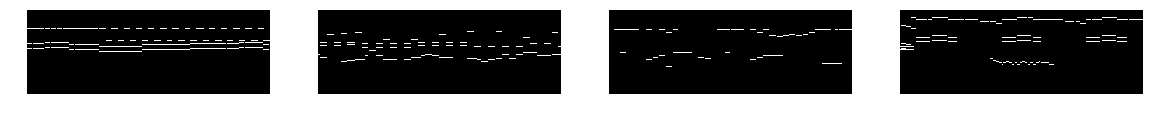

(4, 32, 32, 3)


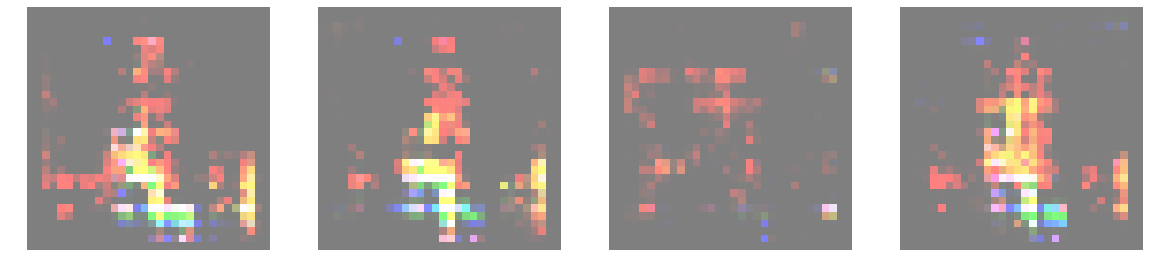

(4, 88, 256, 1)


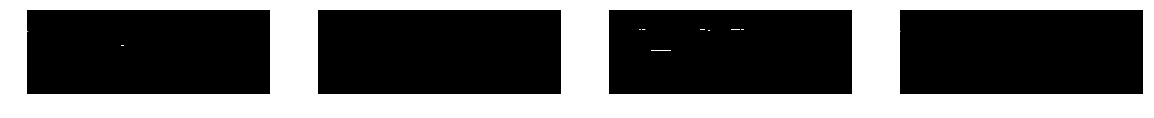

(4, 32, 32, 3)


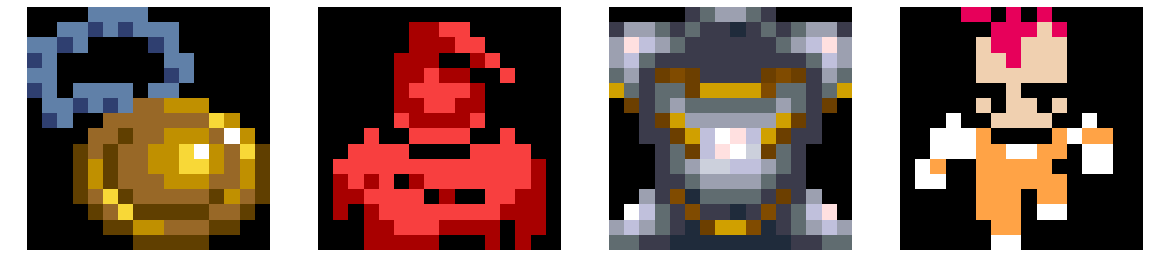

(4, 88, 256, 1)


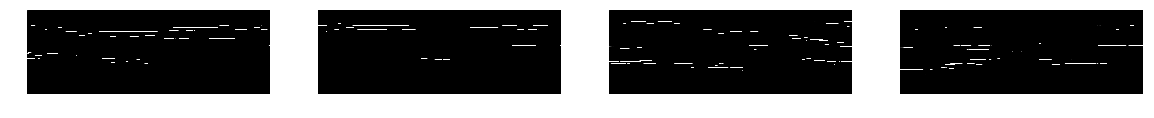

(4, 32, 32, 3)


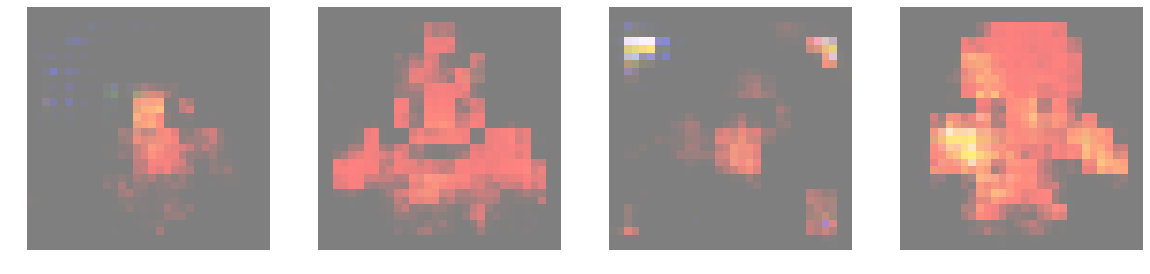

[92/110][31950] Loss_D: 0.013005 0.000426 Loss_G: 1.012845 0.999334 loss_cyc 0.799530 162.434
[92/110][31975] Loss_D: 0.028081 0.001294 Loss_G: 0.928805 1.003764 loss_cyc 0.799640 162.563
[92/110][32000] Loss_D: 0.015328 0.001095 Loss_G: 0.942205 0.999011 loss_cyc 0.807243 162.685
[92/110][32025] Loss_D: 0.017179 0.000184 Loss_G: 1.015376 1.001108 loss_cyc 0.817836 162.807
[92/110][32050] Loss_D: 0.023874 0.003411 Loss_G: 0.990937 1.005096 loss_cyc 0.821635 162.938
[92/110][32075] Loss_D: 0.024022 0.001013 Loss_G: 0.914423 1.000350 loss_cyc 0.814576 163.063
[92/110][32100] Loss_D: 0.014564 0.002924 Loss_G: 0.960961 1.001714 loss_cyc 0.806854 163.182
[92/110][32125] Loss_D: 0.015932 0.002912 Loss_G: 0.921571 1.001783 loss_cyc 0.828412 163.303
[92/110][32150] Loss_D: 0.021200 0.000668 Loss_G: 1.016717 1.002183 loss_cyc 0.815386 163.419
[92/110][32175] Loss_D: 0.020733 0.001415 Loss_G: 0.942142 0.999165 loss_cyc 0.810888 163.536
[92/110][32200] Loss_D: 0.030313 0.000221 Loss_G: 0.974982 1

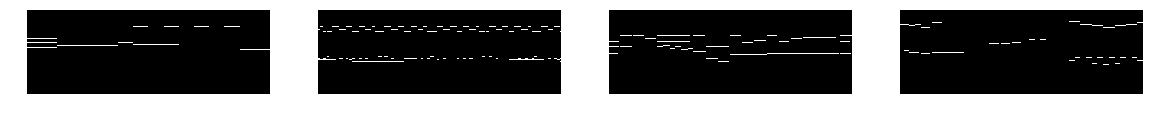

(4, 32, 32, 3)


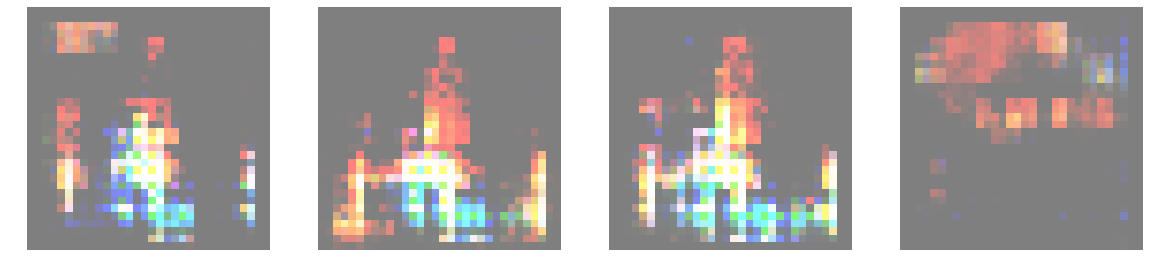

(4, 88, 256, 1)


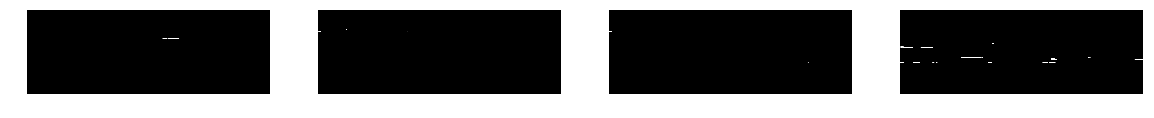

(4, 32, 32, 3)


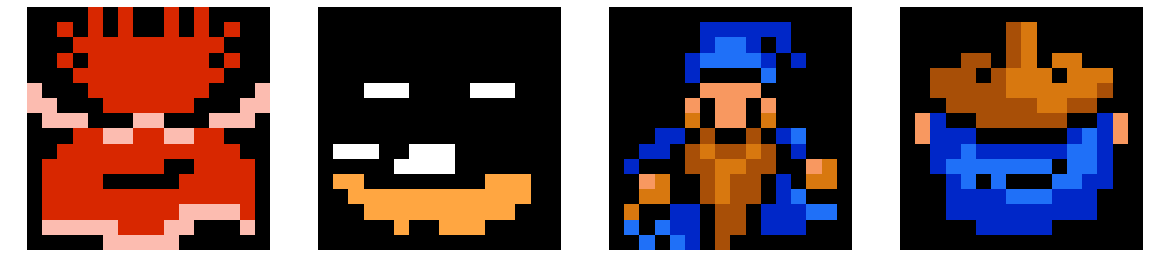

(4, 88, 256, 1)


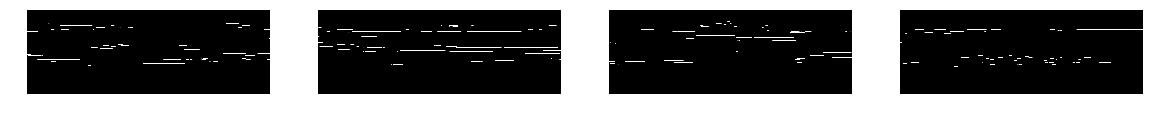

(4, 32, 32, 3)


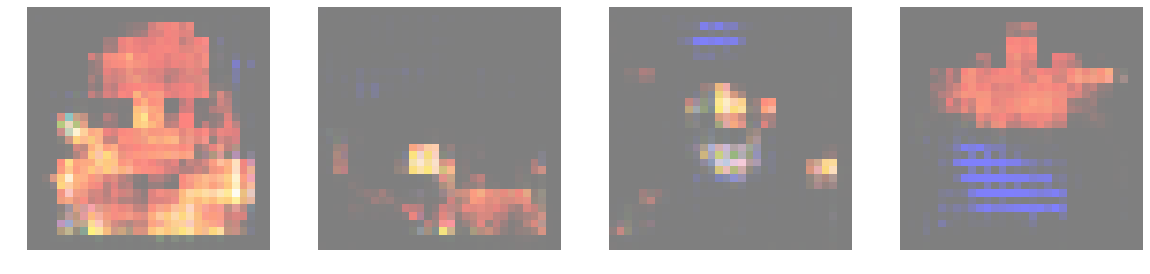

[93/110][32275] Loss_D: 0.019349 0.003522 Loss_G: 0.947633 1.004770 loss_cyc 0.799974 164.082
[93/110][32300] Loss_D: 0.036867 0.001215 Loss_G: 0.887335 1.002940 loss_cyc 0.776315 164.202
[93/110][32325] Loss_D: 0.022492 0.000633 Loss_G: 0.963494 1.000243 loss_cyc 0.813905 164.331
[93/110][32350] Loss_D: 0.023603 0.000858 Loss_G: 0.949500 1.000183 loss_cyc 0.818164 164.463
[93/110][32375] Loss_D: 0.012039 0.003133 Loss_G: 1.017077 1.005332 loss_cyc 0.816706 164.577
[93/110][32400] Loss_D: 0.031203 0.001090 Loss_G: 0.941427 0.998817 loss_cyc 0.810990 164.707
[93/110][32425] Loss_D: 0.023131 0.002314 Loss_G: 0.898564 1.001092 loss_cyc 0.802941 164.822
[93/110][32450] Loss_D: 0.022309 0.000183 Loss_G: 0.943351 0.999809 loss_cyc 0.799815 164.949
[93/110][32475] Loss_D: 0.025868 0.001210 Loss_G: 0.950553 1.004787 loss_cyc 0.812187 165.076
[93/110][32500] Loss_D: 0.015699 0.000769 Loss_G: 0.940969 0.998426 loss_cyc 0.816521 165.197
[93/110][32525] Loss_D: 0.027921 0.001953 Loss_G: 0.911014 1

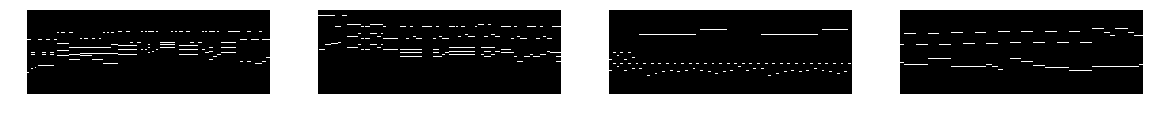

(4, 32, 32, 3)


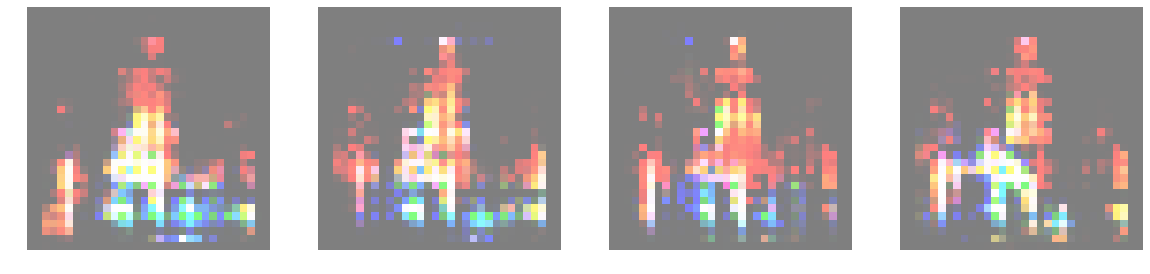

(4, 88, 256, 1)


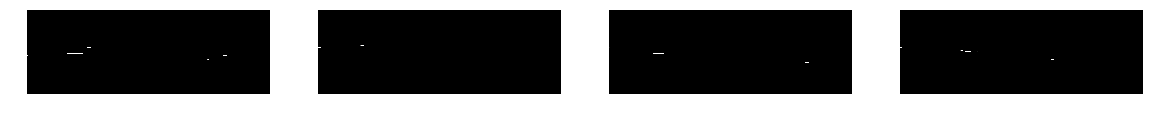

(4, 32, 32, 3)


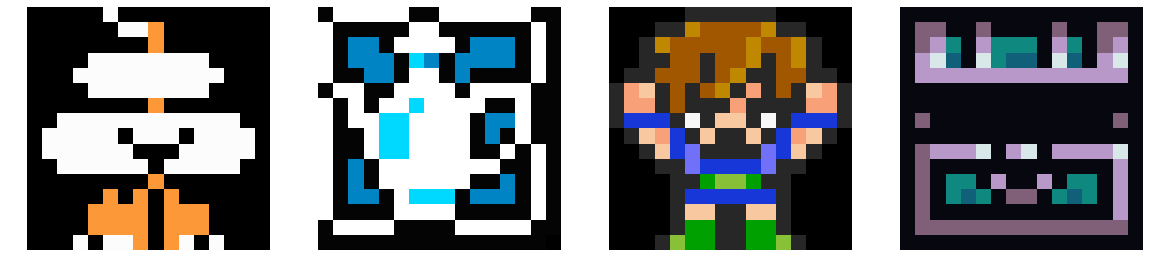

(4, 88, 256, 1)


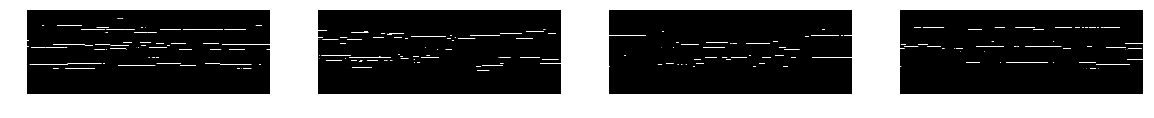

(4, 32, 32, 3)


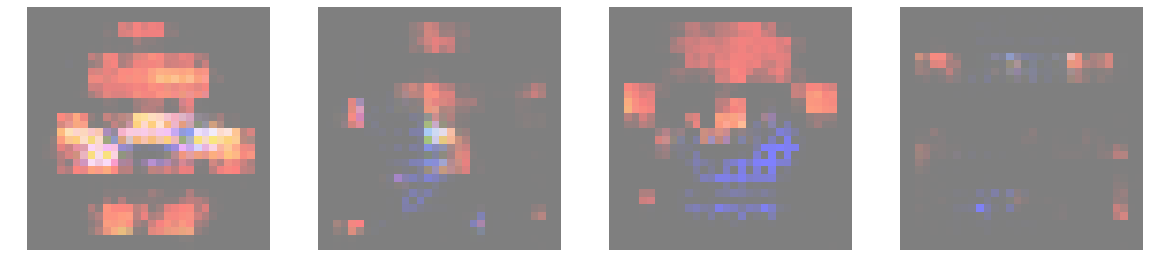

[94/110][32625] Loss_D: 0.020138 0.001257 Loss_G: 0.976945 1.004585 loss_cyc 0.787859 165.855
[94/110][32650] Loss_D: 0.020721 0.005337 Loss_G: 0.938916 1.005289 loss_cyc 0.806664 165.975
[94/110][32675] Loss_D: 0.023427 0.000439 Loss_G: 0.964019 0.998263 loss_cyc 0.820470 166.091
[94/110][32700] Loss_D: 0.018146 0.001428 Loss_G: 0.950811 0.996848 loss_cyc 0.818193 166.213
[94/110][32725] Loss_D: 0.026294 0.002598 Loss_G: 0.908217 1.006599 loss_cyc 0.825672 166.337
[94/110][32750] Loss_D: 0.020662 0.000327 Loss_G: 0.925274 0.998739 loss_cyc 0.804662 166.453
[94/110][32775] Loss_D: 0.025073 0.000969 Loss_G: 0.959955 1.001400 loss_cyc 0.790114 166.568
[94/110][32800] Loss_D: 0.017848 0.001537 Loss_G: 0.933285 1.003428 loss_cyc 0.802049 166.697
[94/110][32825] Loss_D: 0.030641 0.001847 Loss_G: 0.948492 1.000005 loss_cyc 0.801992 166.824
[94/110][32850] Loss_D: 0.017655 0.002100 Loss_G: 0.944911 1.000220 loss_cyc 0.830290 166.945
[94/110][32875] Loss_D: 0.020155 0.001492 Loss_G: 0.967850 1

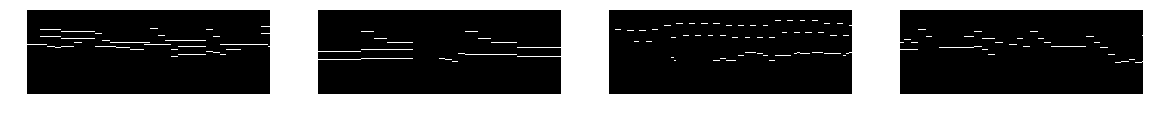

(4, 32, 32, 3)


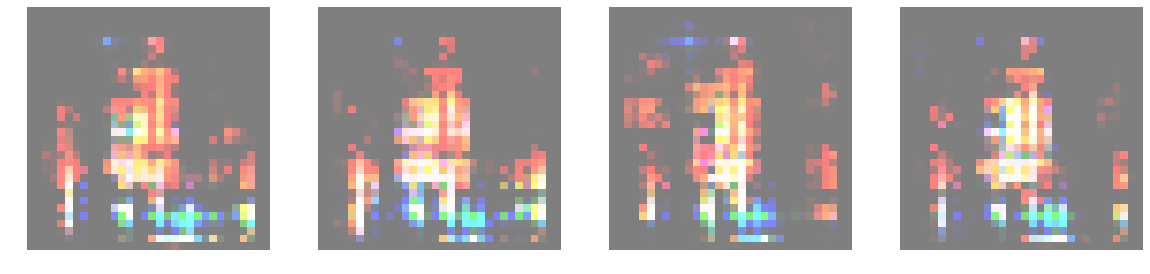

(4, 88, 256, 1)


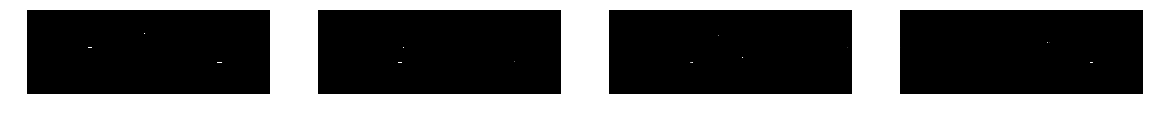

(4, 32, 32, 3)


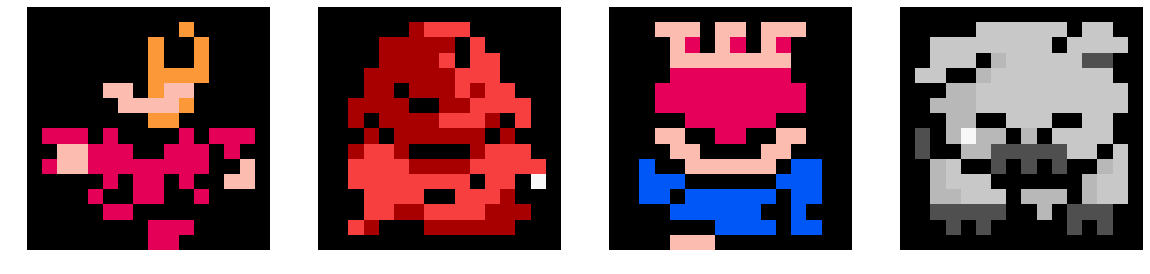

(4, 88, 256, 1)


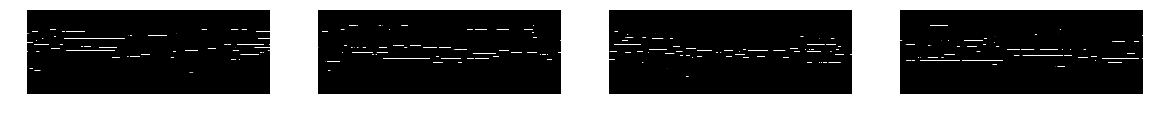

(4, 32, 32, 3)


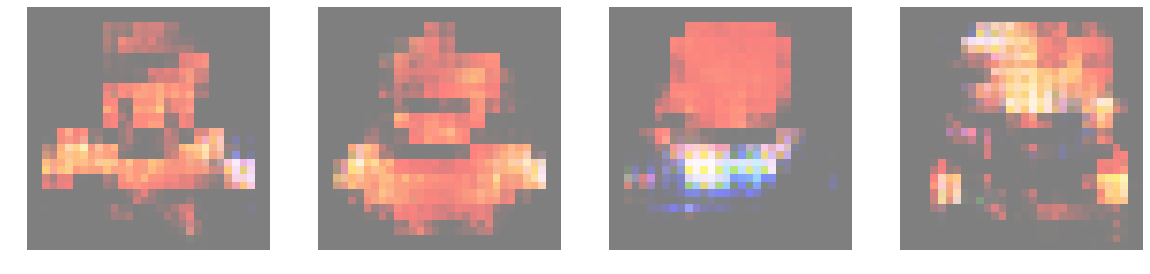

[95/110][32975] Loss_D: 0.016225 0.000259 Loss_G: 0.979815 0.998927 loss_cyc 0.814413 167.623
[95/110][33000] Loss_D: 0.020737 0.001262 Loss_G: 0.993237 1.000192 loss_cyc 0.793515 167.733
[95/110][33025] Loss_D: 0.023958 0.001979 Loss_G: 0.947538 1.002762 loss_cyc 0.788821 167.853
[95/110][33050] Loss_D: 0.027269 0.000878 Loss_G: 0.937827 1.002777 loss_cyc 0.809735 167.958
[95/110][33075] Loss_D: 0.018484 0.001968 Loss_G: 0.961369 1.000899 loss_cyc 0.807529 168.072
[95/110][33100] Loss_D: 0.027861 0.002658 Loss_G: 0.905750 1.005718 loss_cyc 0.816035 168.199
[95/110][33125] Loss_D: 0.023766 0.001451 Loss_G: 0.959534 1.001143 loss_cyc 0.787250 168.339
[95/110][33150] Loss_D: 0.043502 0.001074 Loss_G: 0.932200 0.997795 loss_cyc 0.796481 168.470
[95/110][33175] Loss_D: 0.019903 0.000103 Loss_G: 0.928120 0.999448 loss_cyc 0.794956 168.599
[95/110][33200] Loss_D: 0.019730 0.001744 Loss_G: 0.932141 1.001741 loss_cyc 0.812637 168.721
[95/110][33225] Loss_D: 0.017292 0.000118 Loss_G: 0.886207 1

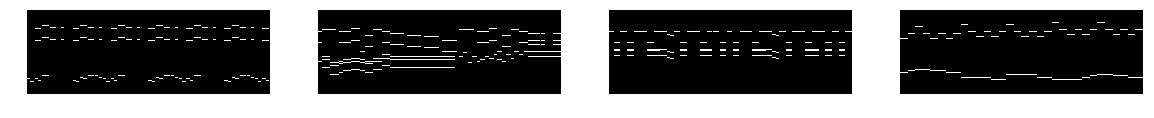

(4, 32, 32, 3)


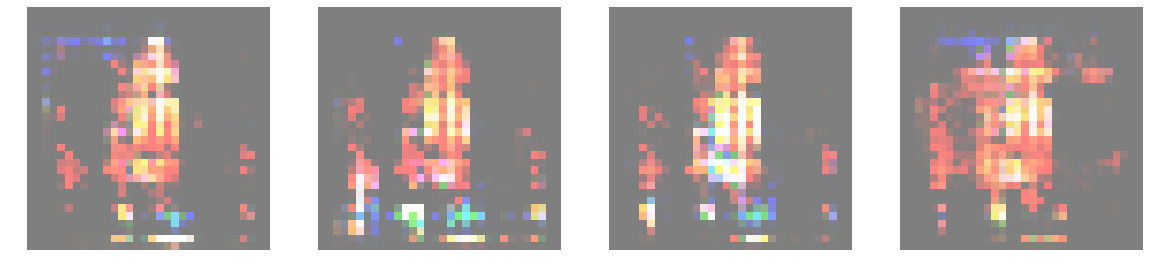

(4, 88, 256, 1)


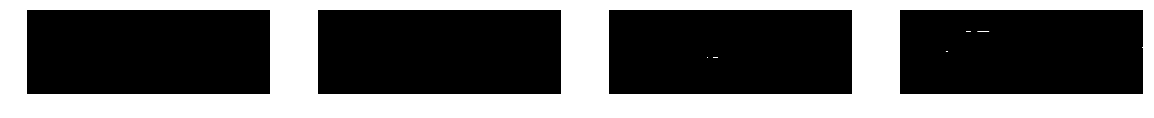

(4, 32, 32, 3)


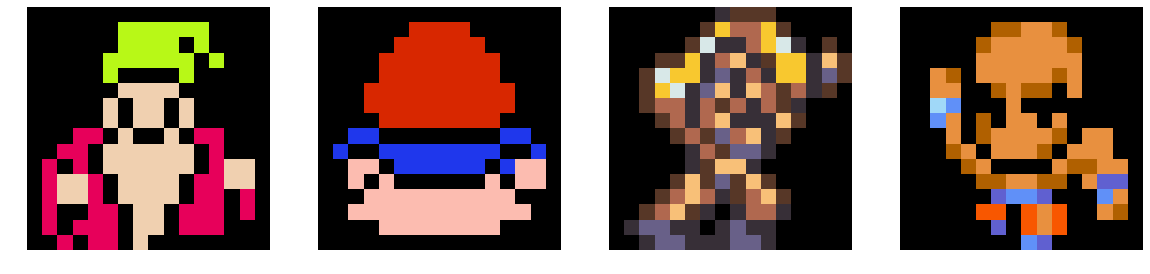

(4, 88, 256, 1)


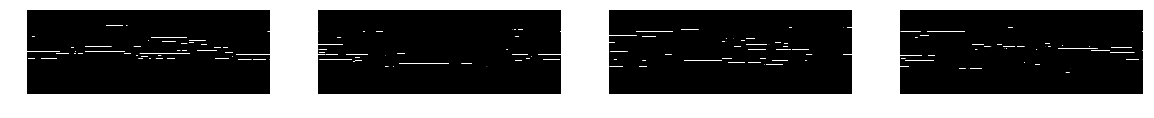

(4, 32, 32, 3)


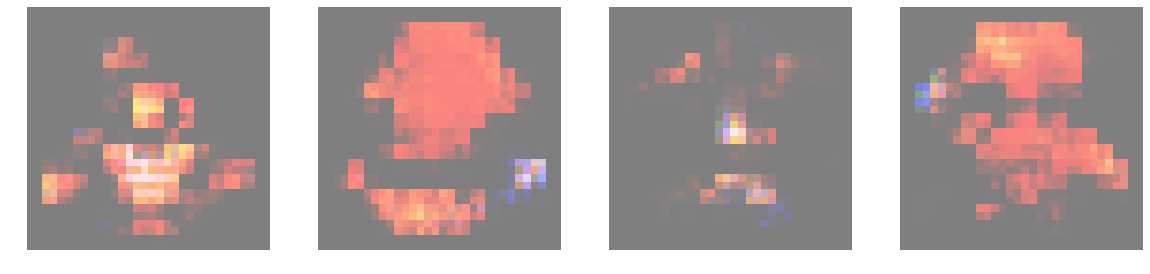

[96/110][33325] Loss_D: 0.019911 0.000139 Loss_G: 0.960749 1.000400 loss_cyc 0.788686 169.392
[96/110][33350] Loss_D: 0.017195 0.000626 Loss_G: 0.974282 0.999525 loss_cyc 0.798944 169.510
[96/110][33375] Loss_D: 0.015024 0.003032 Loss_G: 0.973919 1.007483 loss_cyc 0.806994 169.629
[96/110][33400] Loss_D: 0.018519 0.003092 Loss_G: 0.980917 0.999324 loss_cyc 0.792495 169.751
[96/110][33425] Loss_D: 0.024948 0.000779 Loss_G: 0.942261 0.998921 loss_cyc 0.817138 169.873
[96/110][33450] Loss_D: 0.019730 0.001650 Loss_G: 0.919440 1.001663 loss_cyc 0.806660 169.995
[96/110][33475] Loss_D: 0.032250 0.000656 Loss_G: 0.984724 1.000320 loss_cyc 0.798383 170.115
[96/110][33500] Loss_D: 0.024795 0.000691 Loss_G: 0.902782 0.997973 loss_cyc 0.802607 170.241
[96/110][33525] Loss_D: 0.022195 0.001996 Loss_G: 0.965045 1.004847 loss_cyc 0.802102 170.362
[96/110][33550] Loss_D: 0.024262 0.001479 Loss_G: 1.023131 0.999907 loss_cyc 0.820784 170.497
[96/110][33575] Loss_D: 0.019154 0.003949 Loss_G: 0.923528 1

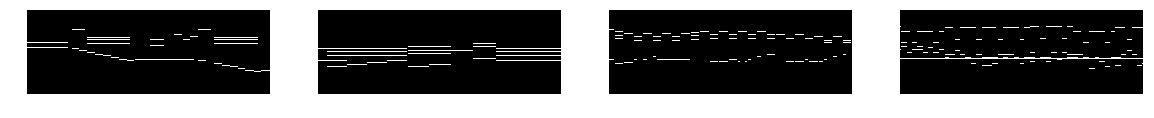

(4, 32, 32, 3)


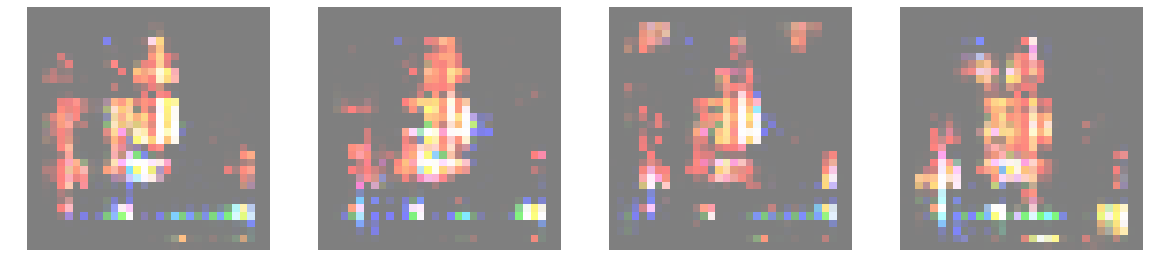

(4, 88, 256, 1)


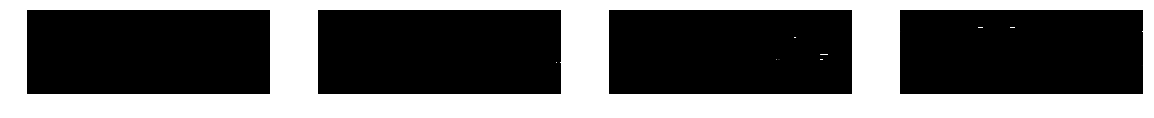

(4, 32, 32, 3)


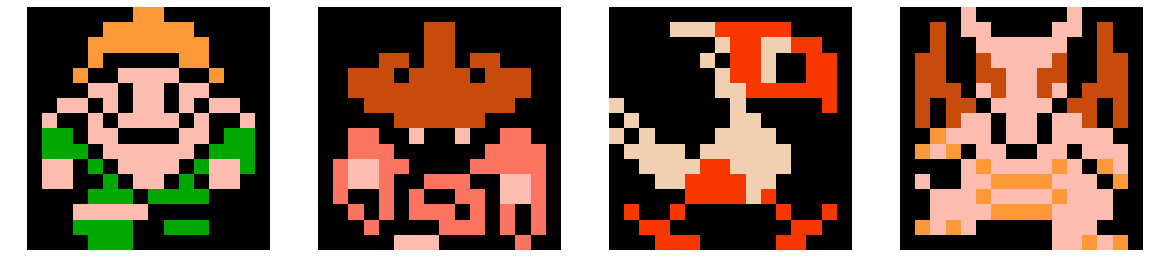

(4, 88, 256, 1)


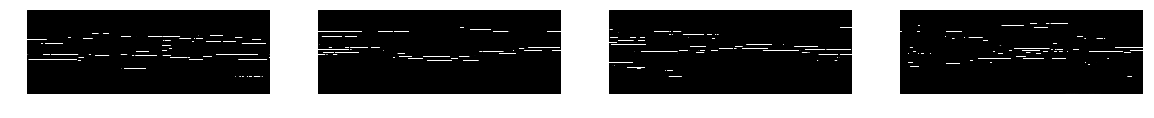

(4, 32, 32, 3)


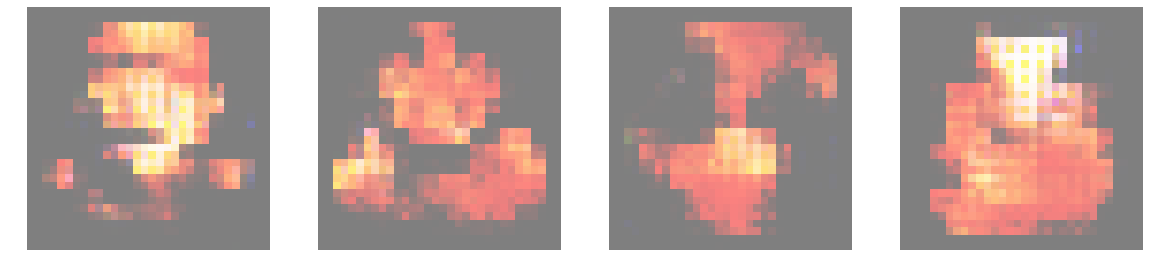

[97/110][33675] Loss_D: 0.019714 0.000428 Loss_G: 0.902314 1.001020 loss_cyc 0.810661 171.149
[97/110][33700] Loss_D: 0.027227 0.000734 Loss_G: 0.919740 1.000085 loss_cyc 0.757776 171.277
[97/110][33725] Loss_D: 0.029364 0.001597 Loss_G: 0.947267 0.999017 loss_cyc 0.807111 171.398
[97/110][33750] Loss_D: 0.015020 0.001240 Loss_G: 0.932727 1.002817 loss_cyc 0.814048 171.532
[97/110][33775] Loss_D: 0.020942 0.001198 Loss_G: 0.931157 0.999057 loss_cyc 0.815579 171.654
[97/110][33800] Loss_D: 0.037307 0.000682 Loss_G: 0.923475 1.000008 loss_cyc 0.810451 171.778
[97/110][33825] Loss_D: 0.020131 0.003293 Loss_G: 0.938029 1.004961 loss_cyc 0.805881 171.898
[97/110][33850] Loss_D: 0.020870 0.001079 Loss_G: 0.936778 1.000500 loss_cyc 0.795507 172.023
[97/110][33875] Loss_D: 0.029931 0.001812 Loss_G: 0.922926 1.001722 loss_cyc 0.782097 172.141
[97/110][33900] Loss_D: 0.025683 0.000054 Loss_G: 1.004924 0.999426 loss_cyc 0.796992 172.260
[97/110][33925] Loss_D: 0.017452 0.002938 Loss_G: 0.982374 1

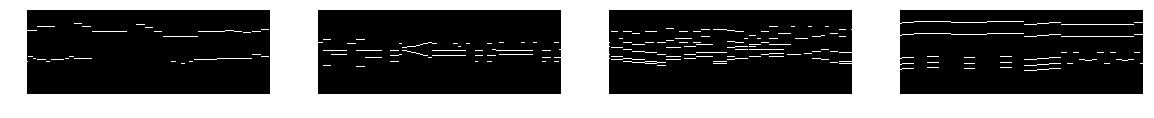

(4, 32, 32, 3)


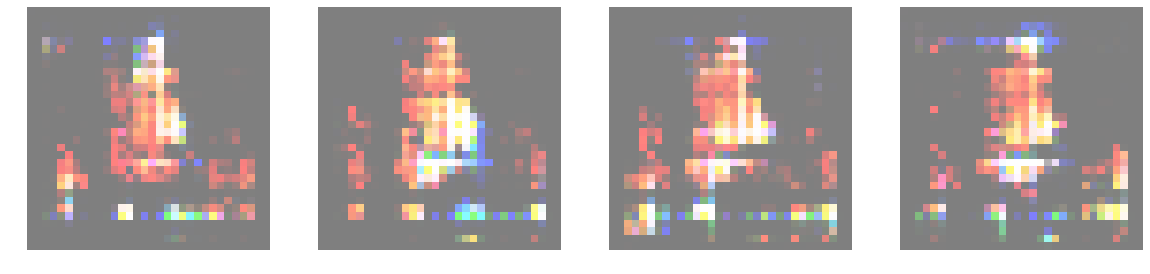

(4, 88, 256, 1)


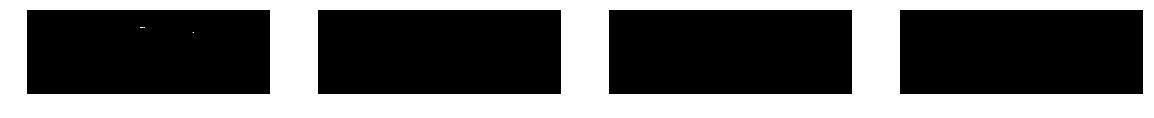

(4, 32, 32, 3)


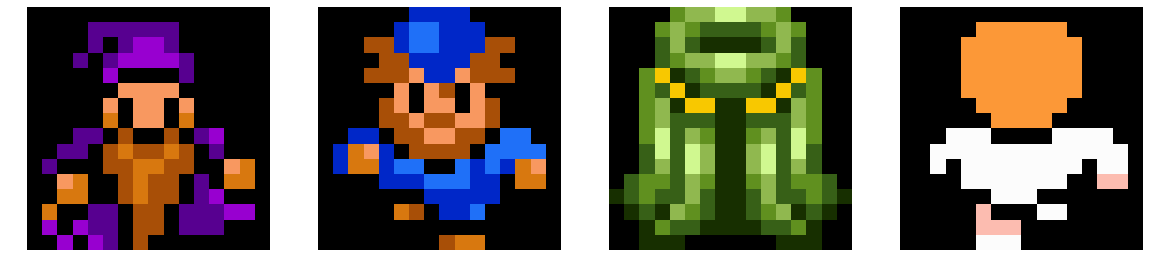

(4, 88, 256, 1)


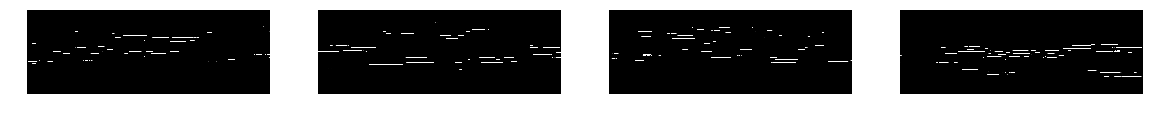

(4, 32, 32, 3)


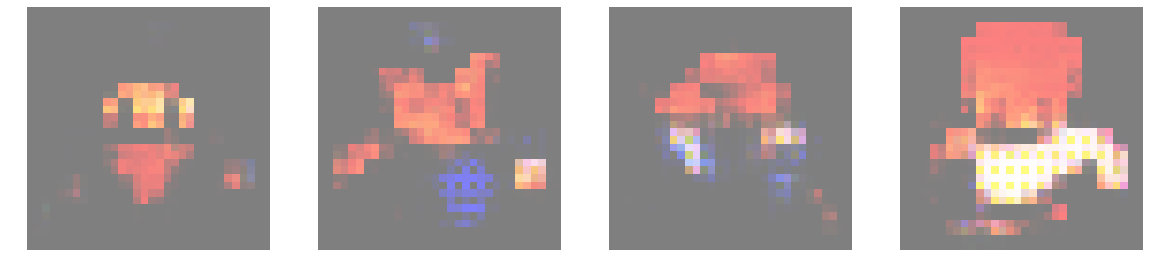

[98/110][34025] Loss_D: 0.026674 0.000789 Loss_G: 0.937389 1.000917 loss_cyc 0.795140 172.938
[98/110][34050] Loss_D: 0.022630 0.002209 Loss_G: 0.972537 1.003954 loss_cyc 0.797208 173.066
[98/110][34075] Loss_D: 0.023182 0.001742 Loss_G: 0.935941 1.001412 loss_cyc 0.777425 173.194
[98/110][34100] Loss_D: 0.040060 0.000425 Loss_G: 0.889245 0.996937 loss_cyc 0.796929 173.322
[98/110][34125] Loss_D: 0.022128 0.002787 Loss_G: 0.911655 1.001078 loss_cyc 0.808305 173.444
[98/110][34150] Loss_D: 0.020778 0.003173 Loss_G: 1.011641 1.004347 loss_cyc 0.791294 173.564
[98/110][34175] Loss_D: 0.023901 0.001013 Loss_G: 0.982375 1.001918 loss_cyc 0.830705 173.681
[98/110][34200] Loss_D: 0.018698 0.001310 Loss_G: 0.977782 1.000173 loss_cyc 0.810944 173.800
[98/110][34225] Loss_D: 0.019164 0.000349 Loss_G: 0.969064 1.000334 loss_cyc 0.800087 173.927
[98/110][34250] Loss_D: 0.015659 0.000210 Loss_G: 0.962874 1.002072 loss_cyc 0.797214 174.054
[98/110][34275] Loss_D: 0.018027 0.000229 Loss_G: 0.896943 0

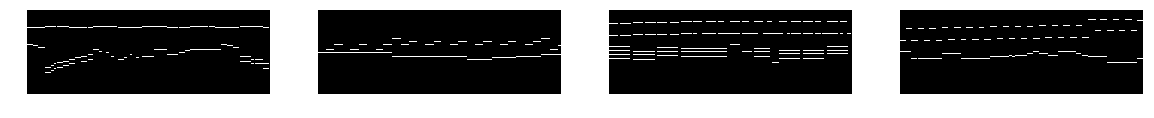

(4, 32, 32, 3)


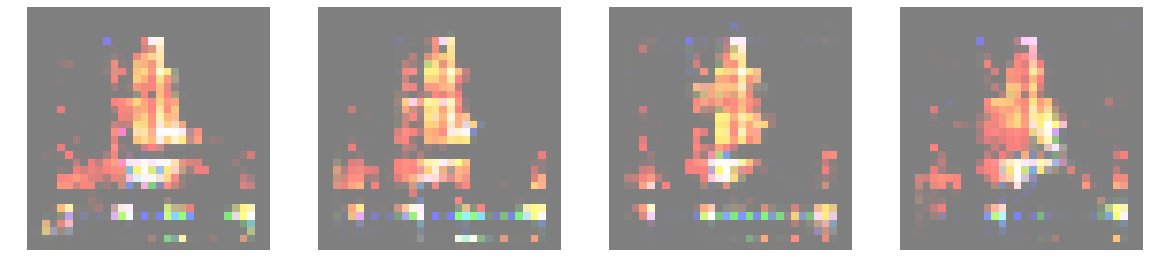

(4, 88, 256, 1)


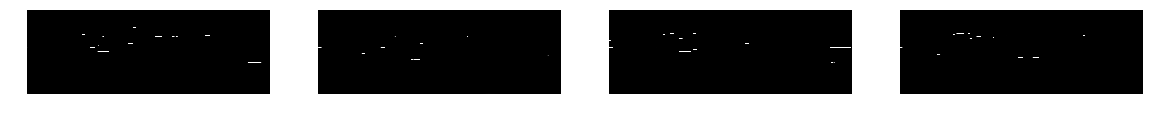

(4, 32, 32, 3)


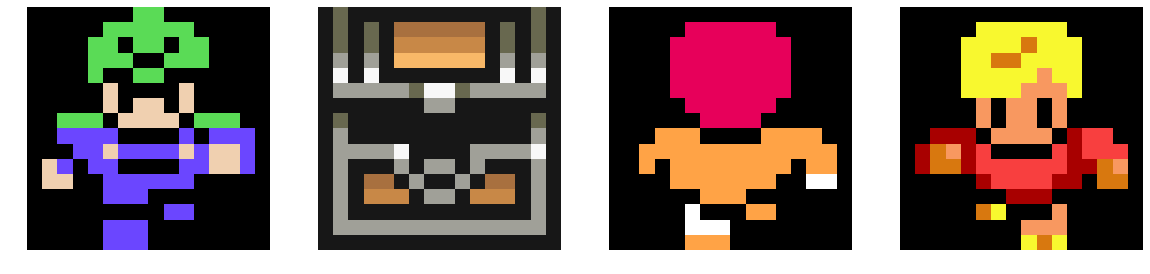

(4, 88, 256, 1)


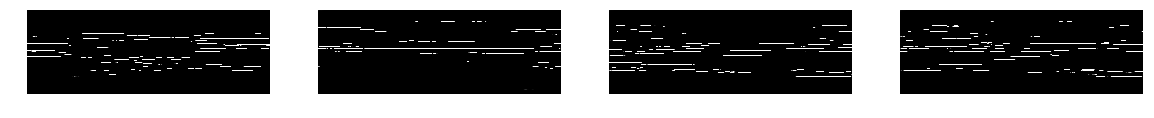

(4, 32, 32, 3)


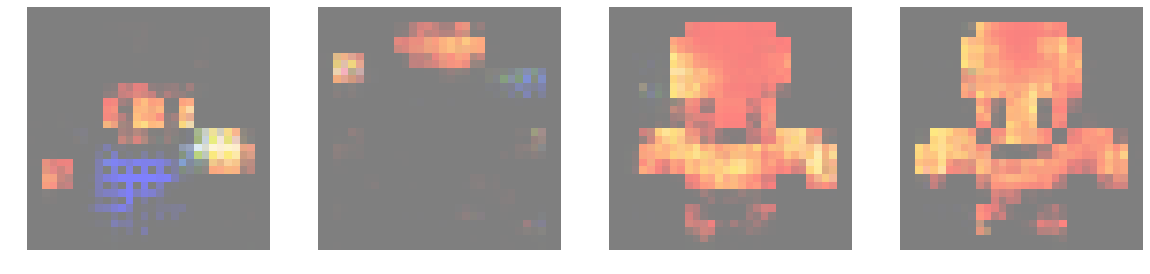

[99/110][34375] Loss_D: 0.017508 0.001529 Loss_G: 0.940542 1.002053 loss_cyc 0.815000 174.706
[99/110][34400] Loss_D: 0.024818 0.000962 Loss_G: 0.968707 0.999996 loss_cyc 0.783356 174.828
[99/110][34425] Loss_D: 0.014696 0.000290 Loss_G: 0.985506 1.001821 loss_cyc 0.818130 174.946
[99/110][34450] Loss_D: 0.015500 0.002501 Loss_G: 0.979352 0.998891 loss_cyc 0.793086 175.067
[99/110][34475] Loss_D: 0.029608 0.002758 Loss_G: 0.941884 1.004678 loss_cyc 0.804821 175.194
[99/110][34500] Loss_D: 0.046974 0.000602 Loss_G: 0.916941 1.003157 loss_cyc 0.822007 175.314
[99/110][34525] Loss_D: 0.024960 0.001240 Loss_G: 0.949410 0.997313 loss_cyc 0.804706 175.433
[99/110][34550] Loss_D: 0.018738 0.000891 Loss_G: 0.930889 1.003569 loss_cyc 0.805525 175.550
[99/110][34575] Loss_D: 0.018979 0.002743 Loss_G: 0.897856 1.002485 loss_cyc 0.804715 175.676
[99/110][34600] Loss_D: 0.017328 0.000810 Loss_G: 0.958221 0.999021 loss_cyc 0.823965 175.792
[99/110][34625] Loss_D: 0.016848 0.000810 Loss_G: 0.938818 1

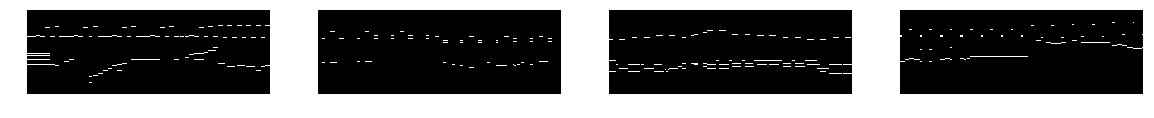

(4, 32, 32, 3)


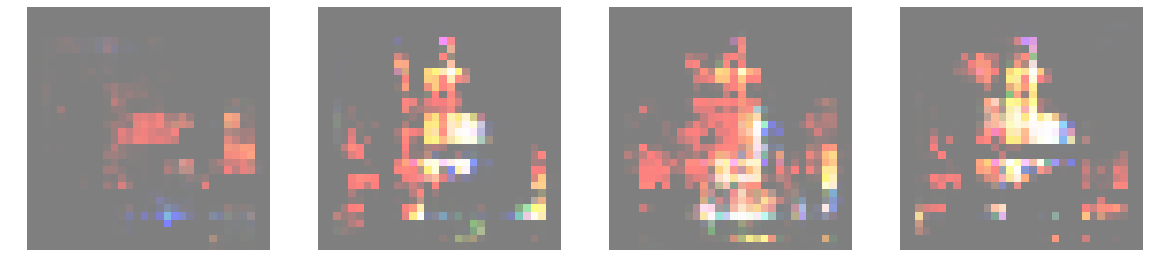

(4, 88, 256, 1)


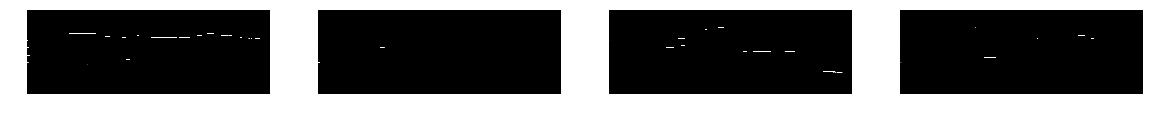

(4, 32, 32, 3)


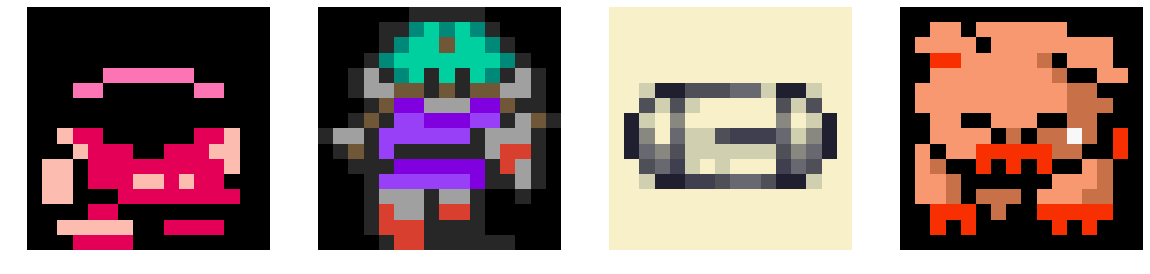

(4, 88, 256, 1)


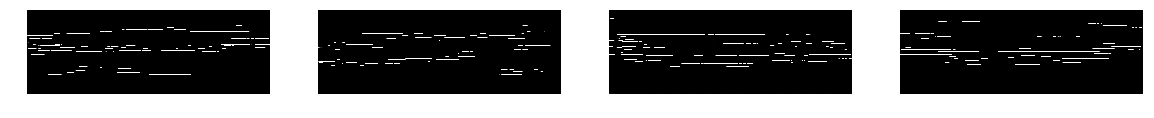

(4, 32, 32, 3)


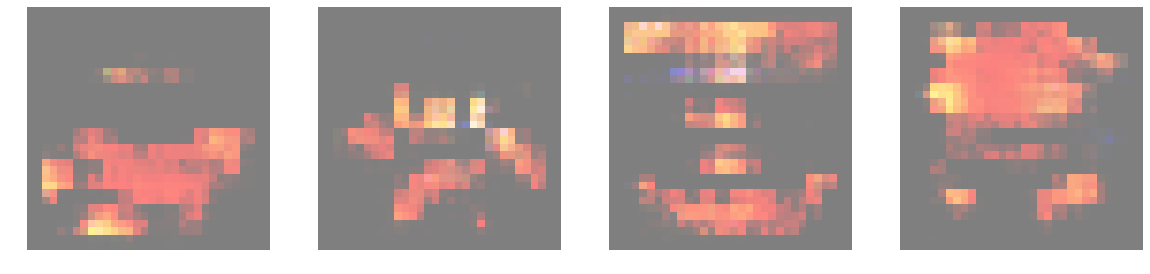

[100/110][34725] Loss_D: 0.012795 0.000429 Loss_G: 0.940751 1.003466 loss_cyc 0.800258 176.472
[100/110][34750] Loss_D: 0.015383 0.006960 Loss_G: 0.931268 1.003576 loss_cyc 0.786946 176.586
[100/110][34775] Loss_D: 0.026351 0.000665 Loss_G: 0.984588 1.000338 loss_cyc 0.805551 176.711
[100/110][34800] Loss_D: 0.021693 0.000516 Loss_G: 0.975094 1.000779 loss_cyc 0.805752 176.840
[100/110][34825] Loss_D: 0.013634 0.000676 Loss_G: 1.001427 0.998547 loss_cyc 0.815042 176.969
[100/110][34850] Loss_D: 0.023675 0.000772 Loss_G: 0.950294 1.002627 loss_cyc 0.804867 177.087
[100/110][34875] Loss_D: 0.016344 0.000516 Loss_G: 0.977491 1.001123 loss_cyc 0.800607 177.210
[100/110][34900] Loss_D: 0.020256 0.000422 Loss_G: 0.925244 1.001937 loss_cyc 0.795220 177.323
[100/110][34925] Loss_D: 0.020754 0.001321 Loss_G: 0.965864 0.999513 loss_cyc 0.808302 177.445
[100/110][34950] Loss_D: 0.024465 0.002922 Loss_G: 0.996680 1.005223 loss_cyc 0.805278 177.562
[100/110][34975] Loss_D: 0.026056 0.005310 Loss_G:

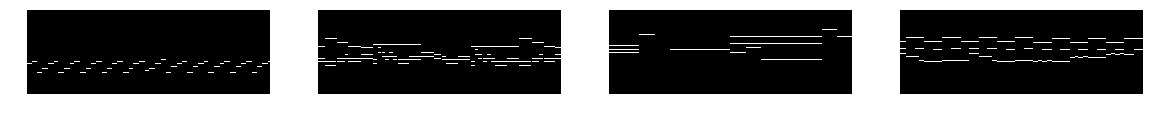

(4, 32, 32, 3)


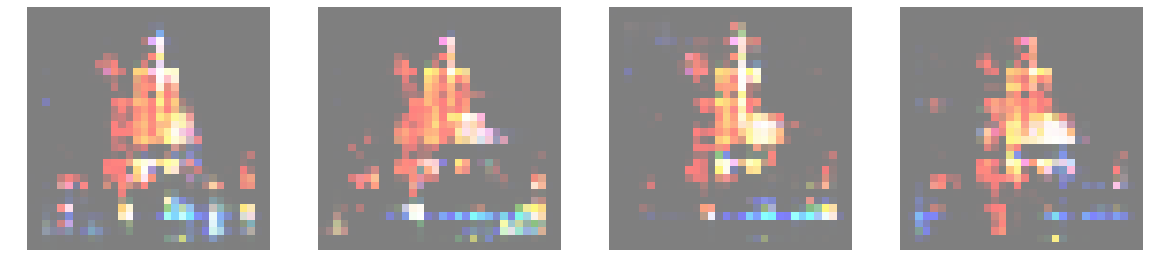

(4, 88, 256, 1)


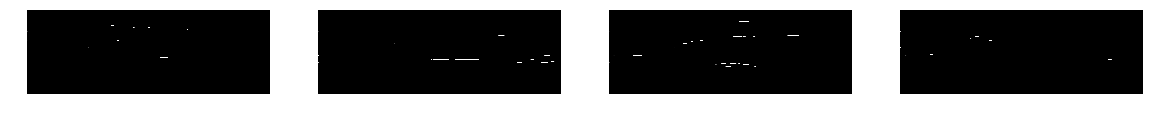

(4, 32, 32, 3)


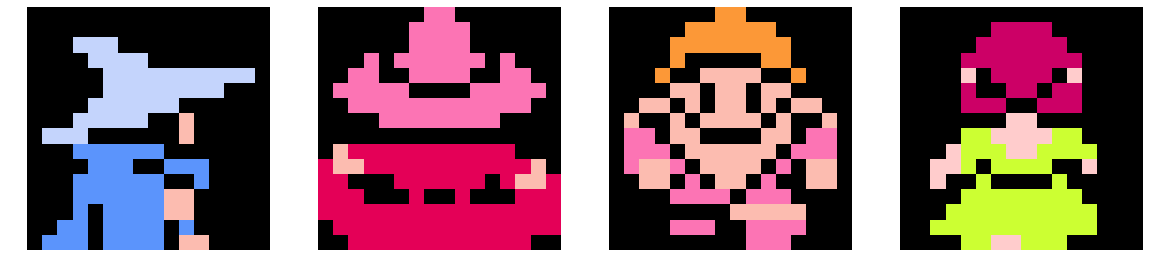

(4, 88, 256, 1)


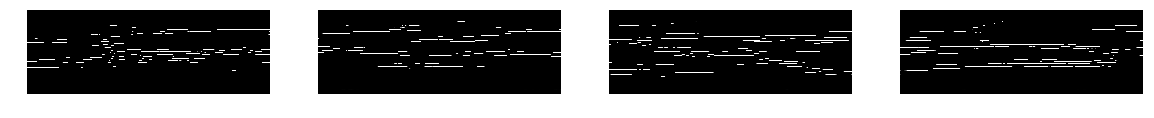

(4, 32, 32, 3)


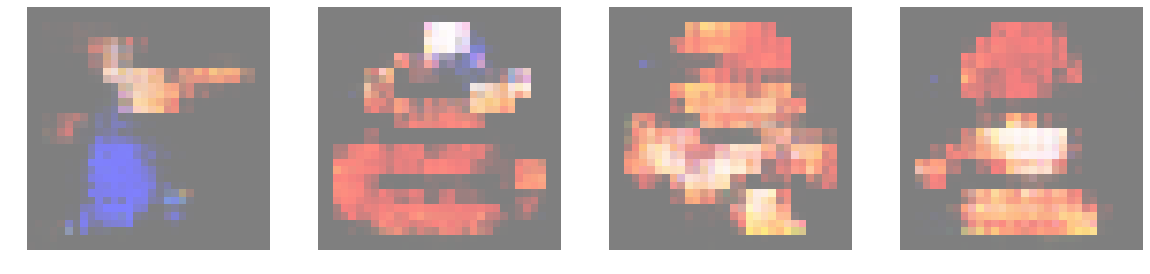

[101/110][35075] Loss_D: 0.016424 0.000624 Loss_G: 0.983427 0.999181 loss_cyc 0.812646 178.255
[101/110][35100] Loss_D: 0.011531 0.000366 Loss_G: 0.966116 1.001054 loss_cyc 0.799527 178.380
[101/110][35125] Loss_D: 0.023353 0.000387 Loss_G: 0.927626 1.001492 loss_cyc 0.775799 178.501
[101/110][35150] Loss_D: 0.022431 0.000549 Loss_G: 0.956320 0.999795 loss_cyc 0.783945 178.616
[101/110][35175] Loss_D: 0.023732 0.002544 Loss_G: 0.993600 1.004239 loss_cyc 0.822642 178.741
[101/110][35200] Loss_D: 0.015623 0.000303 Loss_G: 0.959787 0.999539 loss_cyc 0.799815 178.869
[101/110][35225] Loss_D: 0.025275 0.001356 Loss_G: 0.915424 1.002871 loss_cyc 0.830123 178.991
[101/110][35250] Loss_D: 0.021935 0.001439 Loss_G: 0.947722 0.999511 loss_cyc 0.813236 179.105
[101/110][35275] Loss_D: 0.023967 0.002095 Loss_G: 0.923862 0.999500 loss_cyc 0.771563 179.228
[101/110][35300] Loss_D: 0.022400 0.000829 Loss_G: 0.995681 1.000709 loss_cyc 0.807860 179.353
[101/110][35325] Loss_D: 0.016565 0.000731 Loss_G:

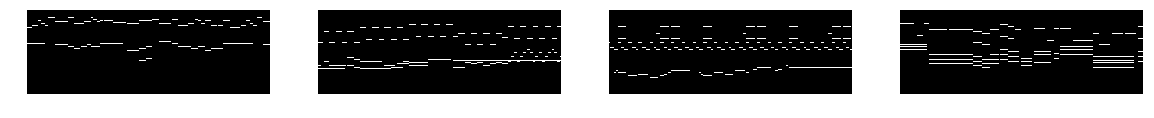

(4, 32, 32, 3)


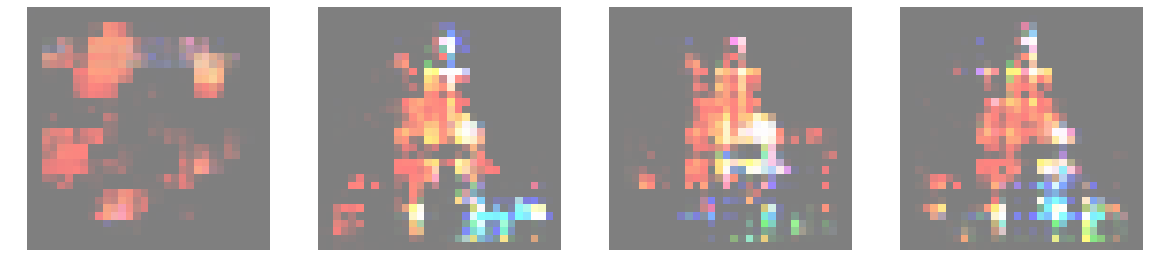

(4, 88, 256, 1)


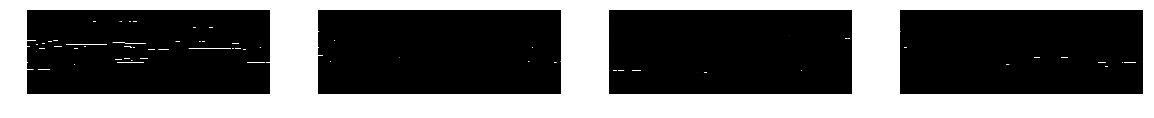

(4, 32, 32, 3)


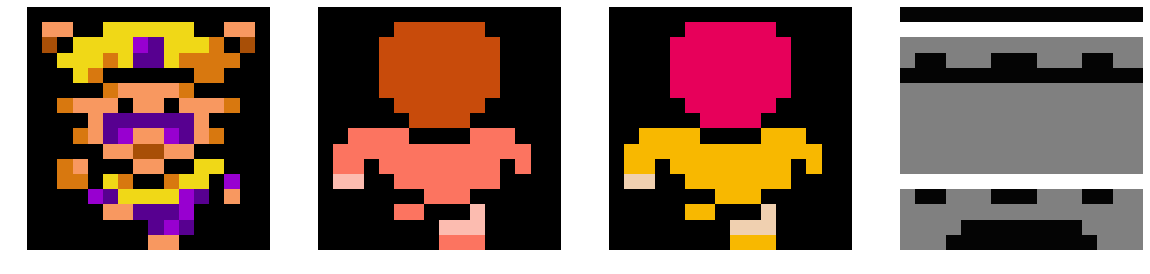

(4, 88, 256, 1)


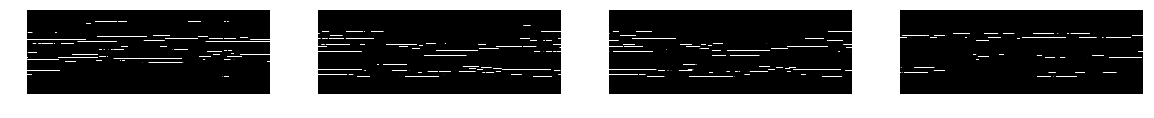

(4, 32, 32, 3)


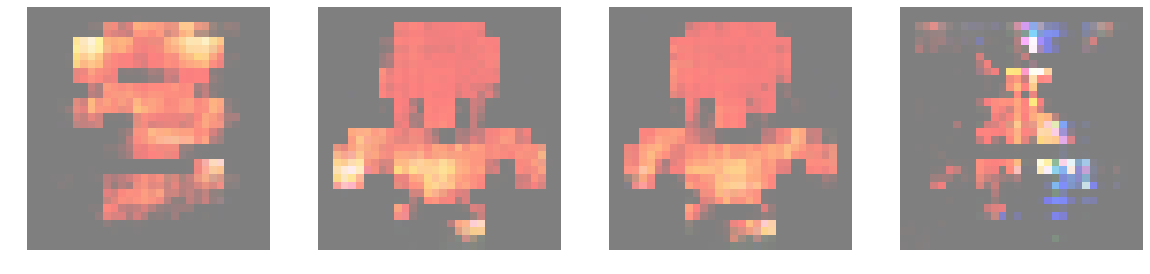

[102/110][35400] Loss_D: 0.010248 0.002053 Loss_G: 0.931171 1.003113 loss_cyc 0.781707 179.903
[102/110][35425] Loss_D: 0.021812 0.001392 Loss_G: 0.927086 0.998777 loss_cyc 0.802346 180.026
[102/110][35450] Loss_D: 0.017603 0.001654 Loss_G: 0.945316 1.003472 loss_cyc 0.796921 180.146
[102/110][35475] Loss_D: 0.015446 0.000306 Loss_G: 0.946680 1.002528 loss_cyc 0.811444 180.260
[102/110][35500] Loss_D: 0.023482 0.000886 Loss_G: 0.997203 0.999102 loss_cyc 0.797794 180.389
[102/110][35525] Loss_D: 0.027402 0.000515 Loss_G: 0.931780 1.001328 loss_cyc 0.817477 180.510
[102/110][35550] Loss_D: 0.036017 0.001206 Loss_G: 0.944681 1.006795 loss_cyc 0.791357 180.624
[102/110][35575] Loss_D: 0.023650 0.009777 Loss_G: 0.931726 1.005276 loss_cyc 0.807847 180.743
[102/110][35600] Loss_D: 0.021609 0.000298 Loss_G: 0.927185 1.000657 loss_cyc 0.808443 180.874
[102/110][35625] Loss_D: 0.020033 0.001175 Loss_G: 0.914415 1.001272 loss_cyc 0.797235 181.000
[102/110][35650] Loss_D: 0.019368 0.000923 Loss_G:

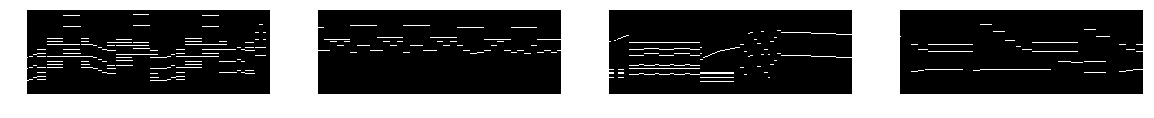

(4, 32, 32, 3)


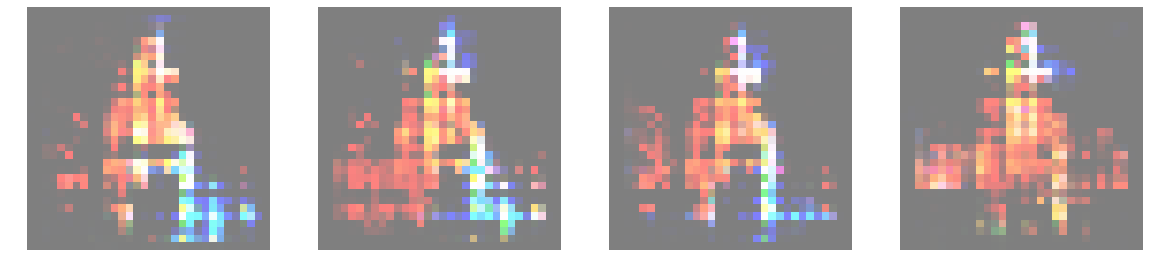

(4, 88, 256, 1)


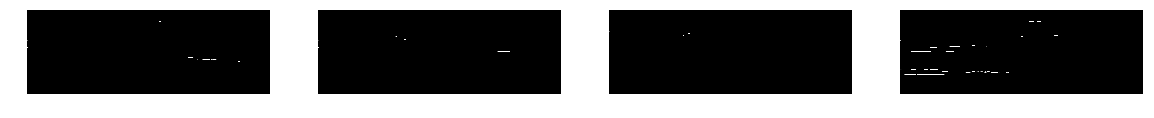

(4, 32, 32, 3)


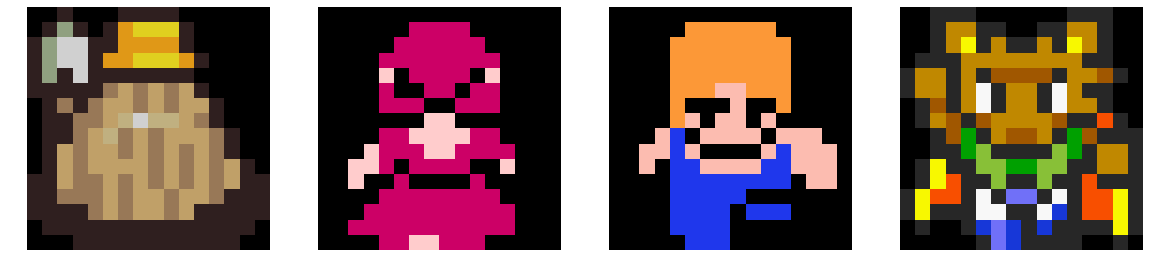

(4, 88, 256, 1)


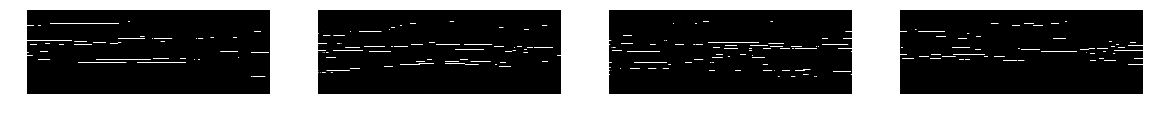

(4, 32, 32, 3)


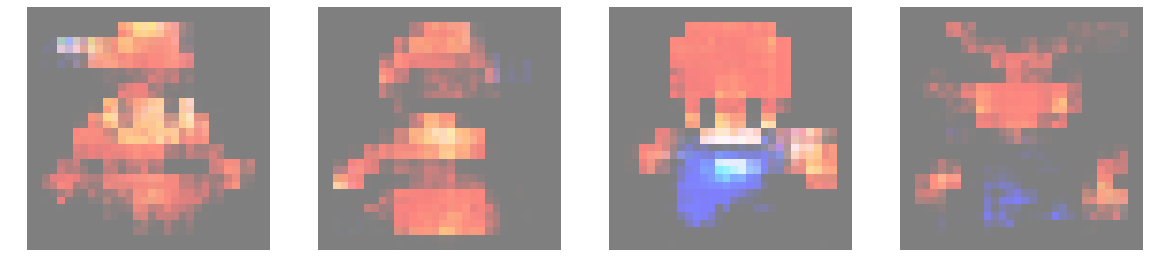

[103/110][35750] Loss_D: 0.022970 0.000321 Loss_G: 0.947539 1.001932 loss_cyc 0.807868 181.669
[103/110][35775] Loss_D: 0.020260 0.000314 Loss_G: 0.933913 0.998527 loss_cyc 0.786400 181.789
[103/110][35800] Loss_D: 0.019863 0.001324 Loss_G: 1.036397 1.004537 loss_cyc 0.792052 181.909
[103/110][35825] Loss_D: 0.025701 0.002250 Loss_G: 0.929862 0.999840 loss_cyc 0.816480 182.029
[103/110][35850] Loss_D: 0.024017 0.000826 Loss_G: 0.939674 0.997628 loss_cyc 0.792183 182.150
[103/110][35875] Loss_D: 0.021022 0.001210 Loss_G: 0.917664 1.003277 loss_cyc 0.811615 182.277
[103/110][35900] Loss_D: 0.020292 0.000110 Loss_G: 0.955674 1.000906 loss_cyc 0.811690 182.396
[103/110][35925] Loss_D: 0.021365 0.000183 Loss_G: 0.945595 1.000311 loss_cyc 0.798330 182.522
[103/110][35950] Loss_D: 0.020181 0.000395 Loss_G: 0.999147 0.997838 loss_cyc 0.786209 182.643
[103/110][35975] Loss_D: 0.023318 0.002340 Loss_G: 0.918766 1.005143 loss_cyc 0.806141 182.778
[103/110][36000] Loss_D: 0.013848 0.005106 Loss_G:

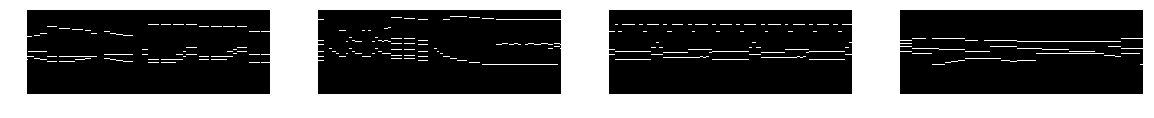

(4, 32, 32, 3)


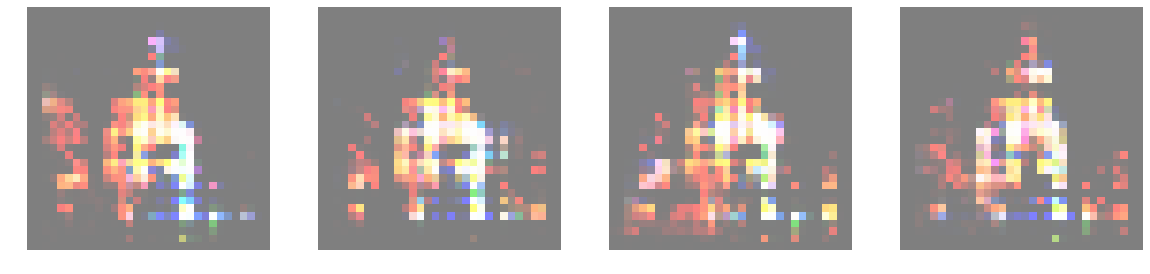

(4, 88, 256, 1)


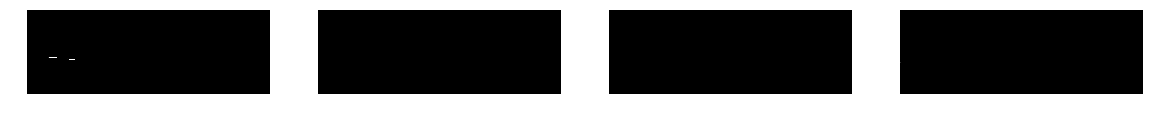

(4, 32, 32, 3)


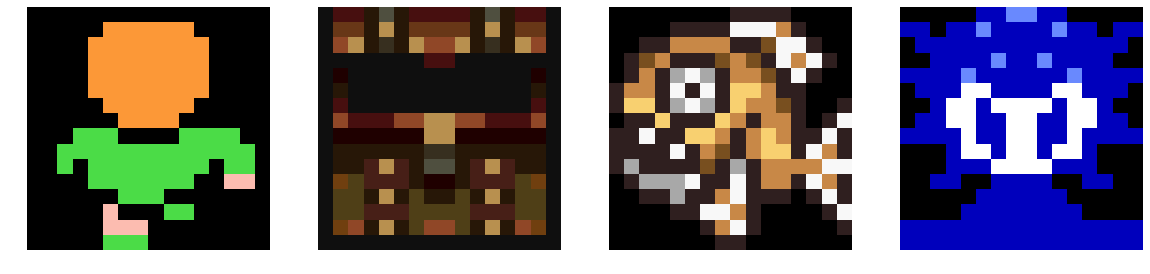

(4, 88, 256, 1)


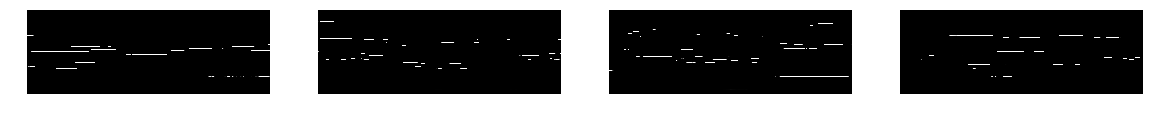

(4, 32, 32, 3)


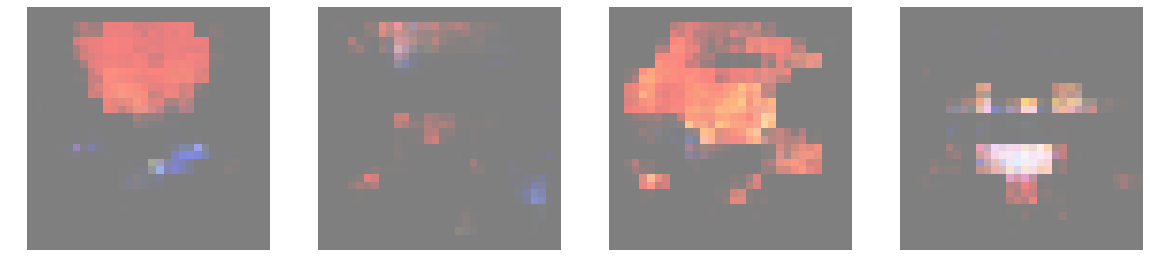

[104/110][36100] Loss_D: 0.023444 0.000746 Loss_G: 0.958730 1.003161 loss_cyc 0.809327 183.442
[104/110][36125] Loss_D: 0.026429 0.002882 Loss_G: 0.914494 1.000906 loss_cyc 0.789295 183.569
[104/110][36150] Loss_D: 0.015745 0.001114 Loss_G: 0.953639 0.998148 loss_cyc 0.794261 183.693
[104/110][36175] Loss_D: 0.019958 0.000300 Loss_G: 0.939372 1.000843 loss_cyc 0.799688 183.809
[104/110][36200] Loss_D: 0.017081 0.001385 Loss_G: 0.938480 1.001145 loss_cyc 0.811294 183.923
[104/110][36225] Loss_D: 0.012874 0.000430 Loss_G: 0.962524 1.000715 loss_cyc 0.808693 184.034
[104/110][36250] Loss_D: 0.013383 0.000163 Loss_G: 0.939310 0.999692 loss_cyc 0.816917 184.153
[104/110][36275] Loss_D: 0.015280 0.001054 Loss_G: 0.984252 1.000352 loss_cyc 0.797872 184.268
[104/110][36300] Loss_D: 0.018073 0.002356 Loss_G: 0.951243 1.001069 loss_cyc 0.775502 184.409
[104/110][36325] Loss_D: 0.013760 0.000996 Loss_G: 0.990133 1.001526 loss_cyc 0.799750 184.536
[104/110][36350] Loss_D: 0.017046 0.001973 Loss_G:

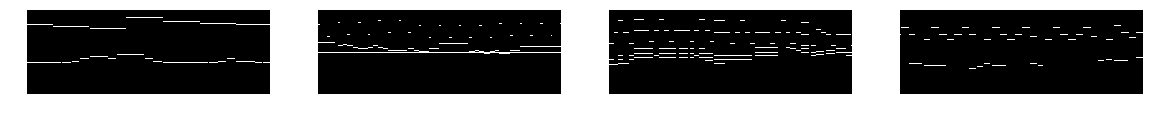

(4, 32, 32, 3)


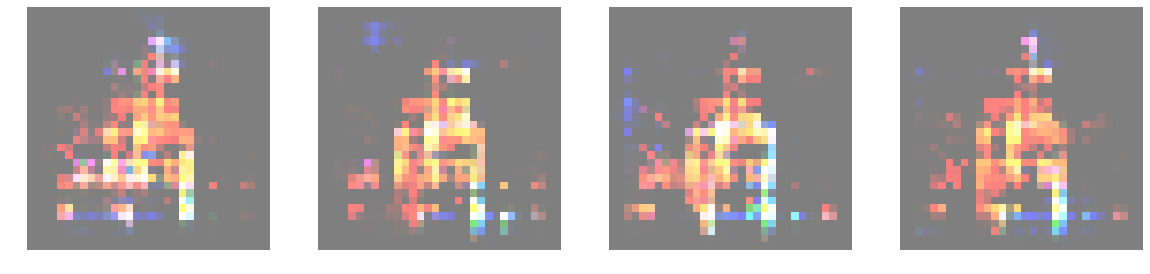

(4, 88, 256, 1)


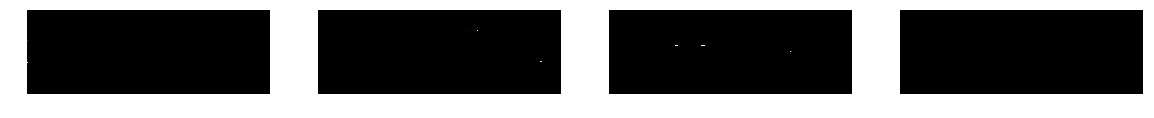

(4, 32, 32, 3)


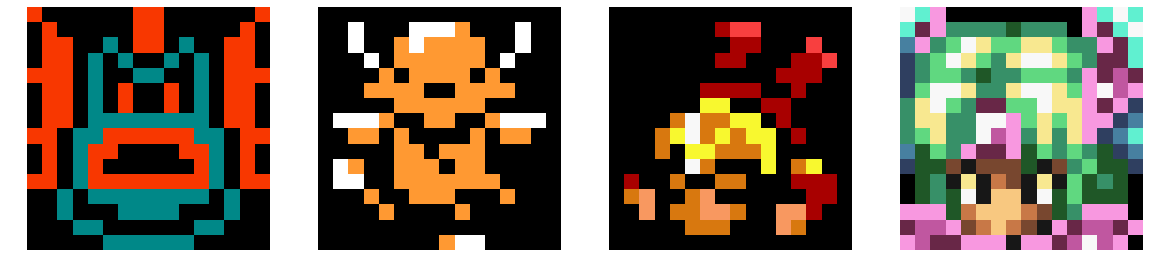

(4, 88, 256, 1)


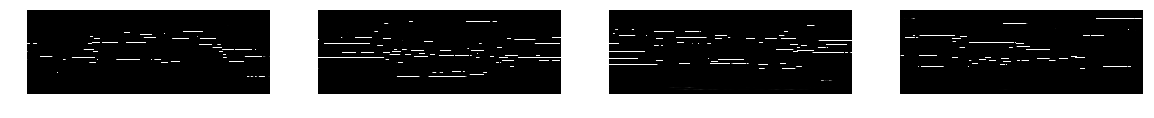

(4, 32, 32, 3)


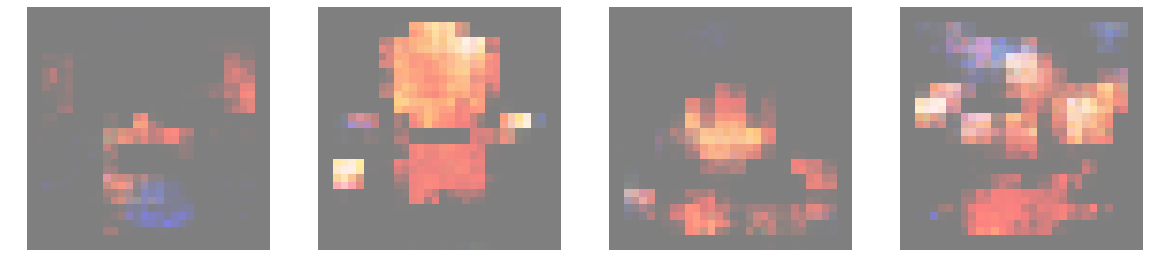

[105/110][36450] Loss_D: 0.015659 0.001446 Loss_G: 0.953409 1.002516 loss_cyc 0.809845 185.211
[105/110][36475] Loss_D: 0.012334 0.004151 Loss_G: 0.931979 1.000453 loss_cyc 0.793417 185.339
[105/110][36500] Loss_D: 0.031106 0.000977 Loss_G: 0.921288 1.003057 loss_cyc 0.811855 185.459
[105/110][36525] Loss_D: 0.026408 0.000377 Loss_G: 0.938674 0.998961 loss_cyc 0.782275 185.588
[105/110][36550] Loss_D: 0.013645 0.000413 Loss_G: 0.983242 1.000480 loss_cyc 0.800074 185.709
[105/110][36575] Loss_D: 0.026147 0.000301 Loss_G: 0.929879 1.000949 loss_cyc 0.808523 185.831
[105/110][36600] Loss_D: 0.016572 0.002030 Loss_G: 0.981720 1.003765 loss_cyc 0.813919 185.945
[105/110][36625] Loss_D: 0.021371 0.001386 Loss_G: 0.947584 0.998858 loss_cyc 0.805794 186.065
[105/110][36650] Loss_D: 0.018705 0.000809 Loss_G: 0.966613 1.000823 loss_cyc 0.810314 186.185
[105/110][36675] Loss_D: 0.012160 0.002611 Loss_G: 0.943895 1.003739 loss_cyc 0.797070 186.303
[105/110][36700] Loss_D: 0.021903 0.001126 Loss_G:

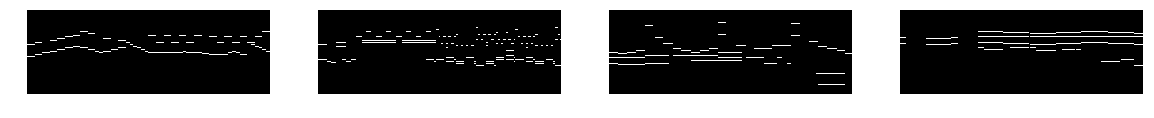

(4, 32, 32, 3)


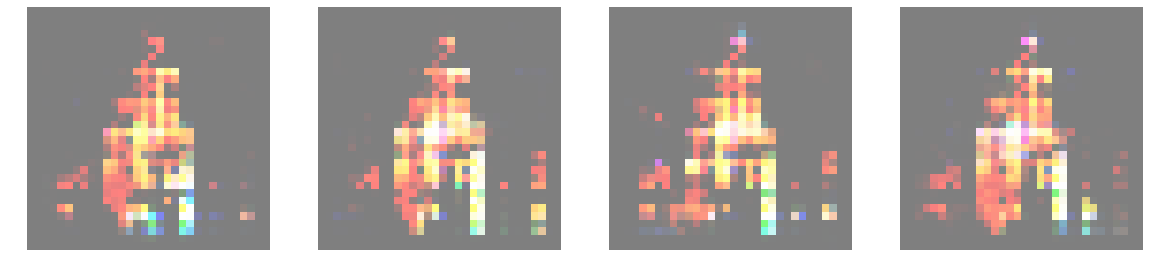

(4, 88, 256, 1)


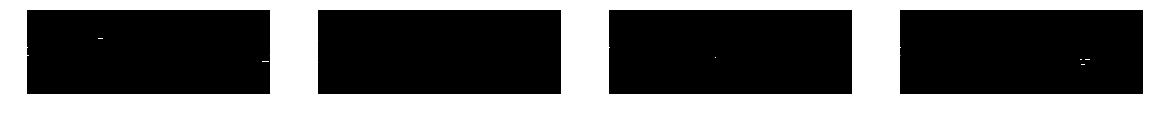

(4, 32, 32, 3)


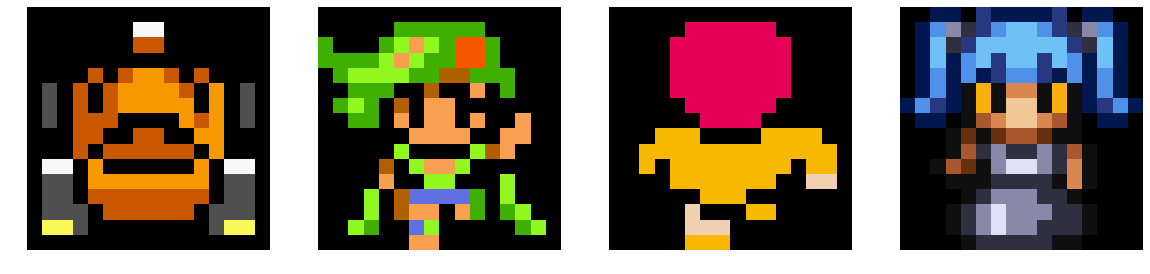

(4, 88, 256, 1)


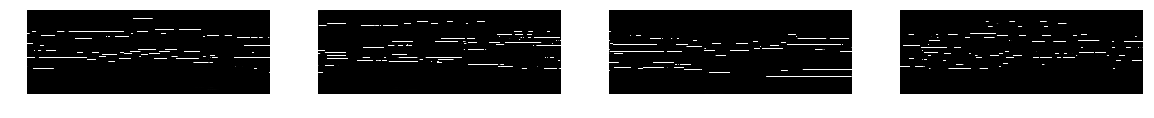

(4, 32, 32, 3)


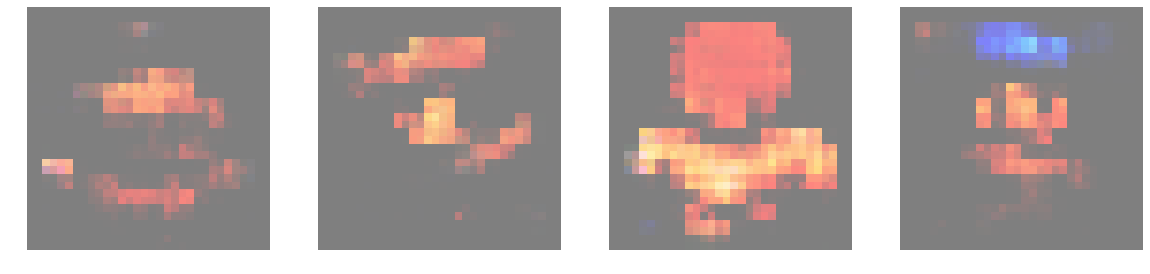

[106/110][36800] Loss_D: 0.022033 0.000290 Loss_G: 0.998424 0.999077 loss_cyc 0.768709 186.993
[106/110][36825] Loss_D: 0.014052 0.004944 Loss_G: 0.971904 1.004186 loss_cyc 0.775883 187.113
[106/110][36850] Loss_D: 0.014457 0.000378 Loss_G: 1.002960 0.999555 loss_cyc 0.798475 187.234
[106/110][36875] Loss_D: 0.020057 0.000642 Loss_G: 0.980073 1.000324 loss_cyc 0.807220 187.359
[106/110][36900] Loss_D: 0.014325 0.000790 Loss_G: 1.011056 1.003626 loss_cyc 0.774345 187.480
[106/110][36925] Loss_D: 0.020782 0.003166 Loss_G: 0.971595 0.998378 loss_cyc 0.821365 187.598
[106/110][36950] Loss_D: 0.020375 0.001792 Loss_G: 0.948759 1.001445 loss_cyc 0.792633 187.725
[106/110][36975] Loss_D: 0.012283 0.001231 Loss_G: 0.979313 1.003228 loss_cyc 0.815991 187.846
[106/110][37000] Loss_D: 0.020162 0.000424 Loss_G: 1.007768 1.000346 loss_cyc 0.777273 187.962
[106/110][37025] Loss_D: 0.020899 0.001059 Loss_G: 0.905741 0.999810 loss_cyc 0.801214 188.080
[106/110][37050] Loss_D: 0.012014 0.001220 Loss_G:

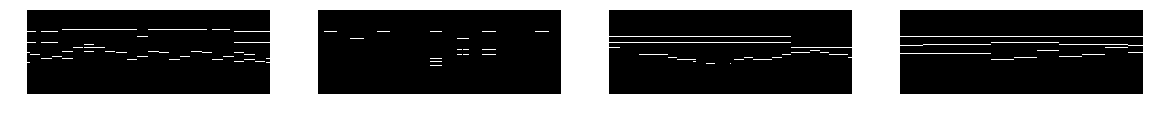

(4, 32, 32, 3)


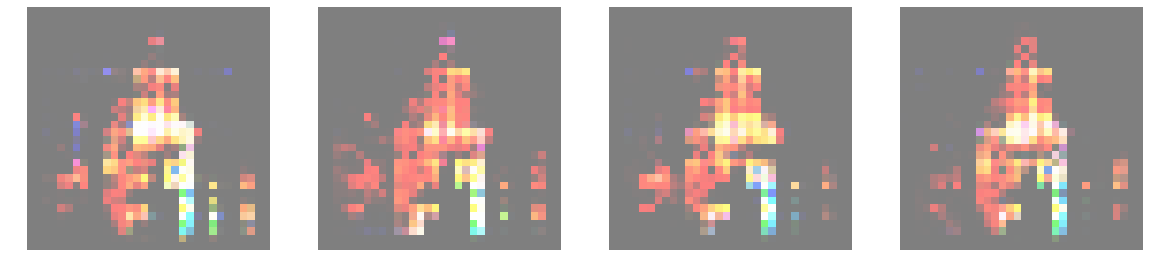

(4, 88, 256, 1)


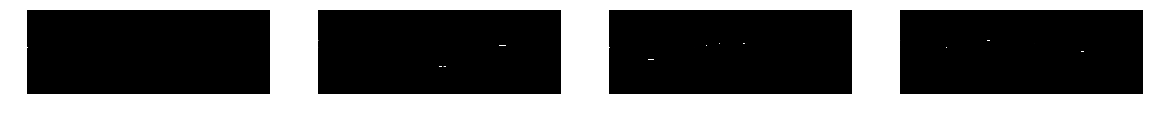

(4, 32, 32, 3)


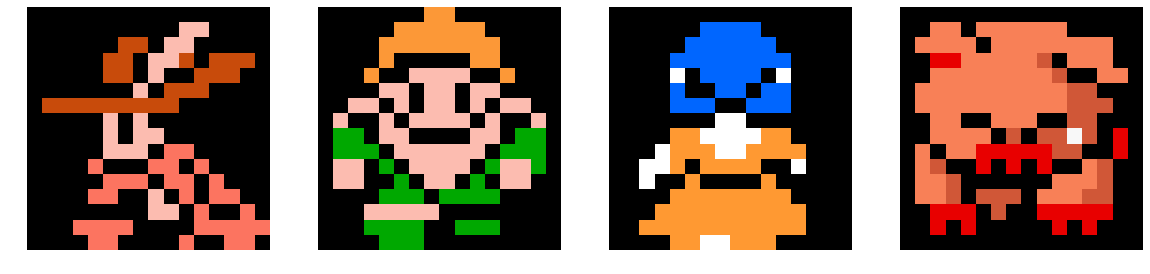

(4, 88, 256, 1)


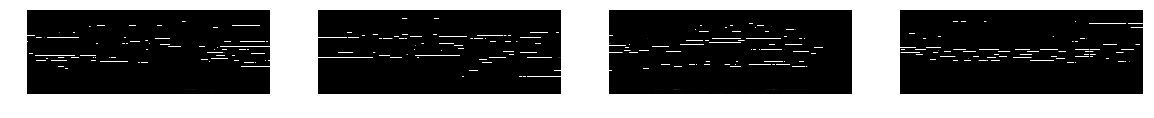

(4, 32, 32, 3)


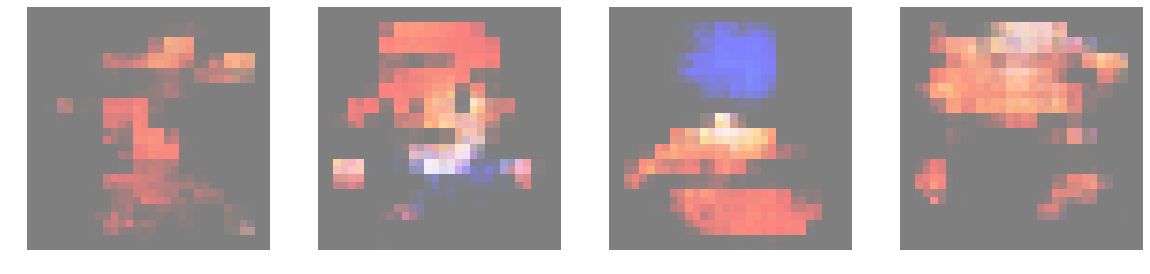

[107/110][37150] Loss_D: 0.026950 0.000183 Loss_G: 0.936334 0.999556 loss_cyc 0.791740 188.761
[107/110][37175] Loss_D: 0.028949 0.000812 Loss_G: 0.934298 0.998037 loss_cyc 0.782325 188.880
[107/110][37200] Loss_D: 0.021315 0.003876 Loss_G: 0.950579 1.006070 loss_cyc 0.804081 189.015
[107/110][37225] Loss_D: 0.015769 0.000336 Loss_G: 0.901060 0.998911 loss_cyc 0.794322 189.136
[107/110][37250] Loss_D: 0.021460 0.001448 Loss_G: 0.957982 1.002424 loss_cyc 0.795480 189.257
[107/110][37275] Loss_D: 0.020512 0.000823 Loss_G: 0.957075 0.999444 loss_cyc 0.797318 189.376
[107/110][37300] Loss_D: 0.025580 0.001114 Loss_G: 0.929486 1.004624 loss_cyc 0.799257 189.495
[107/110][37325] Loss_D: 0.017033 0.000970 Loss_G: 0.964130 0.996944 loss_cyc 0.808522 189.609
[107/110][37350] Loss_D: 0.022973 0.001697 Loss_G: 0.934922 1.001081 loss_cyc 0.805977 189.741
[107/110][37375] Loss_D: 0.024767 0.001042 Loss_G: 0.958091 1.003184 loss_cyc 0.802206 189.872
[107/110][37400] Loss_D: 0.020492 0.000717 Loss_G:

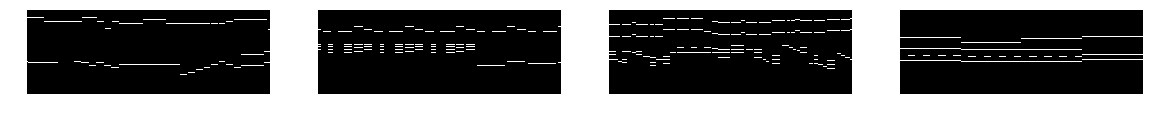

(4, 32, 32, 3)


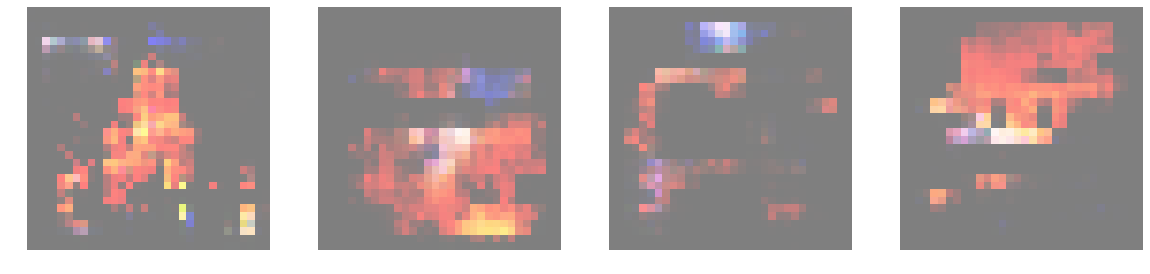

(4, 88, 256, 1)


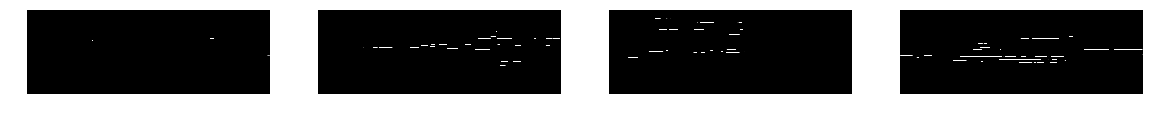

(4, 32, 32, 3)


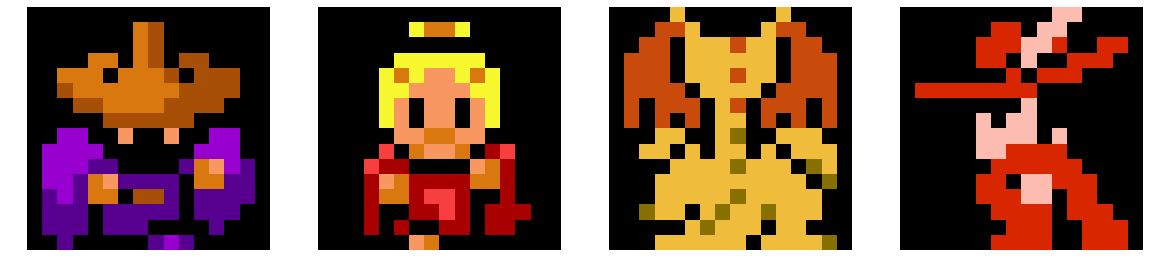

(4, 88, 256, 1)


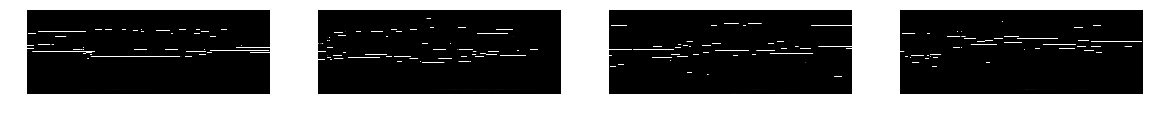

(4, 32, 32, 3)


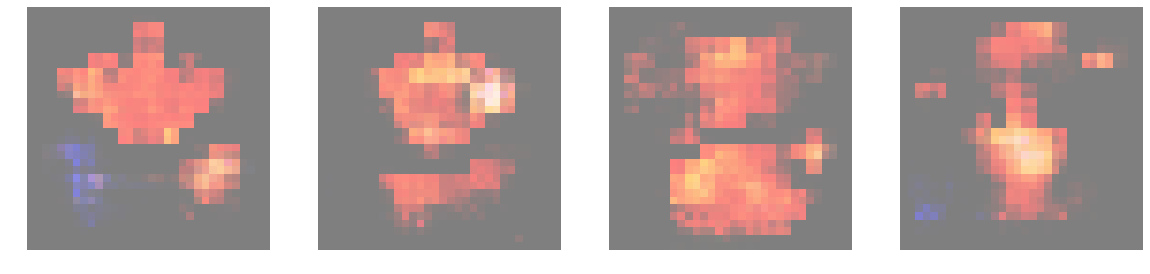

[108/110][37500] Loss_D: 0.025071 0.002113 Loss_G: 0.974080 1.002613 loss_cyc 0.777928 190.530
[108/110][37525] Loss_D: 0.024087 0.000181 Loss_G: 0.927801 1.000080 loss_cyc 0.801726 190.650
[108/110][37550] Loss_D: 0.024549 0.000528 Loss_G: 0.928215 1.000942 loss_cyc 0.811869 190.770
[108/110][37575] Loss_D: 0.013353 0.000218 Loss_G: 0.943183 0.999783 loss_cyc 0.775100 190.905
[108/110][37600] Loss_D: 0.029646 0.000434 Loss_G: 0.938772 1.002422 loss_cyc 0.797283 191.024
[108/110][37625] Loss_D: 0.020393 0.000469 Loss_G: 0.961314 1.000725 loss_cyc 0.809961 191.136
[108/110][37650] Loss_D: 0.027601 0.000359 Loss_G: 0.873872 0.999578 loss_cyc 0.786915 191.256
[108/110][37675] Loss_D: 0.021182 0.000411 Loss_G: 0.957530 1.000929 loss_cyc 0.811013 191.386
[108/110][37700] Loss_D: 0.024308 0.003614 Loss_G: 0.949591 0.999467 loss_cyc 0.825103 191.508
[108/110][37725] Loss_D: 0.024962 0.001847 Loss_G: 0.937537 1.004425 loss_cyc 0.824087 191.638
[108/110][37750] Loss_D: 0.023307 0.000531 Loss_G:

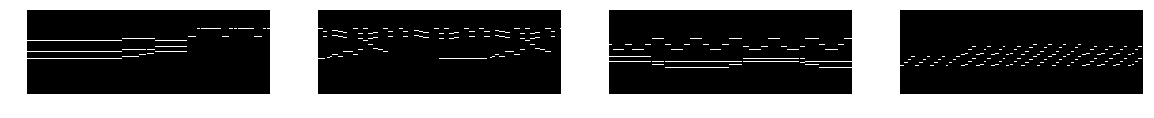

(4, 32, 32, 3)


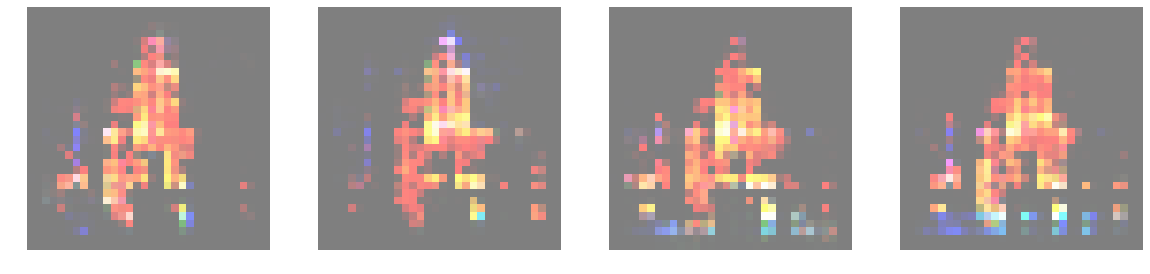

(4, 88, 256, 1)


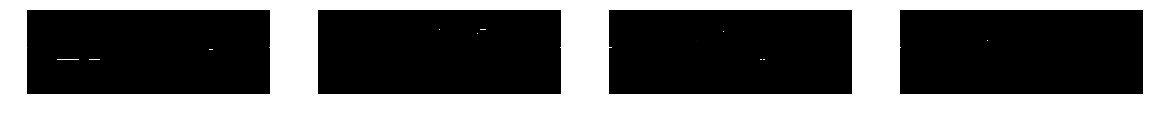

(4, 32, 32, 3)


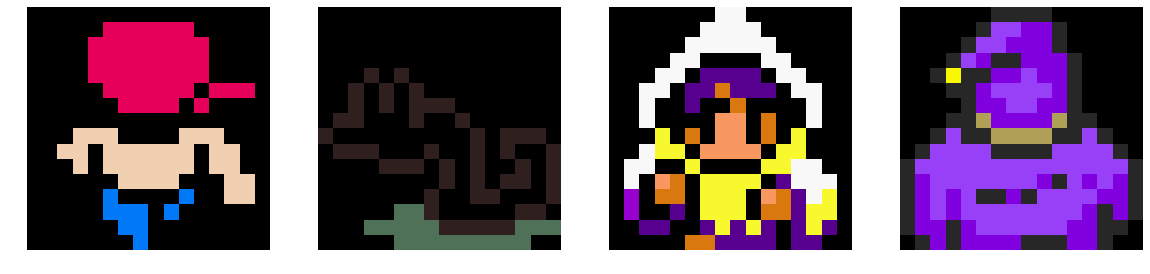

(4, 88, 256, 1)


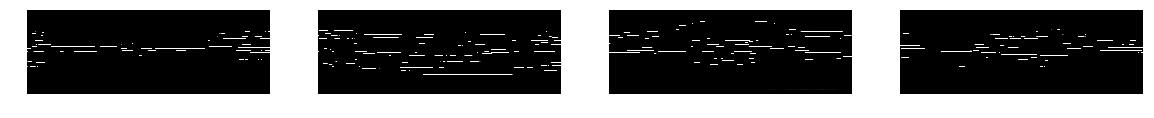

(4, 32, 32, 3)


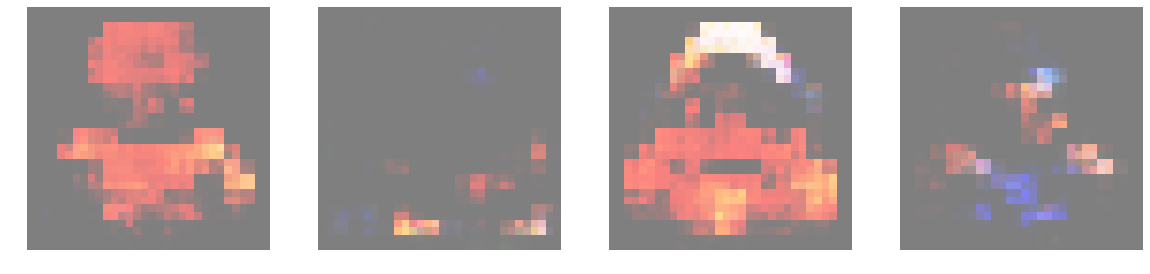

[109/110][37850] Loss_D: 0.025307 0.001721 Loss_G: 0.943825 1.002042 loss_cyc 0.792353 192.306
[109/110][37875] Loss_D: 0.016133 0.001230 Loss_G: 0.898408 0.999294 loss_cyc 0.798702 192.436
[109/110][37900] Loss_D: 0.013973 0.001267 Loss_G: 0.934427 1.000875 loss_cyc 0.779835 192.556
[109/110][37925] Loss_D: 0.014950 0.000911 Loss_G: 0.970856 1.000080 loss_cyc 0.807121 192.672
[109/110][37950] Loss_D: 0.014854 0.000529 Loss_G: 0.921371 1.002220 loss_cyc 0.774141 192.803
[109/110][37975] Loss_D: 0.014009 0.001459 Loss_G: 1.001780 0.999835 loss_cyc 0.787347 192.924
[109/110][38000] Loss_D: 0.022186 0.000426 Loss_G: 0.958809 1.002198 loss_cyc 0.809198 193.050
[109/110][38025] Loss_D: 0.026578 0.024227 Loss_G: 0.940521 1.015200 loss_cyc 0.791196 193.164
[109/110][38050] Loss_D: 0.022020 0.000288 Loss_G: 0.990940 0.999314 loss_cyc 0.799363 193.288
[109/110][38075] Loss_D: 0.012942 0.000371 Loss_G: 0.902646 1.000614 loss_cyc 0.787929 193.410
[109/110][38100] Loss_D: 0.016305 0.000184 Loss_G:

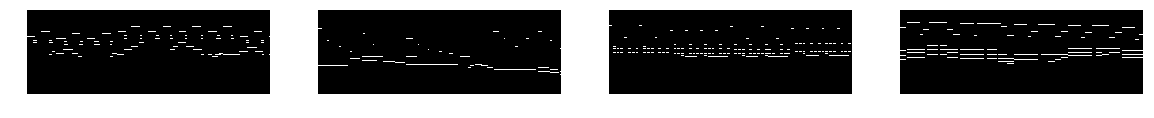

(4, 32, 32, 3)


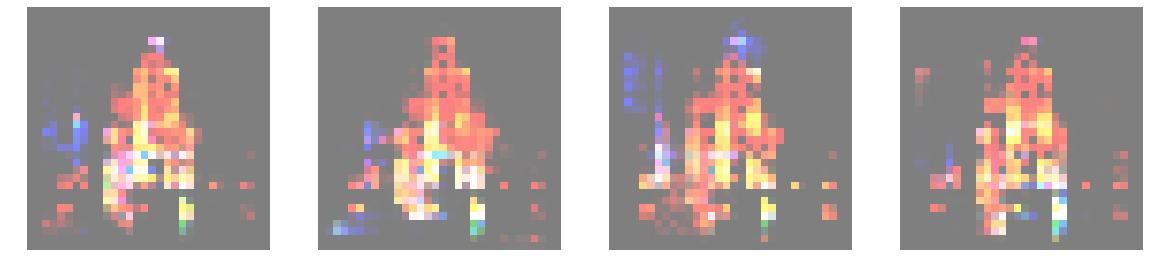

(4, 88, 256, 1)


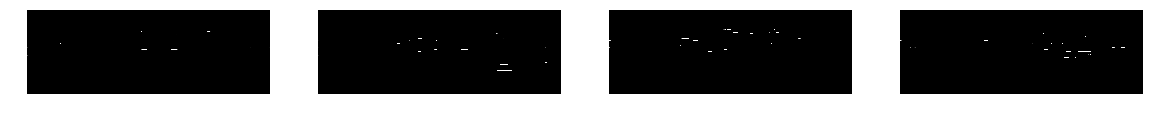

(4, 32, 32, 3)


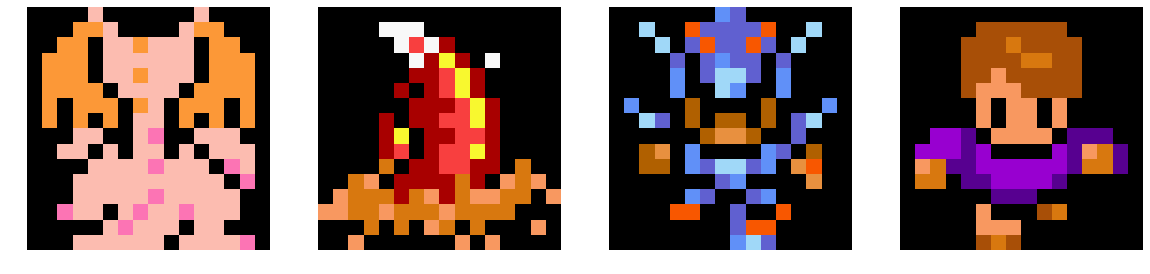

(4, 88, 256, 1)


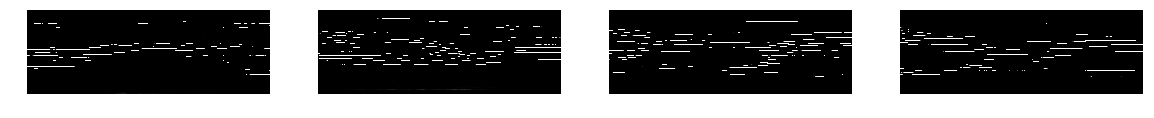

(4, 32, 32, 3)


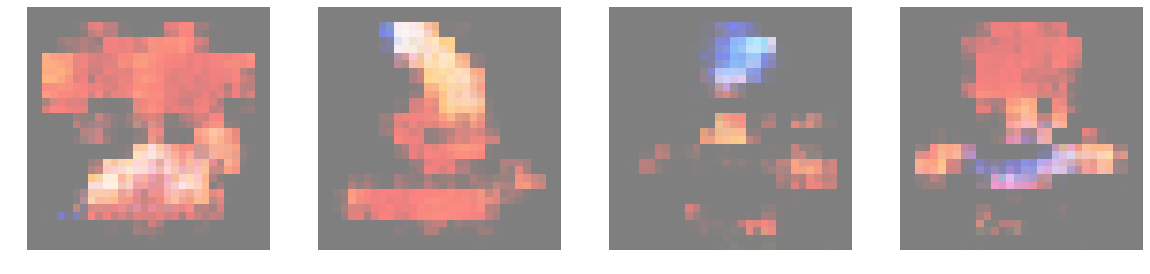

(4, 88, 256, 1)


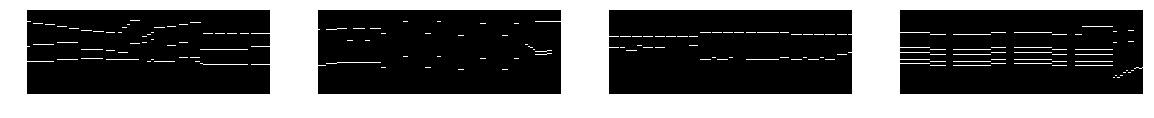

(4, 32, 32, 3)


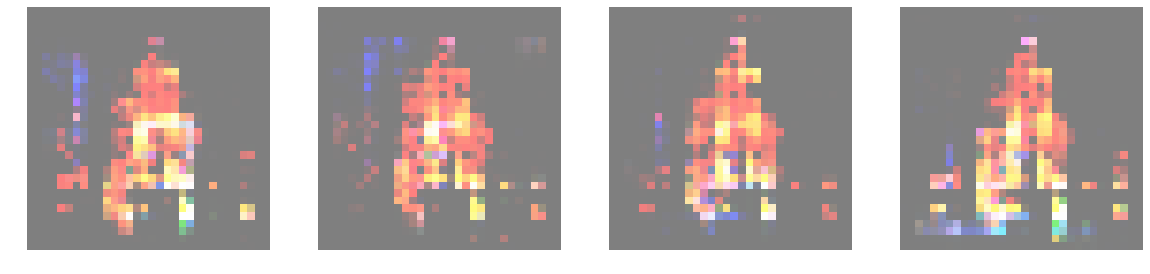

(4, 88, 256, 1)


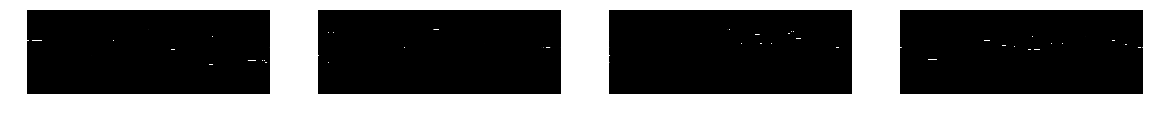

(4, 32, 32, 3)


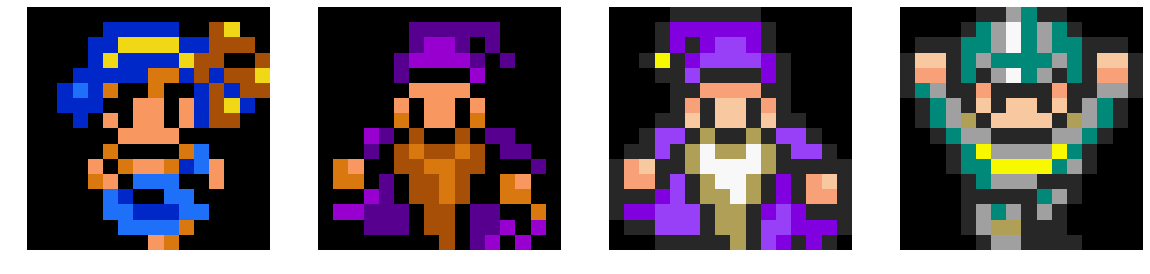

(4, 88, 256, 1)


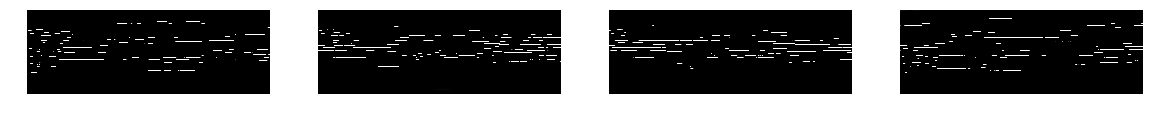

(4, 32, 32, 3)


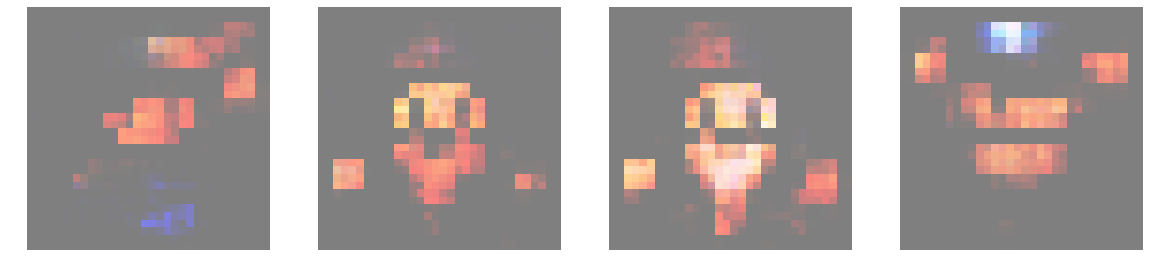

In [26]:
import time
from IPython.display import clear_output
t0 = time.time()
niter = 110
gen_iterations = 0
epoch = 0
errCyc_sum = errGM_sum = errGS_sum = errDM_sum = errDS_sum = 0

past_epoch = 0
display_iters = 25
#val_batch = minibatch(valAB, 6, direction)
train_batch = minibatchMS(train_M, train_S, batchSize)

while epoch < niter: 
    epoch, M, S = next(train_batch)  
    errDM, errDS  = netD_train([M, S])
    errDM_sum +=errDM
    errDS_sum +=errDS

    # epoch, trainA, trainB = next(train_batch)
    errGM, errGS, errCyc = netG_train([M, S])
    errGM_sum += errGM
    errGS_sum += errGS
    errCyc_sum += errCyc
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        #if gen_iterations%(5*display_iters)==0:
        #clear_output()
        print('[%d/%d][%d] Loss_D: %f %f Loss_G: %f %f loss_cyc %f'
        % (epoch, niter, gen_iterations, errDM_sum/display_iters, errDS_sum/display_iters,
           errGM_sum/display_iters, errGS_sum/display_iters, 
           errCyc_sum/display_iters), "%.3f" % ((time.time()-t0)/60.0))
        errCyc_sum = errGM_sum = errGS_sum = errDM_sum = errDS_sum = 0
    if epoch != past_epoch:
        _, M, S = train_batch.send(4)
        showG(M,S)
        if epoch == 270:
            netDM.save('run08b_netDM')
            netDS.save('run08b_netDS')
            netGM.save('run08b_netGM')
            netGS.save('run08b_netGS')
        past_epoch = epoch
        
        
_, M, S = train_batch.send(4)
showG(M,S)

In [27]:
# save all the things
netDM.save('run10_netDM')
netDS.save('run10_netDS')
netGM.save('run10_netGM')
netGS.save('run10_netGS')

In [30]:

def getG(M,S):
    def G(fn_generate, X):
        fakes = []
        recs = []
        for i in range(X.shape[0]):
            fake, rec = fn_generate([X[i:i+1]])
            fakes.append(fake[0])
            recs.append(rec[0])
        return [np.array(fakes), np.array(recs)]
    rM = G(cycleM_generate, M)
    rS = G(cycleS_generate, S)
    arr = [M,*rM,S,*rS]
    return arr


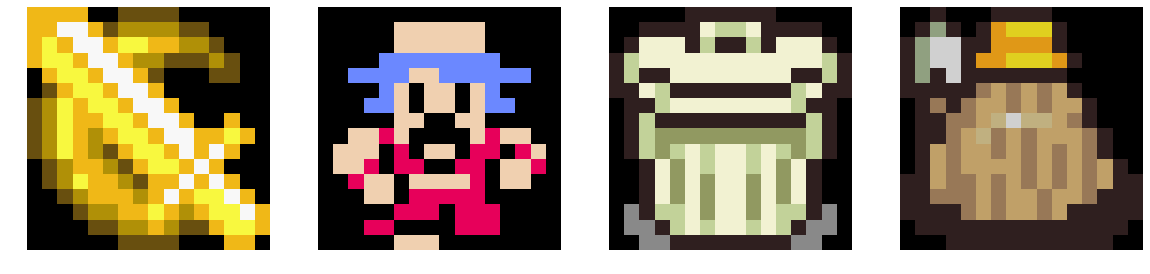

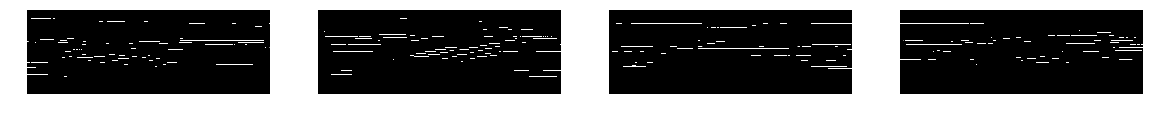

In [38]:

_, M, S = train_batch.send(4)

peek = getG(M,S)
p = 3
showX(peek[p], peek[p].shape[1], peek[p].shape[2], peek[p].shape[3], 1)
p = 4
threshold = 0.98
peek[p] = (peek[p] - threshold).clip(0, 1)
peek[p] = (peek[p] * 100).clip(0, 1)
showX(peek[p], peek[p].shape[1], peek[p].shape[2], peek[p].shape[3], 1)

pm = to_midi(peek[p][0], fs, pitch_range, force_velocity= binary_music)
pm.write('test1.mid')

pm = to_midi(peek[p][1], fs, pitch_range, force_velocity= binary_music)
pm.write('test2.mid')

pm = to_midi(peek[p][2], fs, pitch_range, force_velocity= binary_music)
pm.write('test3.mid')

pm = to_midi(peek[p][3], fs, pitch_range, force_velocity= binary_music)
pm.write('test4.mid')
